In [10]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from PIL import Image
#import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np
import copy

# PreTrain

In [ ]:
import os
import torch
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddSpeckleNoise(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.noise_level
        return torch.clamp(tensor * (1 + noise), 0, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/mnt/shuof/ML_AI/train/train"

transform = {
    'train': v2.Compose([
        v2.ToImage(),  
        v2.ToDtype(torch.uint8, scale=True),  
        v2.RandomResizedCrop(size=(224, 224), antialias=True, interpolation=InterpolationMode.BILINEAR),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.ToDtype(torch.float32, scale=True), 
        AddGaussianNoise(mean=0., std=0.05), 
        AddSpeckleNoise(noise_level=0.05), 
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize(size=(224, 224), antialias=True, interpolation=InterpolationMode.BILINEAR),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(root=data_dir, transform=transform['train'])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

num_classes = len(train_dataset.dataset.classes)
print(f"Number of classes: {num_classes}")

model = models.resnet50(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name: 
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},  
    {'params': model.fc.parameters(), 'lr': 0.001} 
])

early_stop_patience = 5  
best_val_loss = float('inf')
no_improve_epochs = 0
best_model_wts = None

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    model.train()
    train_loss, train_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_corrects += (outputs.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (outputs.argmax(dim=1) == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        print("Validation loss improved!")
        best_val_loss = val_loss
        no_improve_epochs = 0
        best_model_wts = copy.deepcopy(model.state_dict())  
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epoch(s)")
        if no_improve_epochs >= early_stop_patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(best_model_wts)

torch.save(model.state_dict(), "resnet50_simpsons.pth")
print("Model saved as resnet50_simpsons.pth")

Using device: cuda
Number of classes: 50
Epoch 1/10
--------------------
Train Loss: 0.9733 Acc: 0.7452
Val Loss: 0.6096 Acc: 0.8376
Validation loss improved!
Epoch 2/10
--------------------
Train Loss: 0.5520 Acc: 0.8532
Val Loss: 0.5134 Acc: 0.8661
Validation loss improved!
Epoch 3/10
--------------------
Train Loss: 0.4701 Acc: 0.8741
Val Loss: 0.4441 Acc: 0.8808
Validation loss improved!
Epoch 4/10
--------------------
Train Loss: 0.4134 Acc: 0.8892
Val Loss: 0.3973 Acc: 0.8938
Validation loss improved!
Epoch 5/10
--------------------
Train Loss: 0.3987 Acc: 0.8935
Val Loss: 0.3785 Acc: 0.8969
Validation loss improved!
Epoch 6/10
--------------------
Train Loss: 0.3596 Acc: 0.9053
Val Loss: 0.3496 Acc: 0.9052
Validation loss improved!
Epoch 7/10
--------------------
Train Loss: 0.3478 Acc: 0.9077
Val Loss: 0.3298 Acc: 0.9092
Validation loss improved!
Epoch 8/10
--------------------
Train Loss: 0.3234 Acc: 0.9136
Val Loss: 0.3314 Acc: 0.9128
No improvement for 1 epoch(s)
Epoch 9/10


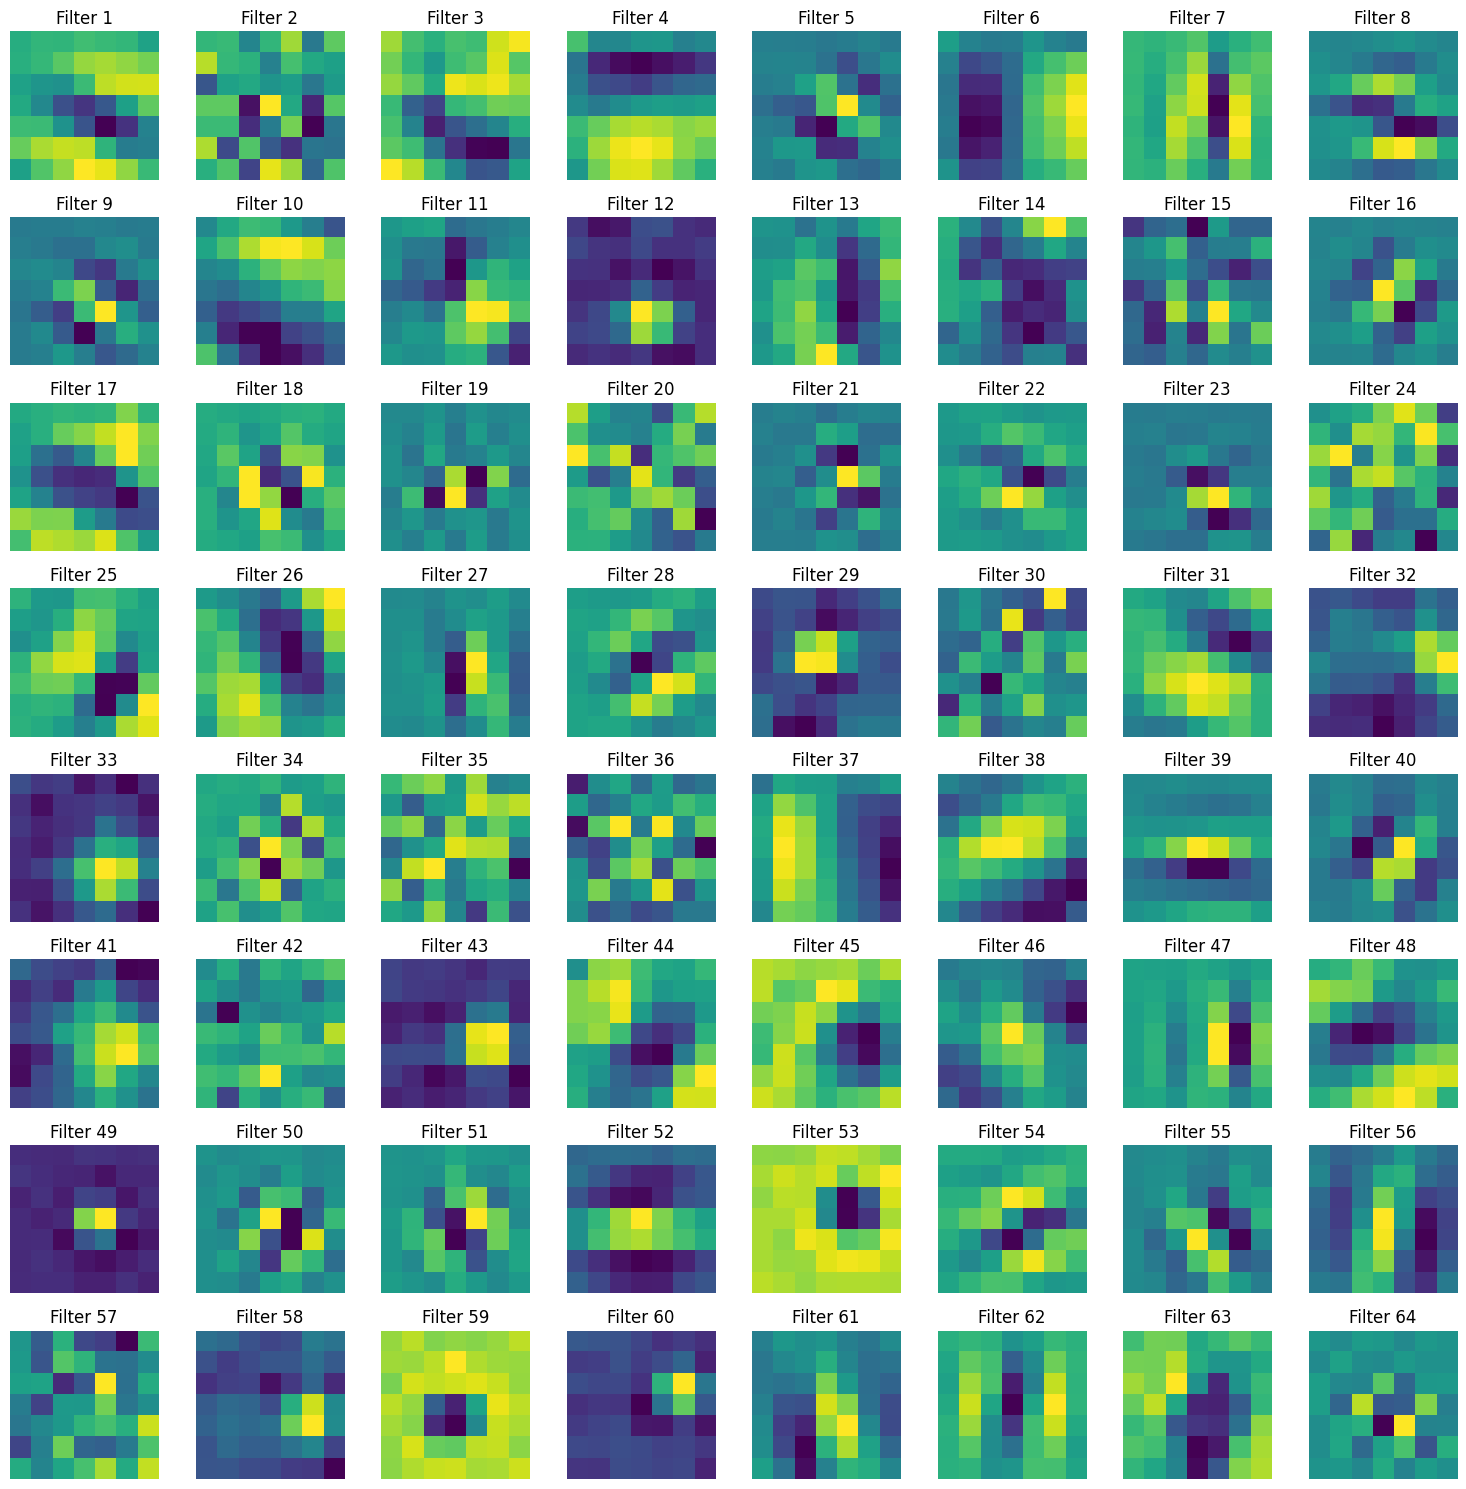

In [ ]:
model = models.resnet50(pretrained=True)

first_layer_weights = model.conv1.weight.data  # shape: [64, 3, 7, 7]

first_layer_weights = first_layer_weights.cpu().numpy()

def visualize_filters(weights):
    num_filters = weights.shape[0] 
    num_columns = 8 
    num_rows = (num_filters + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.flatten() 

    for i in range(num_filters):
        kernel = weights[i]
        kernel_mean = np.mean(kernel, axis=0)  

        axes[i].imshow(kernel_mean, cmap='viridis')  
        axes[i].axis('off')
        axes[i].set_title(f"Filter {i+1}")

    for i in range(num_filters, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_filters(first_layer_weights)

# CNN

Using device: cuda


/mnt/shuof/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/shuof/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
--------------------
Train Loss: 0.8771 Acc: 0.7701
Val Loss: 0.5193 Acc: 0.8618
Validation loss improved!
Epoch 2/20
--------------------
Train Loss: 0.4717 Acc: 0.8744
Val Loss: 0.4533 Acc: 0.8798
Validation loss improved!
Epoch 3/20
--------------------
Train Loss: 0.4129 Acc: 0.8903
Val Loss: 0.4056 Acc: 0.8890
Validation loss improved!
Epoch 4/20
--------------------
Train Loss: 0.3585 Acc: 0.9025
Val Loss: 0.3466 Acc: 0.9067
Validation loss improved!
Epoch 5/20
--------------------
Train Loss: 0.3357 Acc: 0.9099
Val Loss: 0.3162 Acc: 0.9144
Validation loss improved!
Epoch 6/20
--------------------
Train Loss: 0.3175 Acc: 0.9145
Val Loss: 0.3140 Acc: 0.9160
Validation loss improved!
Epoch 7/20
--------------------
Train Loss: 0.2943 Acc: 0.9211
Val Loss: 0.3175 Acc: 0.9167
No improvement for 1 epoch(s)
Epoch 8/20
--------------------
Train Loss: 0.2843 Acc: 0.9234
Val Loss: 0.2817 Acc: 0.9243
Validation loss improved!
Epoch 9/20
--------------------
Train Loss: 0.2665 A

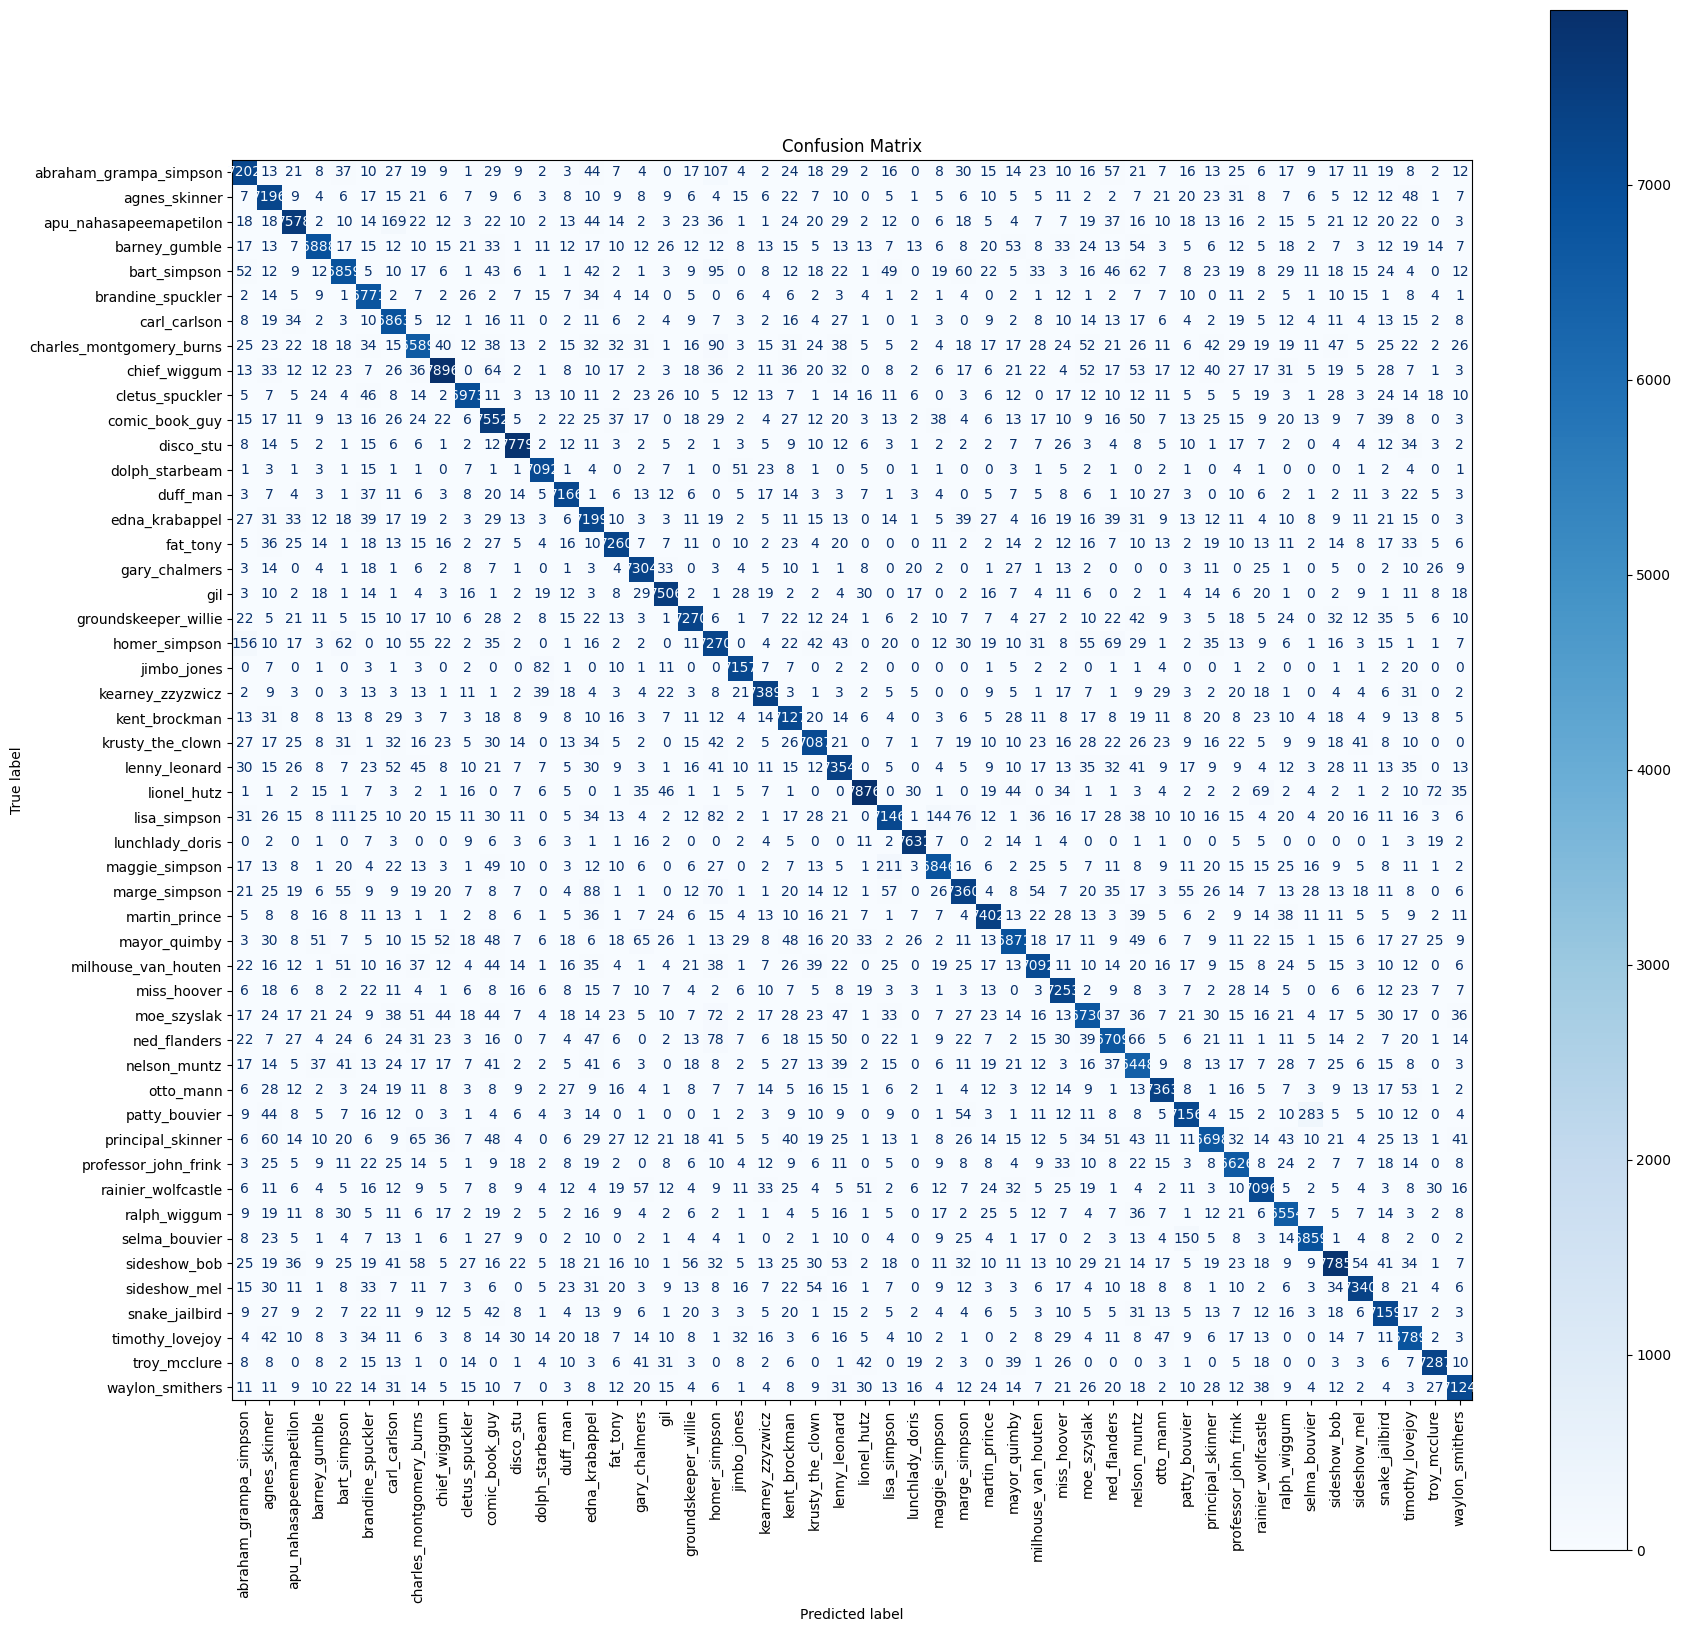

Confusion matrix saved as confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import copy
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

num_classes = len(train_dataset.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},
    {'params': model.fc.parameters(), 'lr': 0.001}
])

early_stop_patience = 5
best_val_loss = float('inf')
no_improve_epochs = 0
best_model_wts = None

all_true_labels = []
all_pred_labels = []

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    model.train()
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_corrects += (outputs.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    epoch_true_labels = []
    epoch_pred_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (outputs.argmax(dim=1) == labels).sum().item()
            epoch_true_labels.extend(labels.cpu().tolist())
            epoch_pred_labels.extend(outputs.argmax(dim=1).cpu().tolist())
    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    all_true_labels.extend(epoch_true_labels)
    all_pred_labels.extend(epoch_pred_labels)

    if val_loss < best_val_loss:
        print("Validation loss improved!")
        best_val_loss = val_loss
        no_improve_epochs = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epoch(s)")
        if no_improve_epochs >= early_stop_patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(best_model_wts)

torch.save(model.state_dict(), "resnet50_simpsons_finetuned.pth")
print("Model saved as resnet50_simpsons_finetuned.pth")

print("Generating confusion matrix...")
cm = confusion_matrix(all_true_labels, all_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)

fig, ax = plt.subplots(figsize=(20, 20))  
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

confusion_matrix_file = "confusion_matrix.png"
plt.savefig(confusion_matrix_file, bbox_inches='tight') 
print(f"Confusion matrix saved as {confusion_matrix_file}")

Generating confusion matrix...
Confusion matrix saved as simplified_confusion_matrix_no_numbers.png


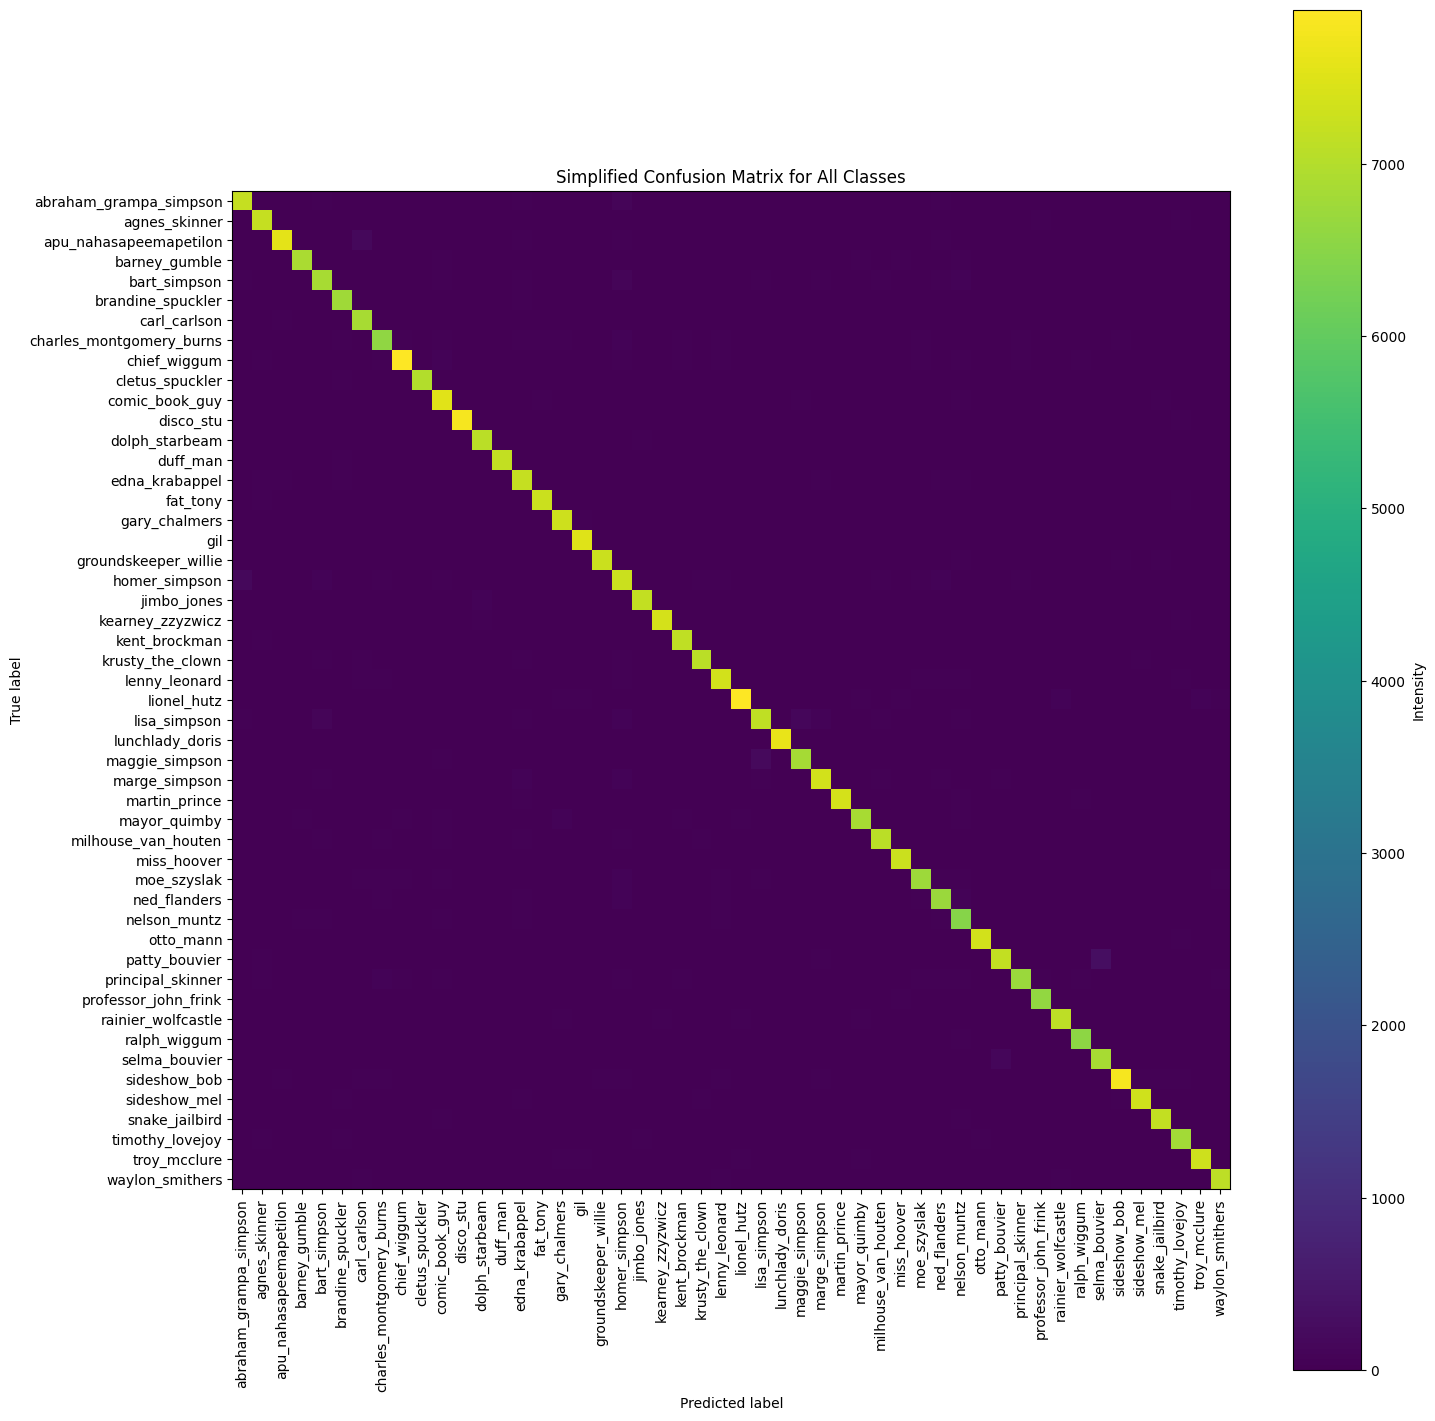

In [ ]:
print("Generating confusion matrix...")

cm = confusion_matrix(all_true_labels, all_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)

fig, ax = plt.subplots(figsize=(15, 15))  
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)  

ax.set_title("Simplified Confusion Matrix for All Classes")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(range(len(train_dataset.dataset.classes)))
ax.set_yticks(range(len(train_dataset.dataset.classes)))
ax.set_xticklabels(train_dataset.dataset.classes, rotation=90)
ax.set_yticklabels(train_dataset.dataset.classes)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label("Intensity")

confusion_matrix_file = "simplified_confusion_matrix_no_numbers.png"
plt.savefig(confusion_matrix_file, bbox_inches="tight")
print(f"Confusion matrix saved as {confusion_matrix_file}")

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_dir = "/mnt/shuof/ML_AI/test-final/test-final"

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

num_classes = len(train_dataset.dataset.classes) 
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes) 
model.load_state_dict(torch.load("resnet50_simpsons_finetuned_earlystop.pth")) 
model = model.to(device)
model.eval()  

classes = train_dataset.dataset.classes

results = []

for i in range(1, 10792): 
    img_path = os.path.join(test_dir, f"{i}.jpg")

    try:
        image = Image.open(img_path).convert("RGB")

        # 預處理圖片
        input_tensor = transform(image).unsqueeze(0) 
        input_tensor = input_tensor.to(device)

        # 預測
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)

        # 取得類別名稱
        character = classes[predicted.item()]

        # 儲存結果
        results.append({"id": i, "character": character})

        print(f"Processed {i}.jpg -> {character}")
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# 將結果保存為 DataFrame
df_results = pd.DataFrame(results)

# 儲存結果為 CSV
output_csv = "submission.csv"
df_results.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Using device: cuda


/mnt/shuof/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/shuof/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_450637/312205545.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Processed 1.jpg -> carl_carlson
Processed 2.jpg -> mayor_quimby
Processed 3.jpg -> snake_jailbird
Processed 4.jpg -> sideshow_mel
Processed 5.jpg -> groundskeeper_willie
Processed 6.jpg -> moe_szyslak
Processed 7.jpg -> gil
Processed 8.jpg -> moe_szyslak
Processed 9.jpg -> carl_carlson
Processed 10.jpg -> sideshow_mel
Processed 11.jpg -> ralph_wiggum
Processed 12.jpg -> timothy_lovejoy
Processed 13.jpg -> homer_simpson
Processed 14.jpg -> charles_montgomery_burns
Processed 15.jpg -> sideshow_mel
Processed 16.jpg -> gil
Processed 17.jpg -> gary_chalmers
Processed 18.jpg -> kent_brockman
Processed 19.jpg -> selma_bouvier
Processed 20.jpg -> kearney_zzyzwicz
Processed 21.jpg -> groundskeeper_willie
Processed 22.jpg -> comic_book_guy
Processed 23.jpg -> chief_wiggum
Processed 24.jpg -> brandine_spuckler
Processed 25.jpg -> homer_simpson
Processed 26.jpg -> disco_stu
Processed 27.jpg -> waylon_smithers
Processed 28.jpg -> disco_stu
Processed 29.jpg -> ned_flanders
Processed 30.jpg -> gary_c

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# 取得第一層卷積層的權重
filters = model.conv1.weight.data.cpu()  # [out_channels, in_channels, kernel_height, kernel_width]
print(f"Filter shape: {filters.shape}")

Filter shape: torch.Size([64, 3, 7, 7])


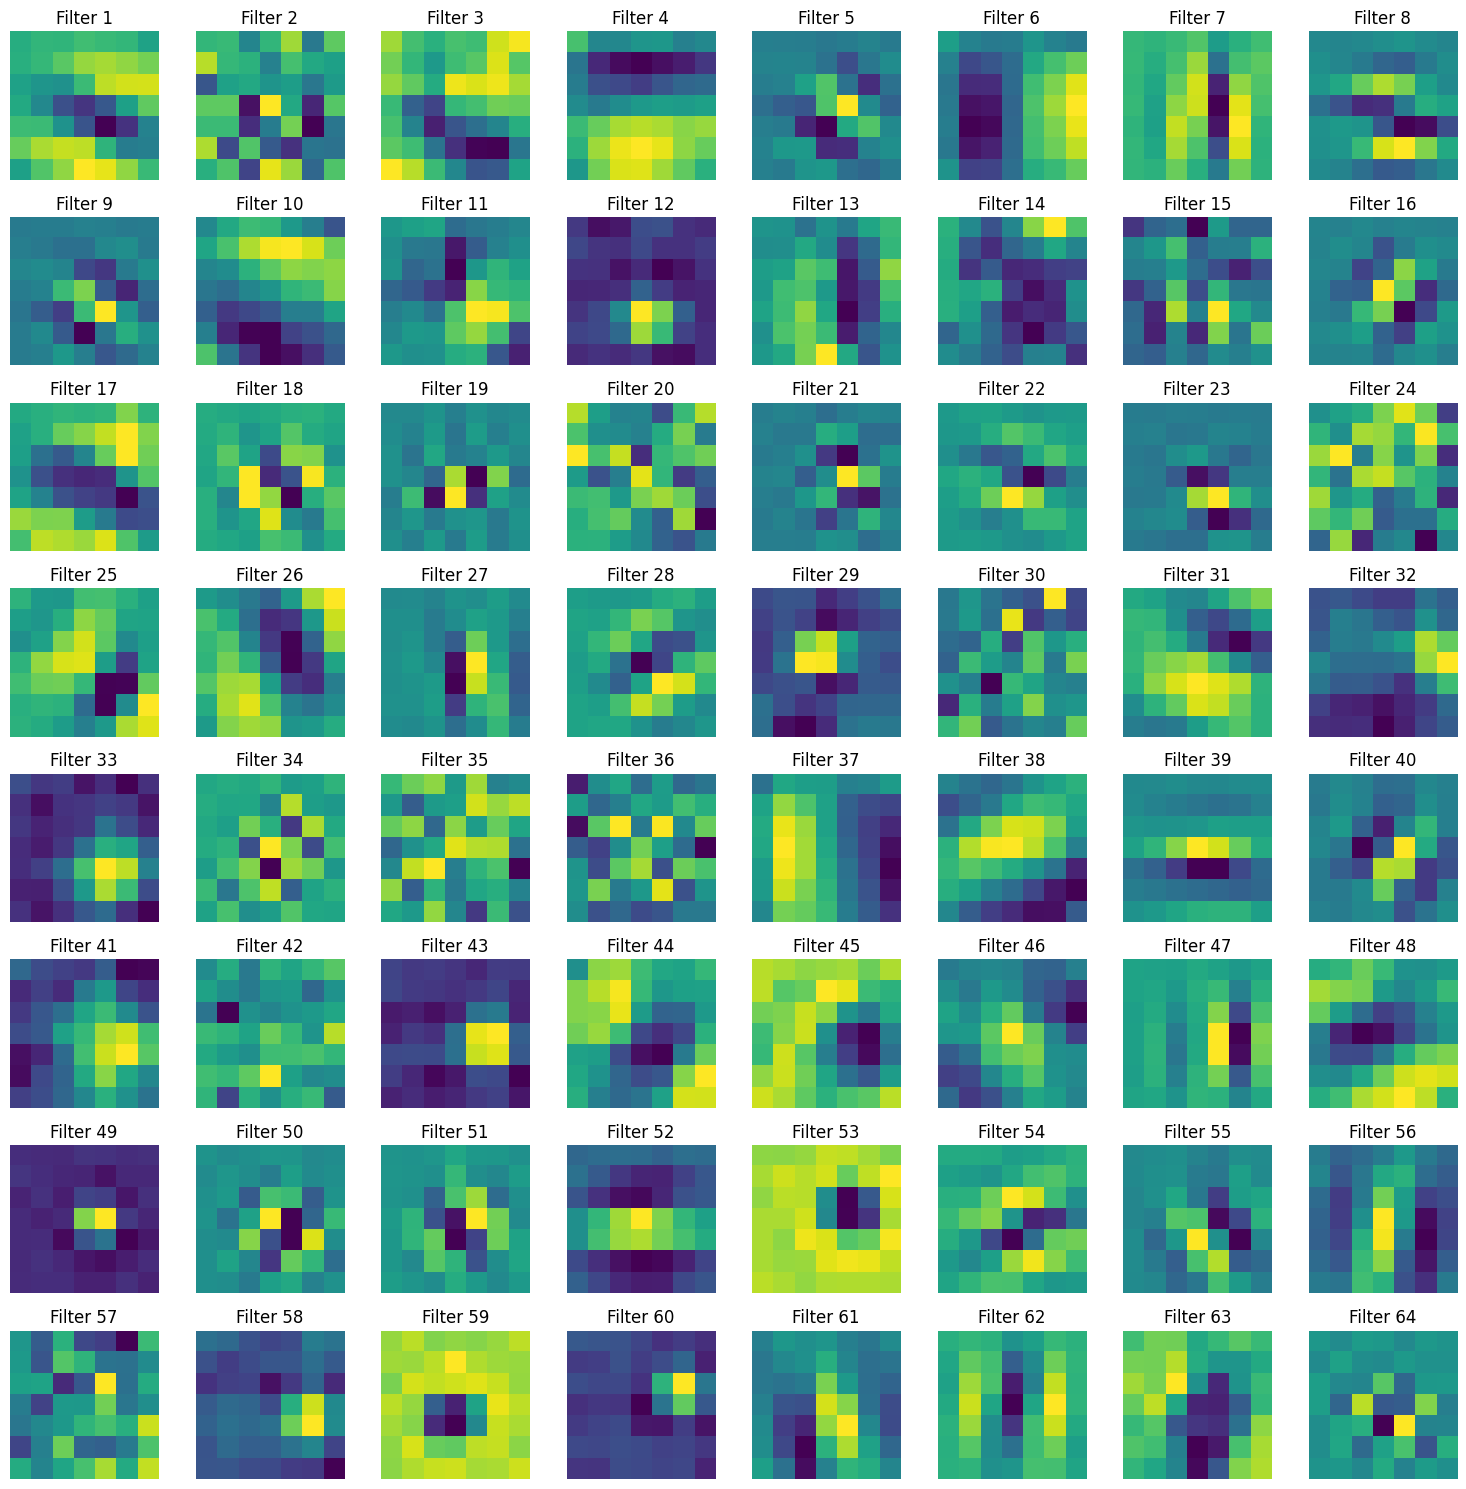

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(filters, num_filters_to_show=64):
    filters = filters.numpy() 
    num_filters = min(filters.shape[0], num_filters_to_show)  
    num_columns = 8 
    num_rows = (num_filters + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_filters):
        filter_image = filters[i].mean(axis=0) 
        axes[i].imshow(filter_image, cmap="viridis") 
        axes[i].axis("off")
        axes[i].set_title(f"Filter {i+1}")

    for i in range(num_filters, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_filters(model.conv1.weight.data.cpu(), num_filters_to_show=64)

Visualizing filters for conv1


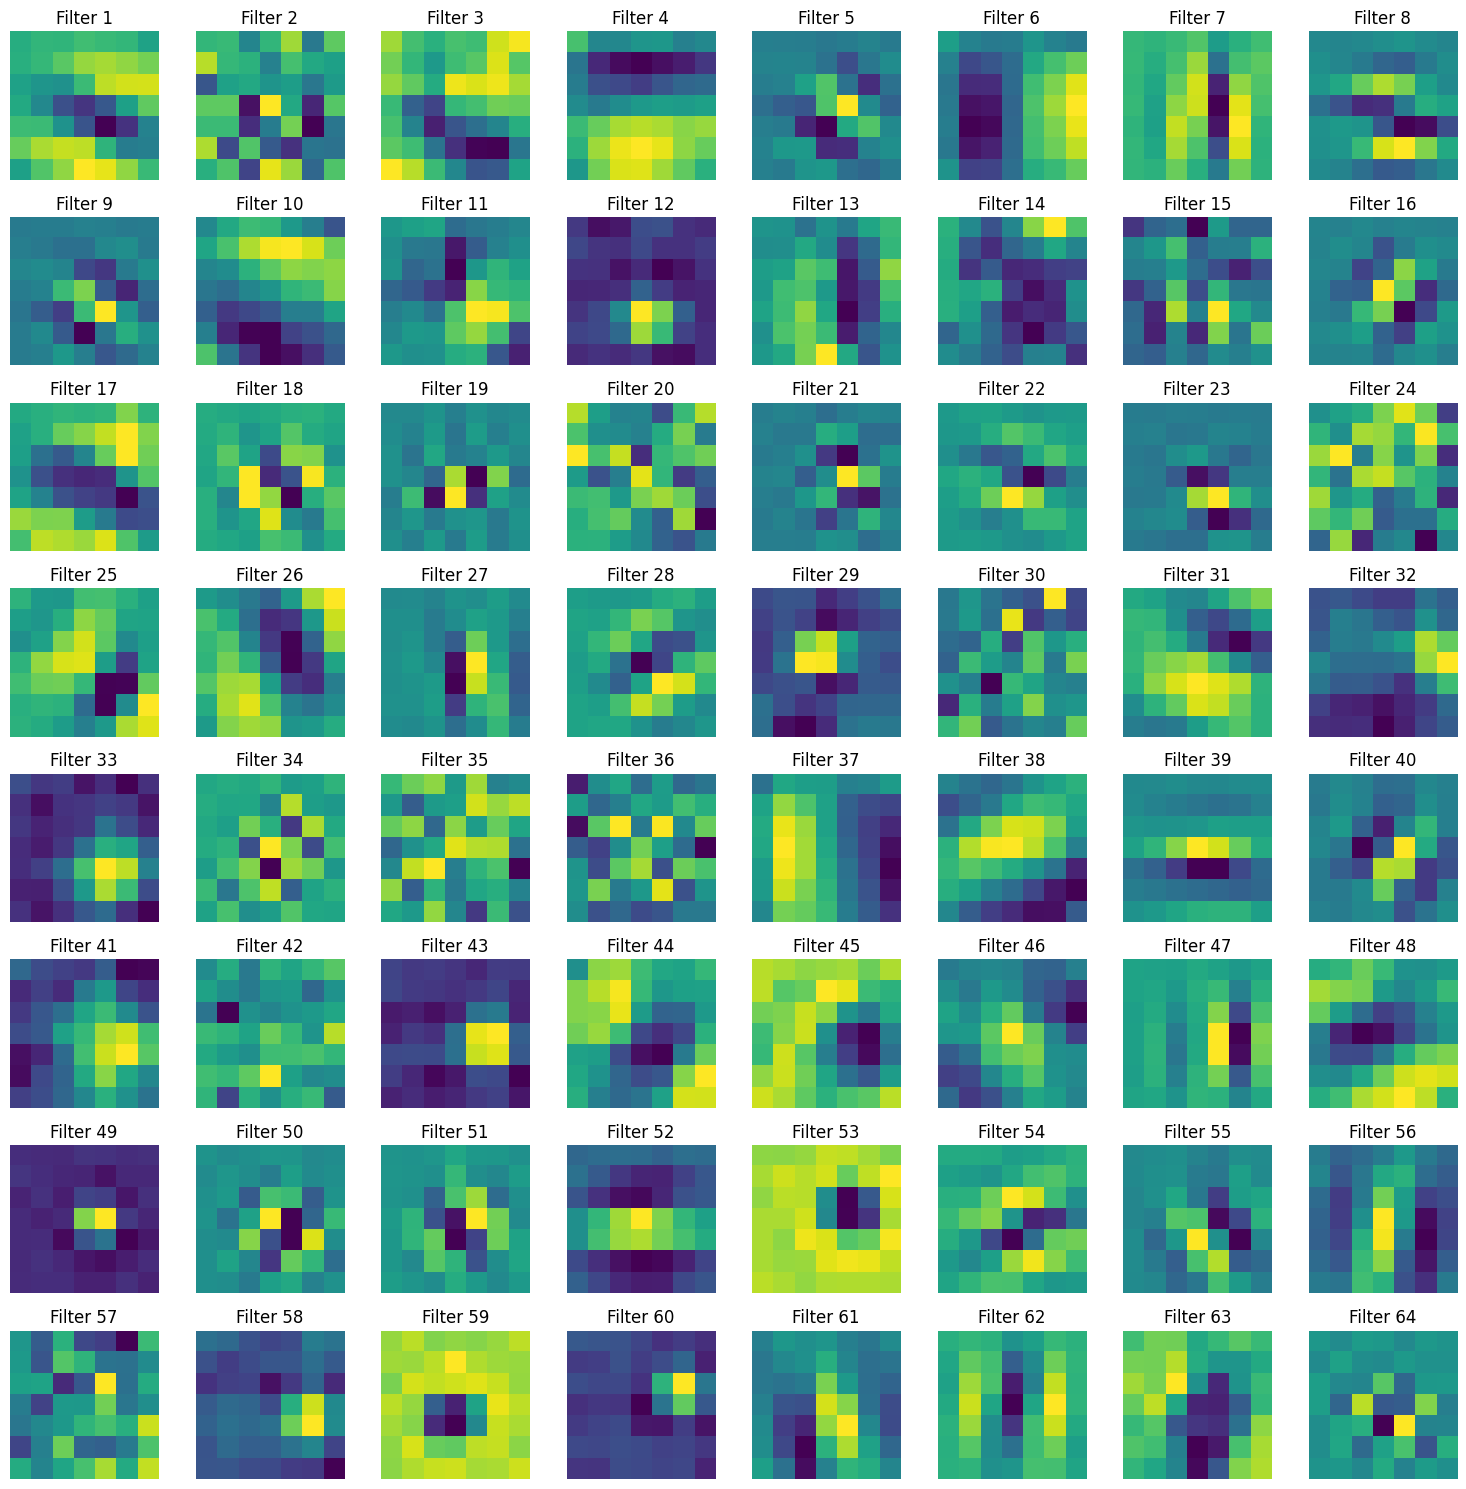

Visualizing filters for layer1.0.conv1


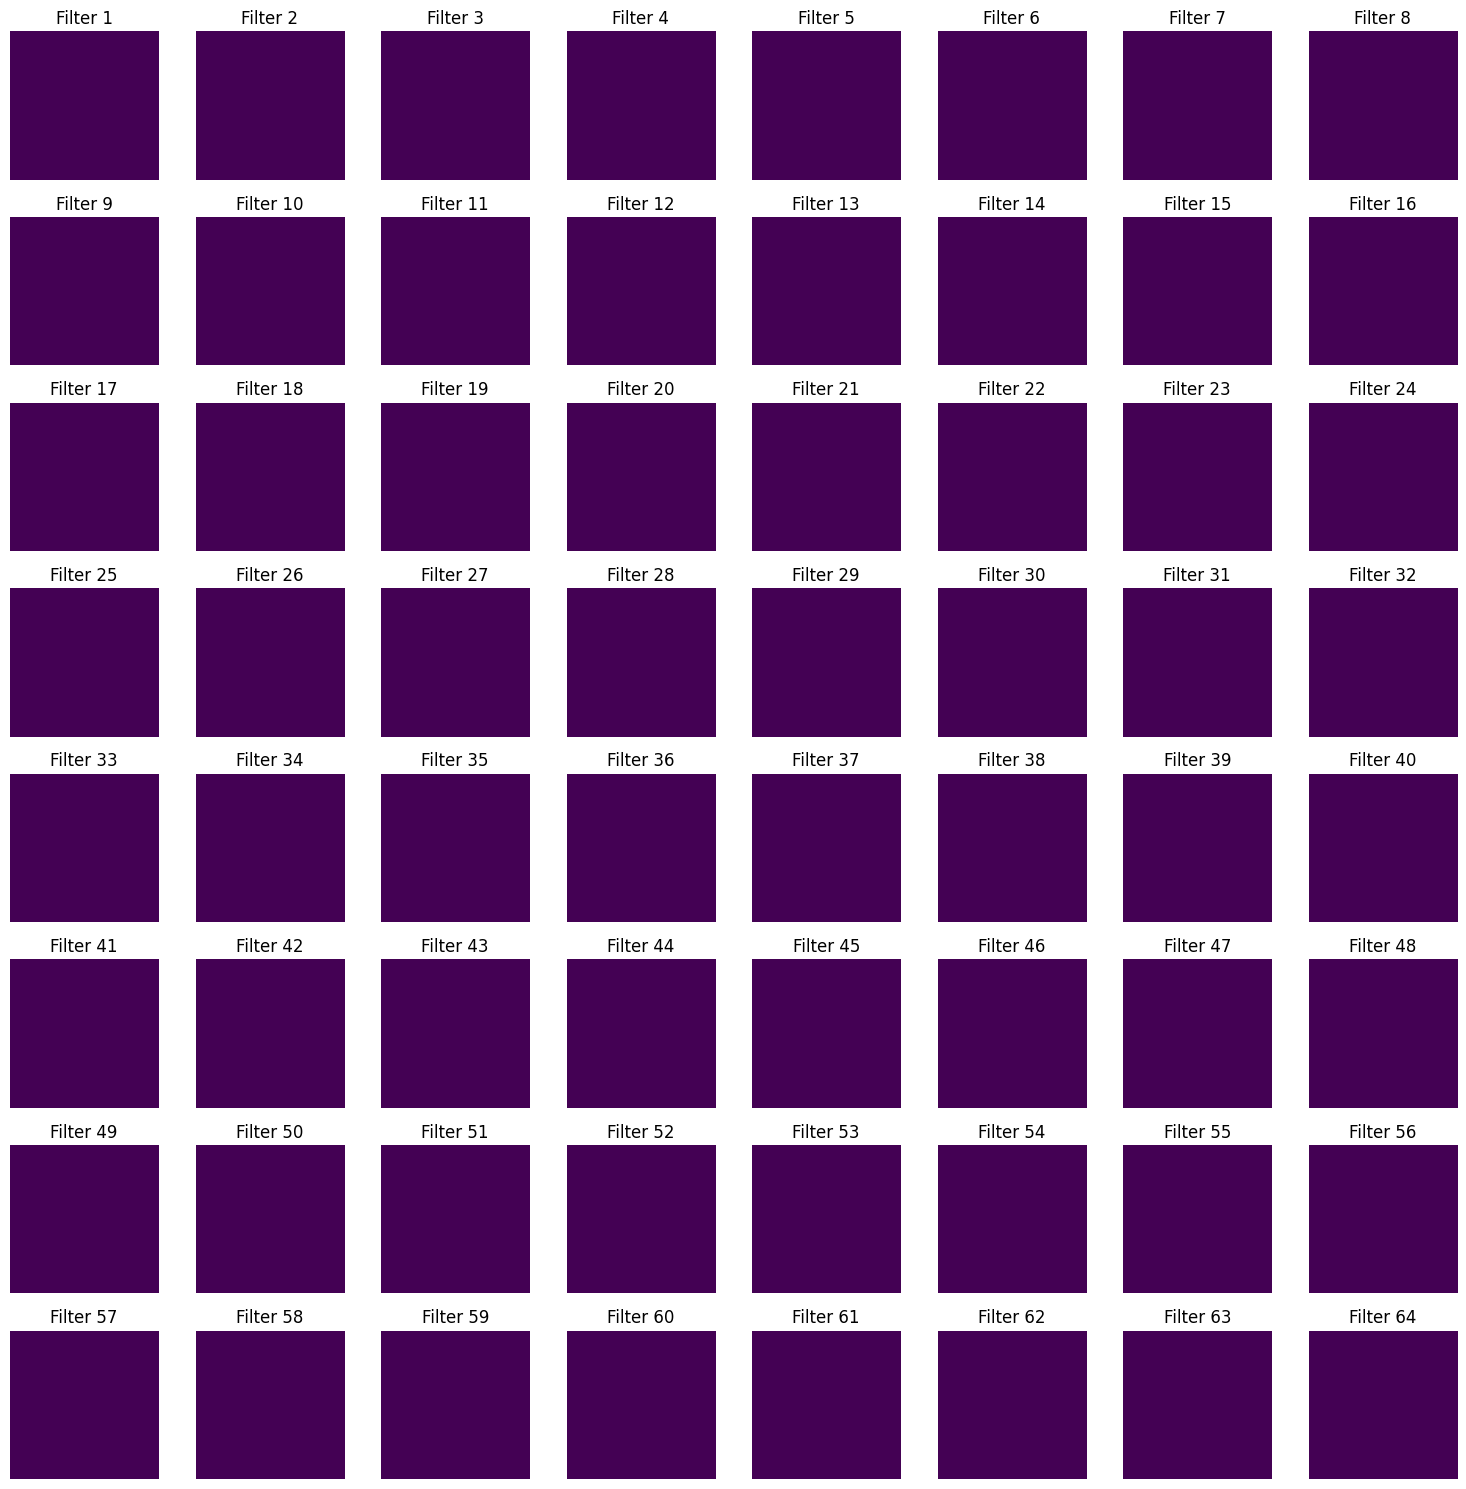

Visualizing filters for layer1.0.conv2


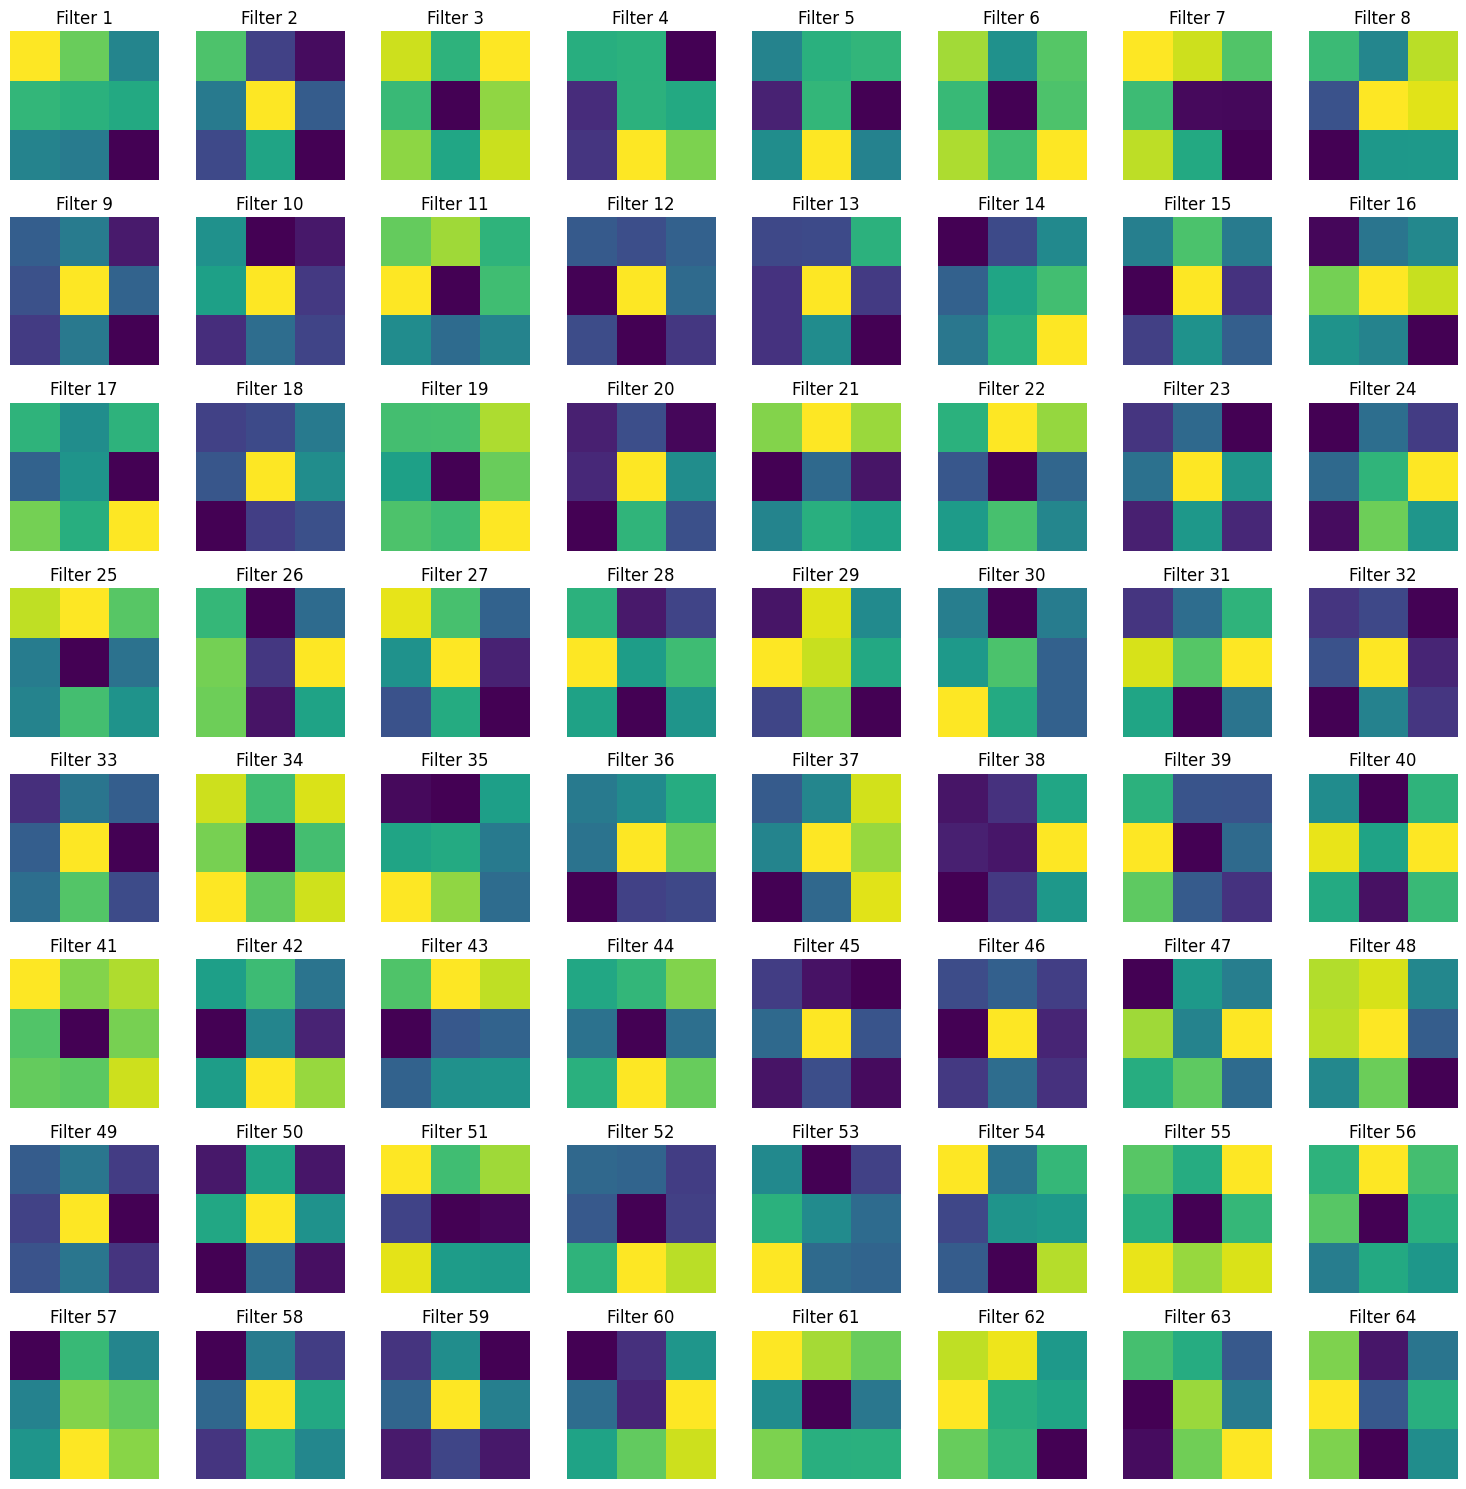

Visualizing filters for layer1.0.conv3


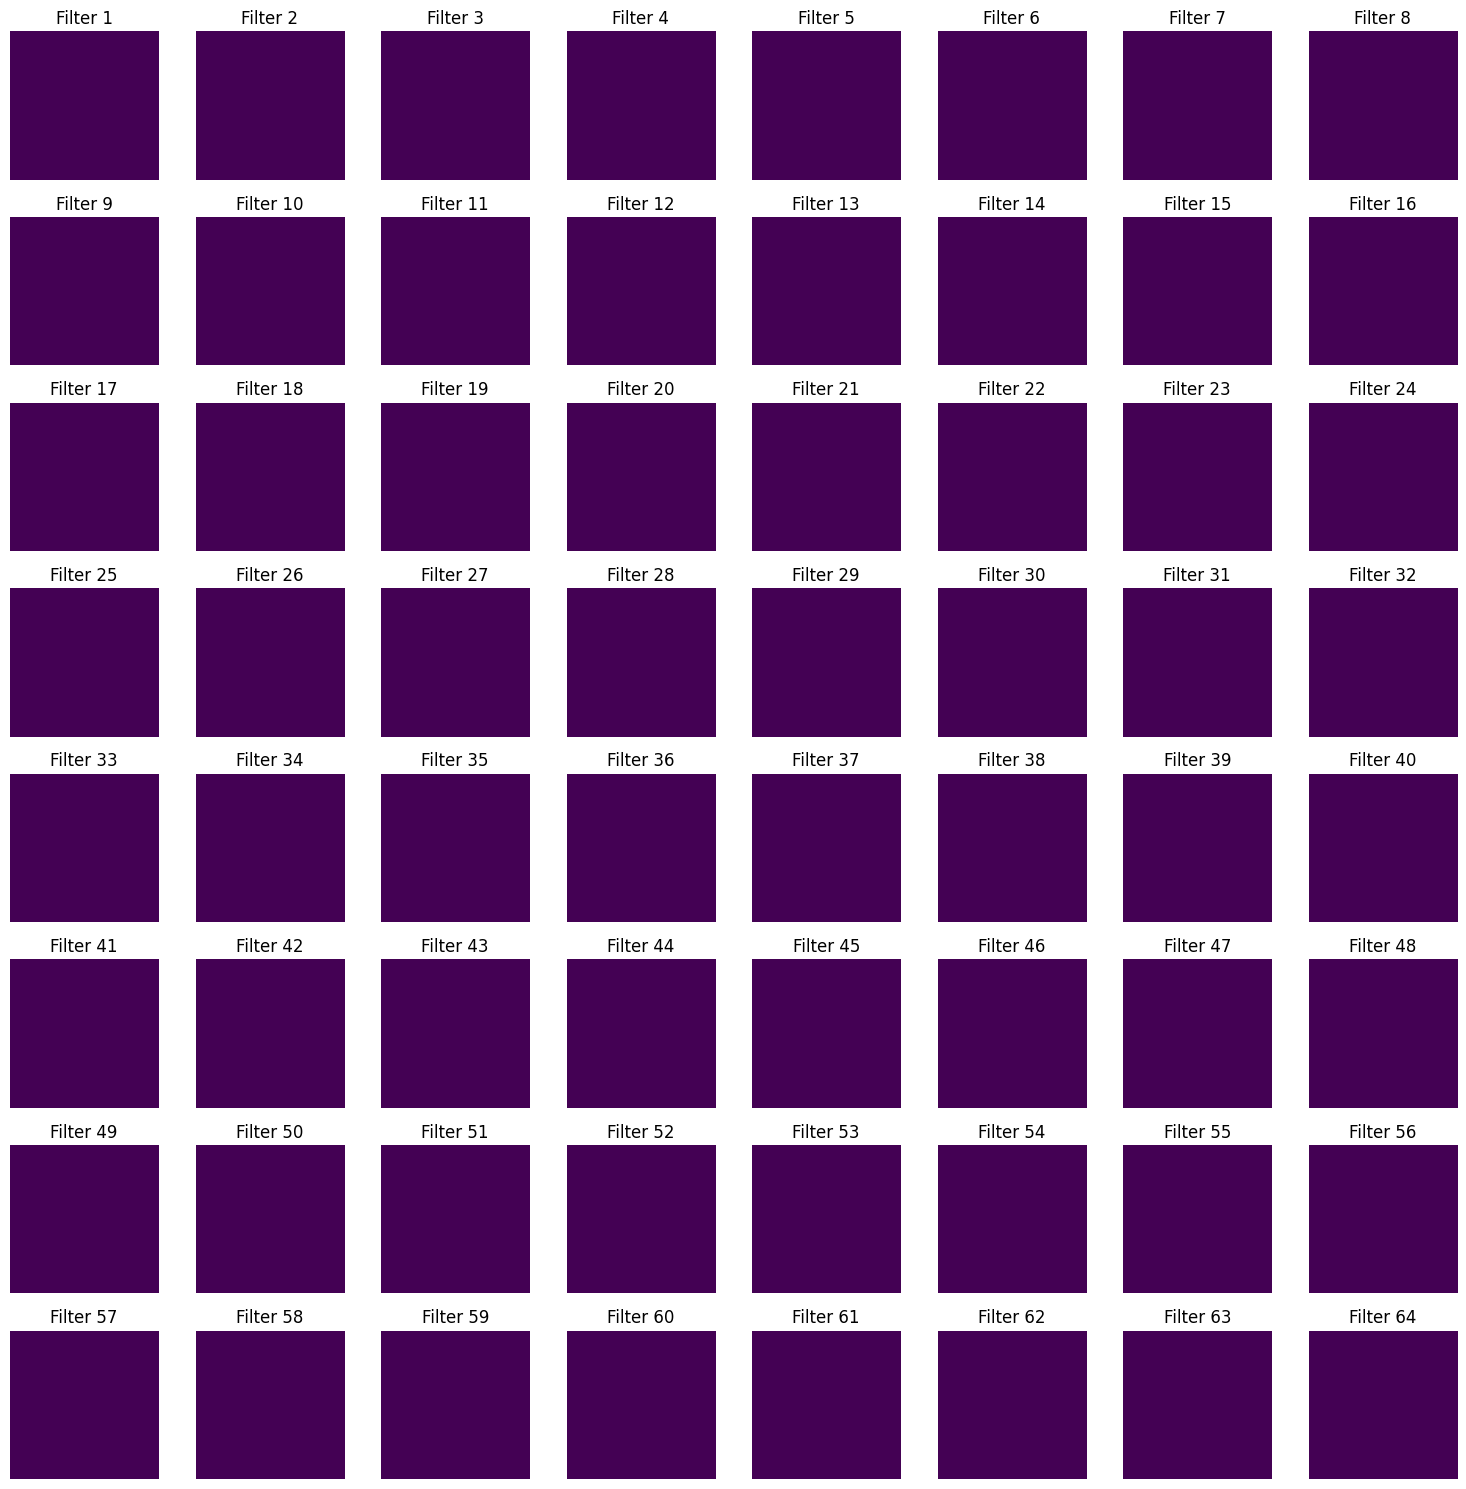

Visualizing filters for layer1.0.downsample.0


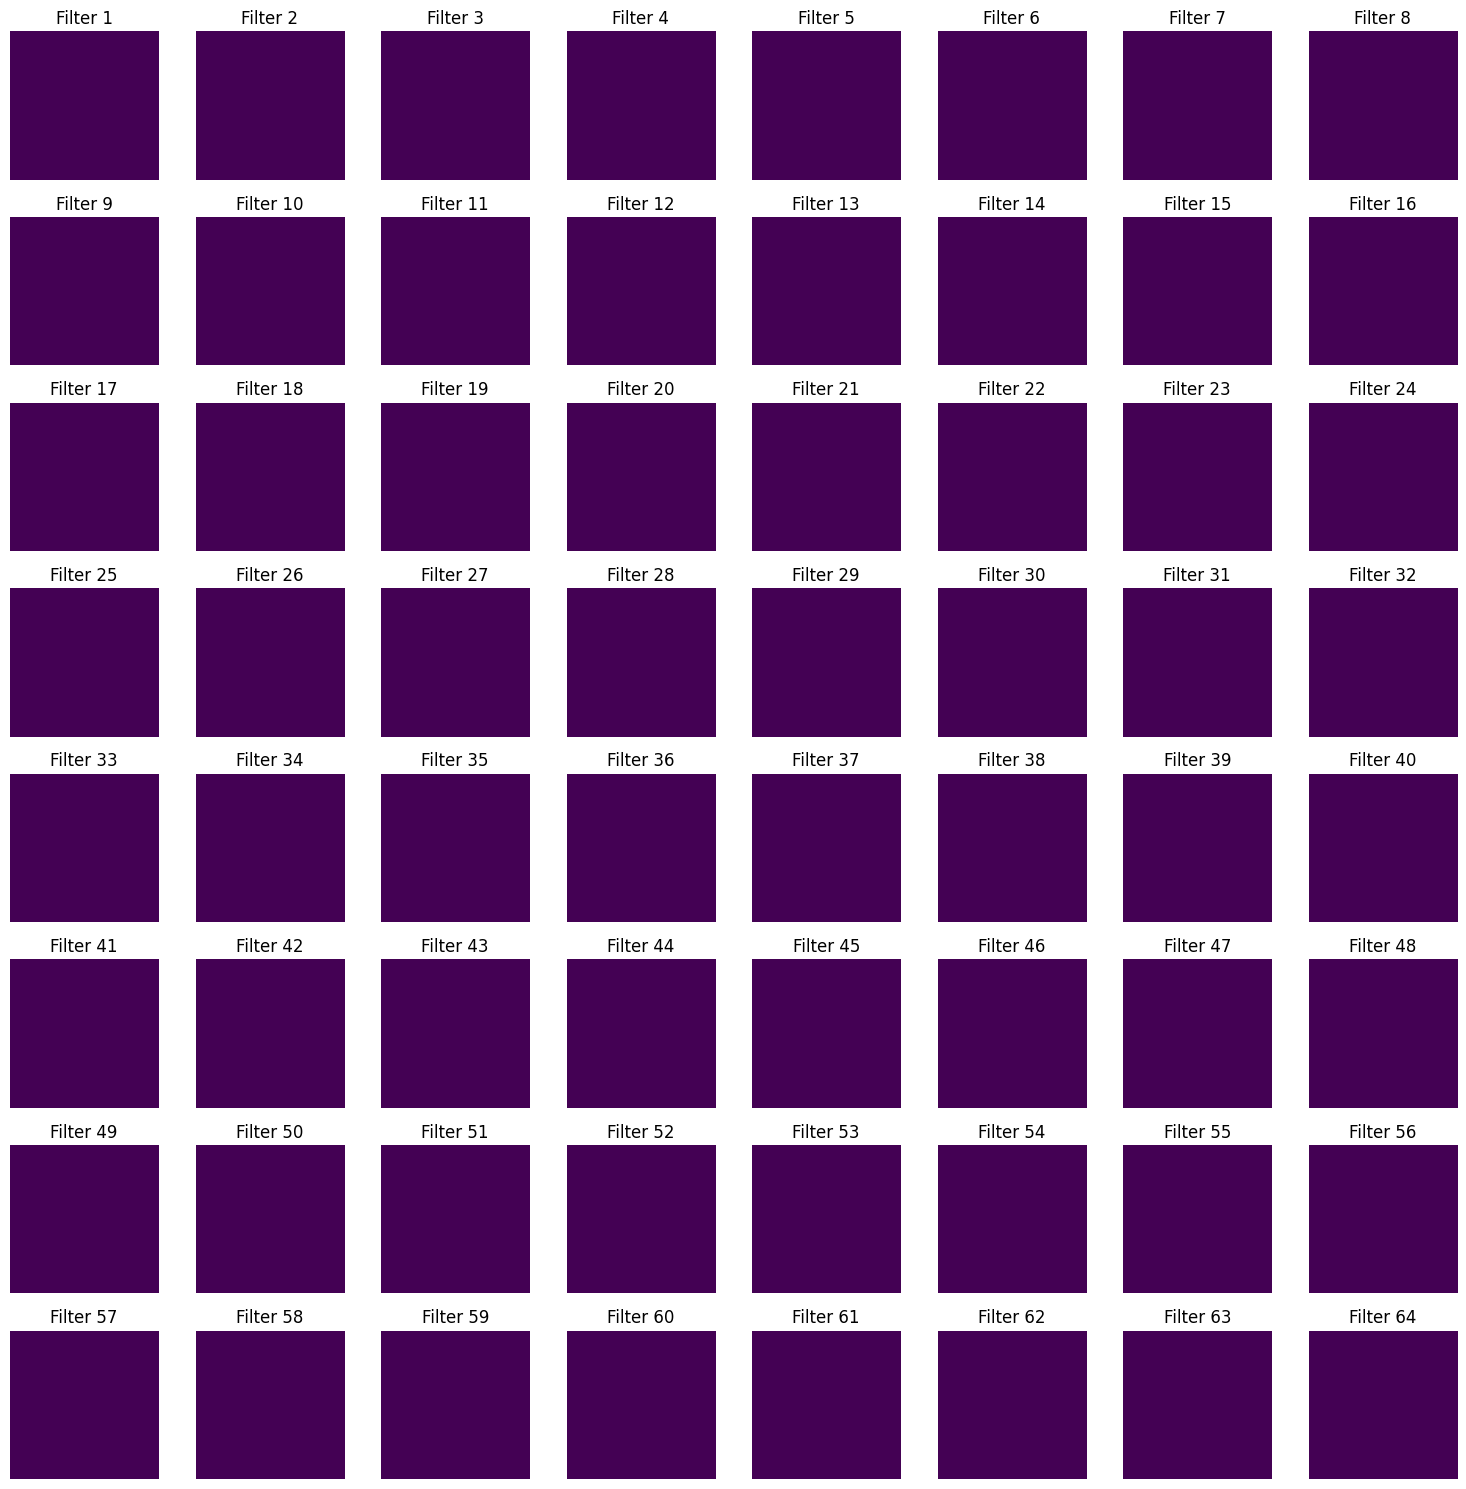

Visualizing filters for layer1.1.conv1


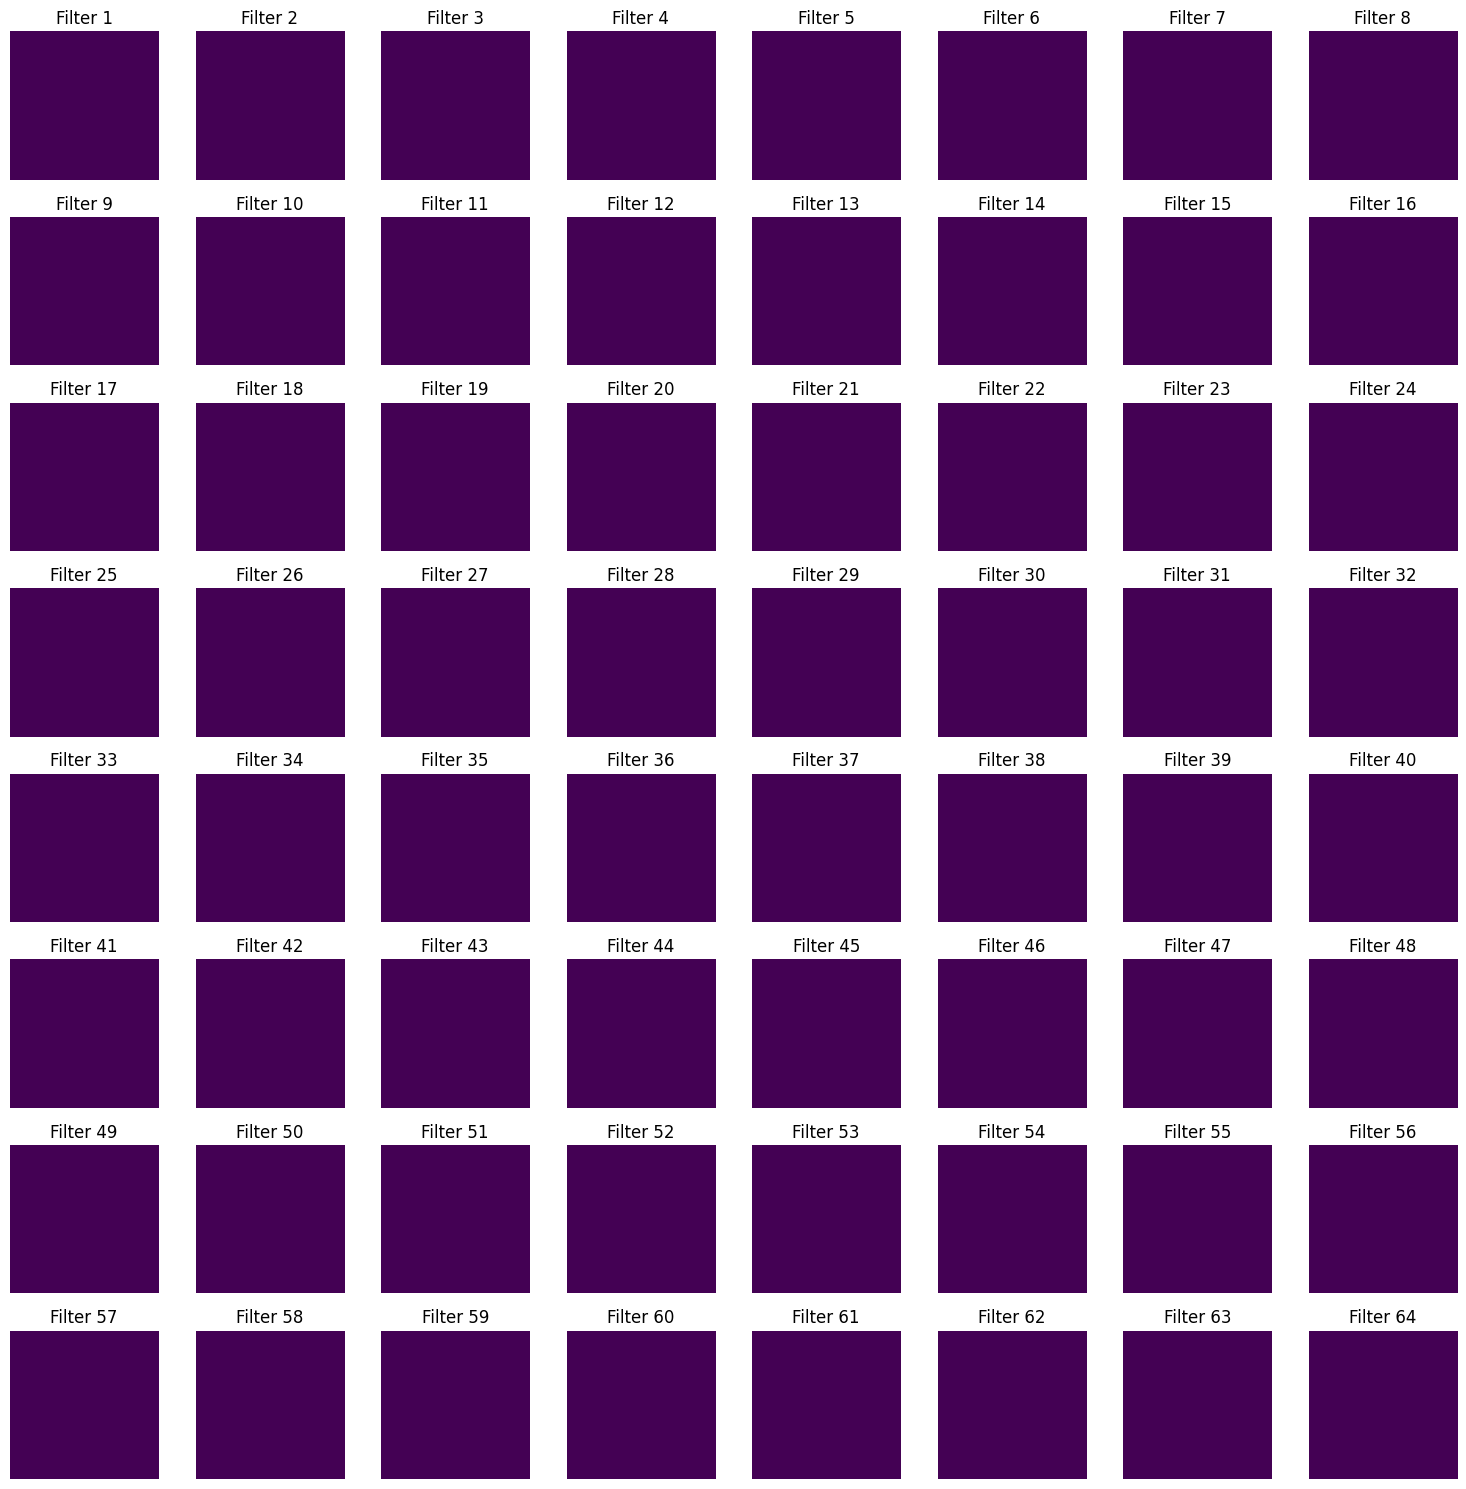

Visualizing filters for layer1.1.conv2


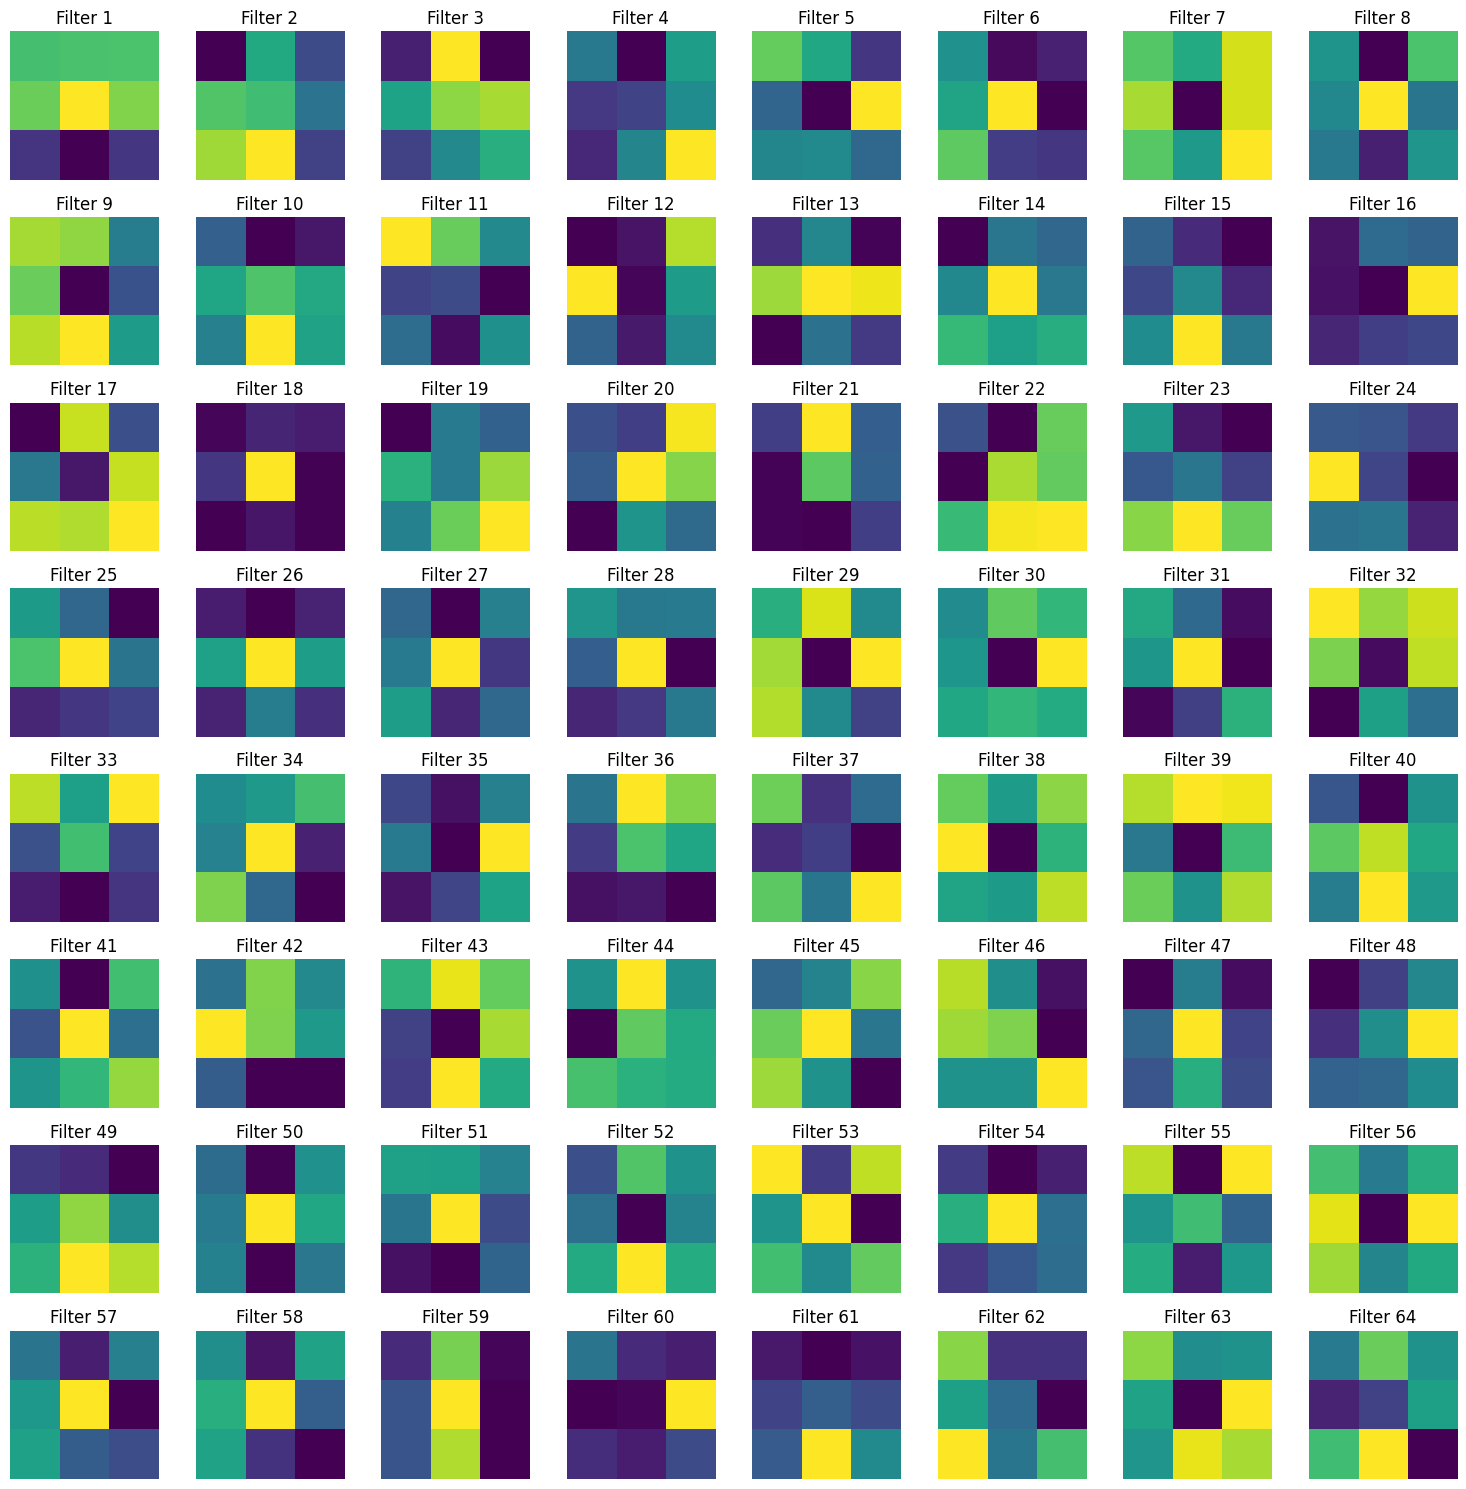

Visualizing filters for layer1.1.conv3


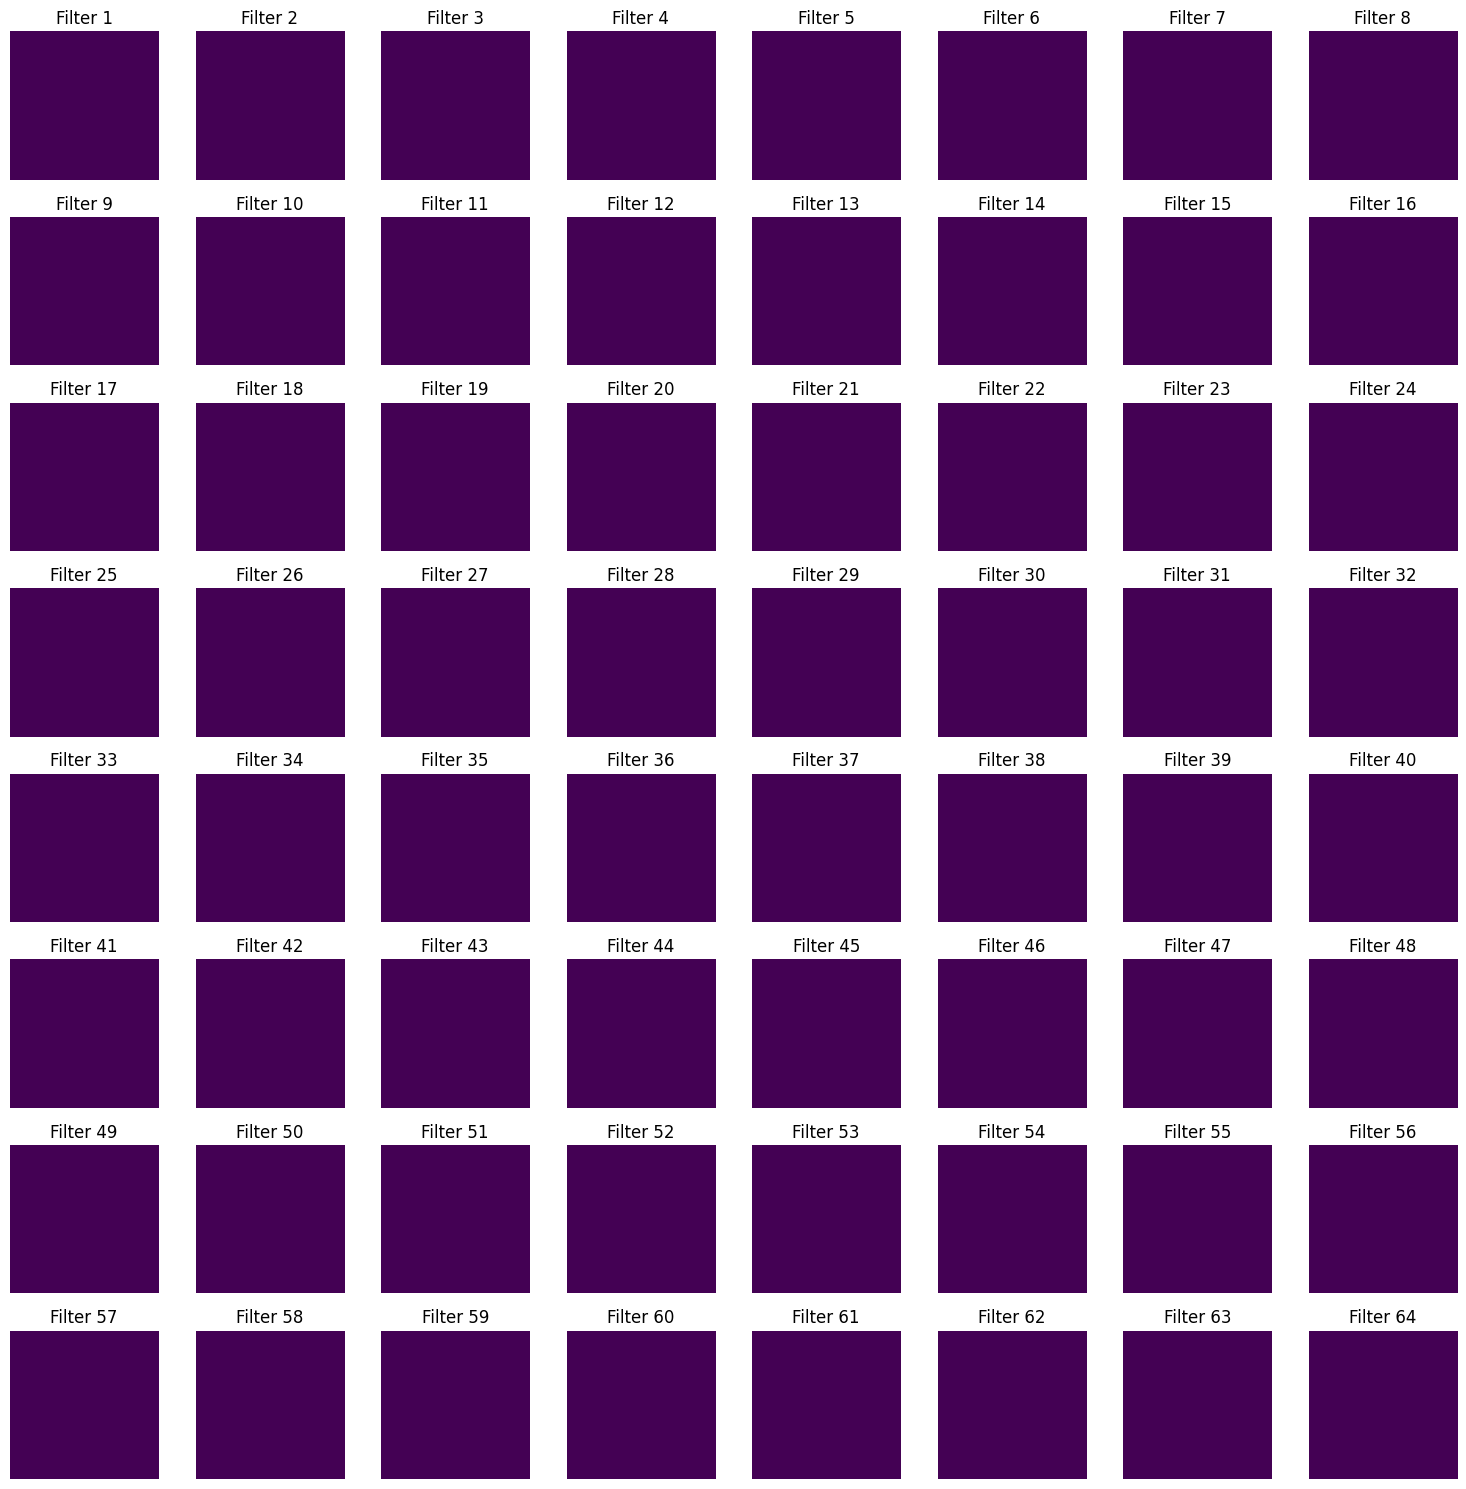

Visualizing filters for layer1.2.conv1


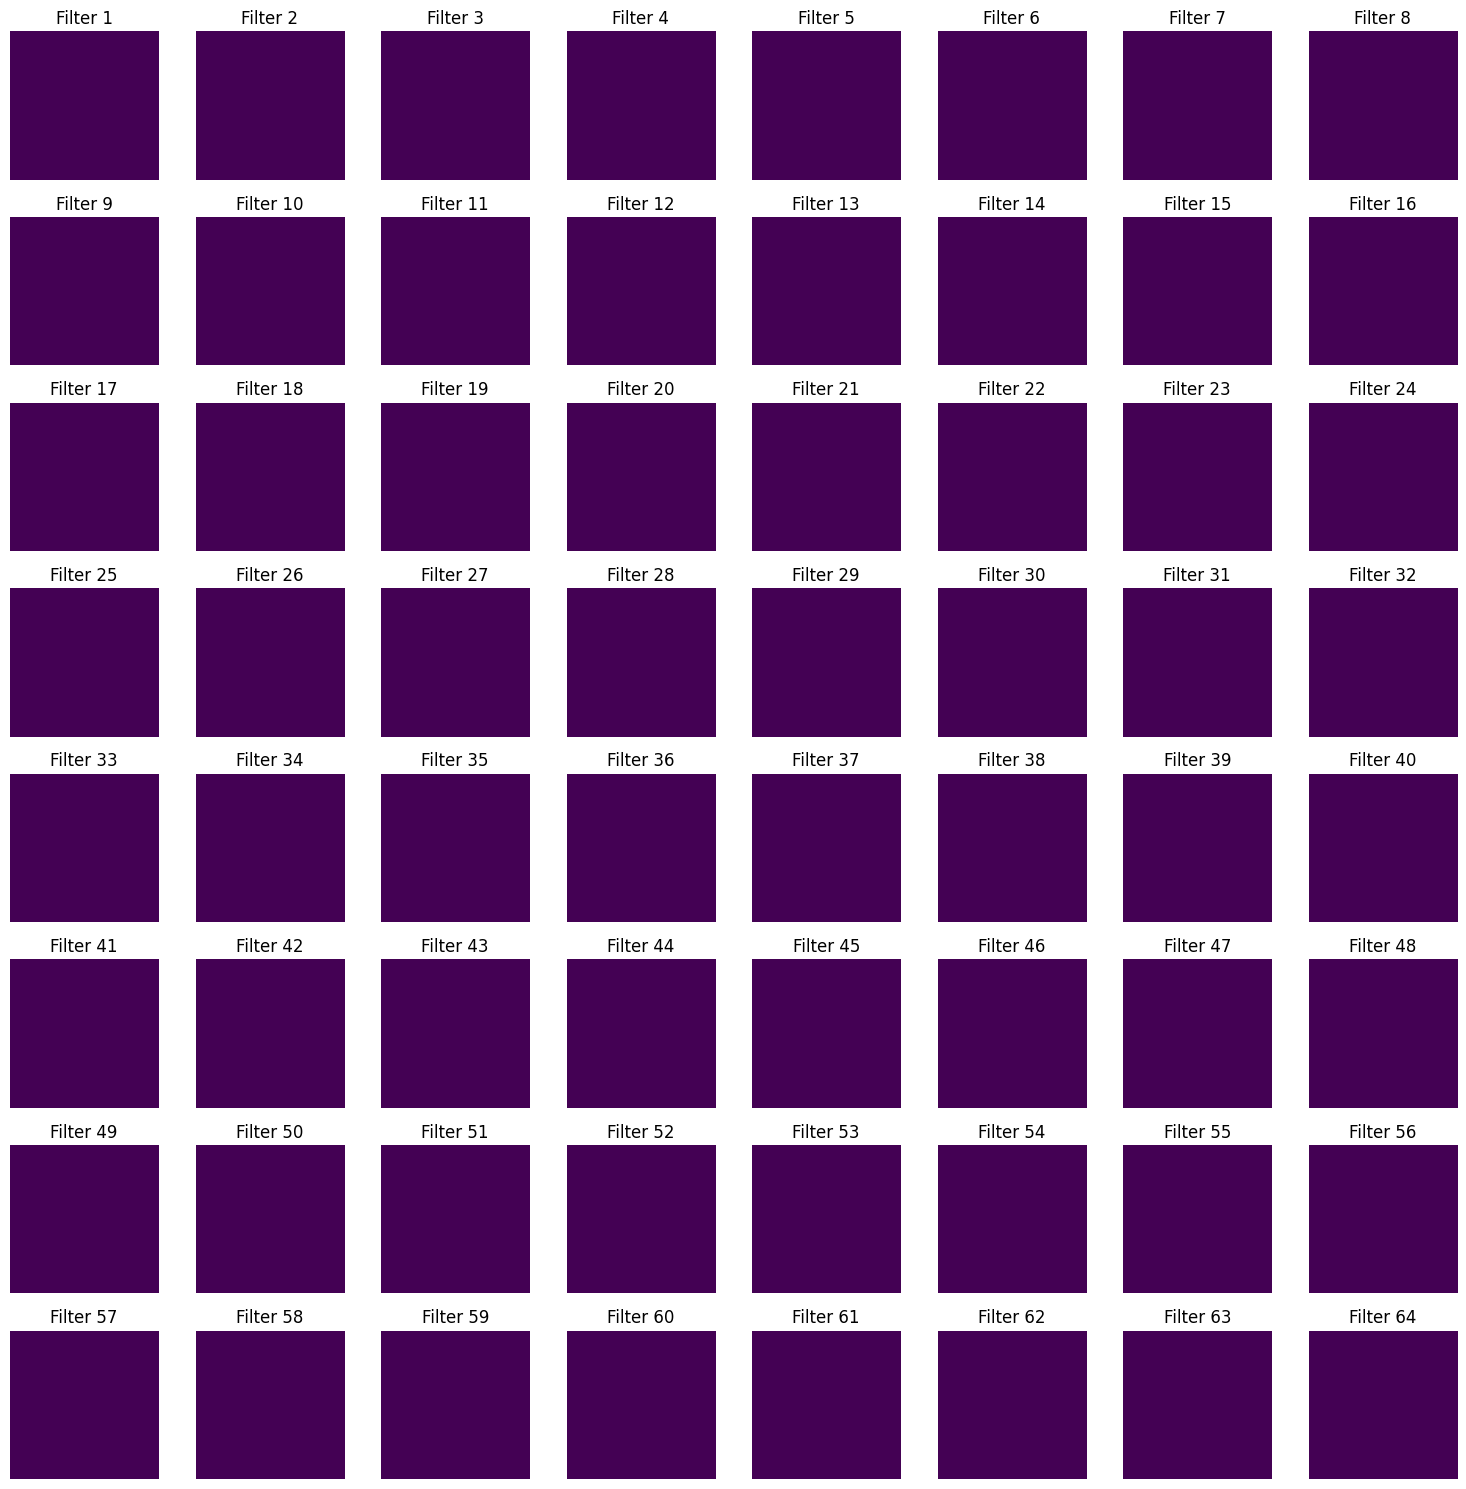

Visualizing filters for layer1.2.conv2


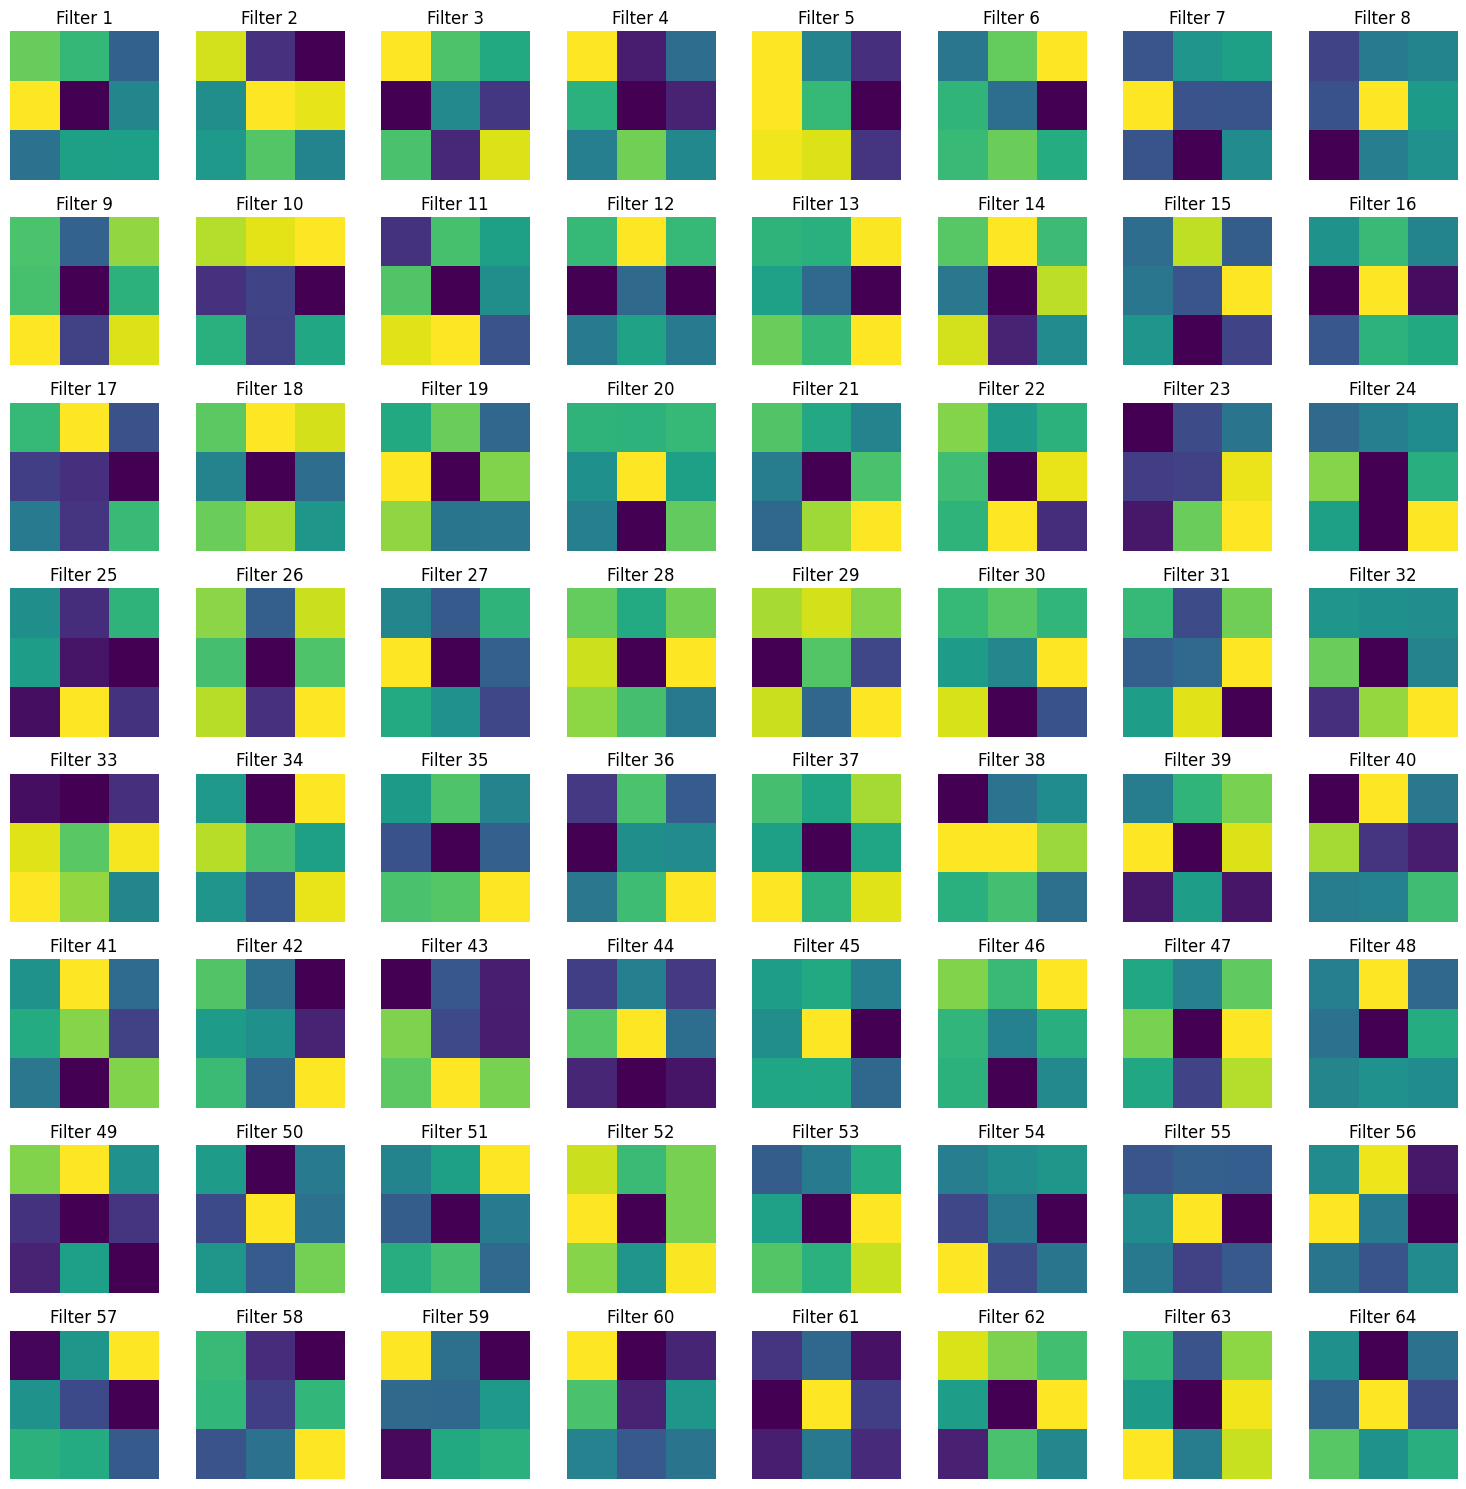

Visualizing filters for layer1.2.conv3


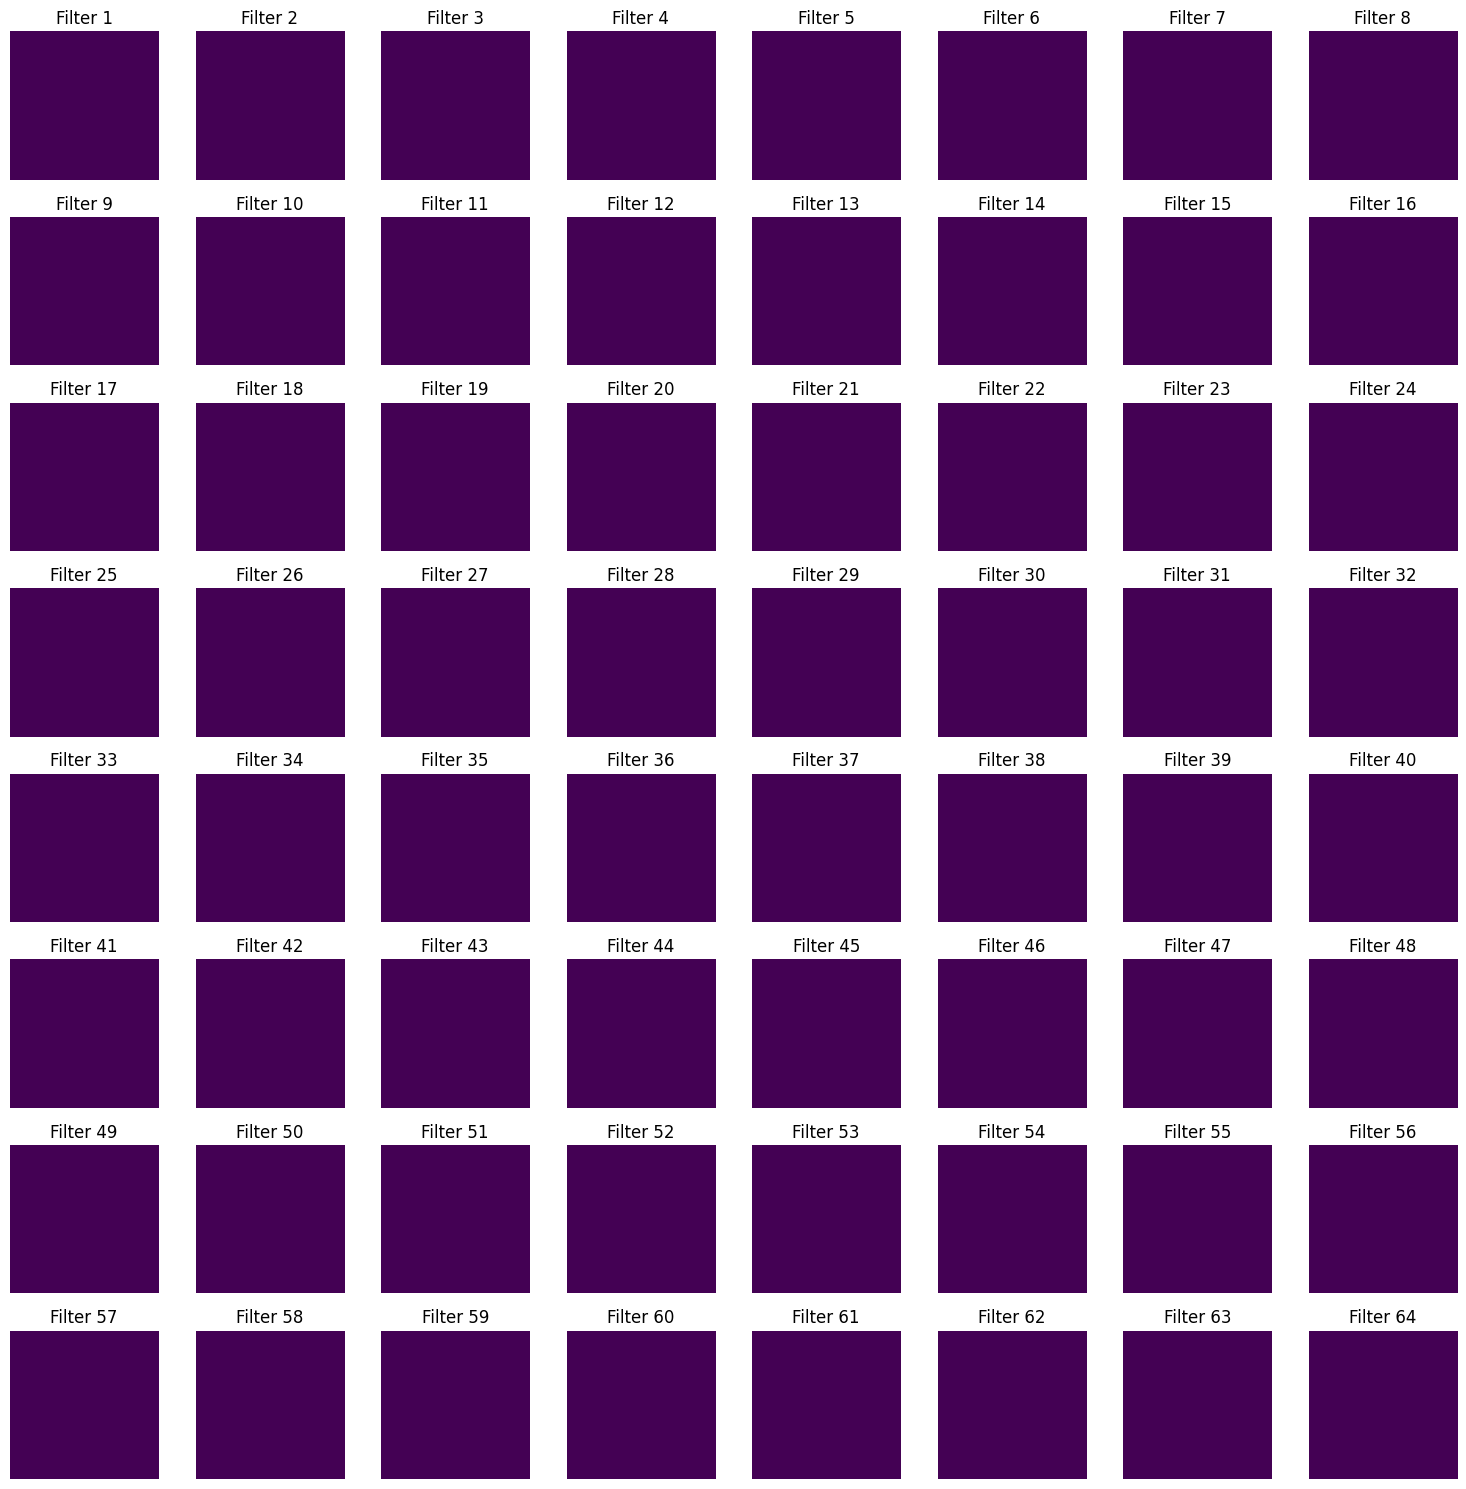

Visualizing filters for layer2.0.conv1


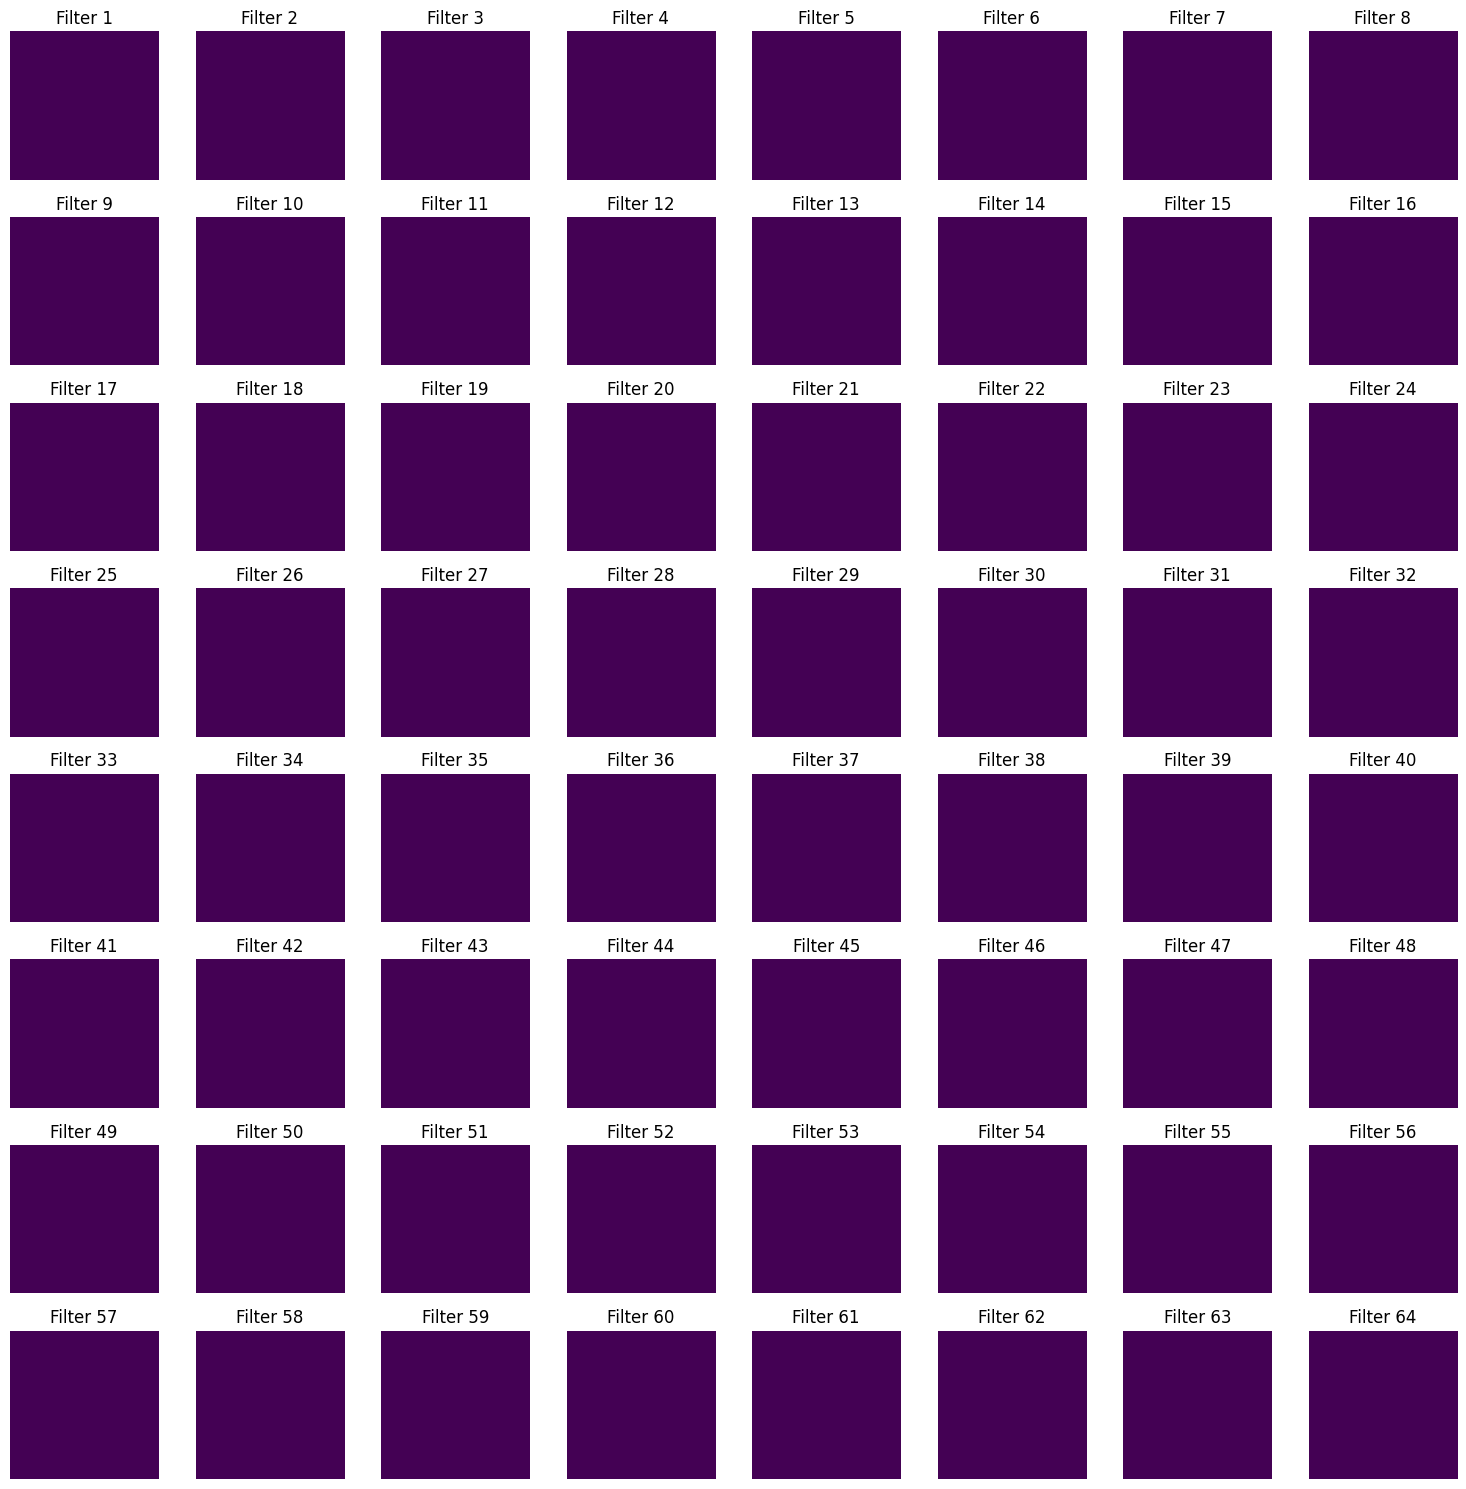

Visualizing filters for layer2.0.conv2


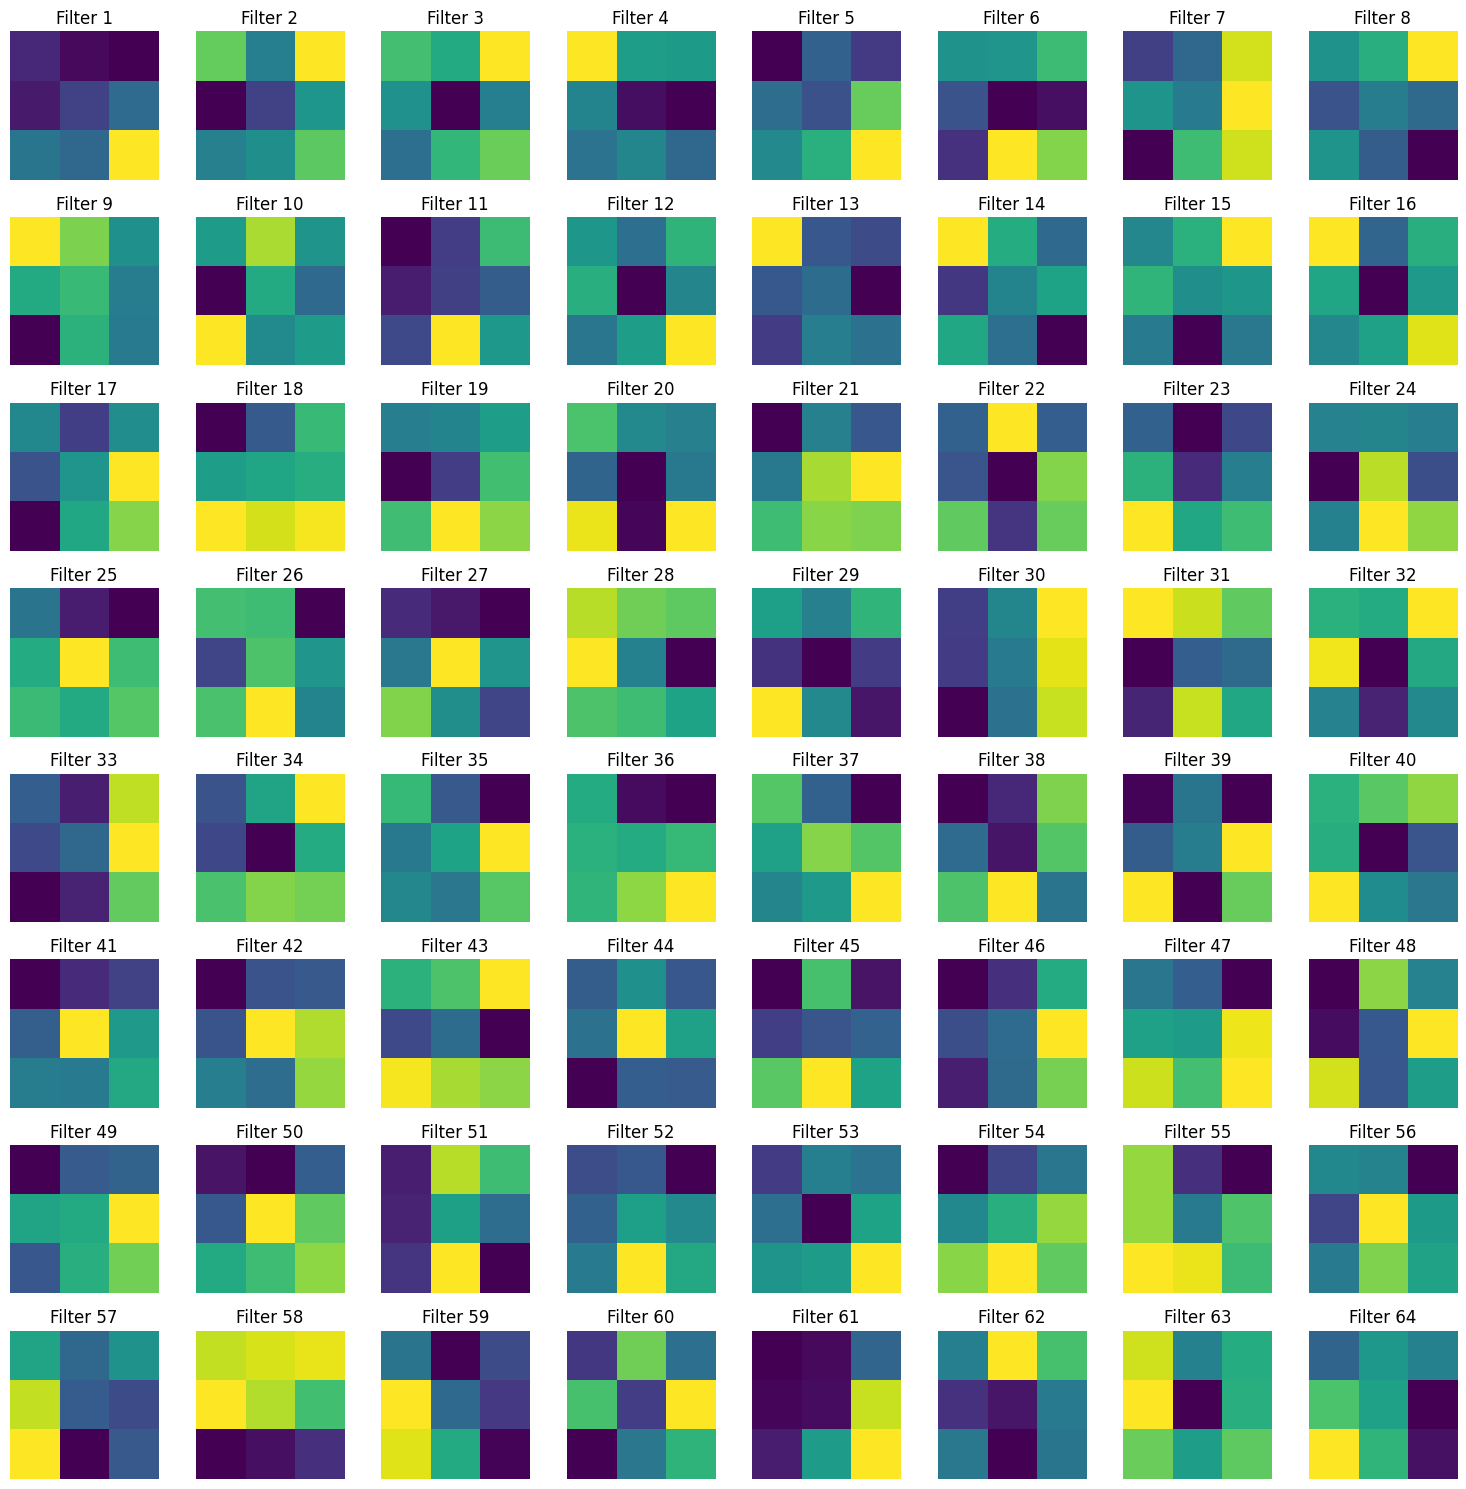

Visualizing filters for layer2.0.conv3


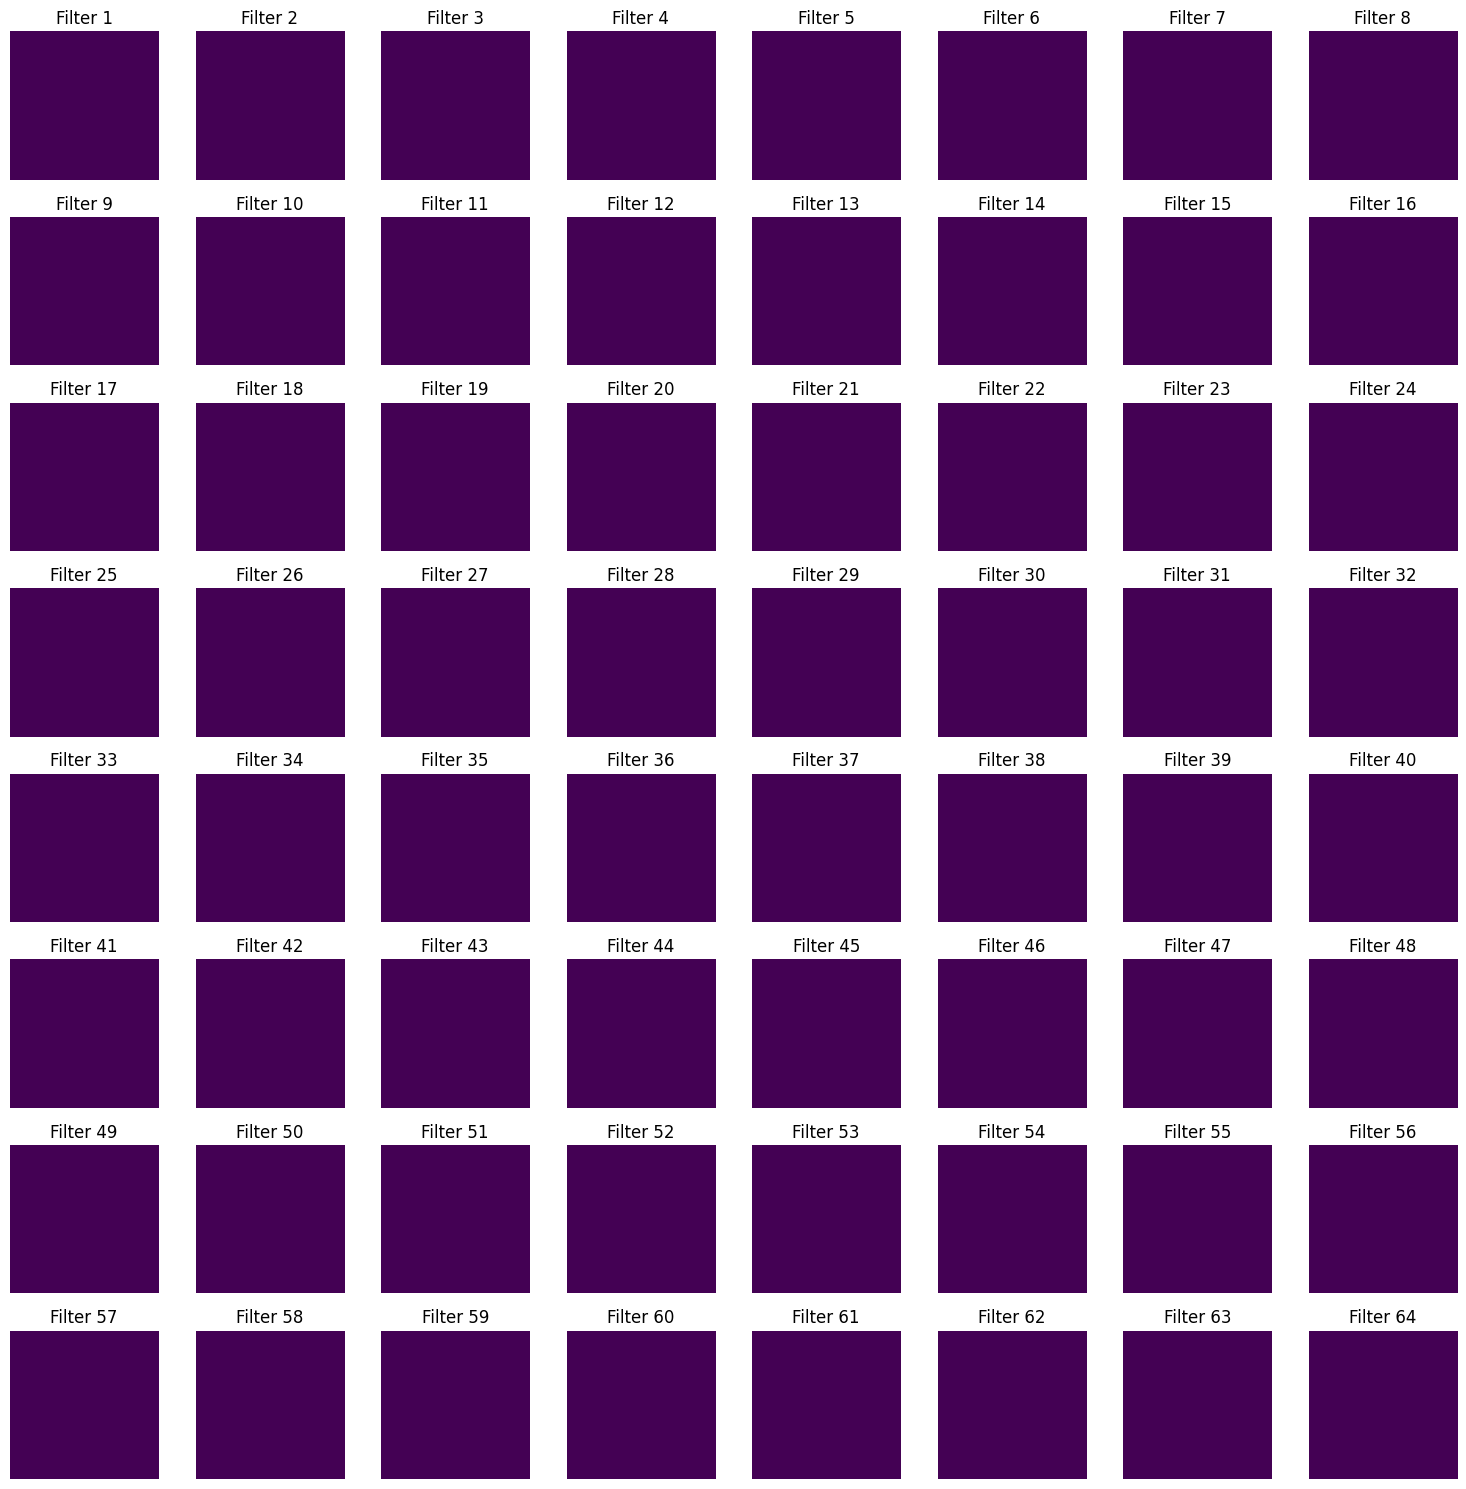

Visualizing filters for layer2.0.downsample.0


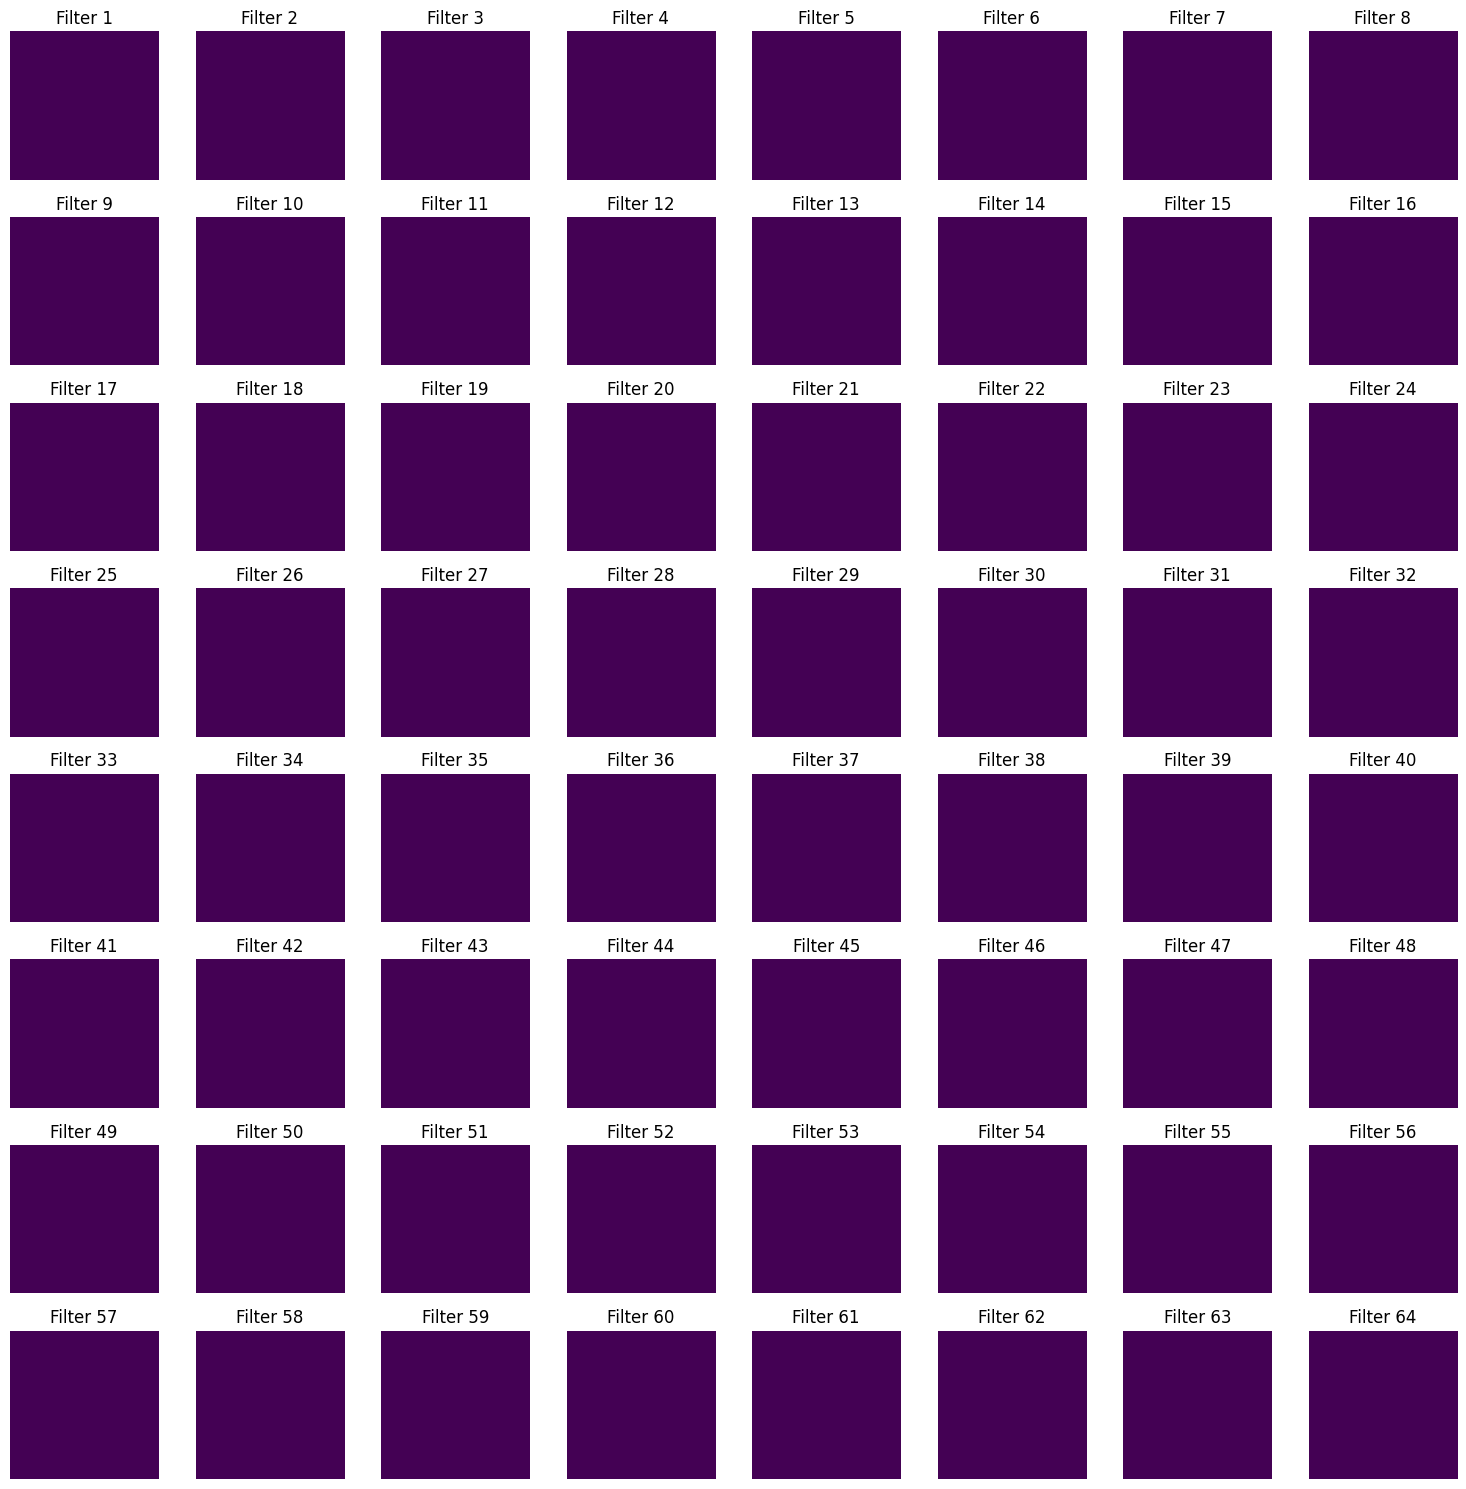

Visualizing filters for layer2.1.conv1


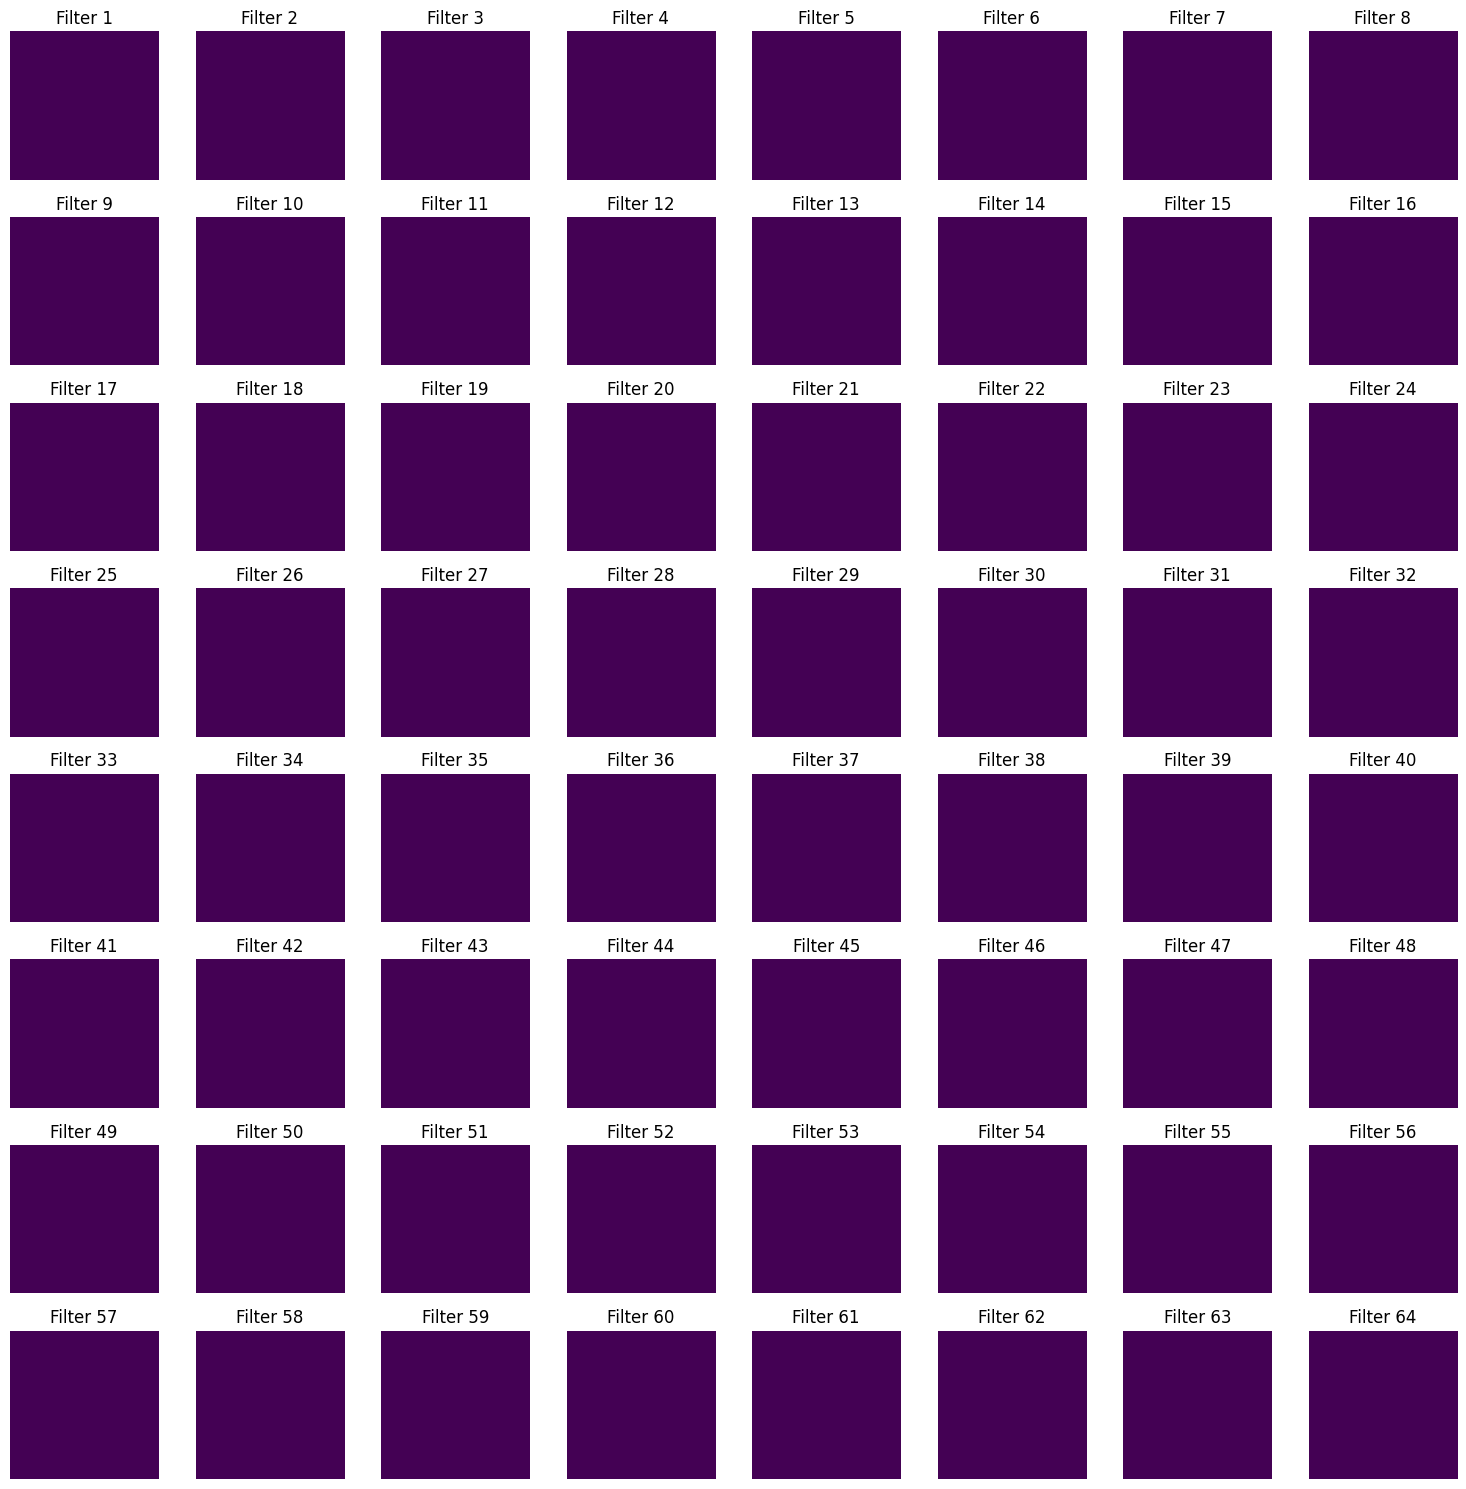

Visualizing filters for layer2.1.conv2


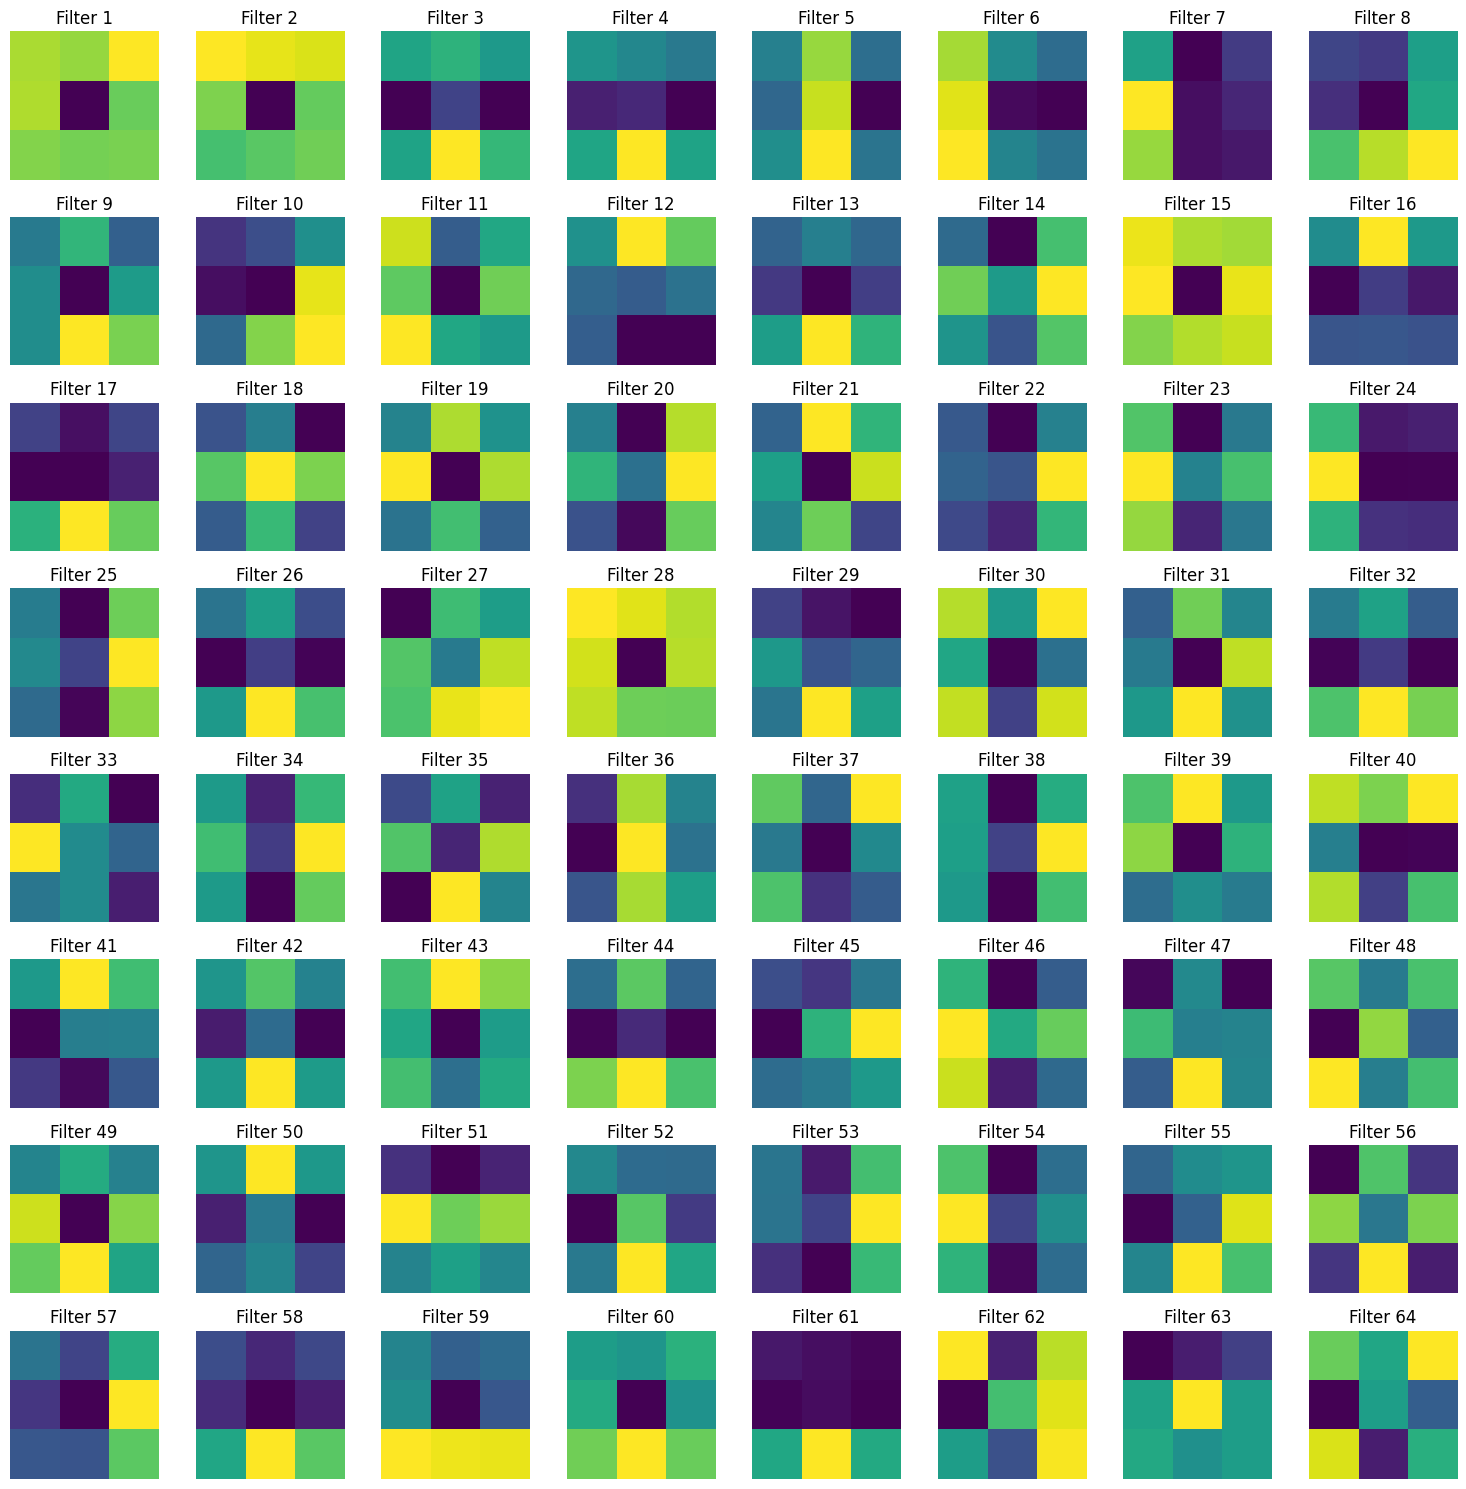

Visualizing filters for layer2.1.conv3


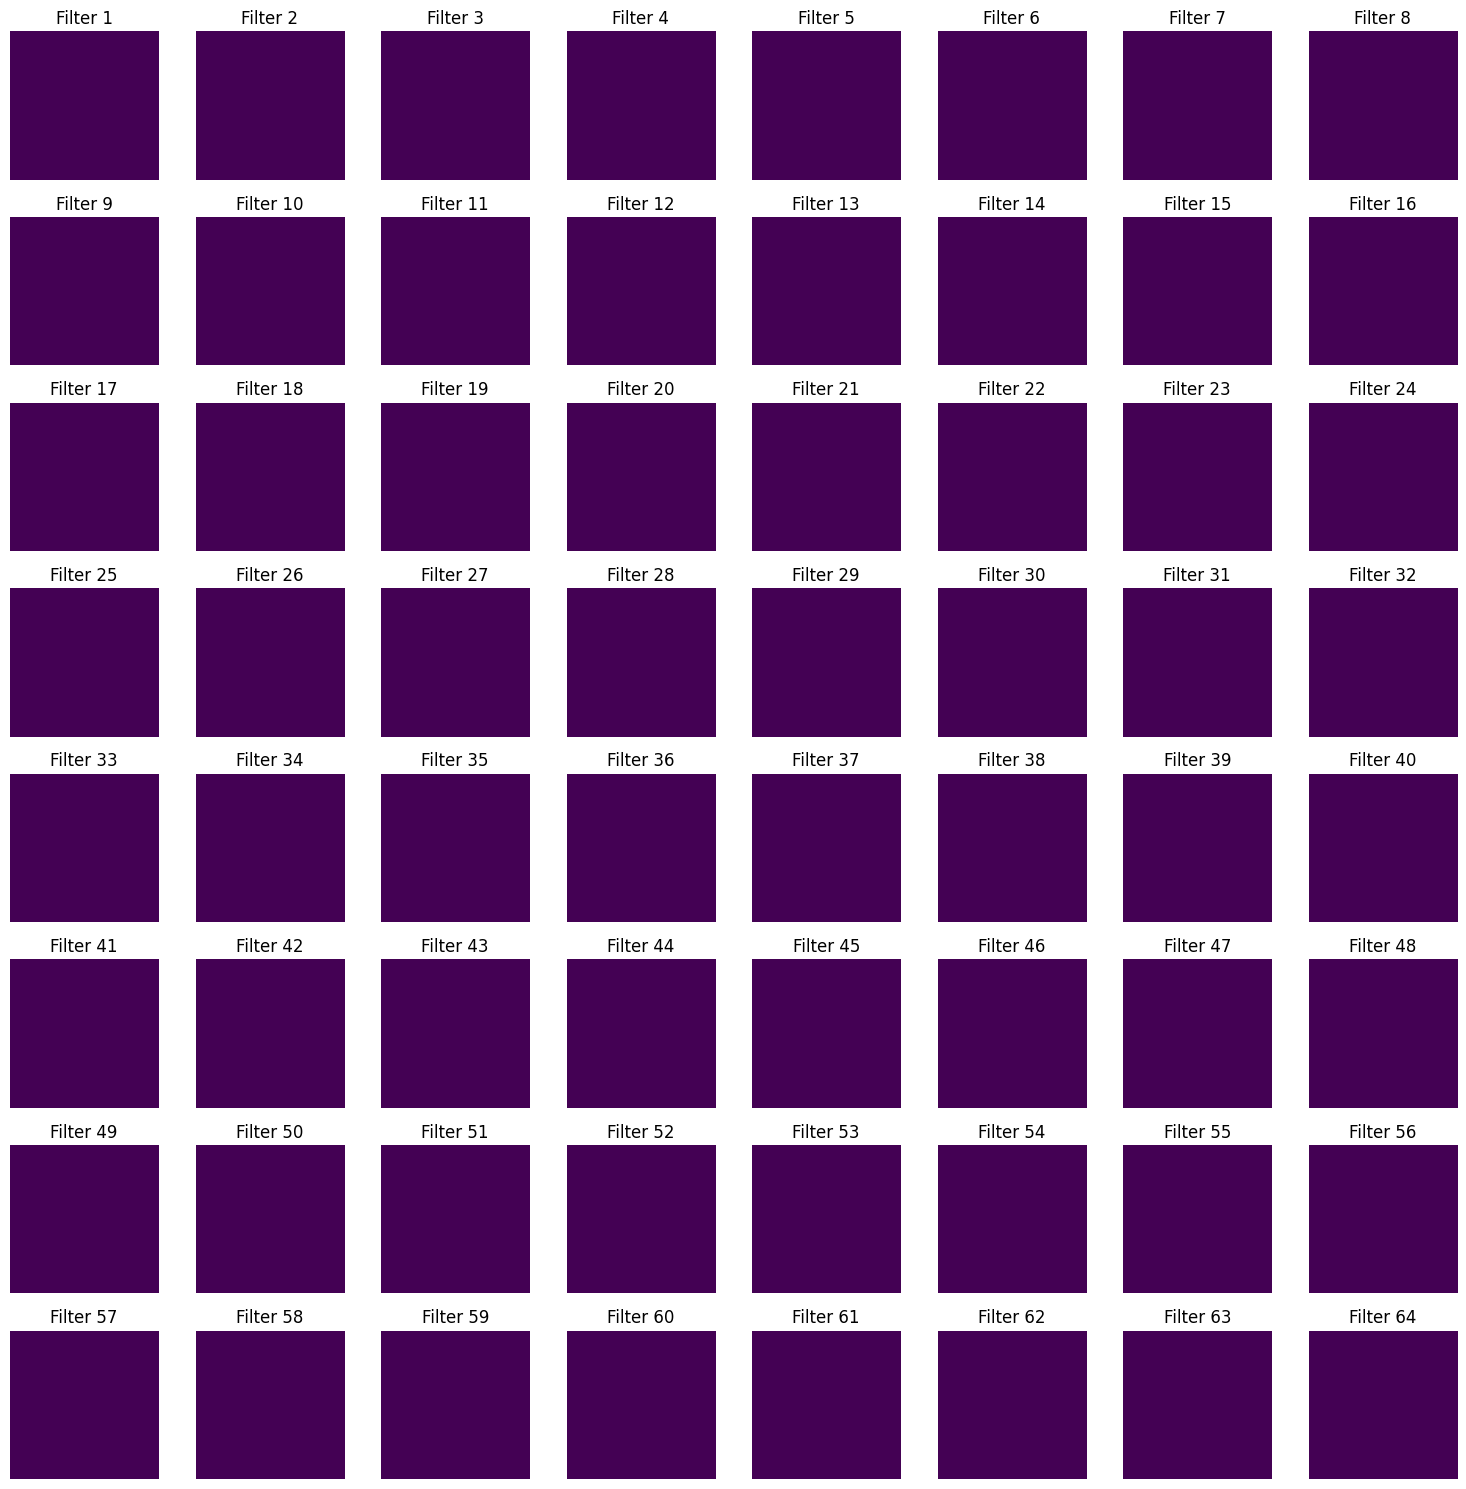

Visualizing filters for layer2.2.conv1


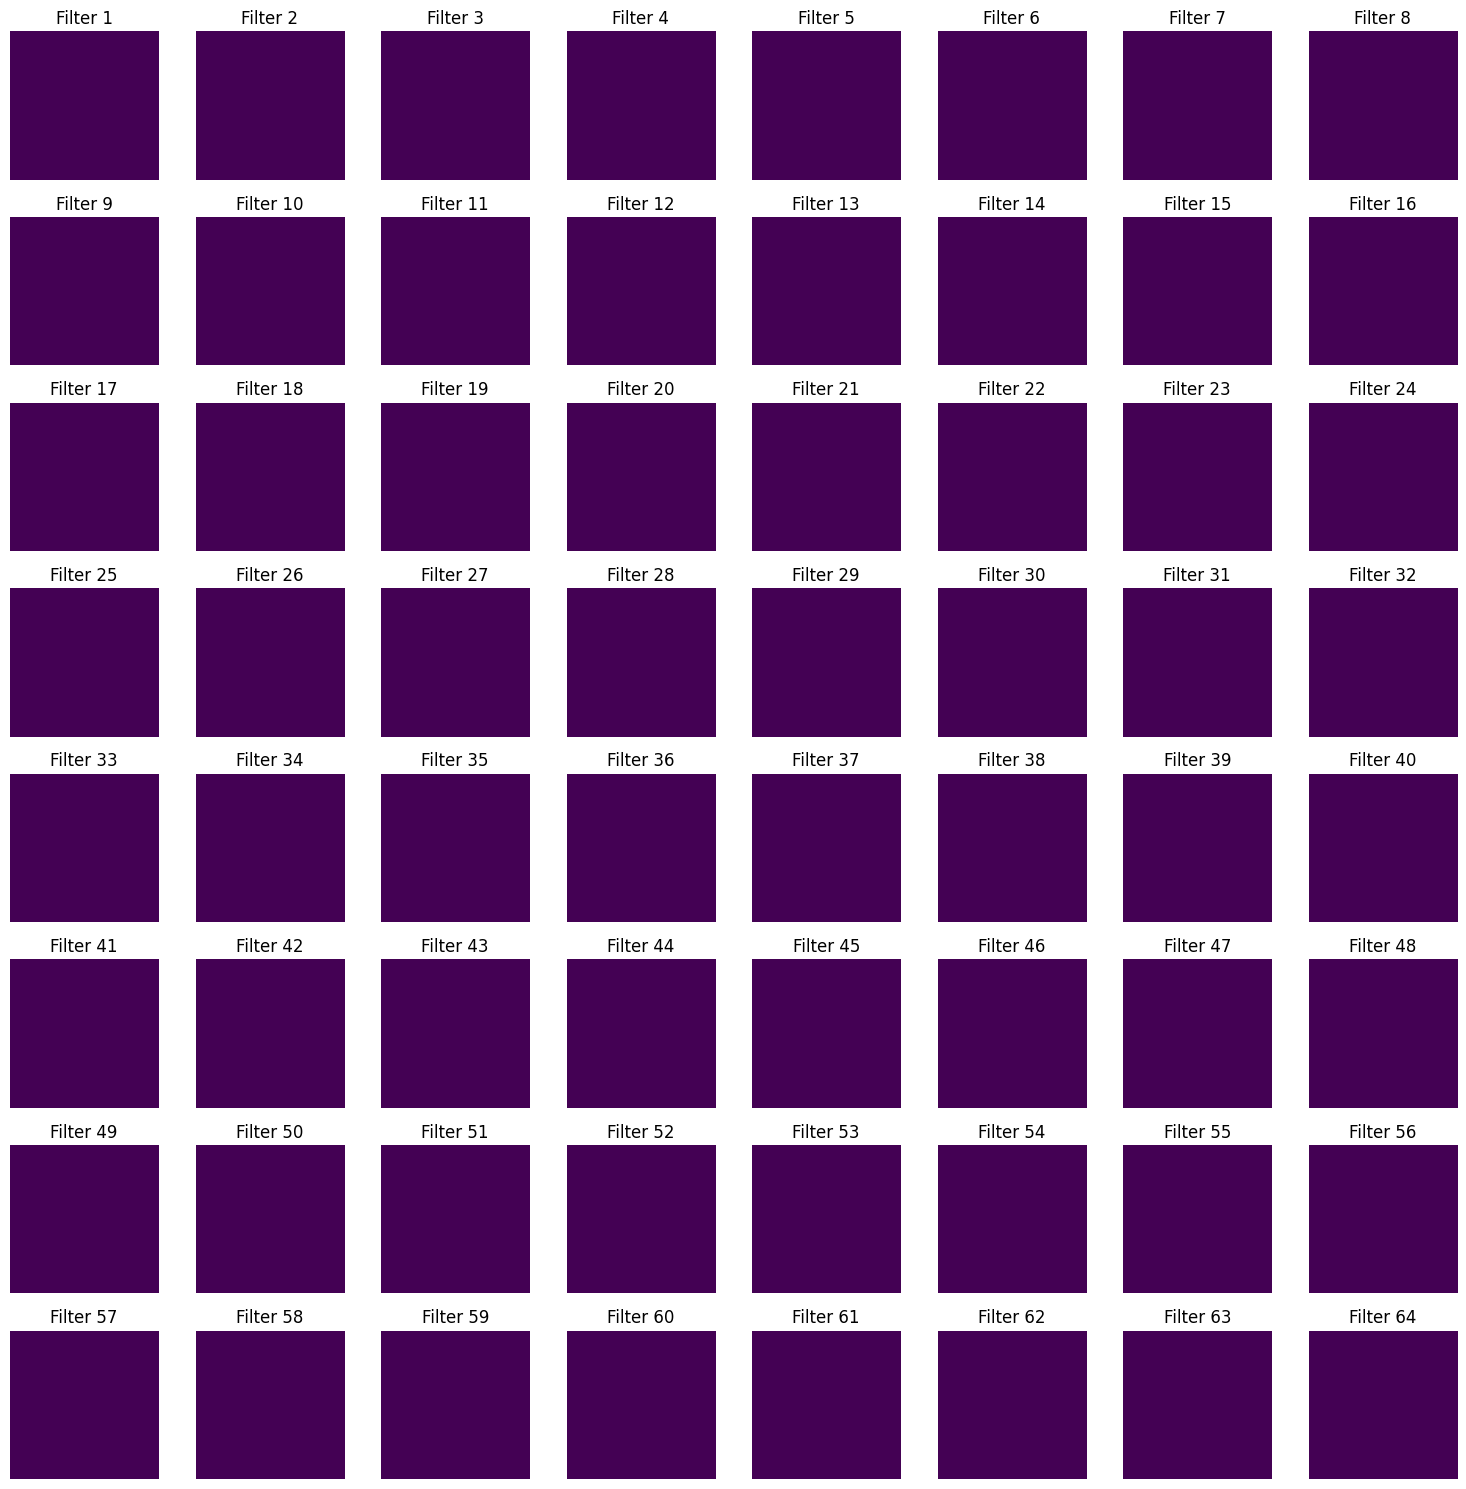

Visualizing filters for layer2.2.conv2


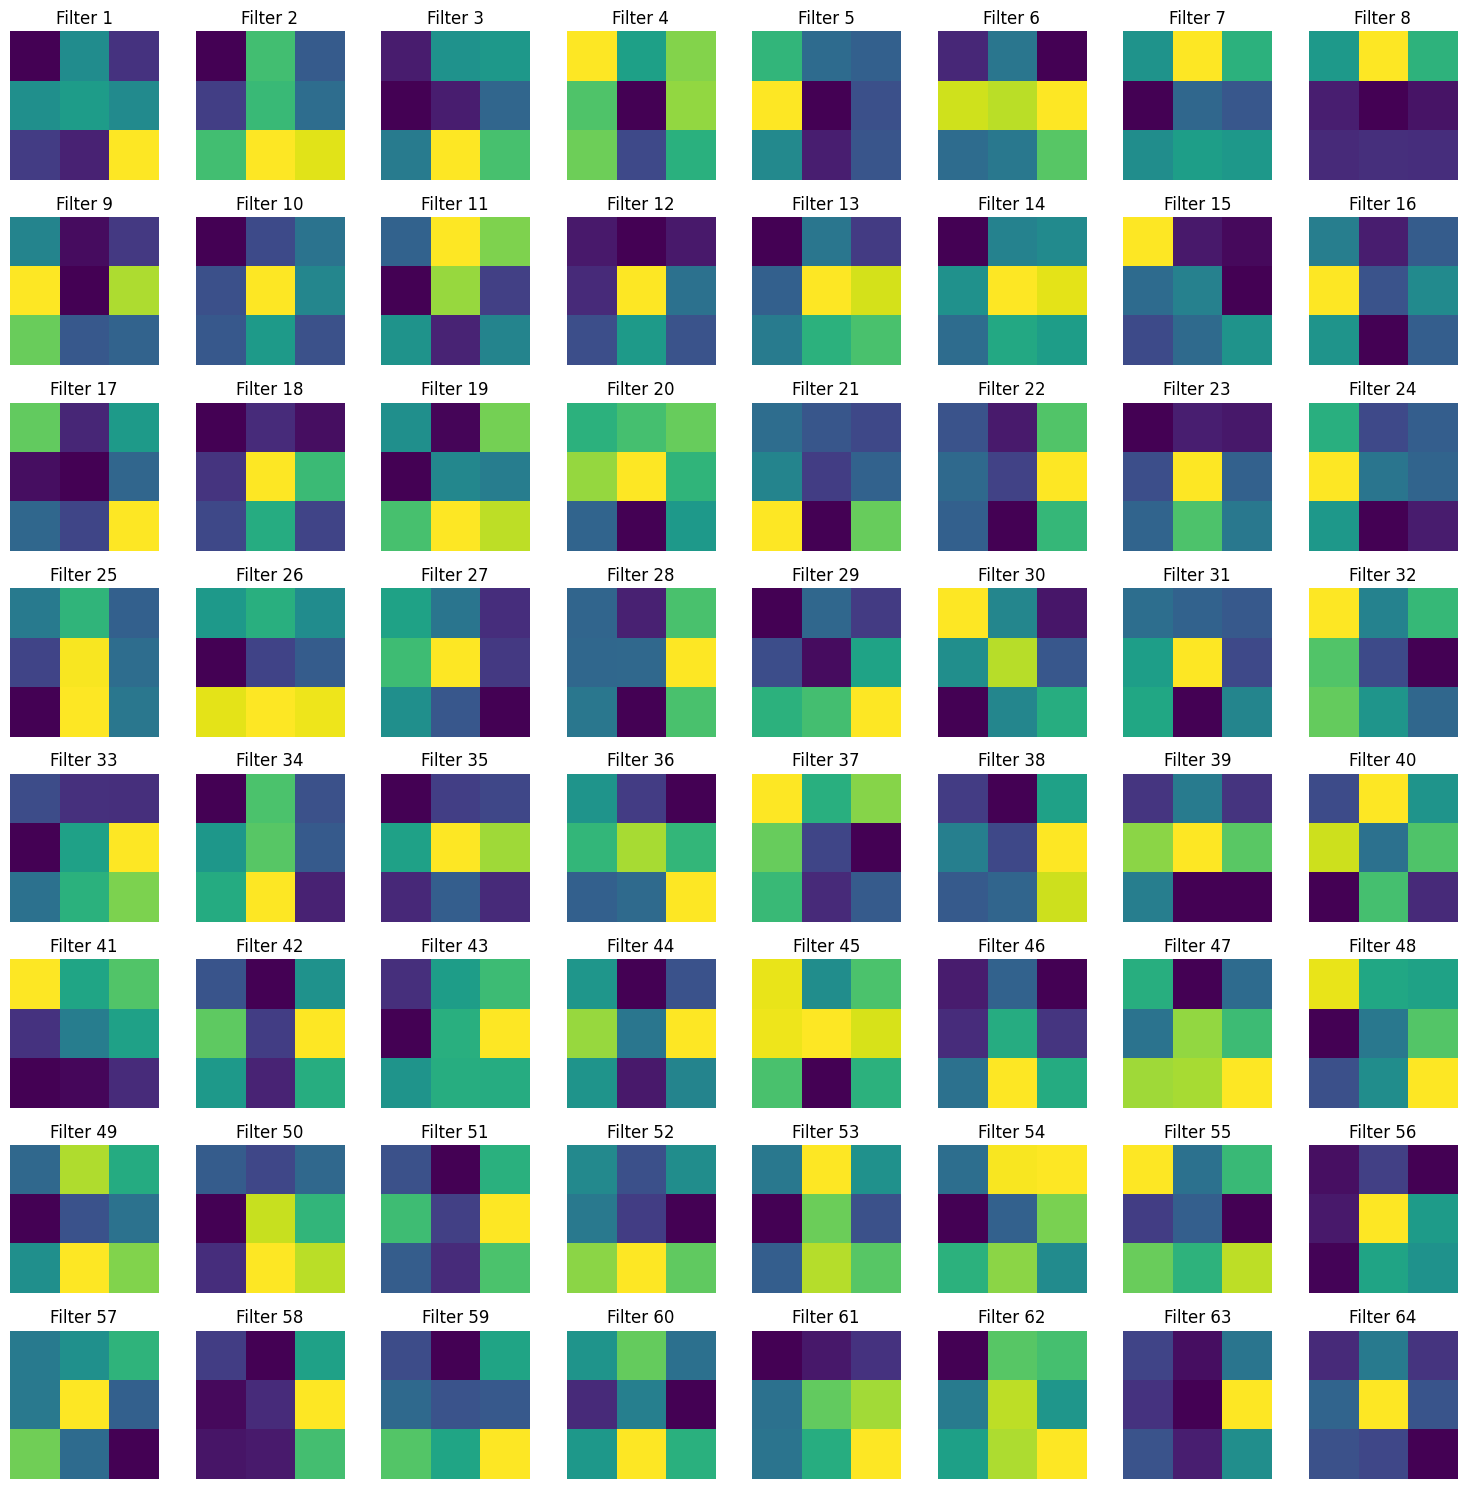

Visualizing filters for layer2.2.conv3


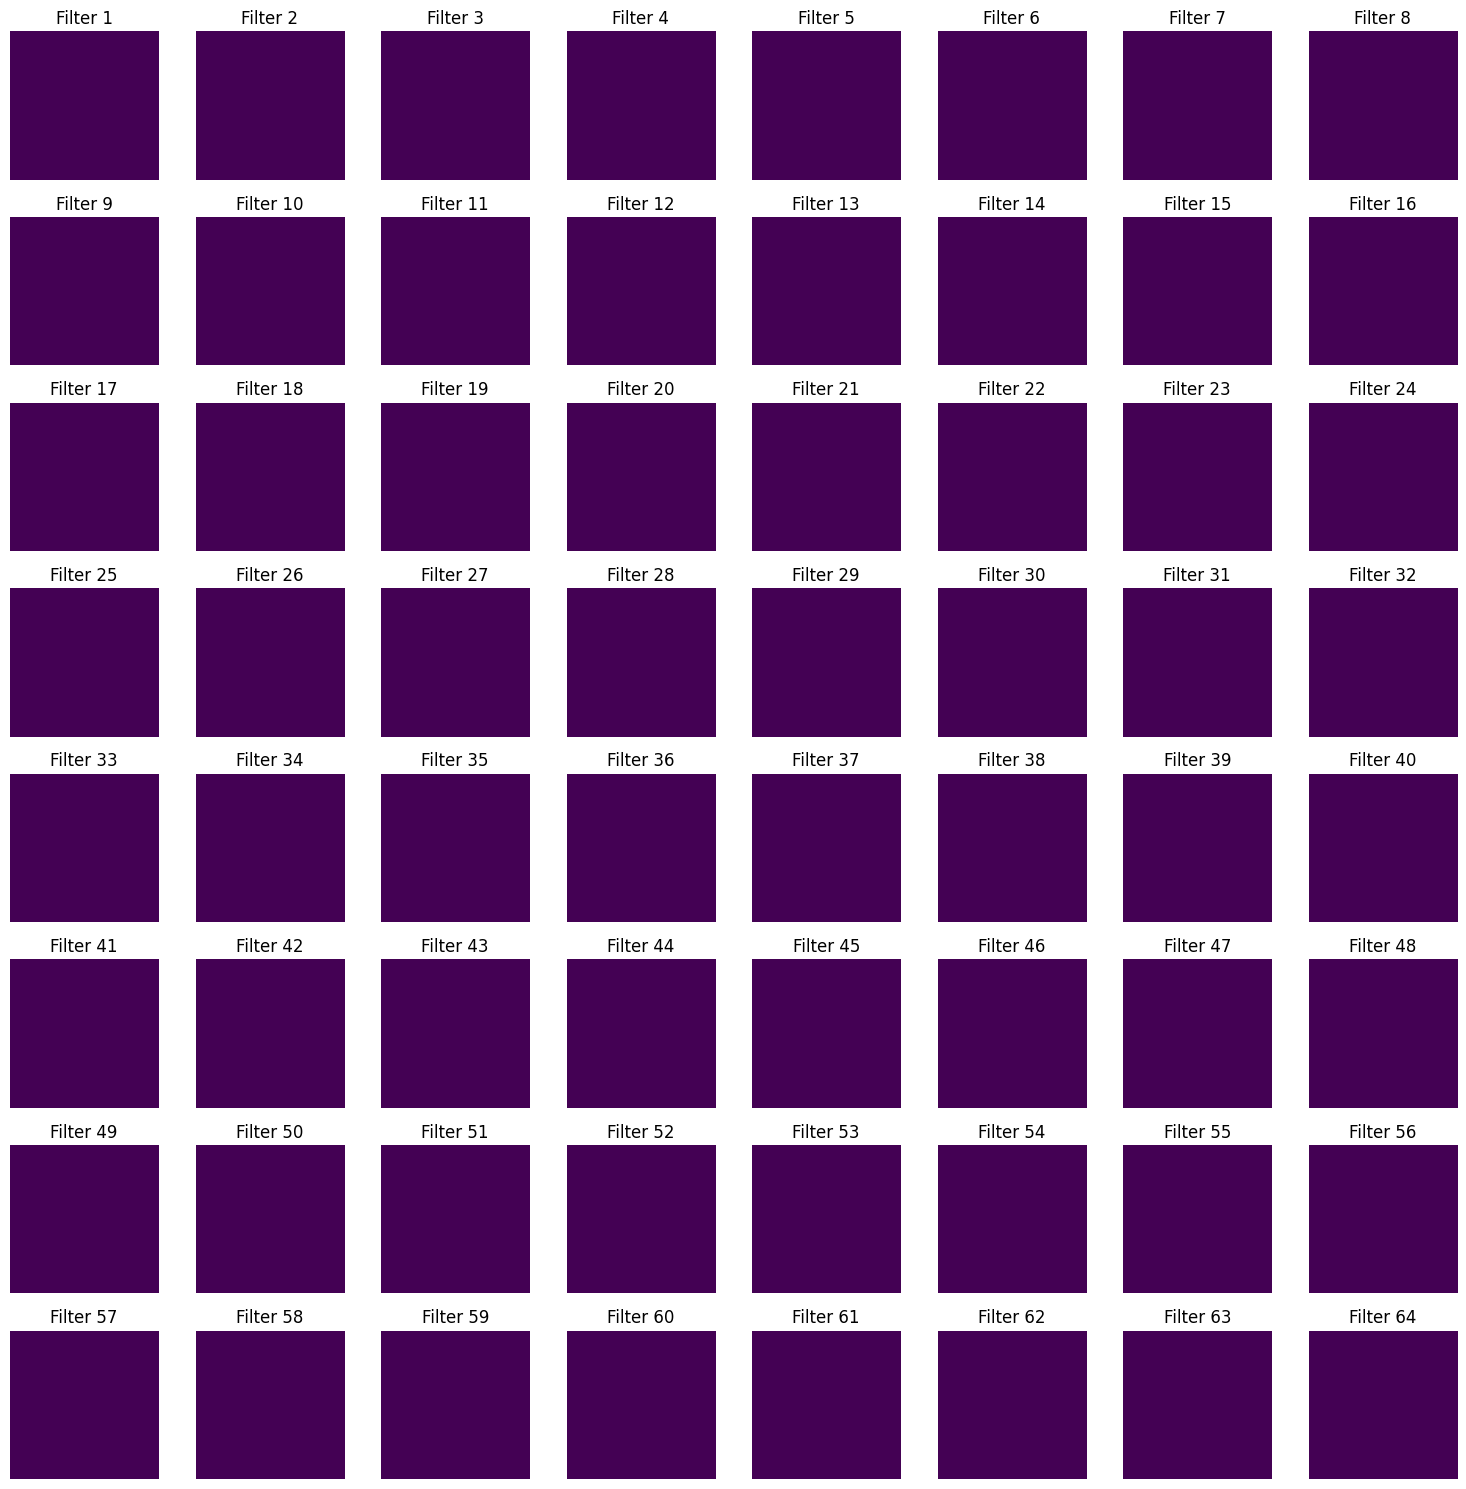

Visualizing filters for layer2.3.conv1


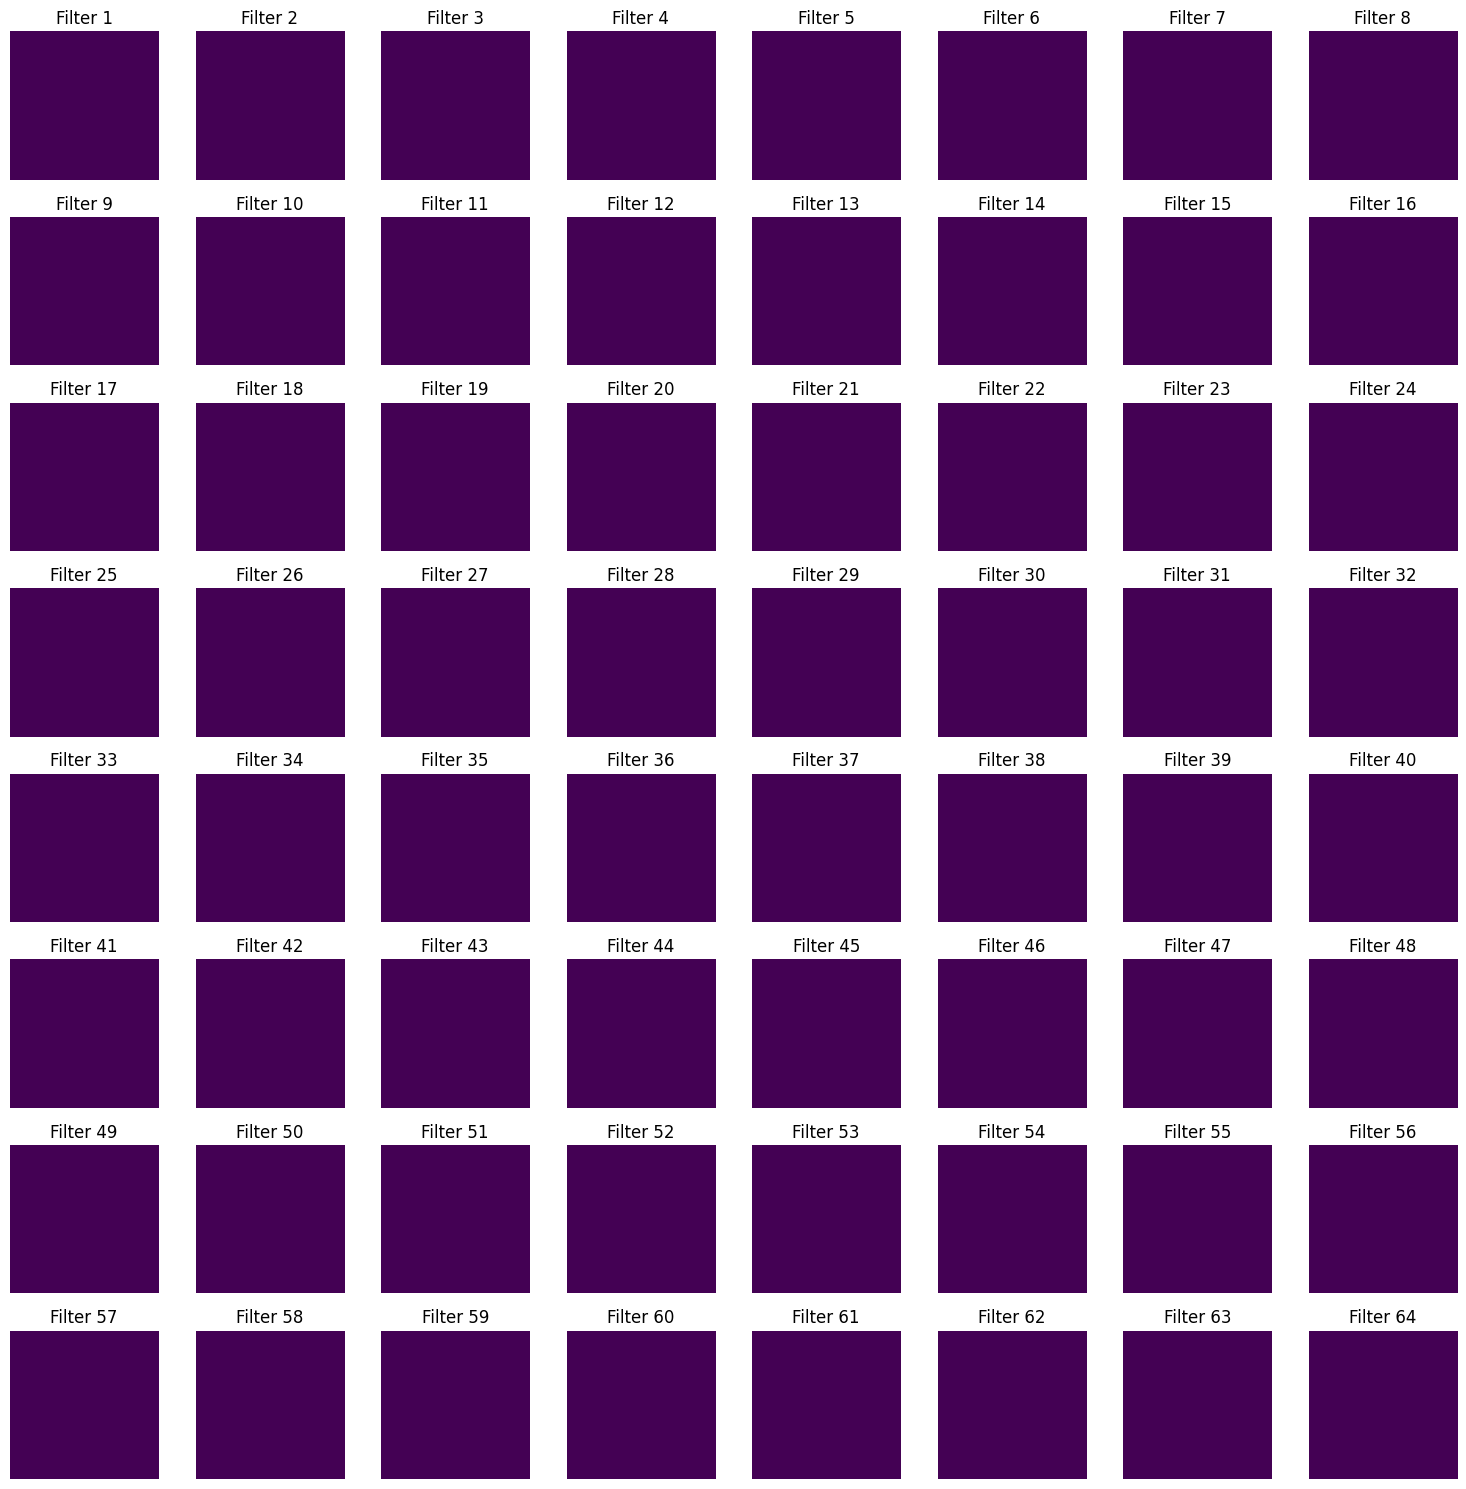

Visualizing filters for layer2.3.conv2


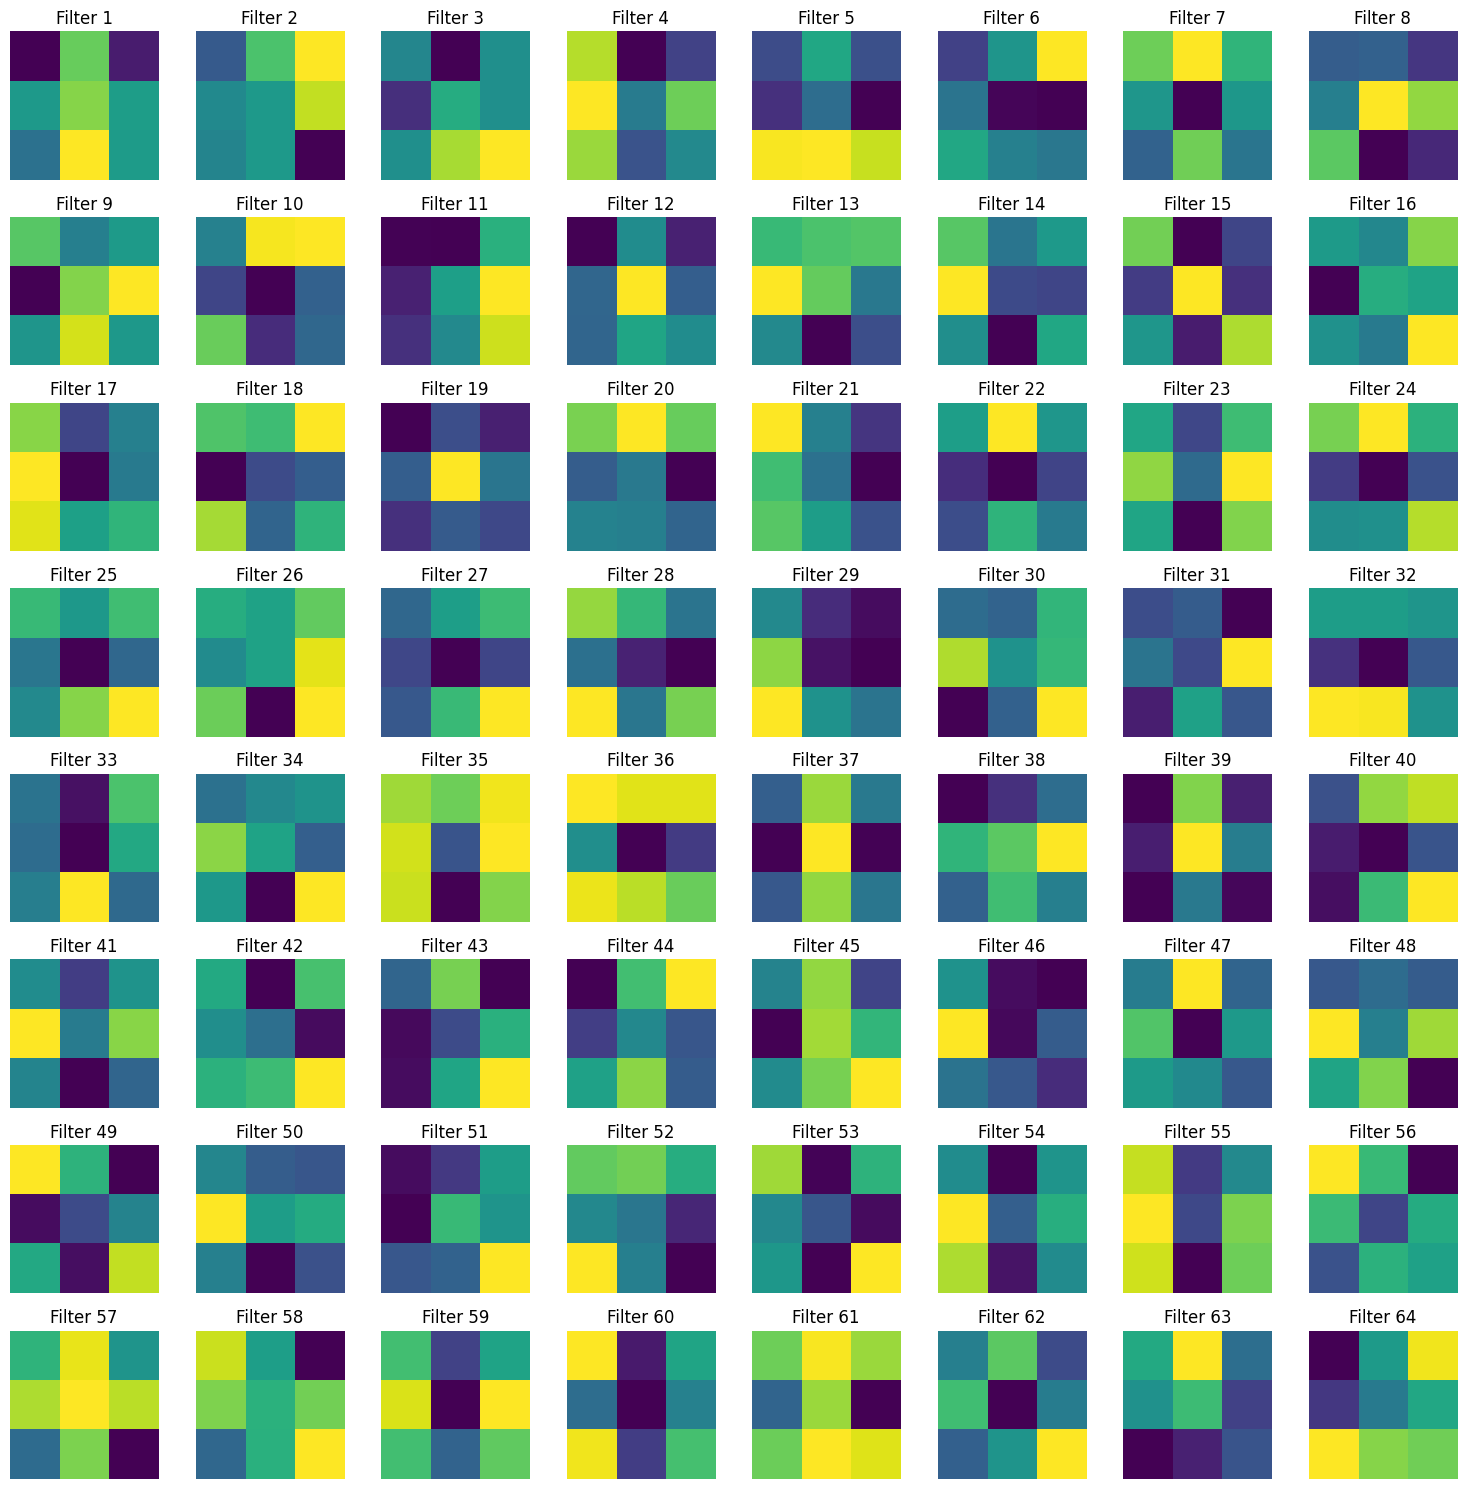

Visualizing filters for layer2.3.conv3


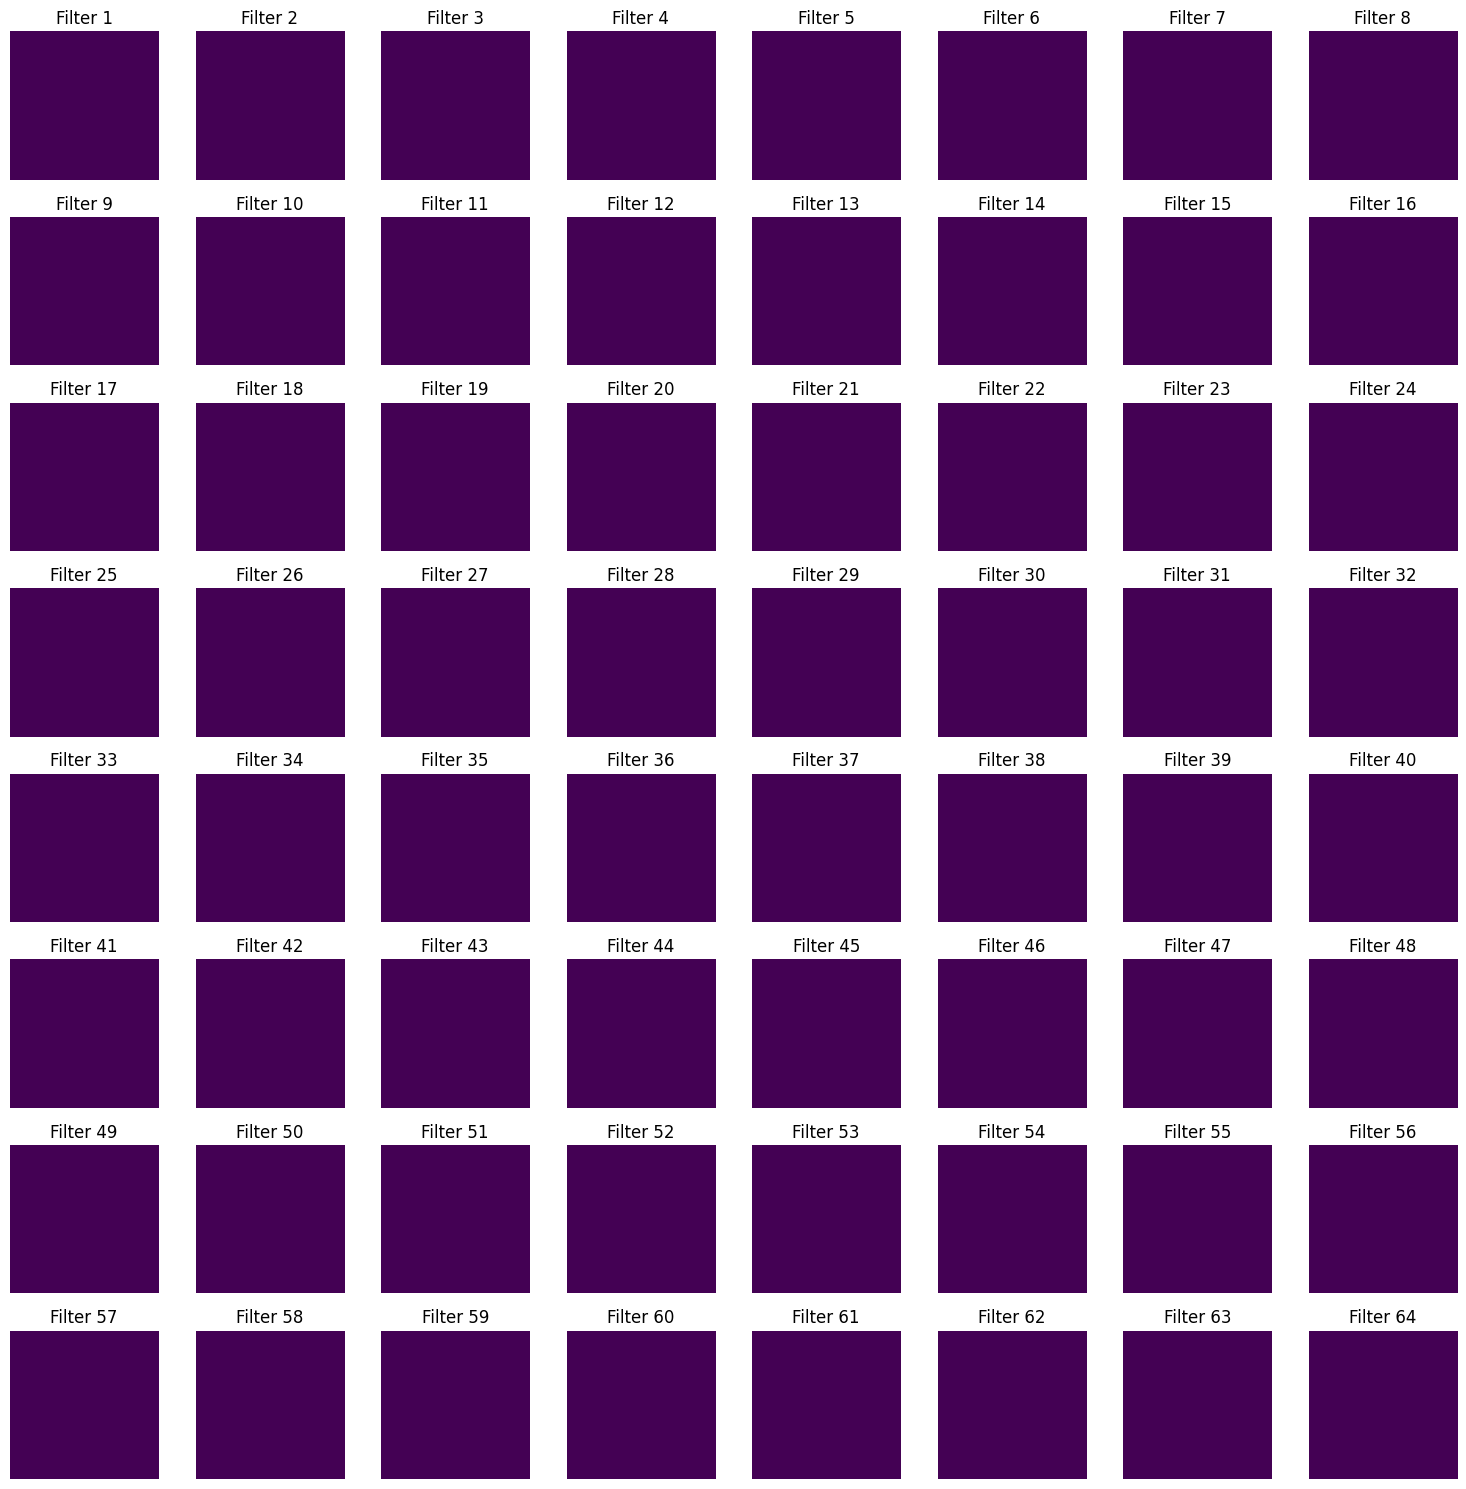

Visualizing filters for layer3.0.conv1


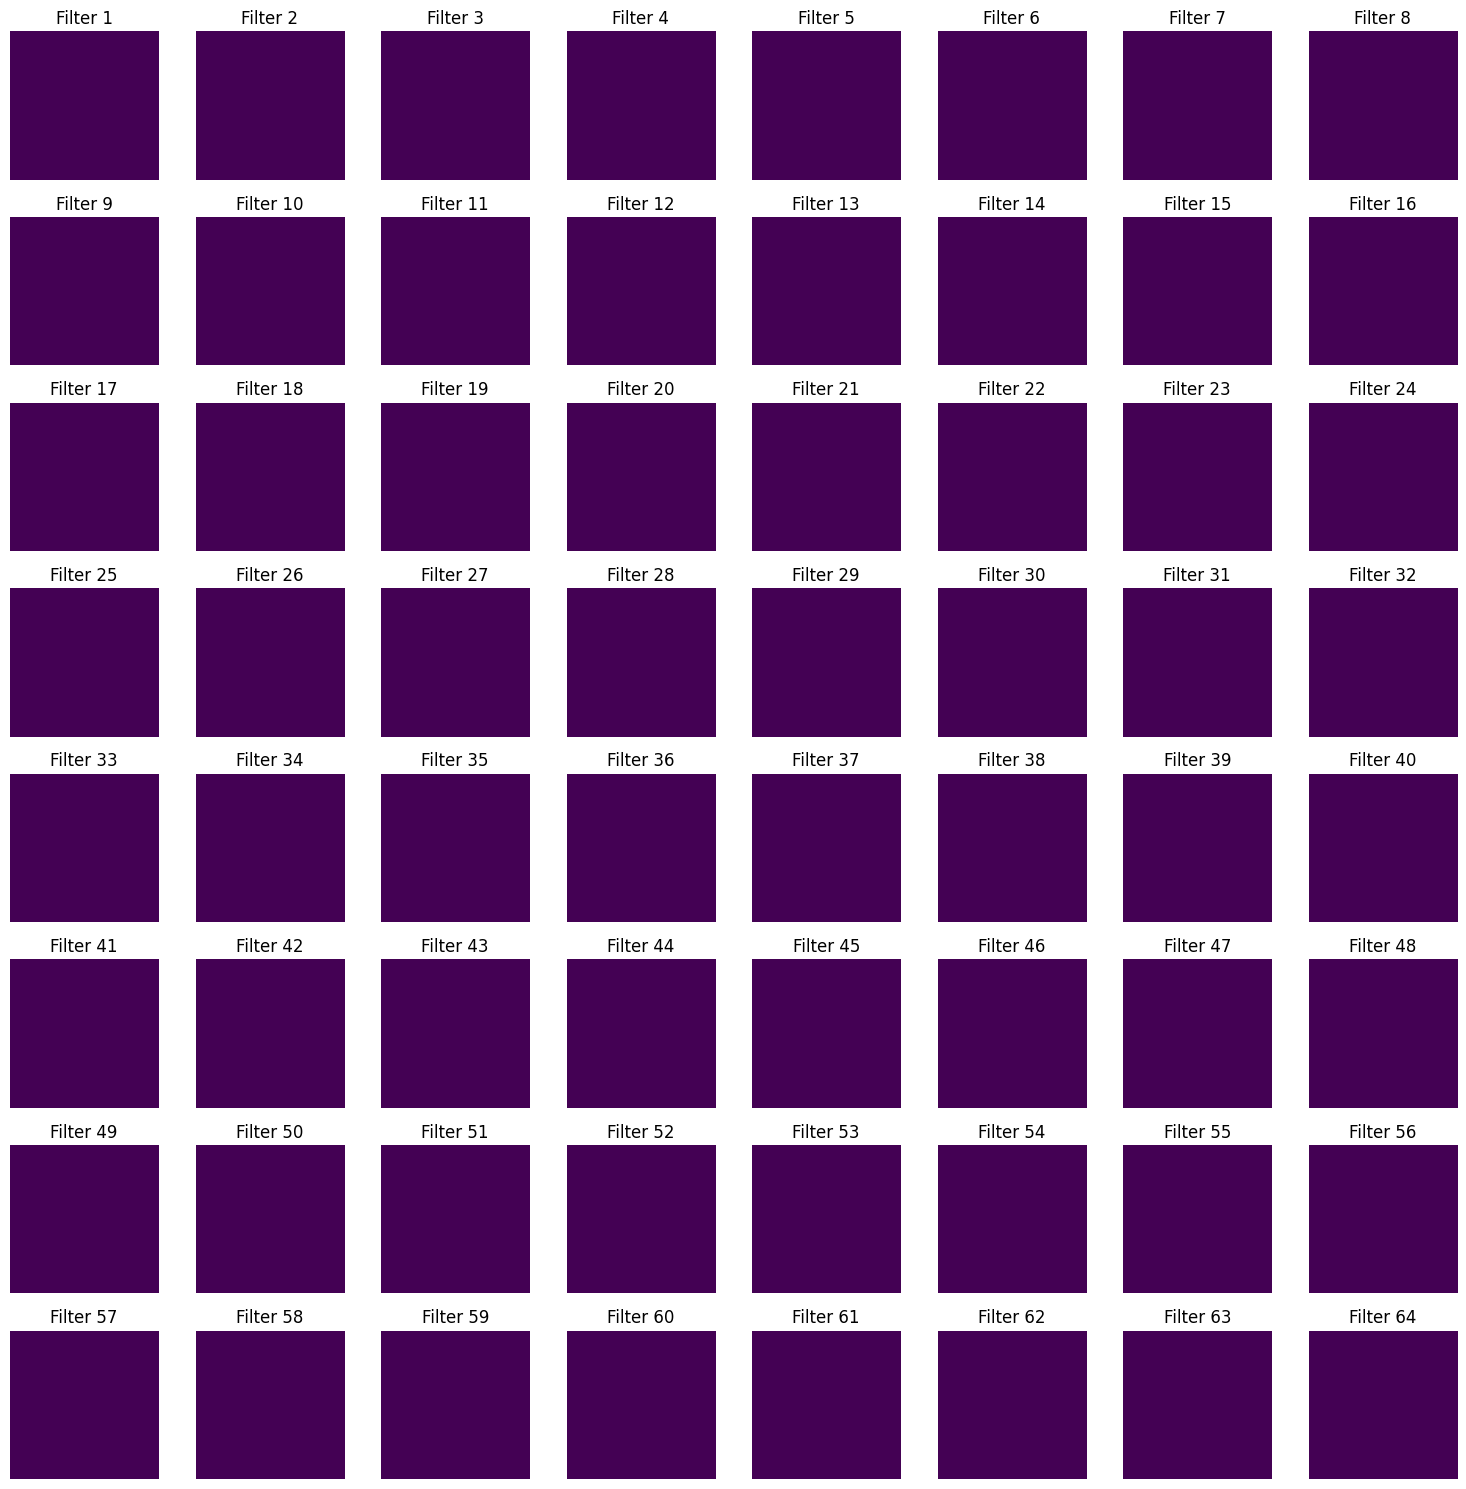

Visualizing filters for layer3.0.conv2


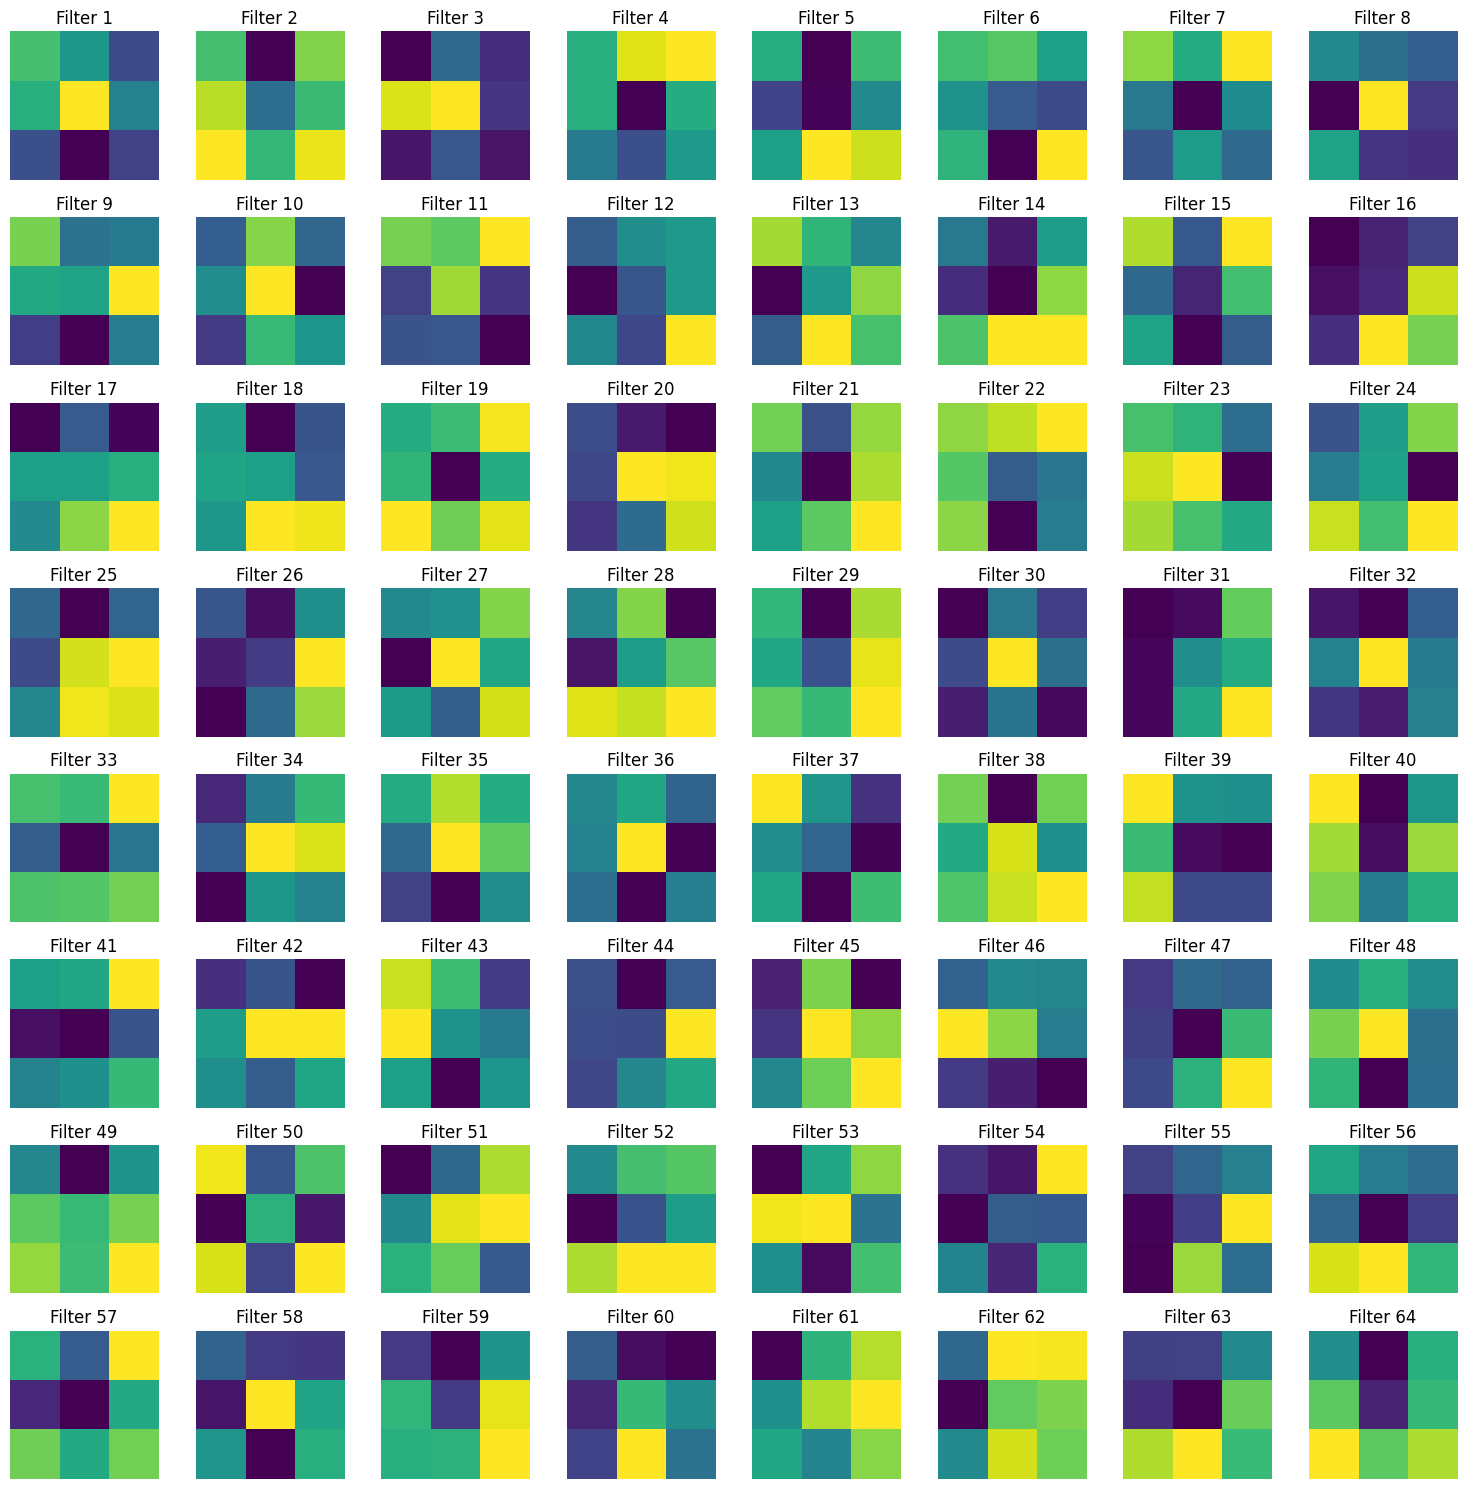

Visualizing filters for layer3.0.conv3


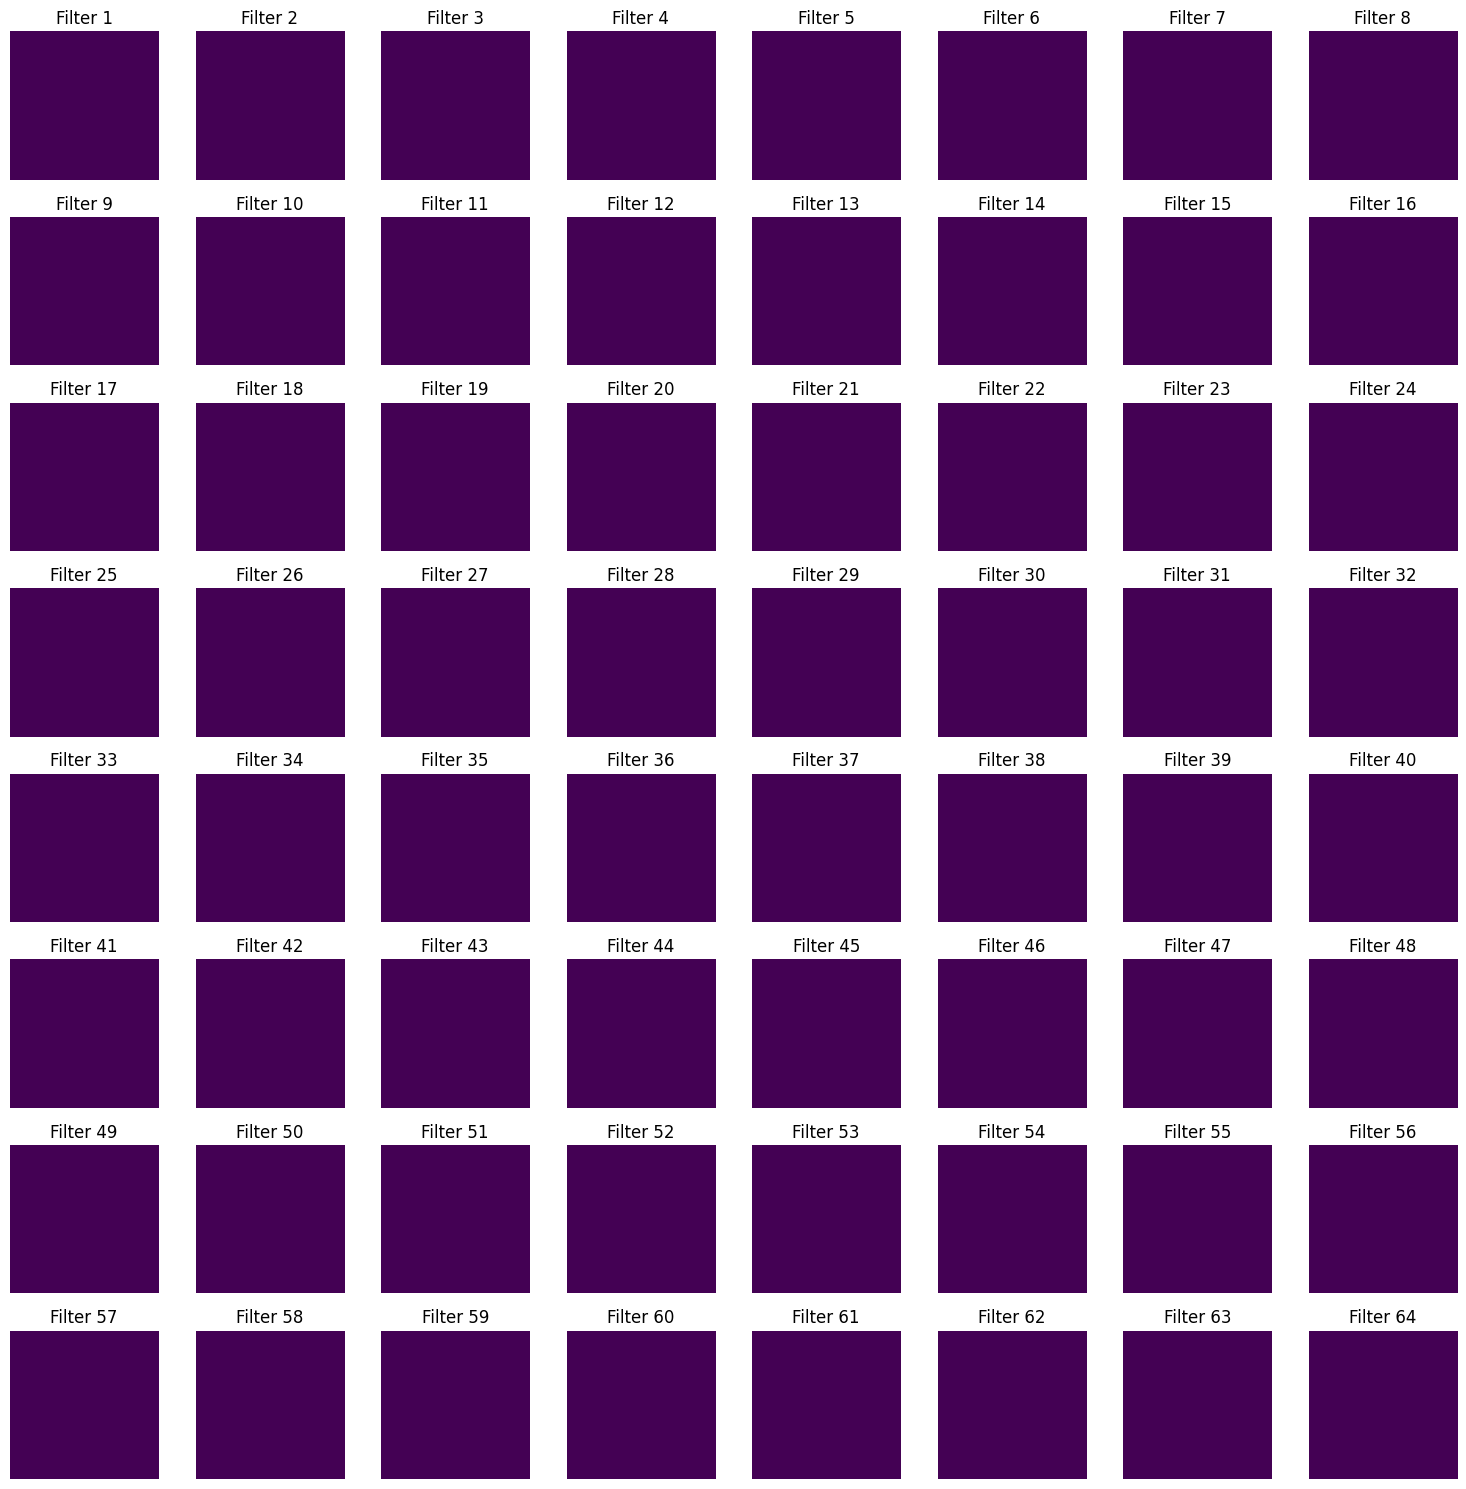

Visualizing filters for layer3.0.downsample.0


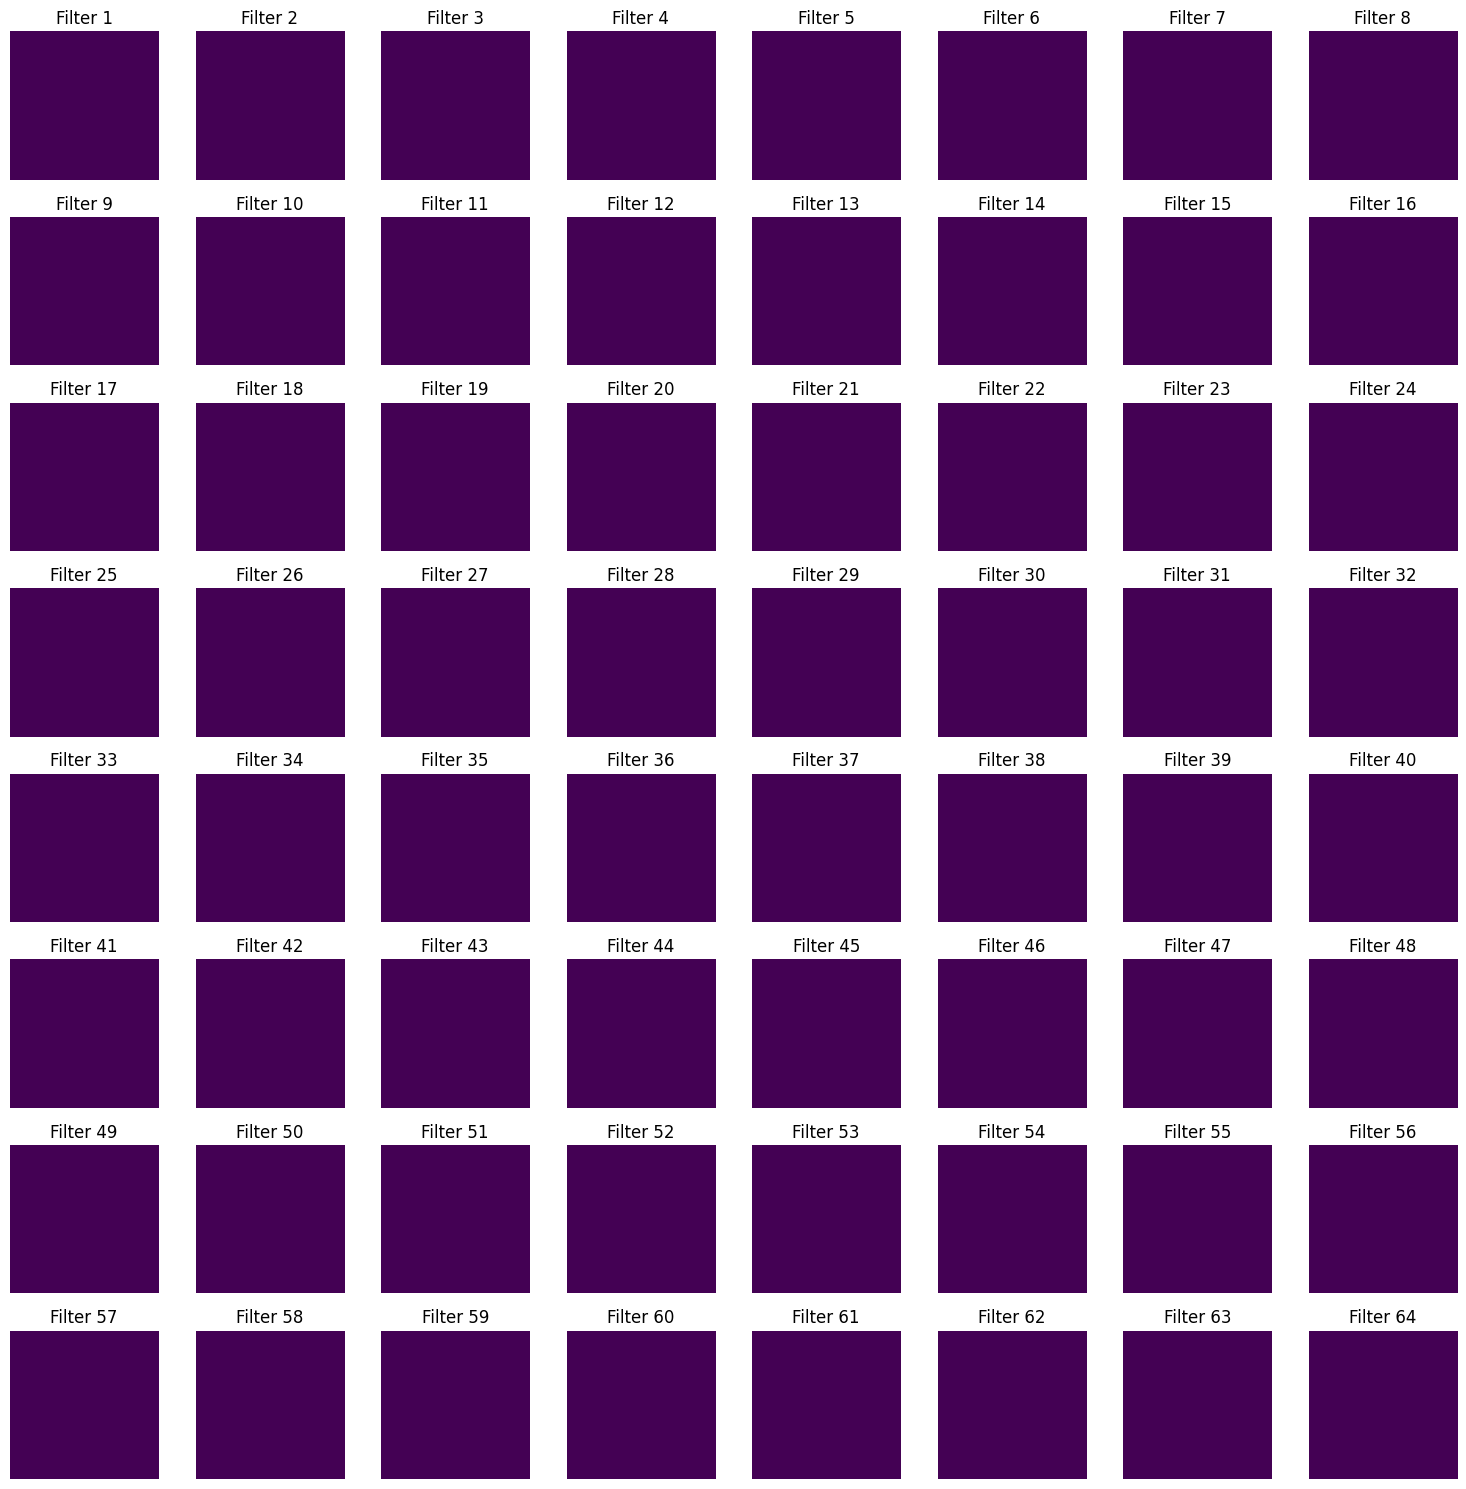

Visualizing filters for layer3.1.conv1


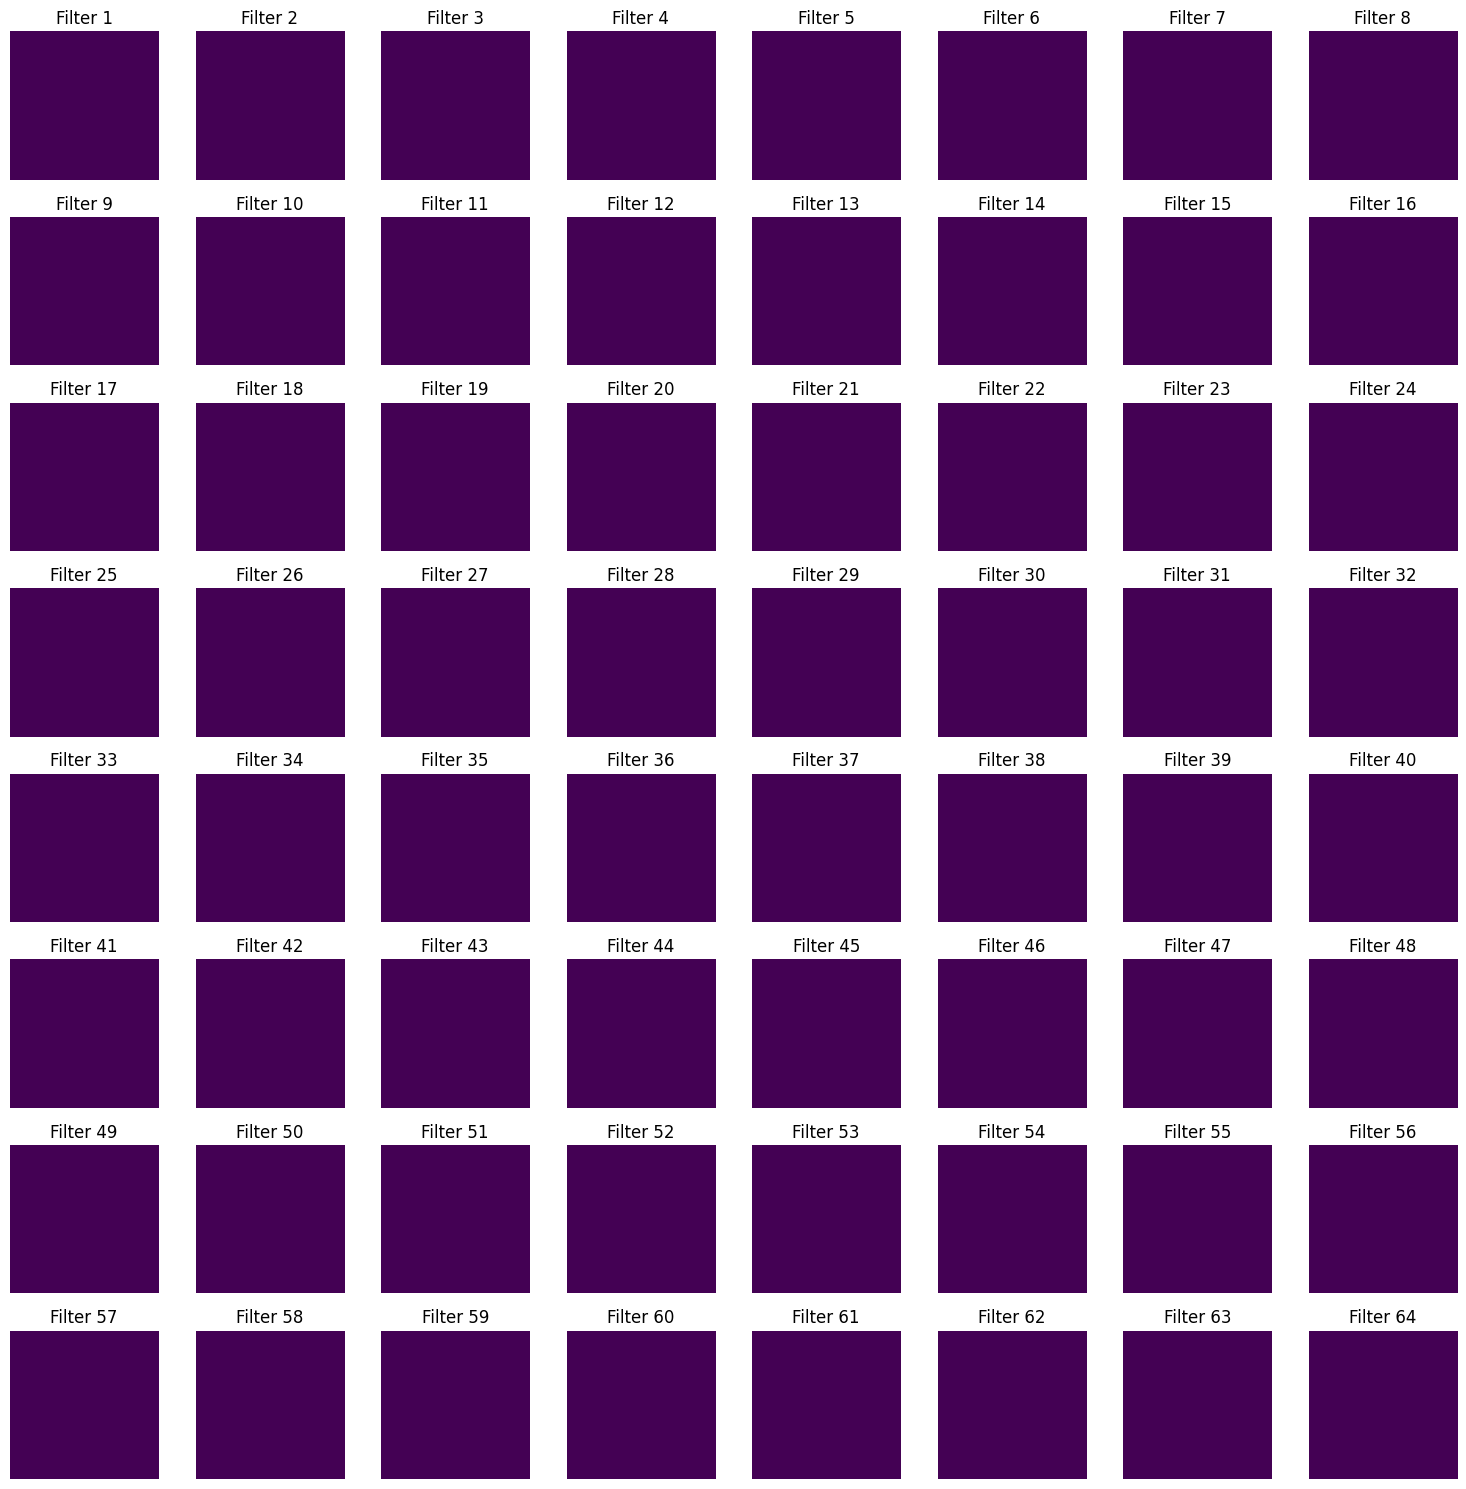

Visualizing filters for layer3.1.conv2


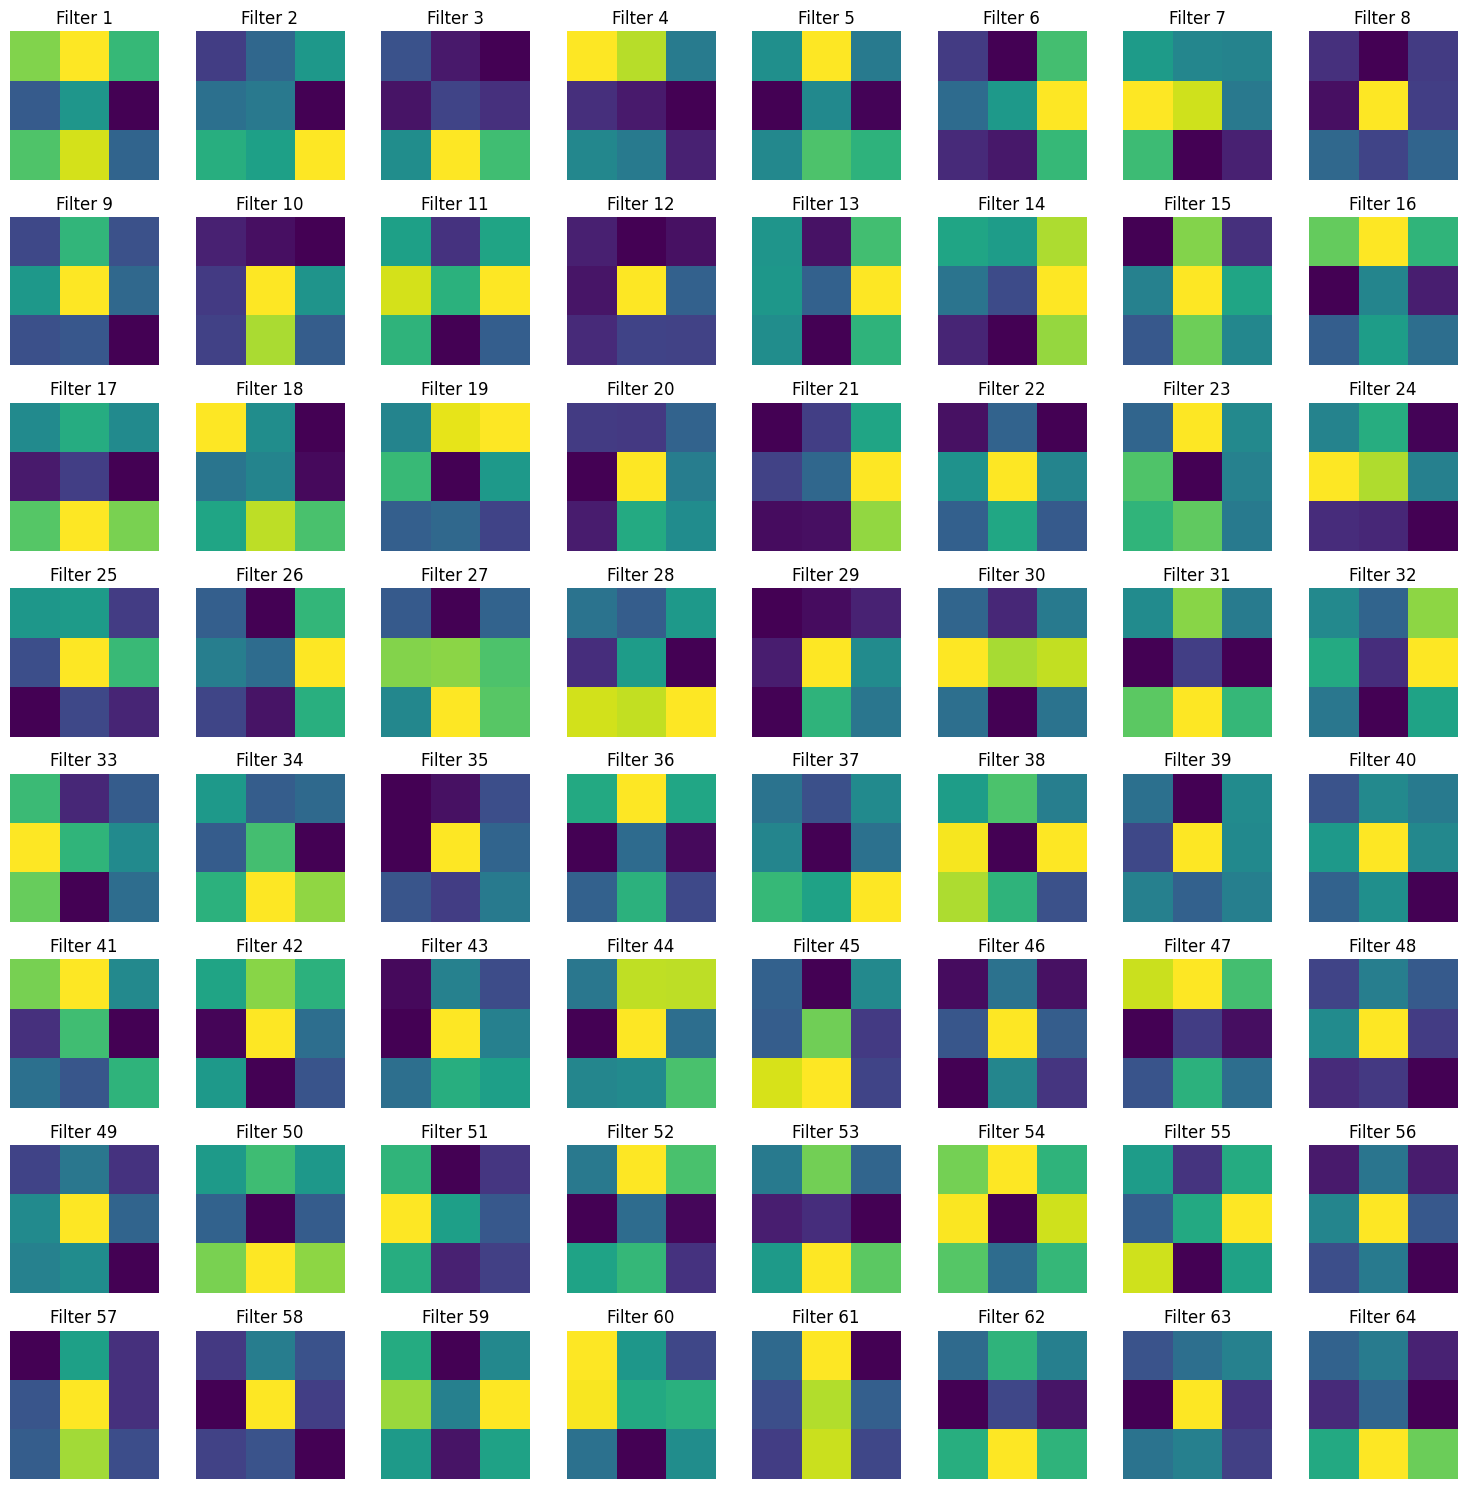

Visualizing filters for layer3.1.conv3


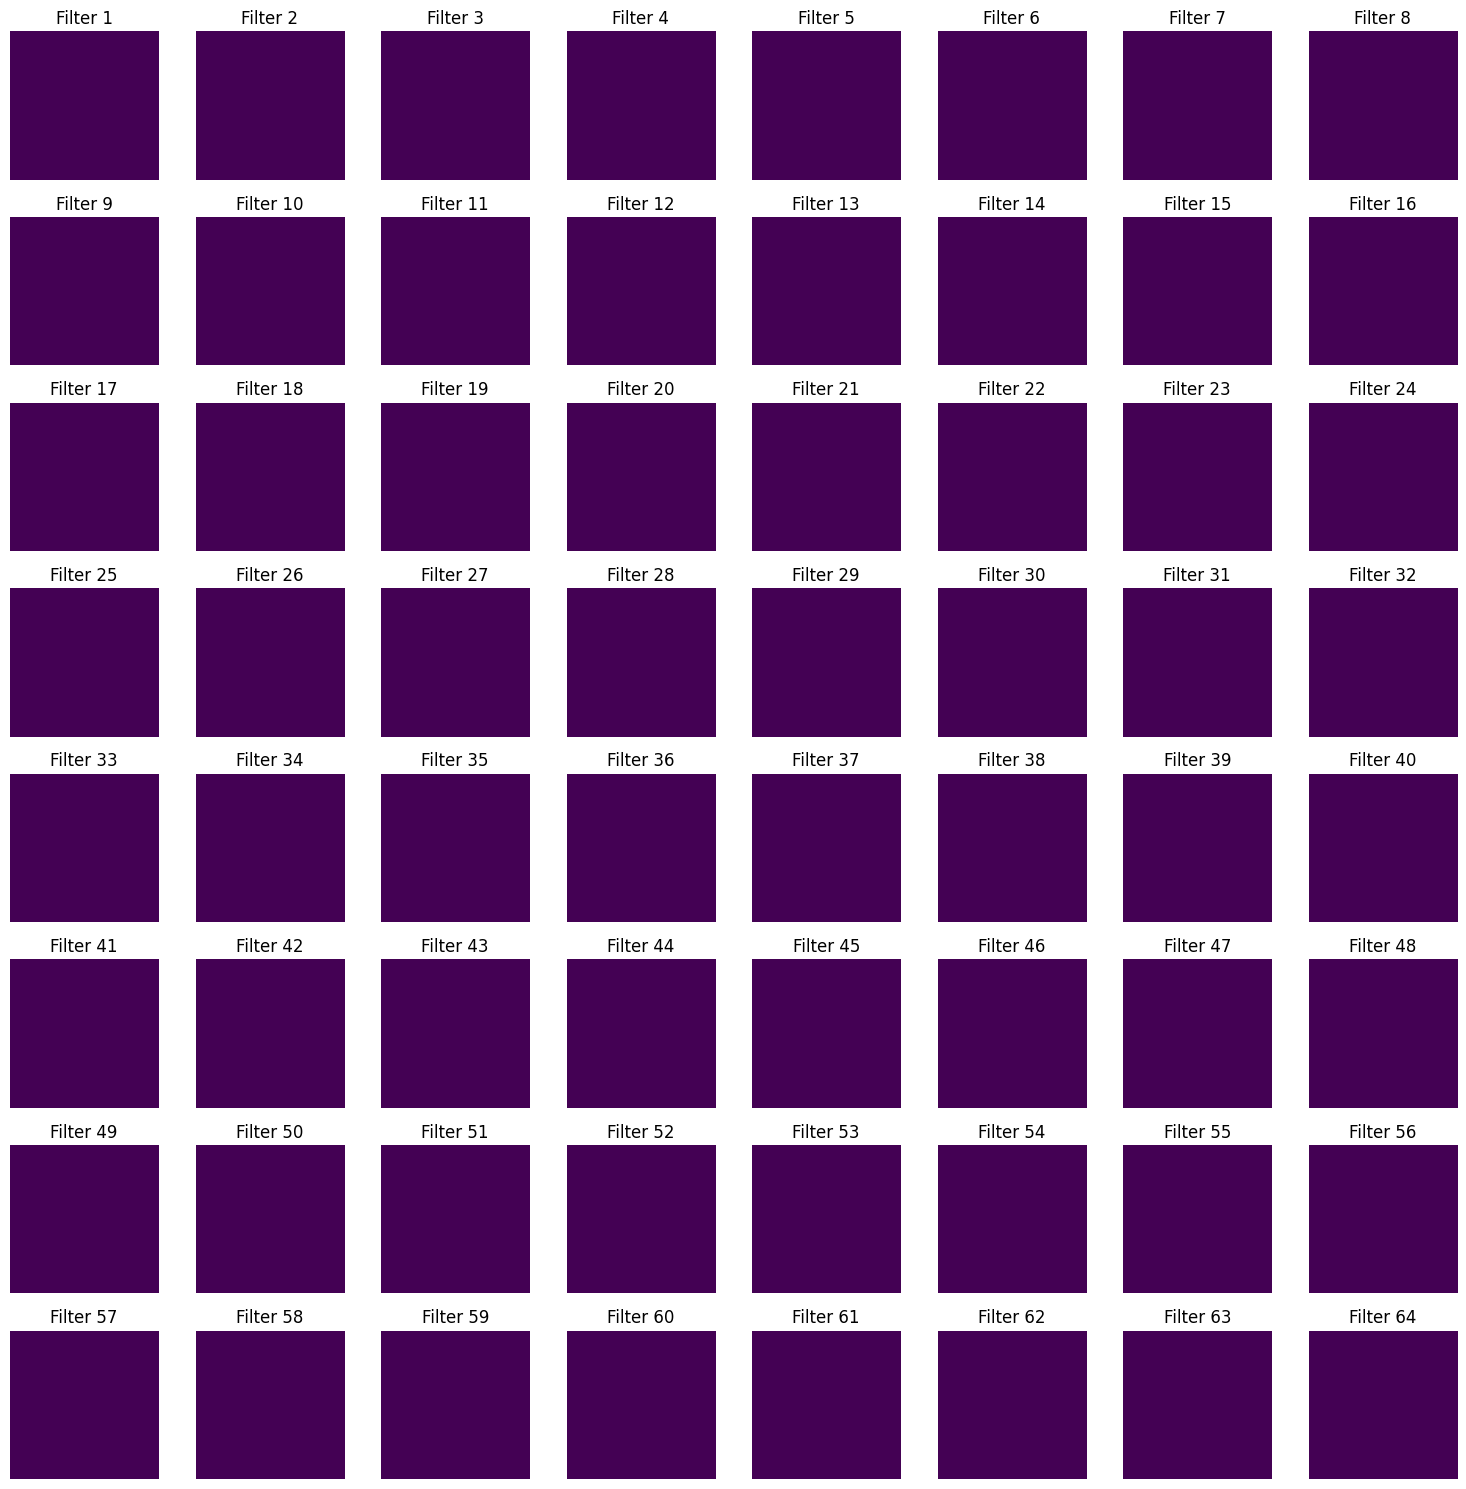

Visualizing filters for layer3.2.conv1


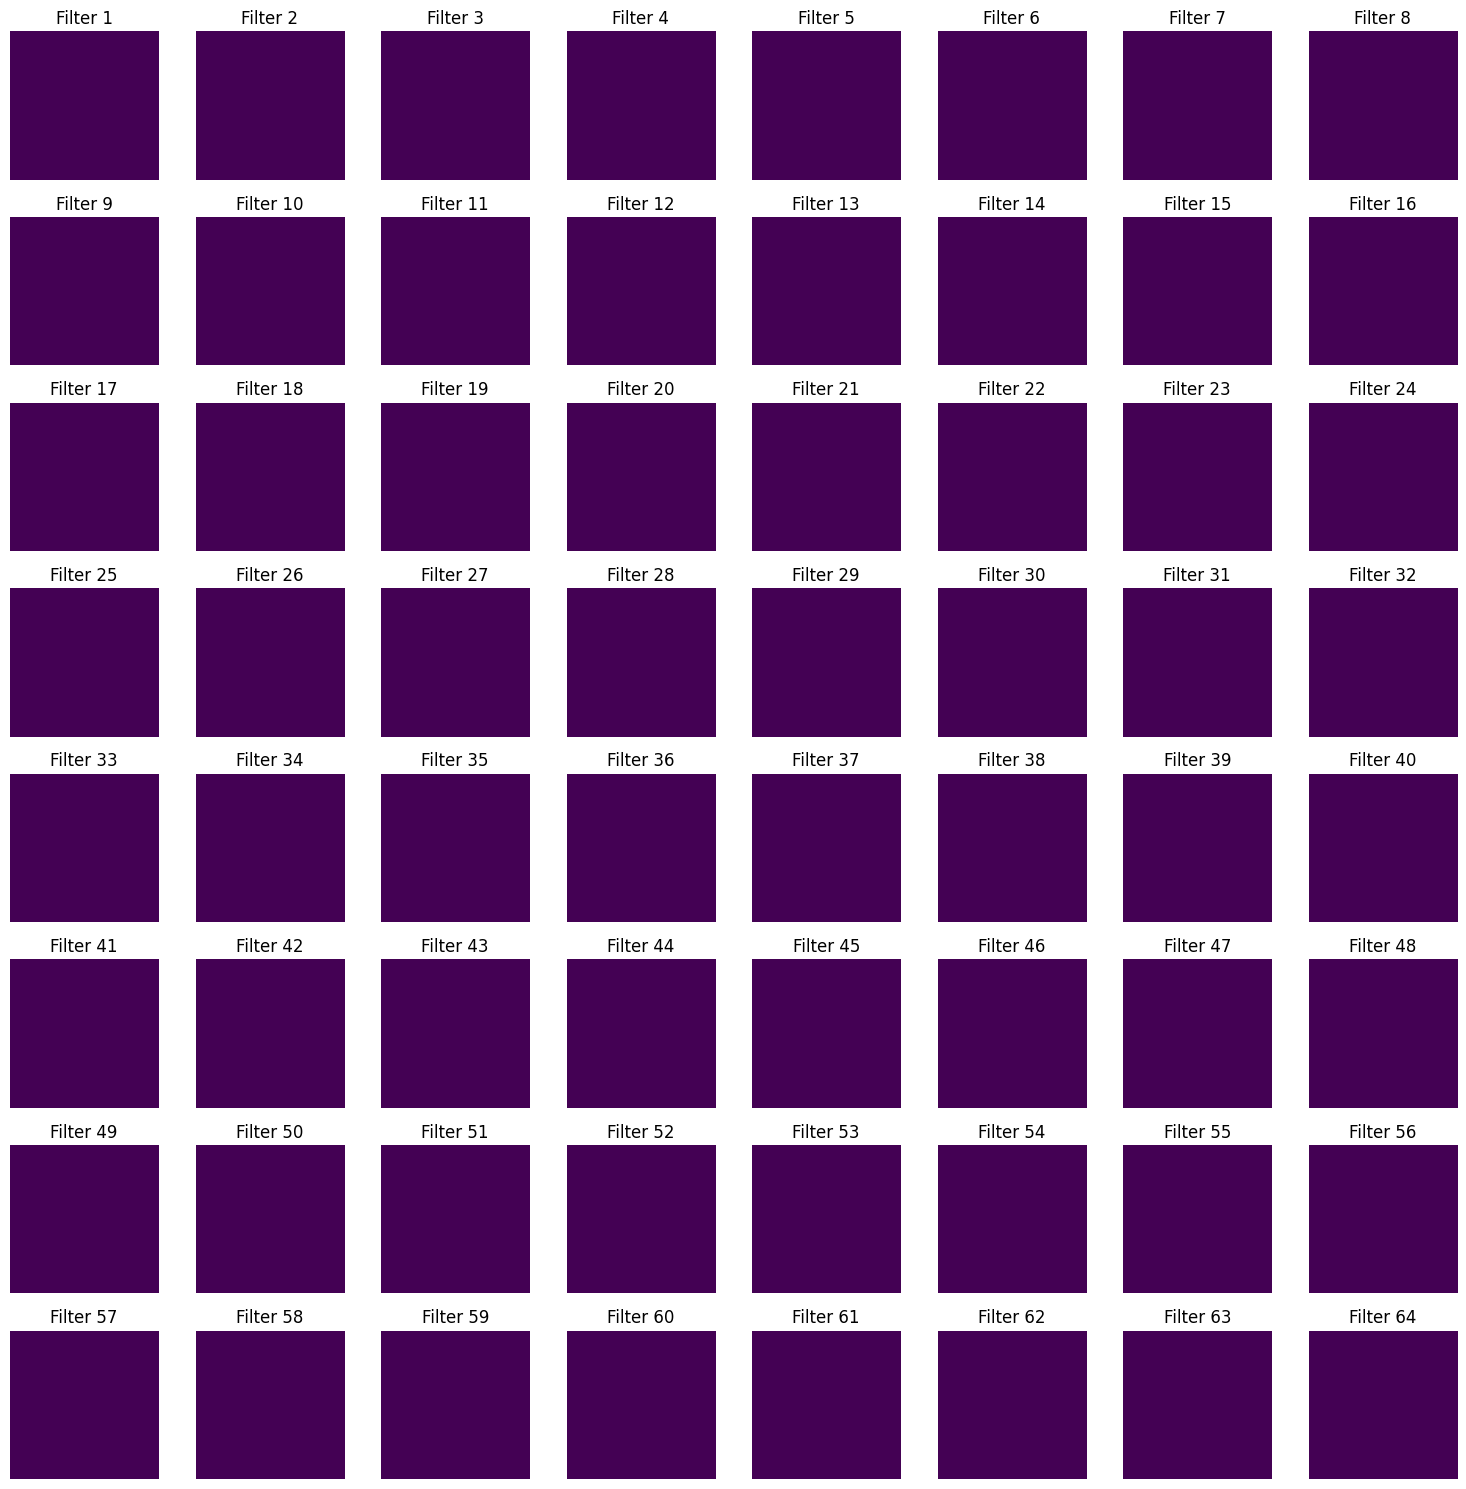

Visualizing filters for layer3.2.conv2


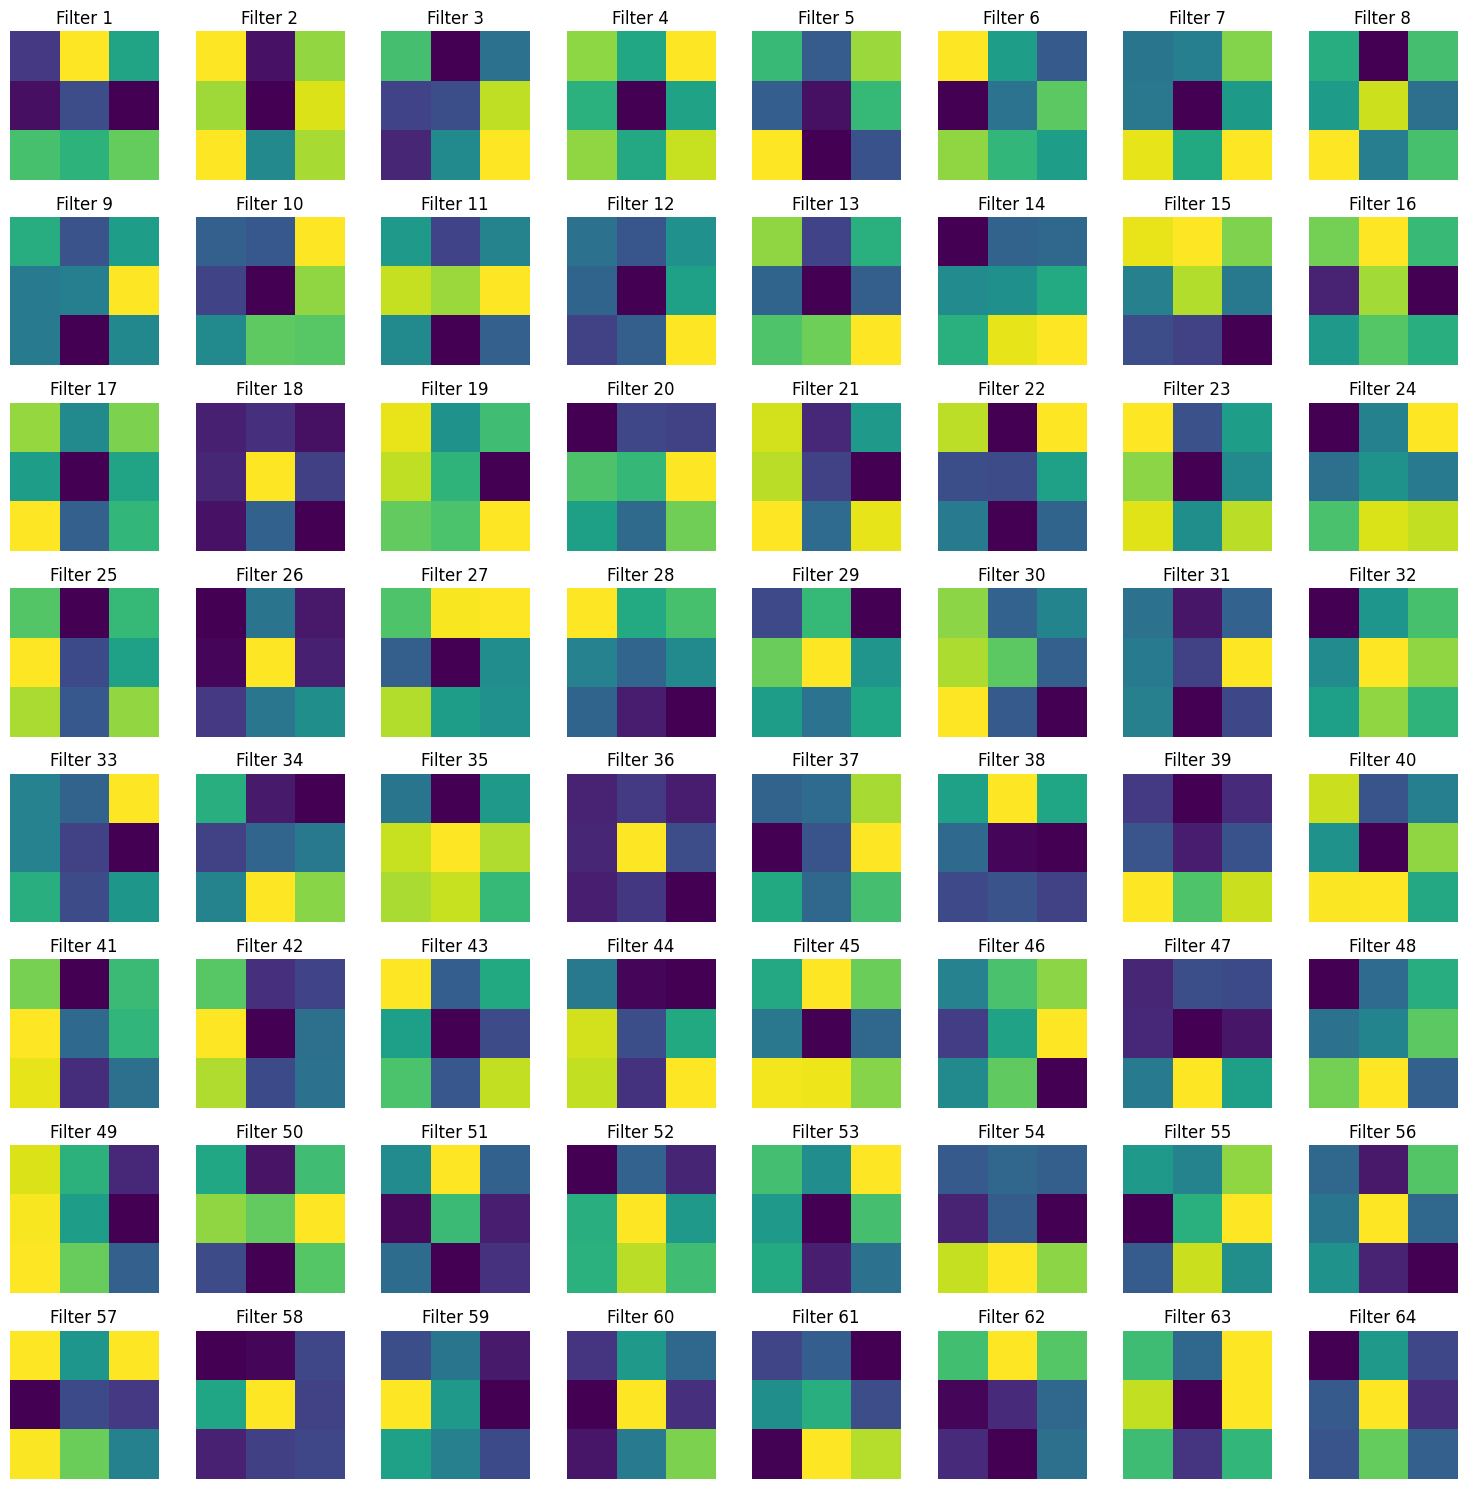

Visualizing filters for layer3.2.conv3


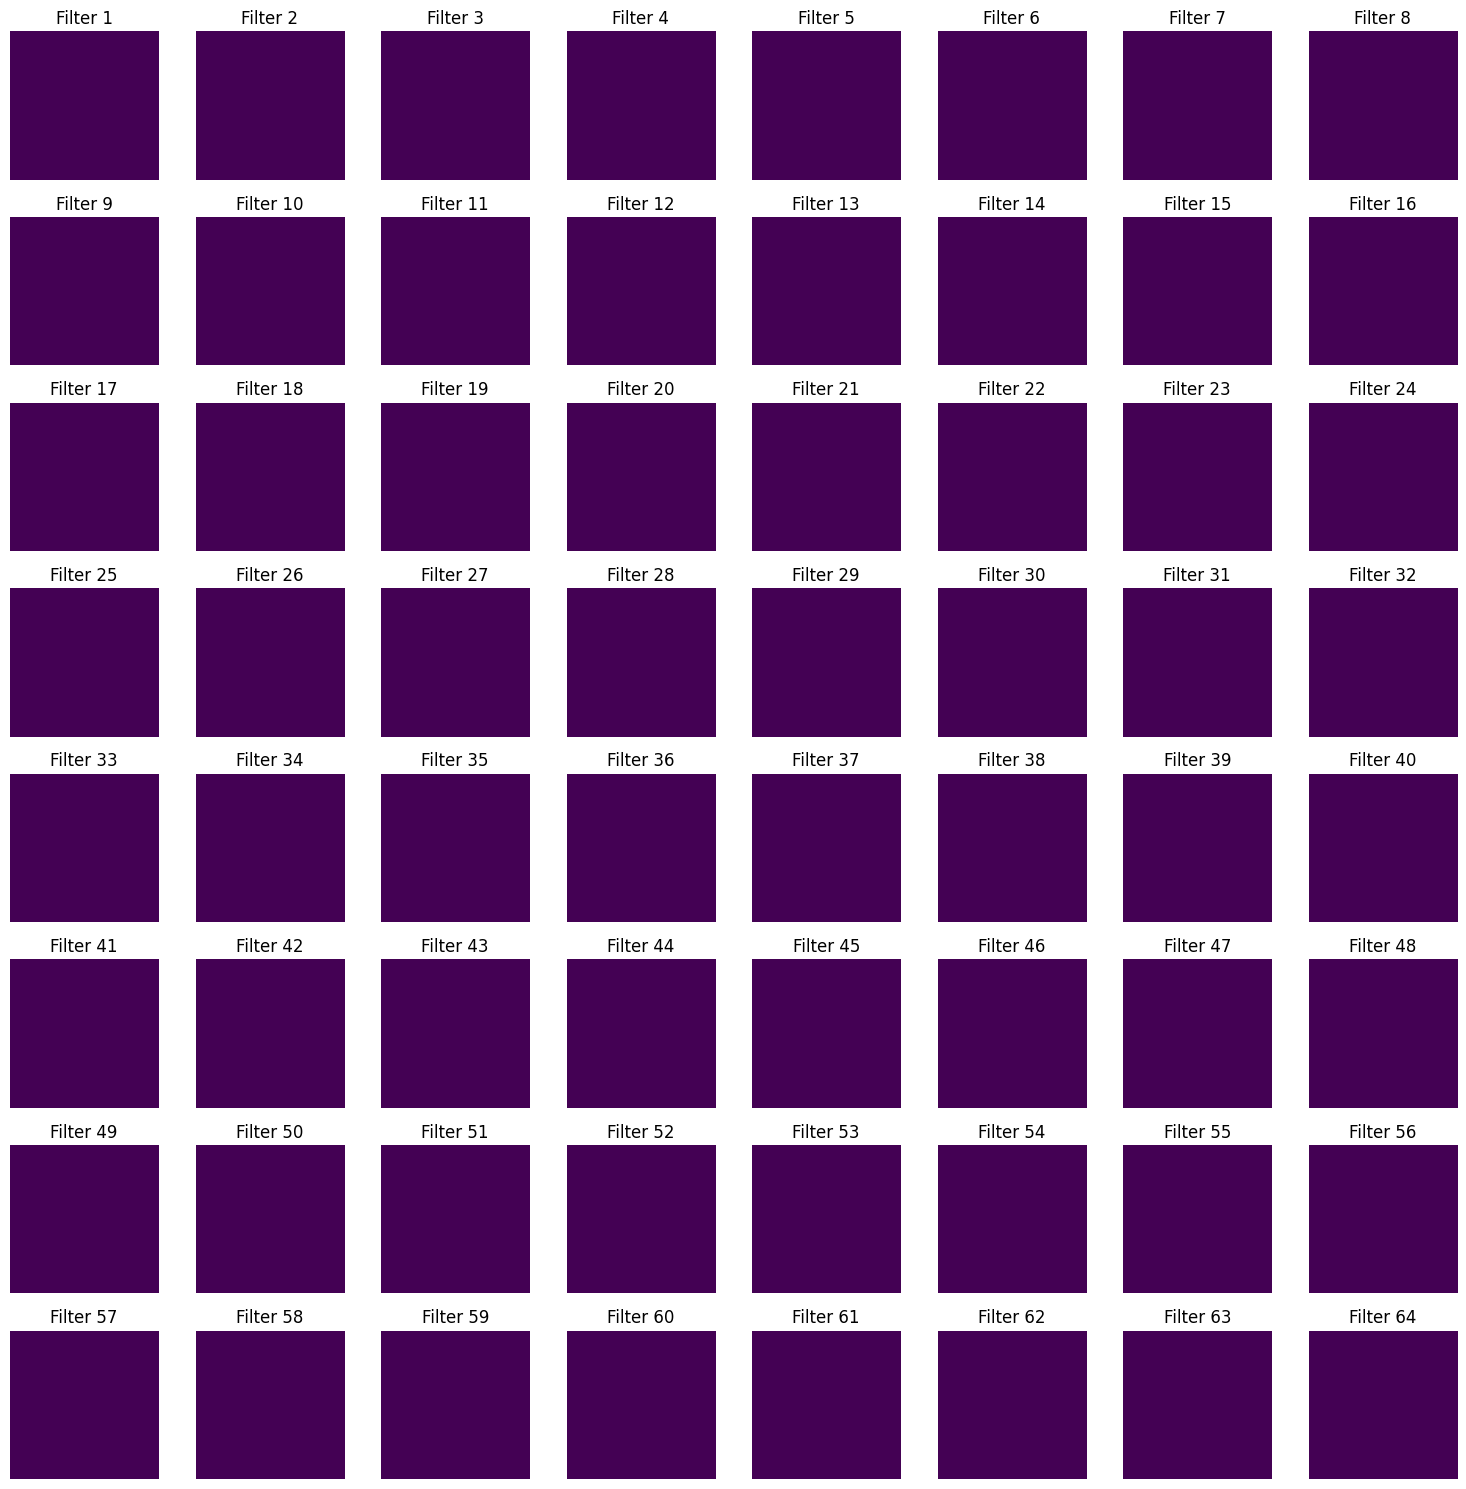

Visualizing filters for layer3.3.conv1


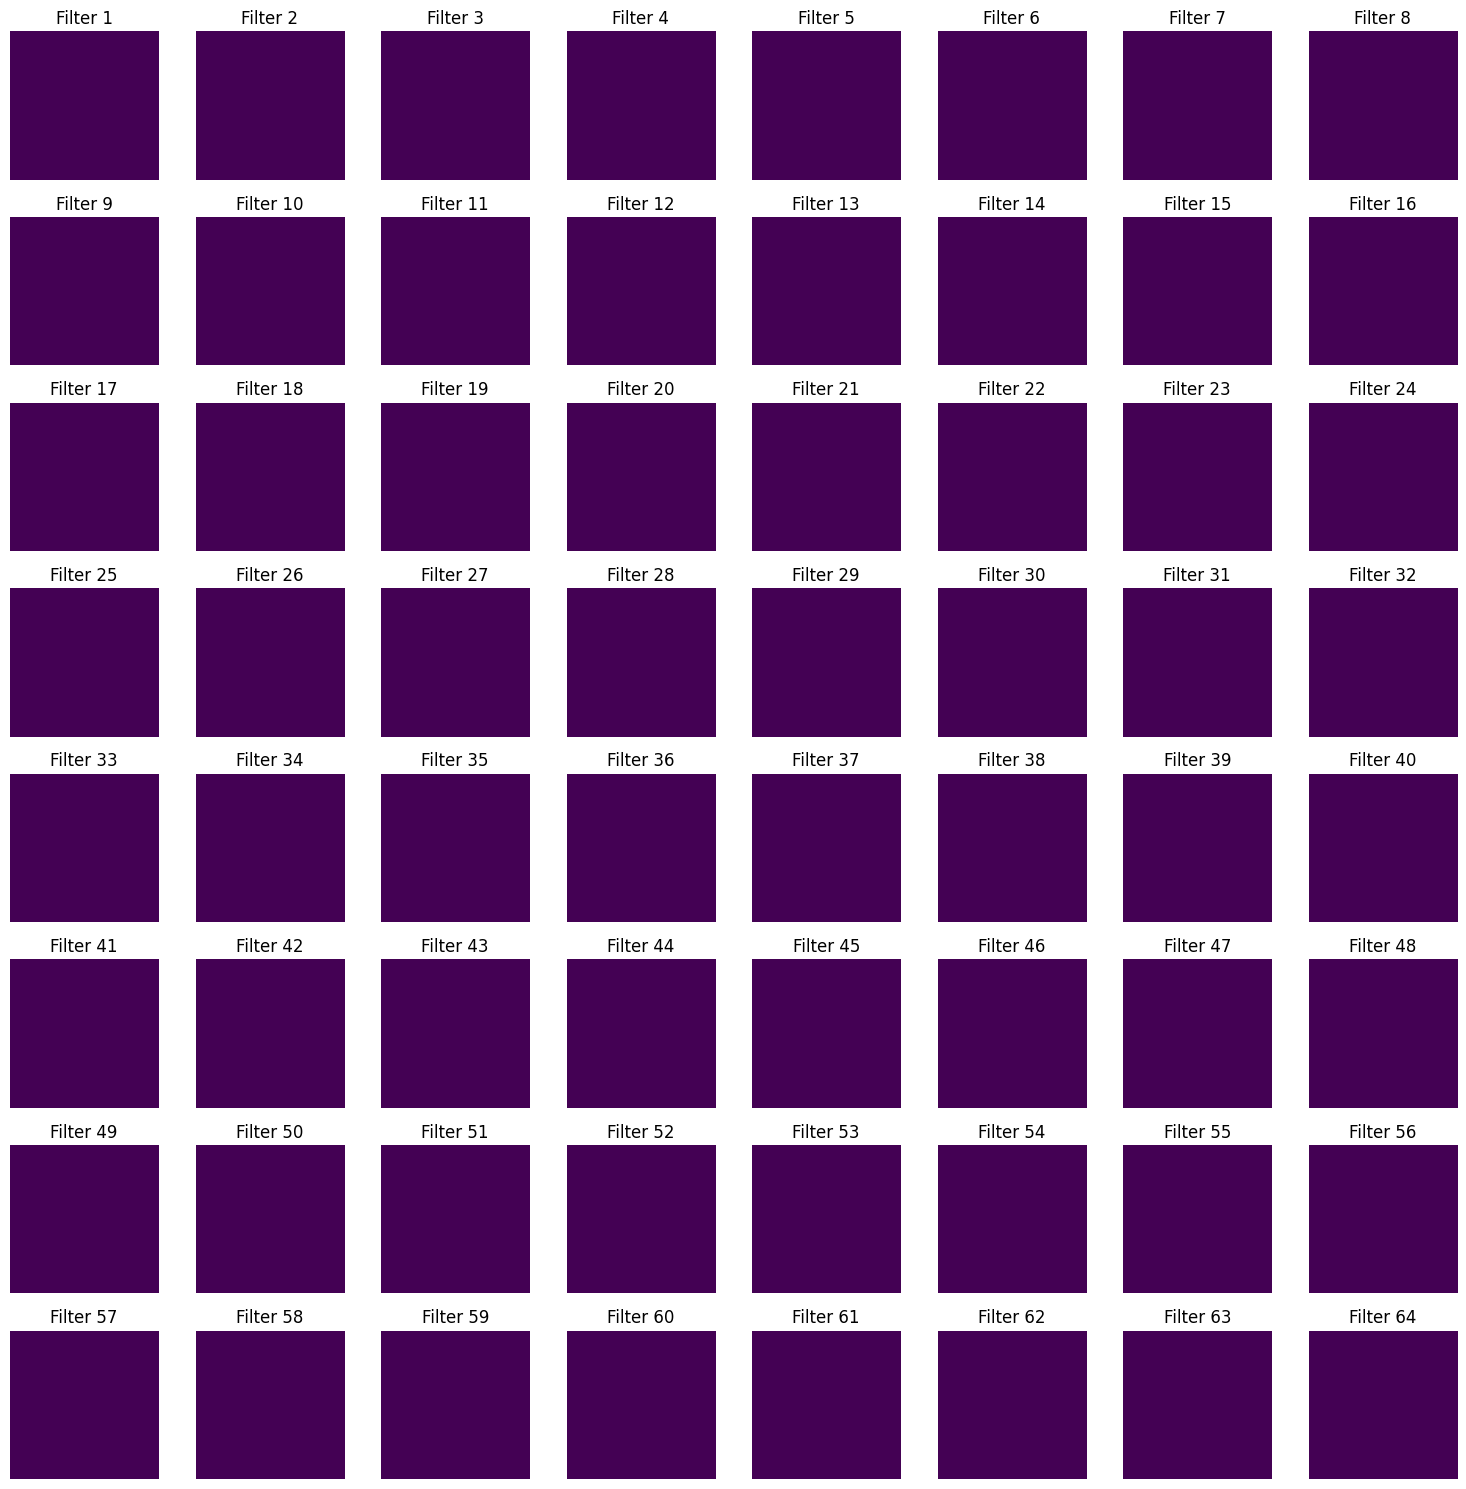

Visualizing filters for layer3.3.conv2


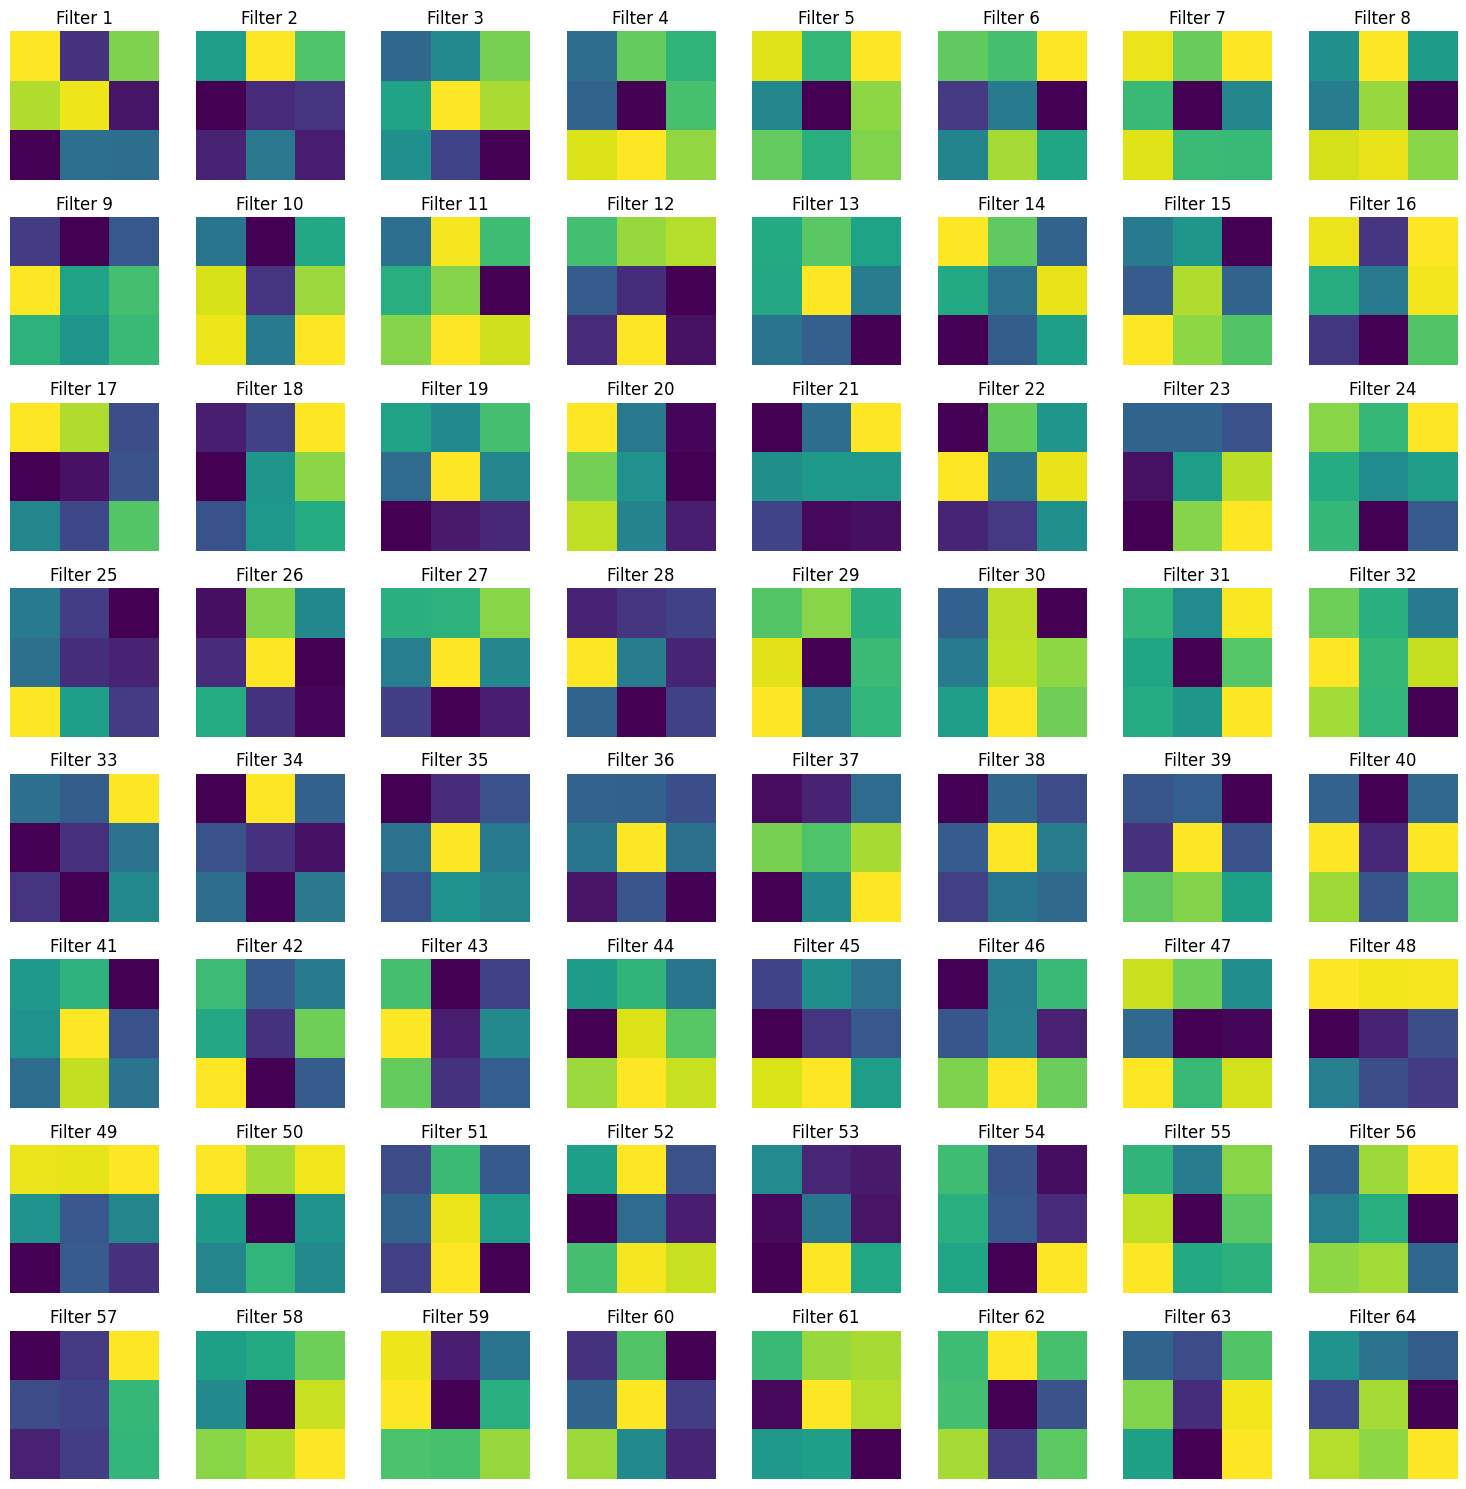

Visualizing filters for layer3.3.conv3


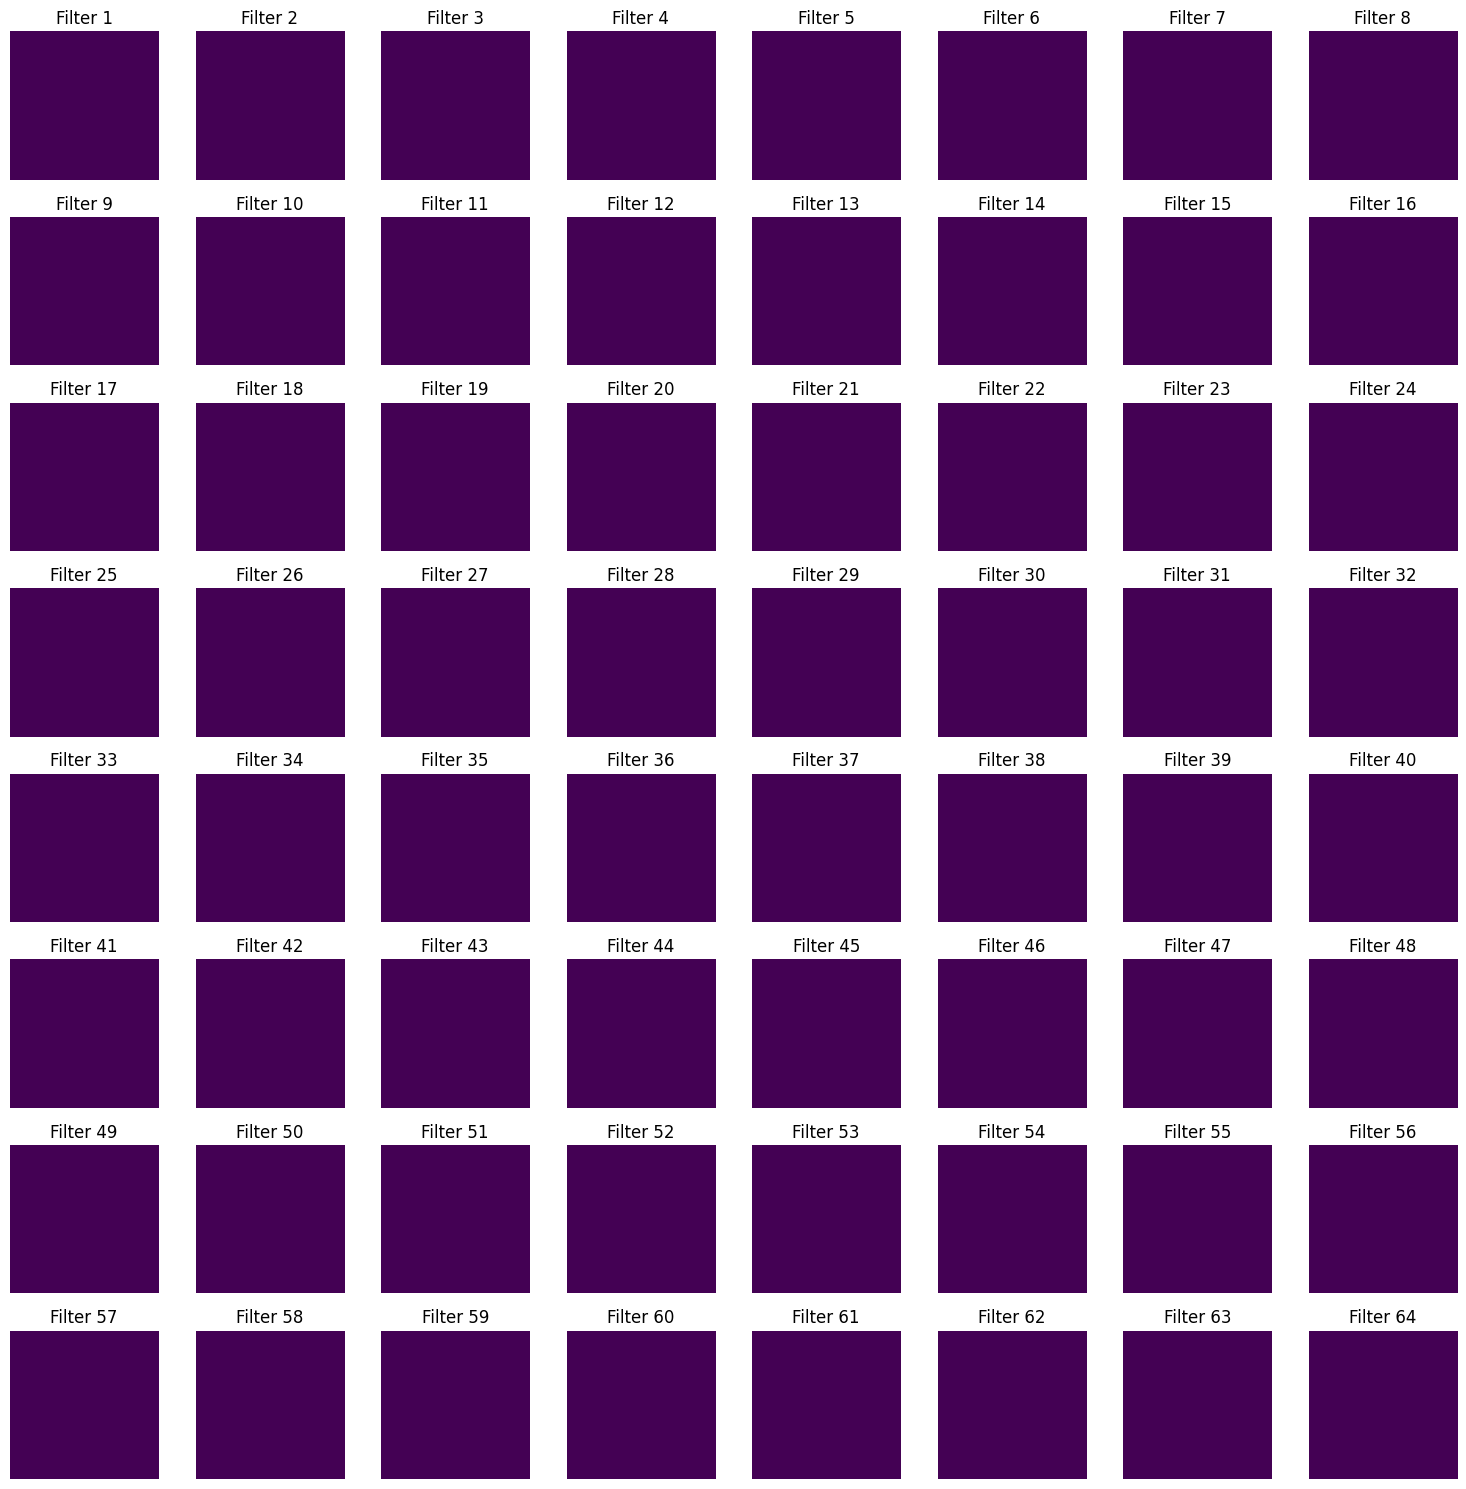

Visualizing filters for layer3.4.conv1


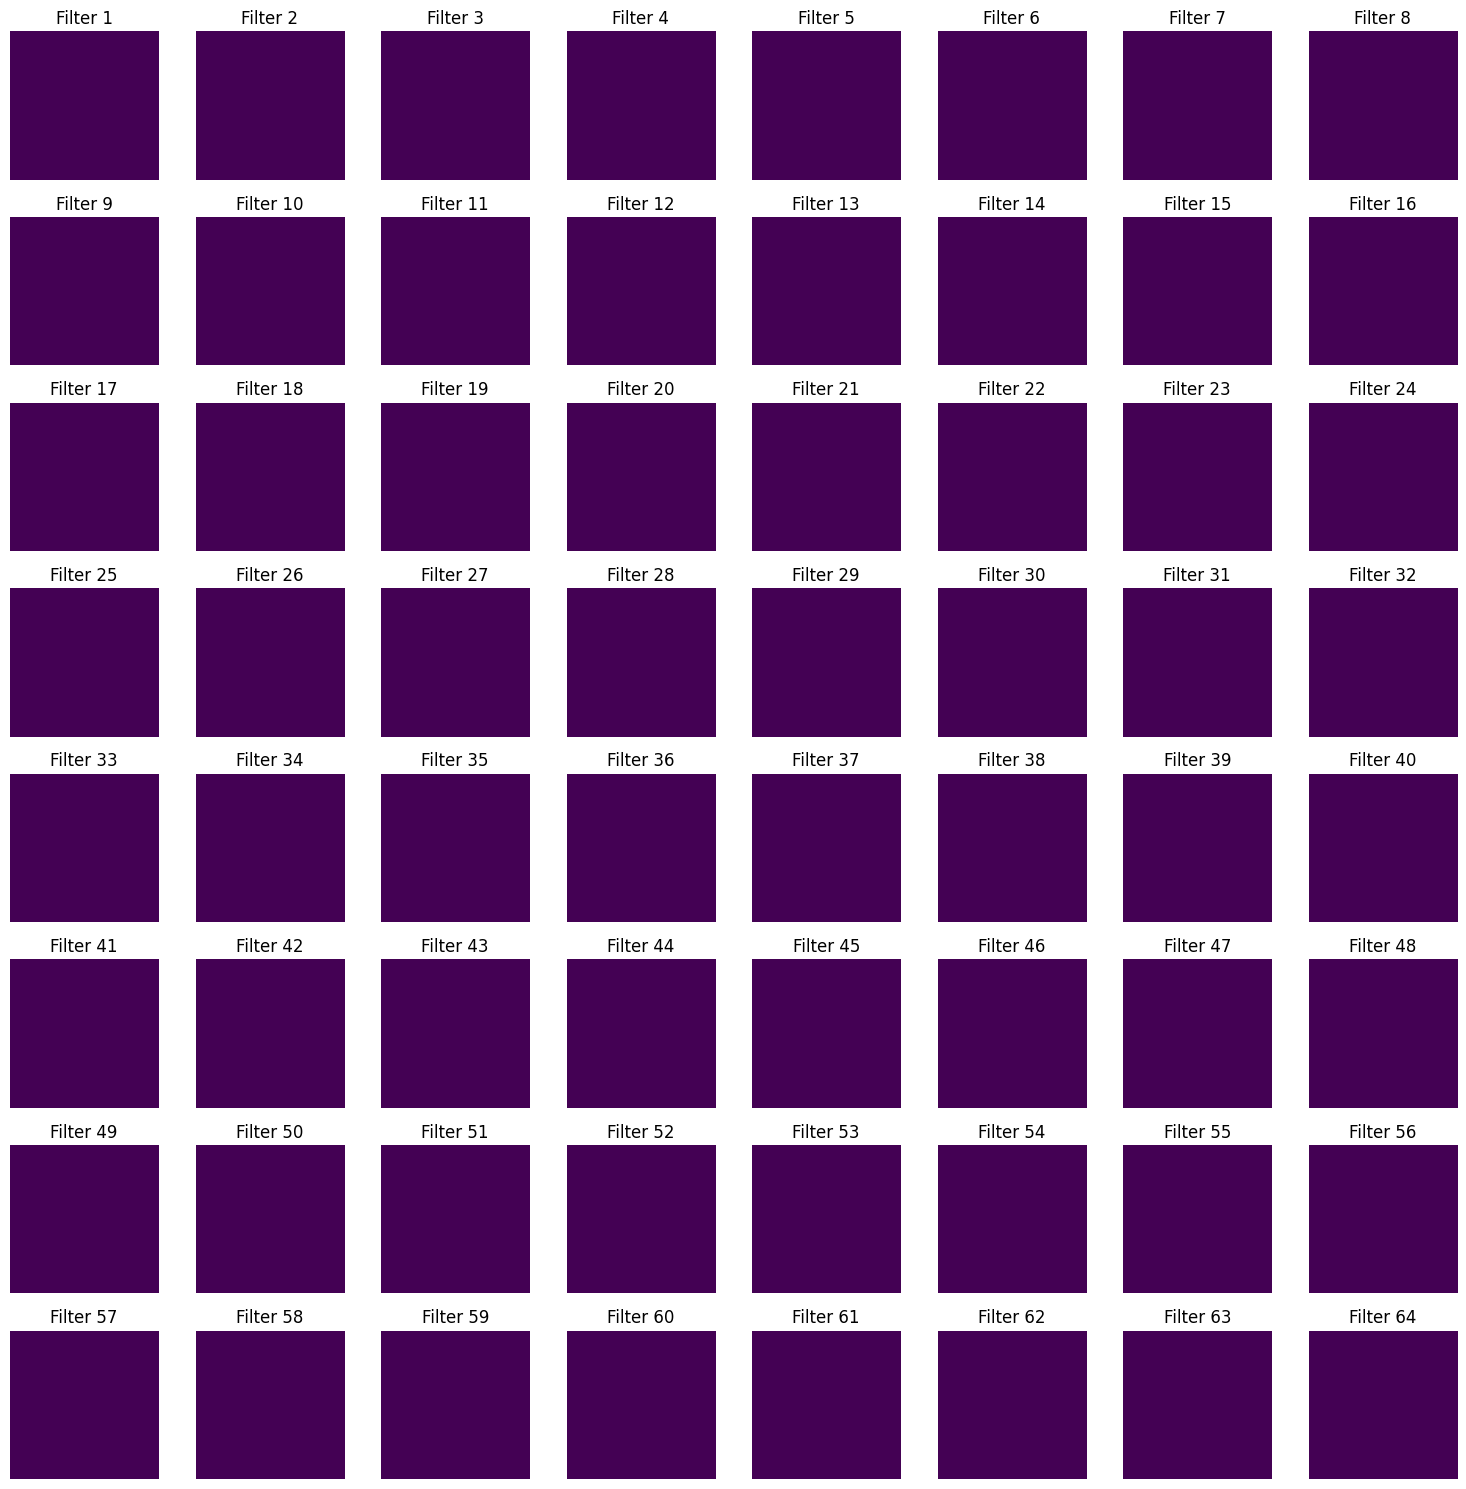

Visualizing filters for layer3.4.conv2


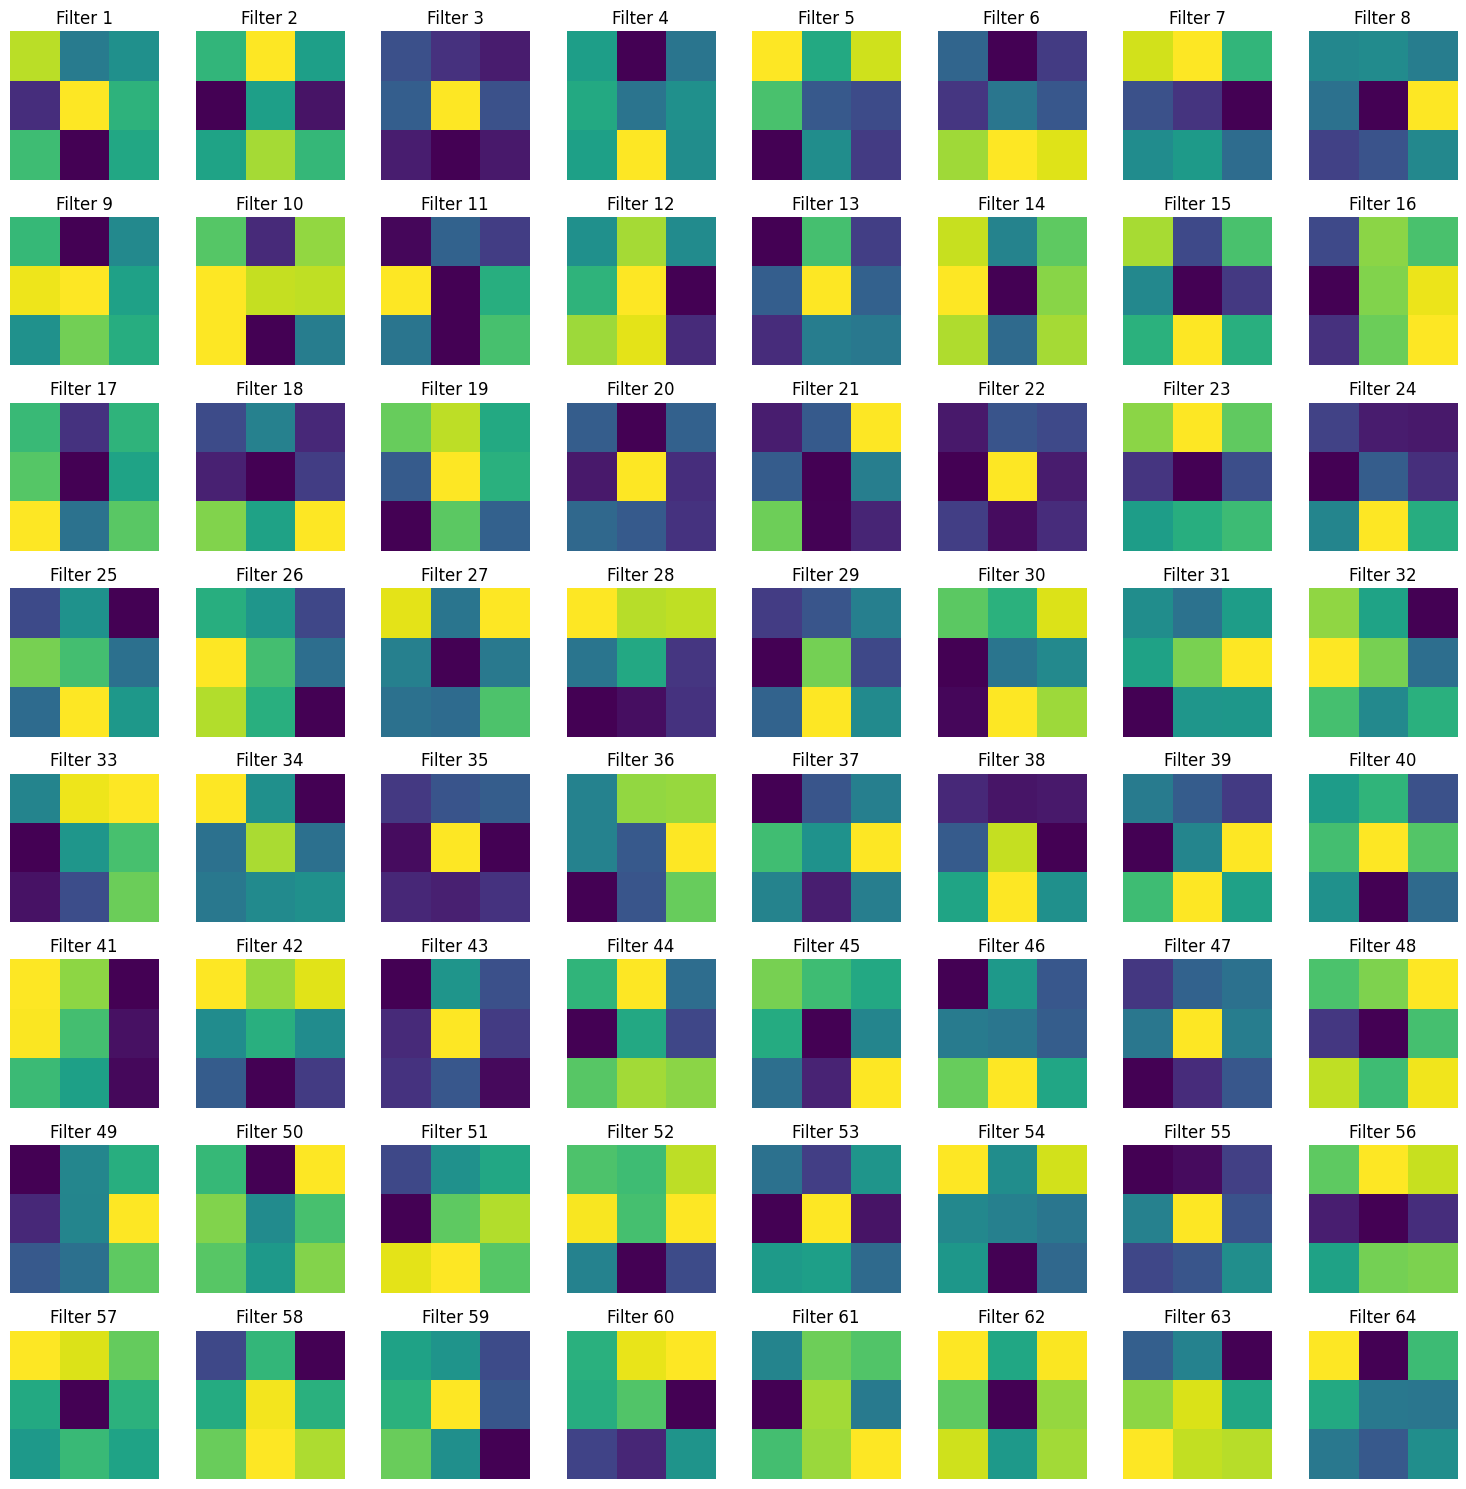

Visualizing filters for layer3.4.conv3


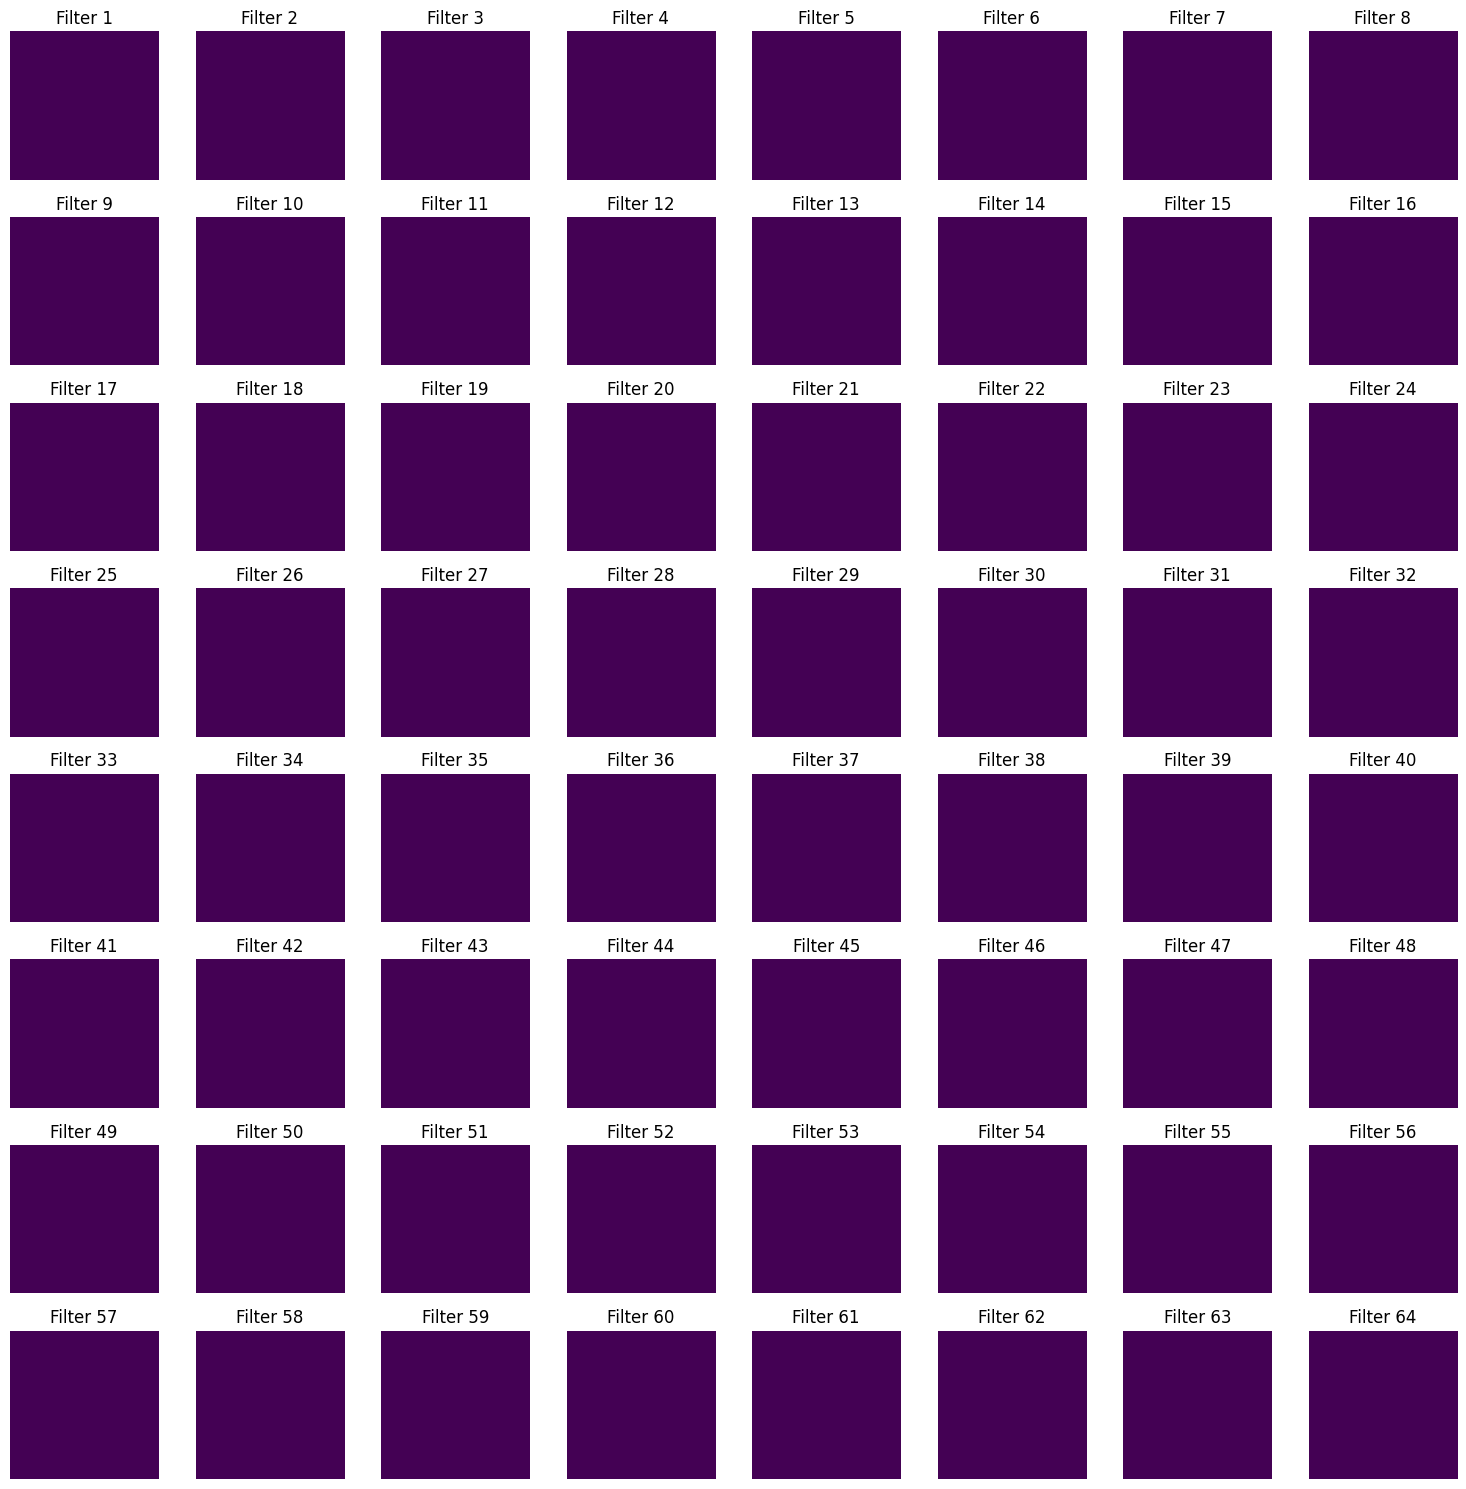

Visualizing filters for layer3.5.conv1


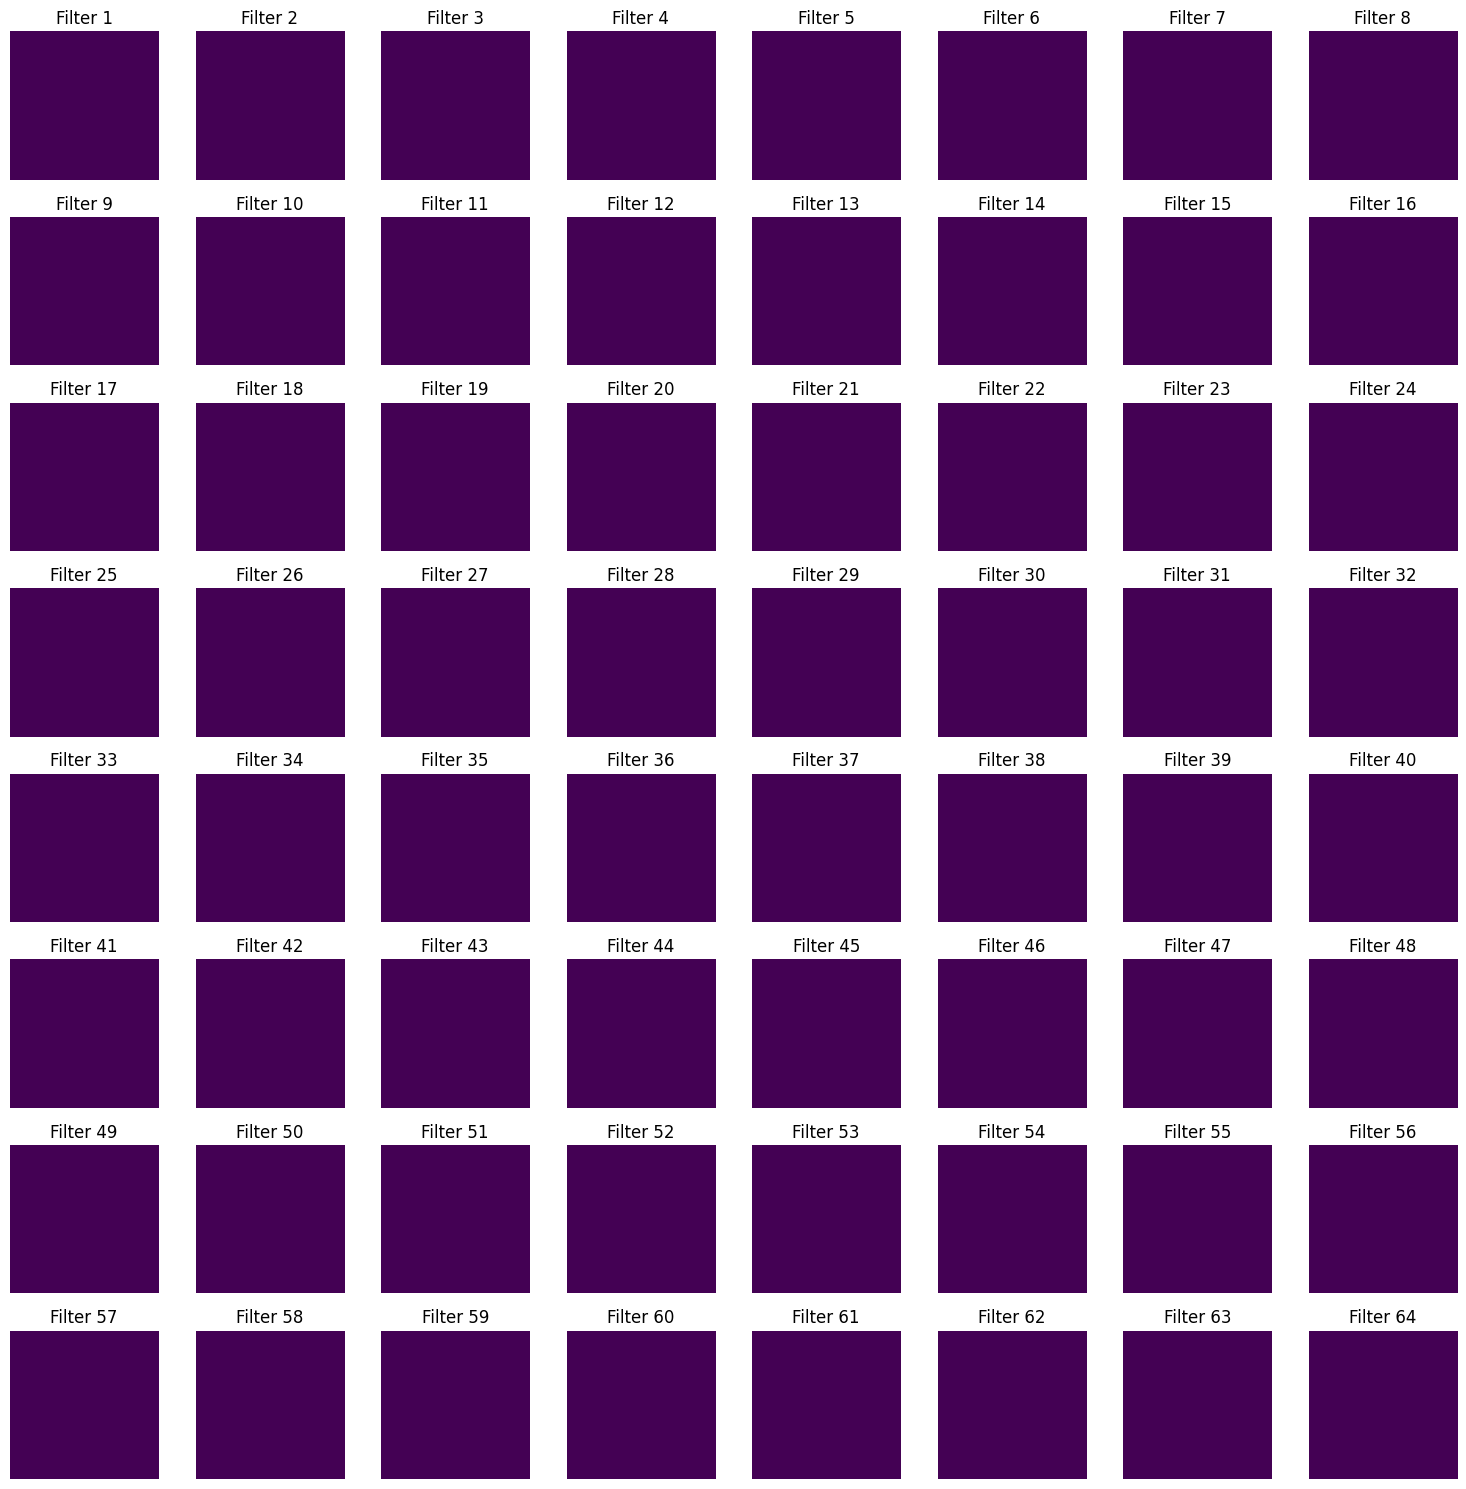

Visualizing filters for layer3.5.conv2


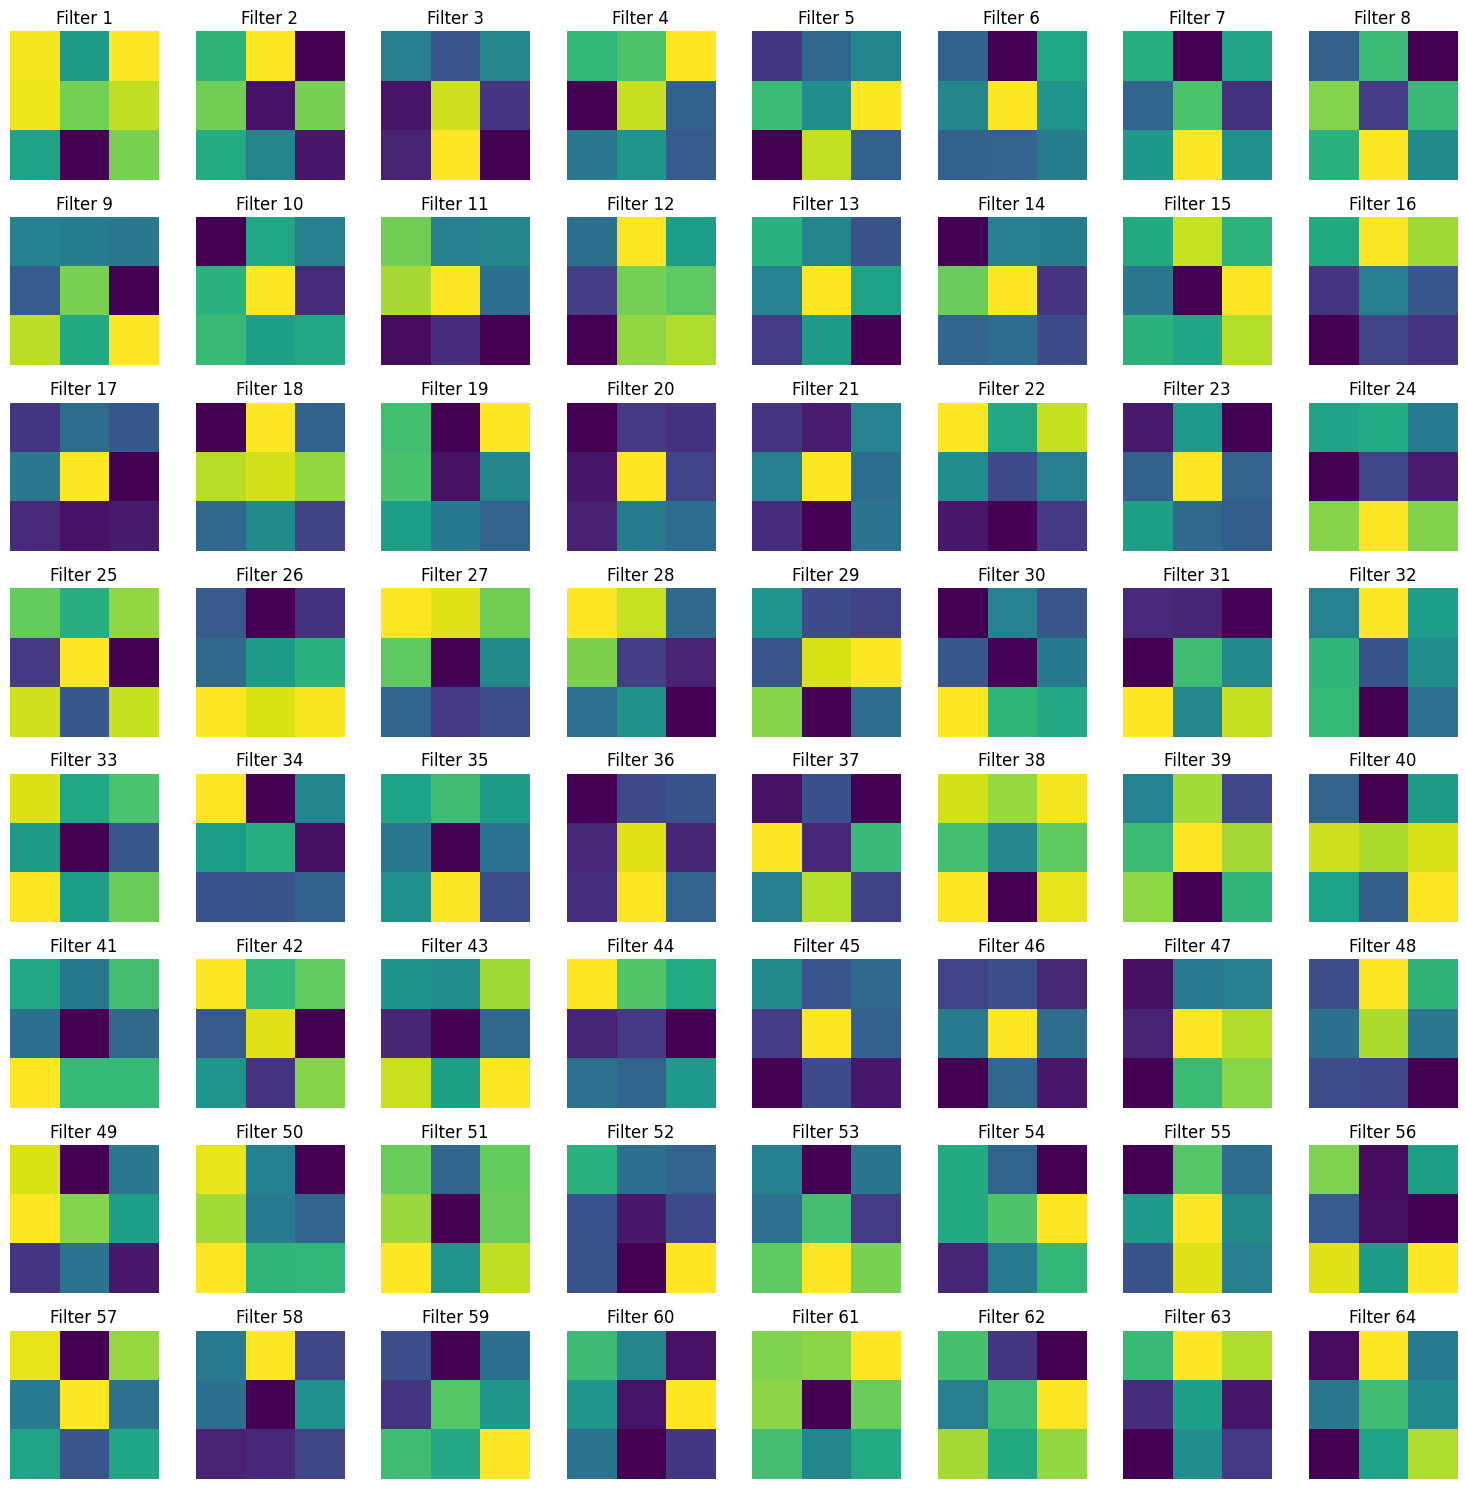

Visualizing filters for layer3.5.conv3


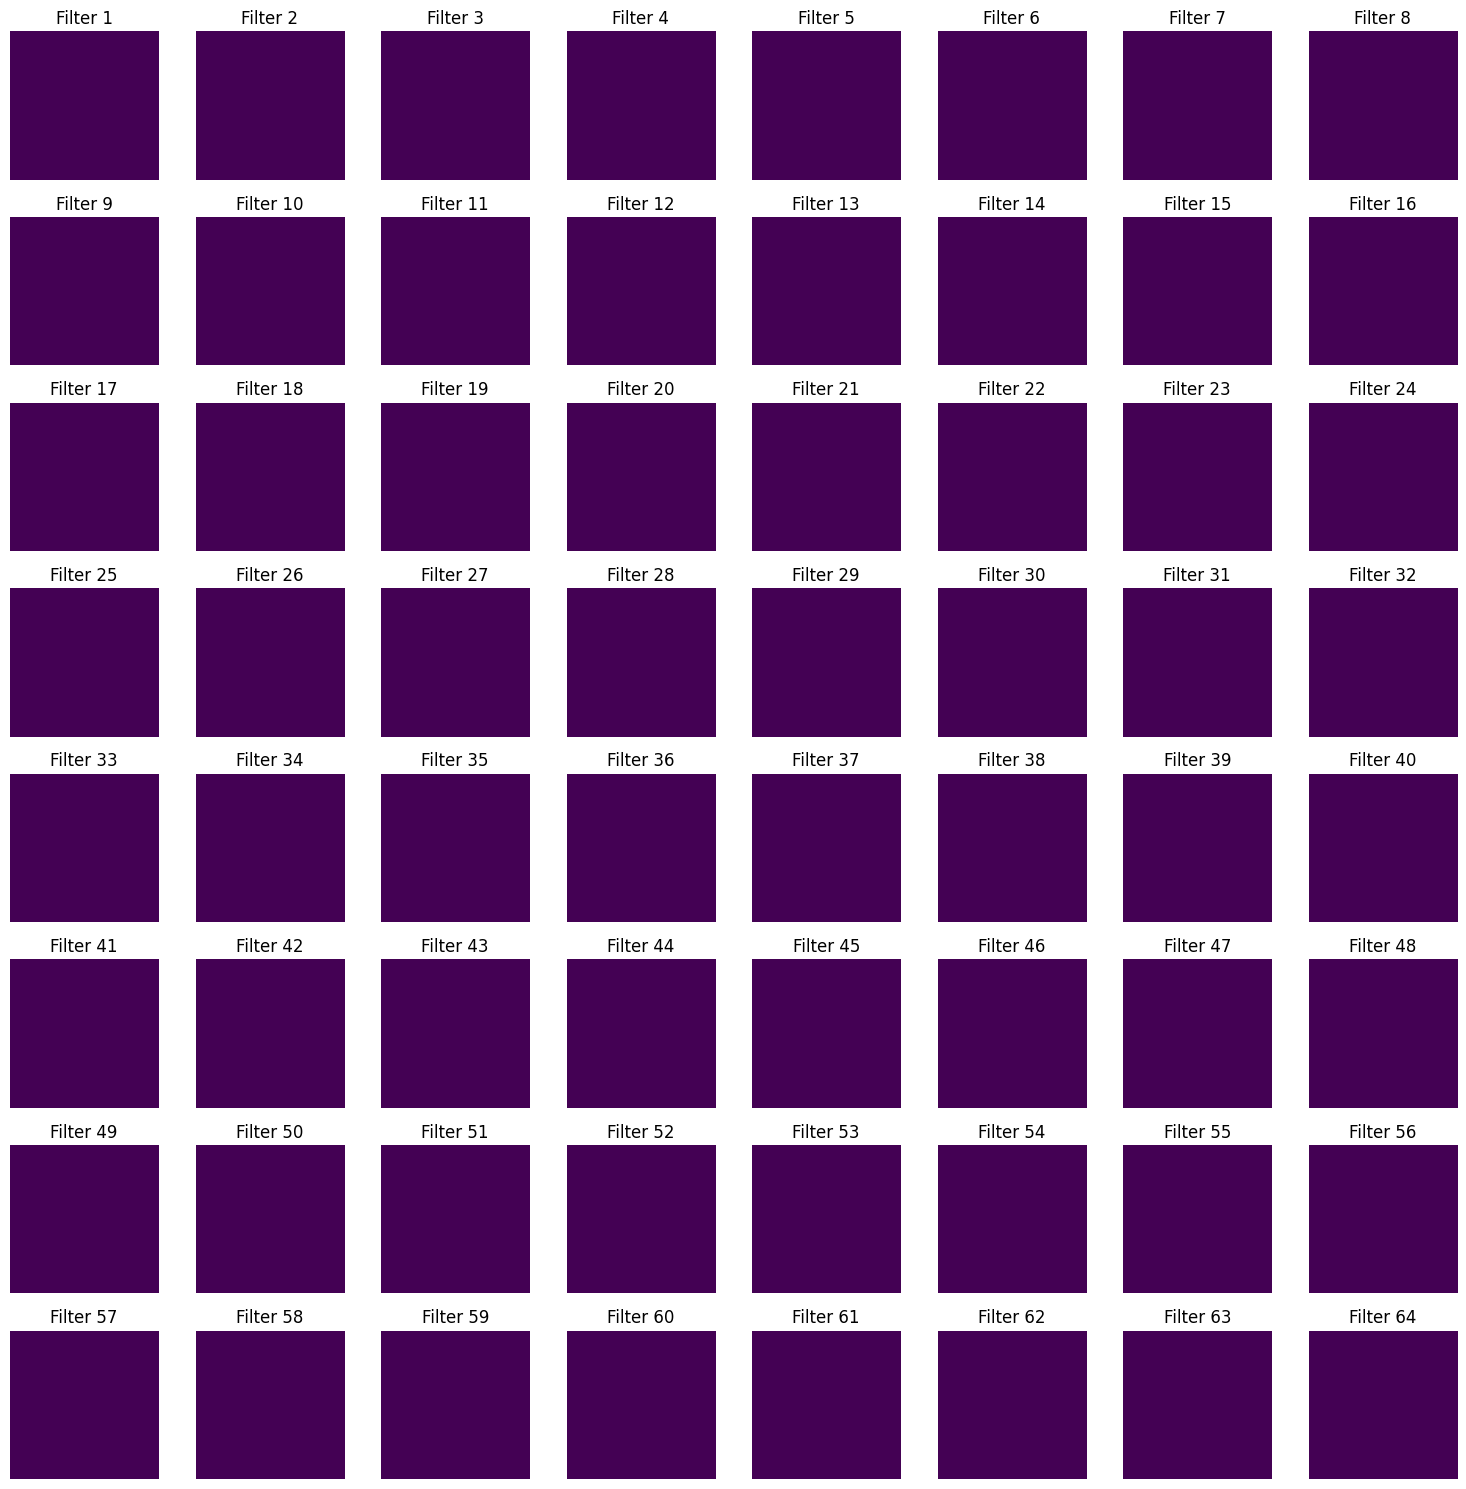

Visualizing filters for layer4.0.conv1


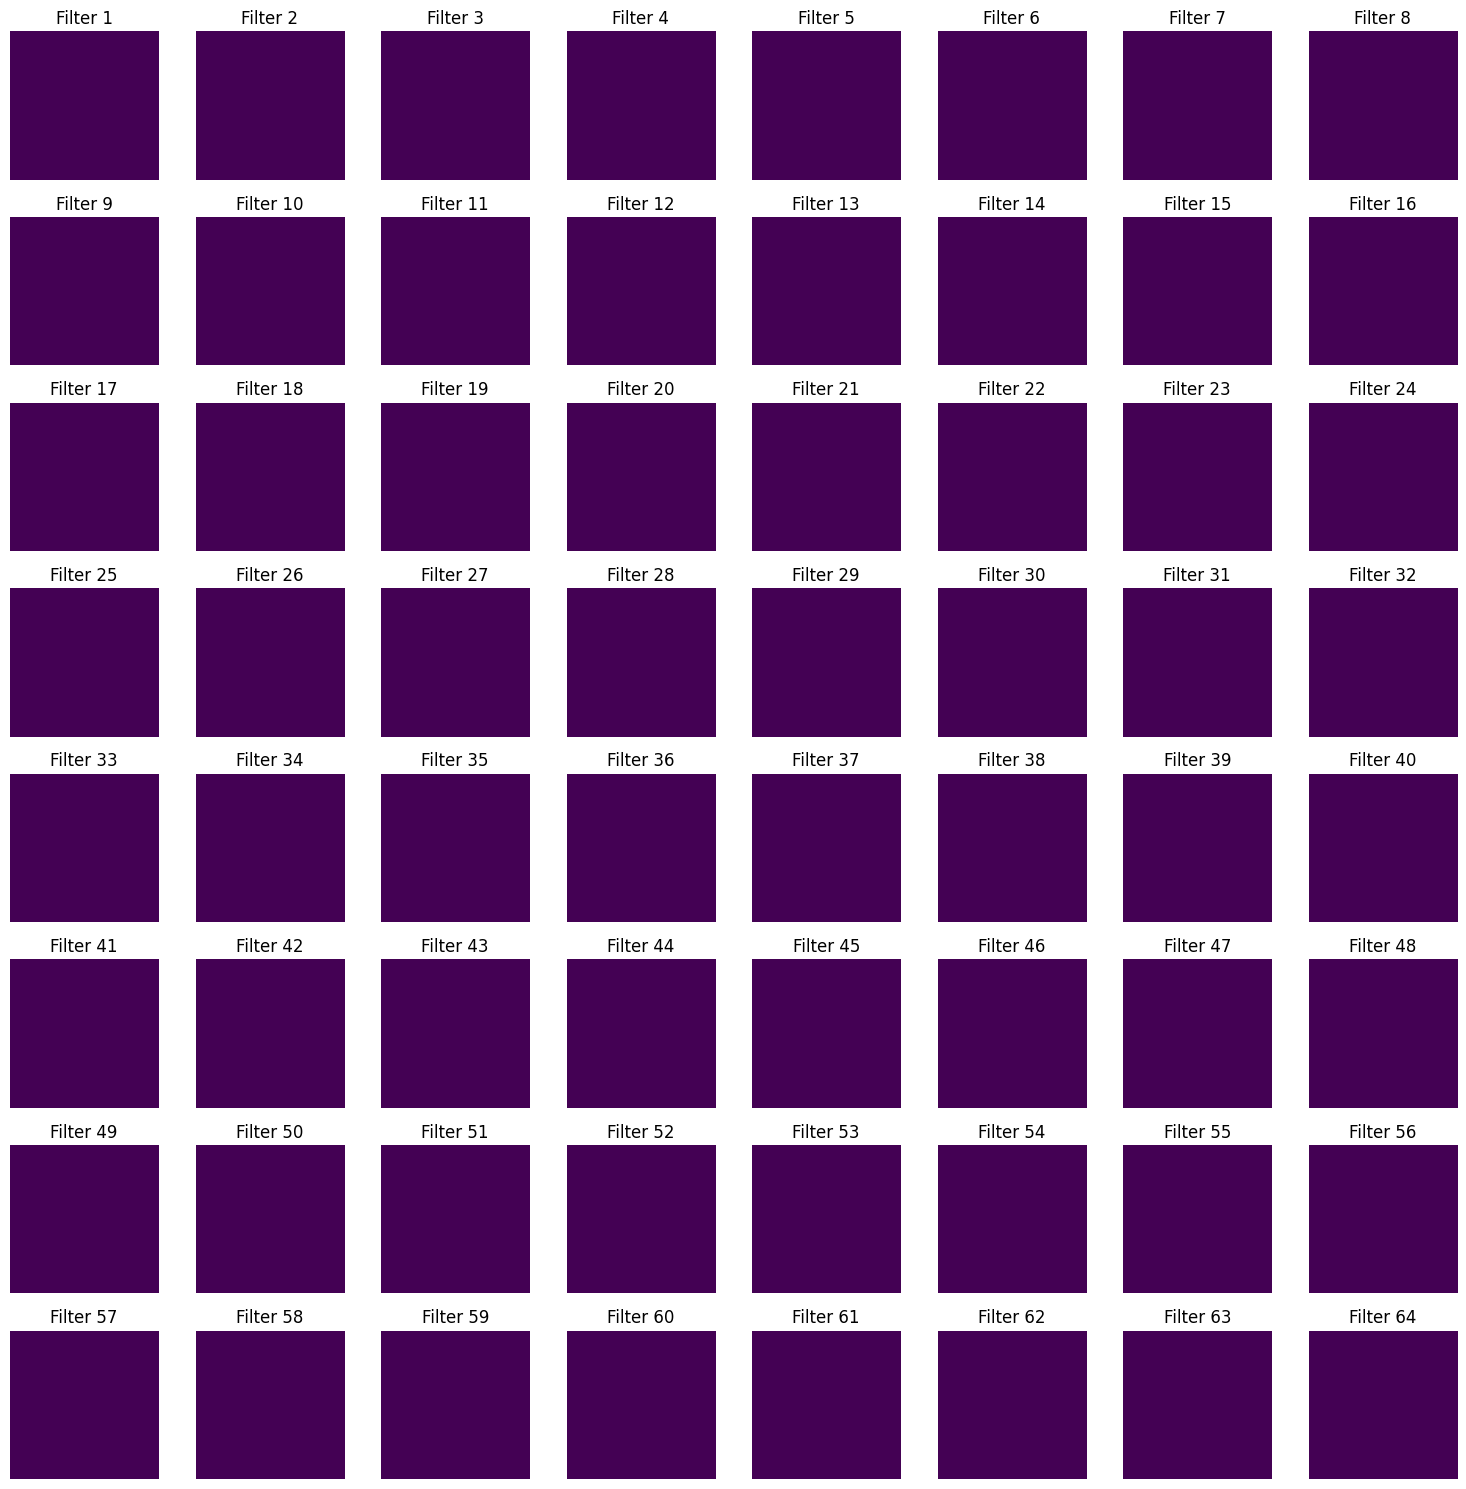

Visualizing filters for layer4.0.conv2


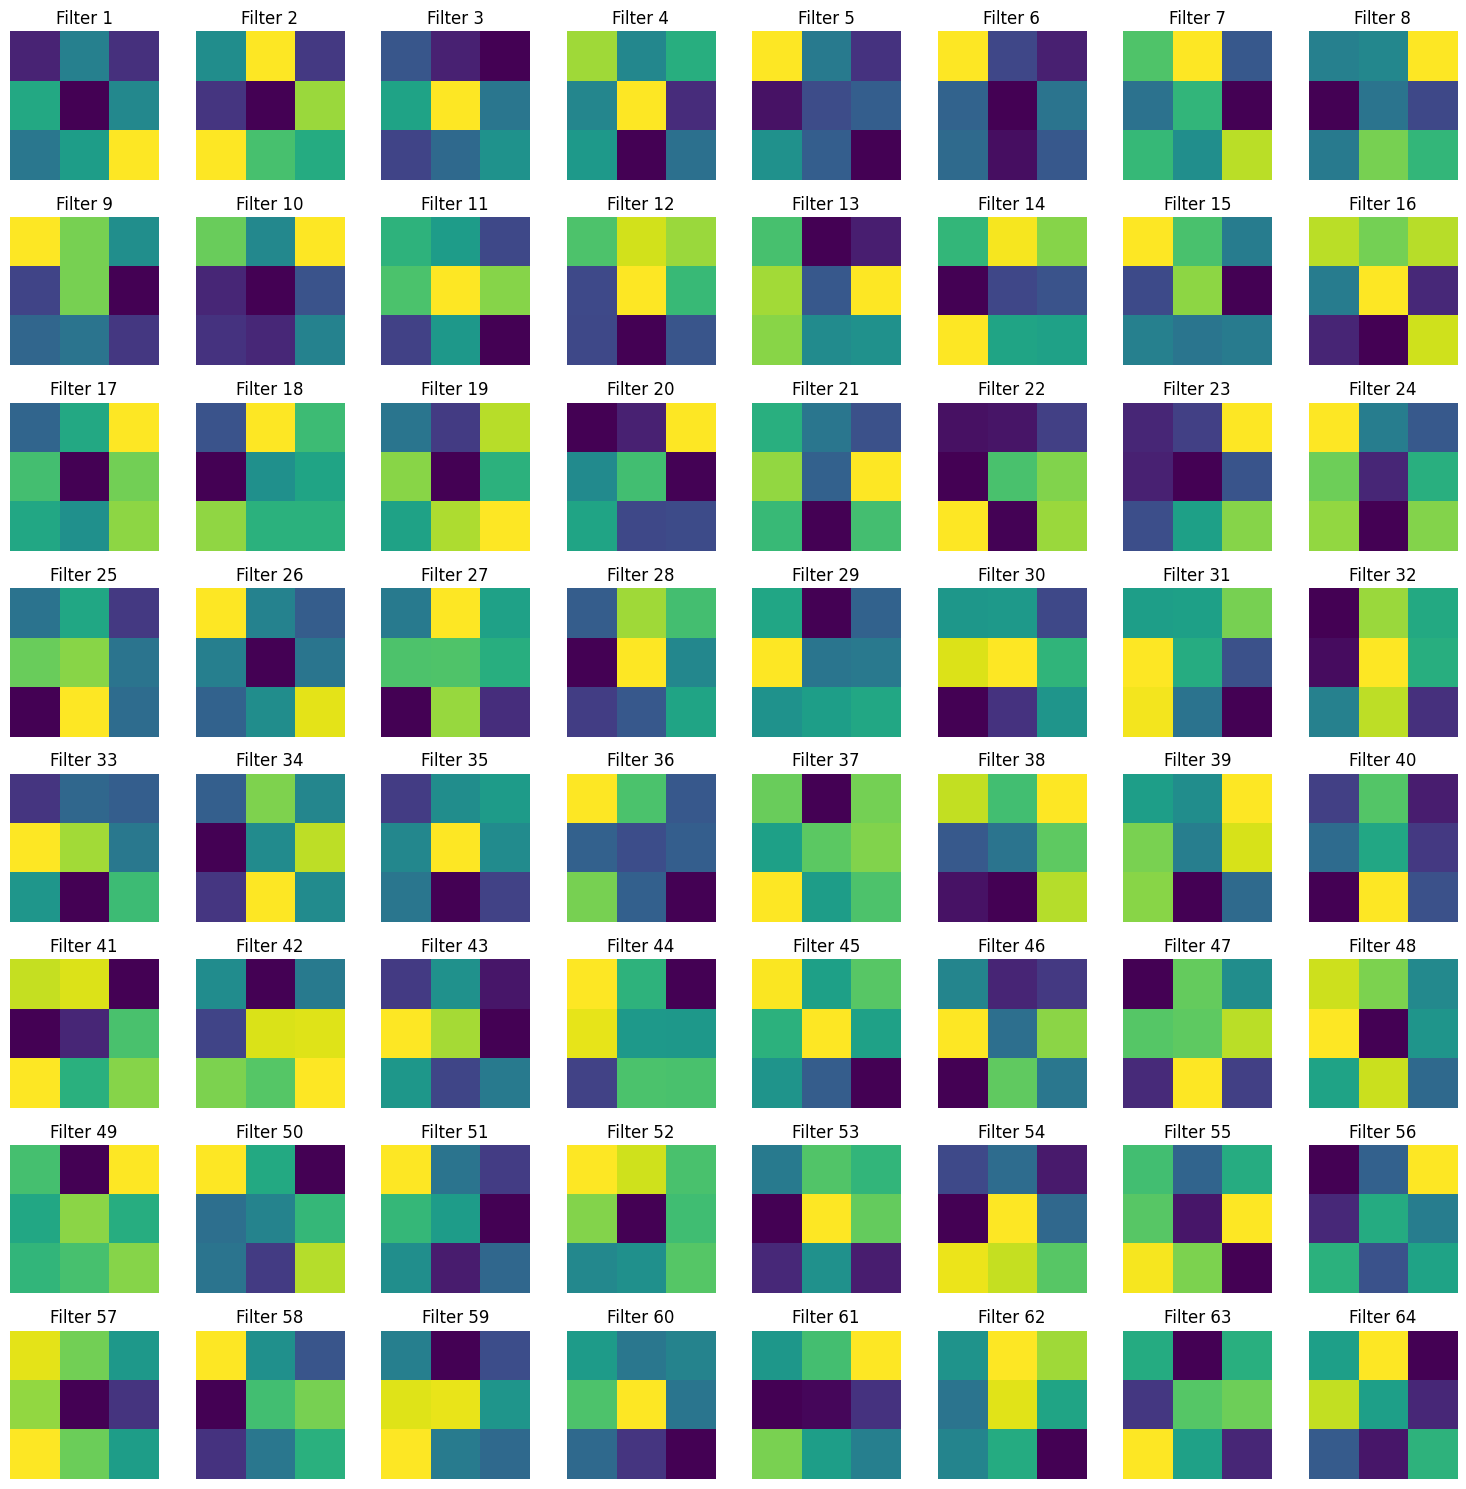

Visualizing filters for layer4.0.conv3


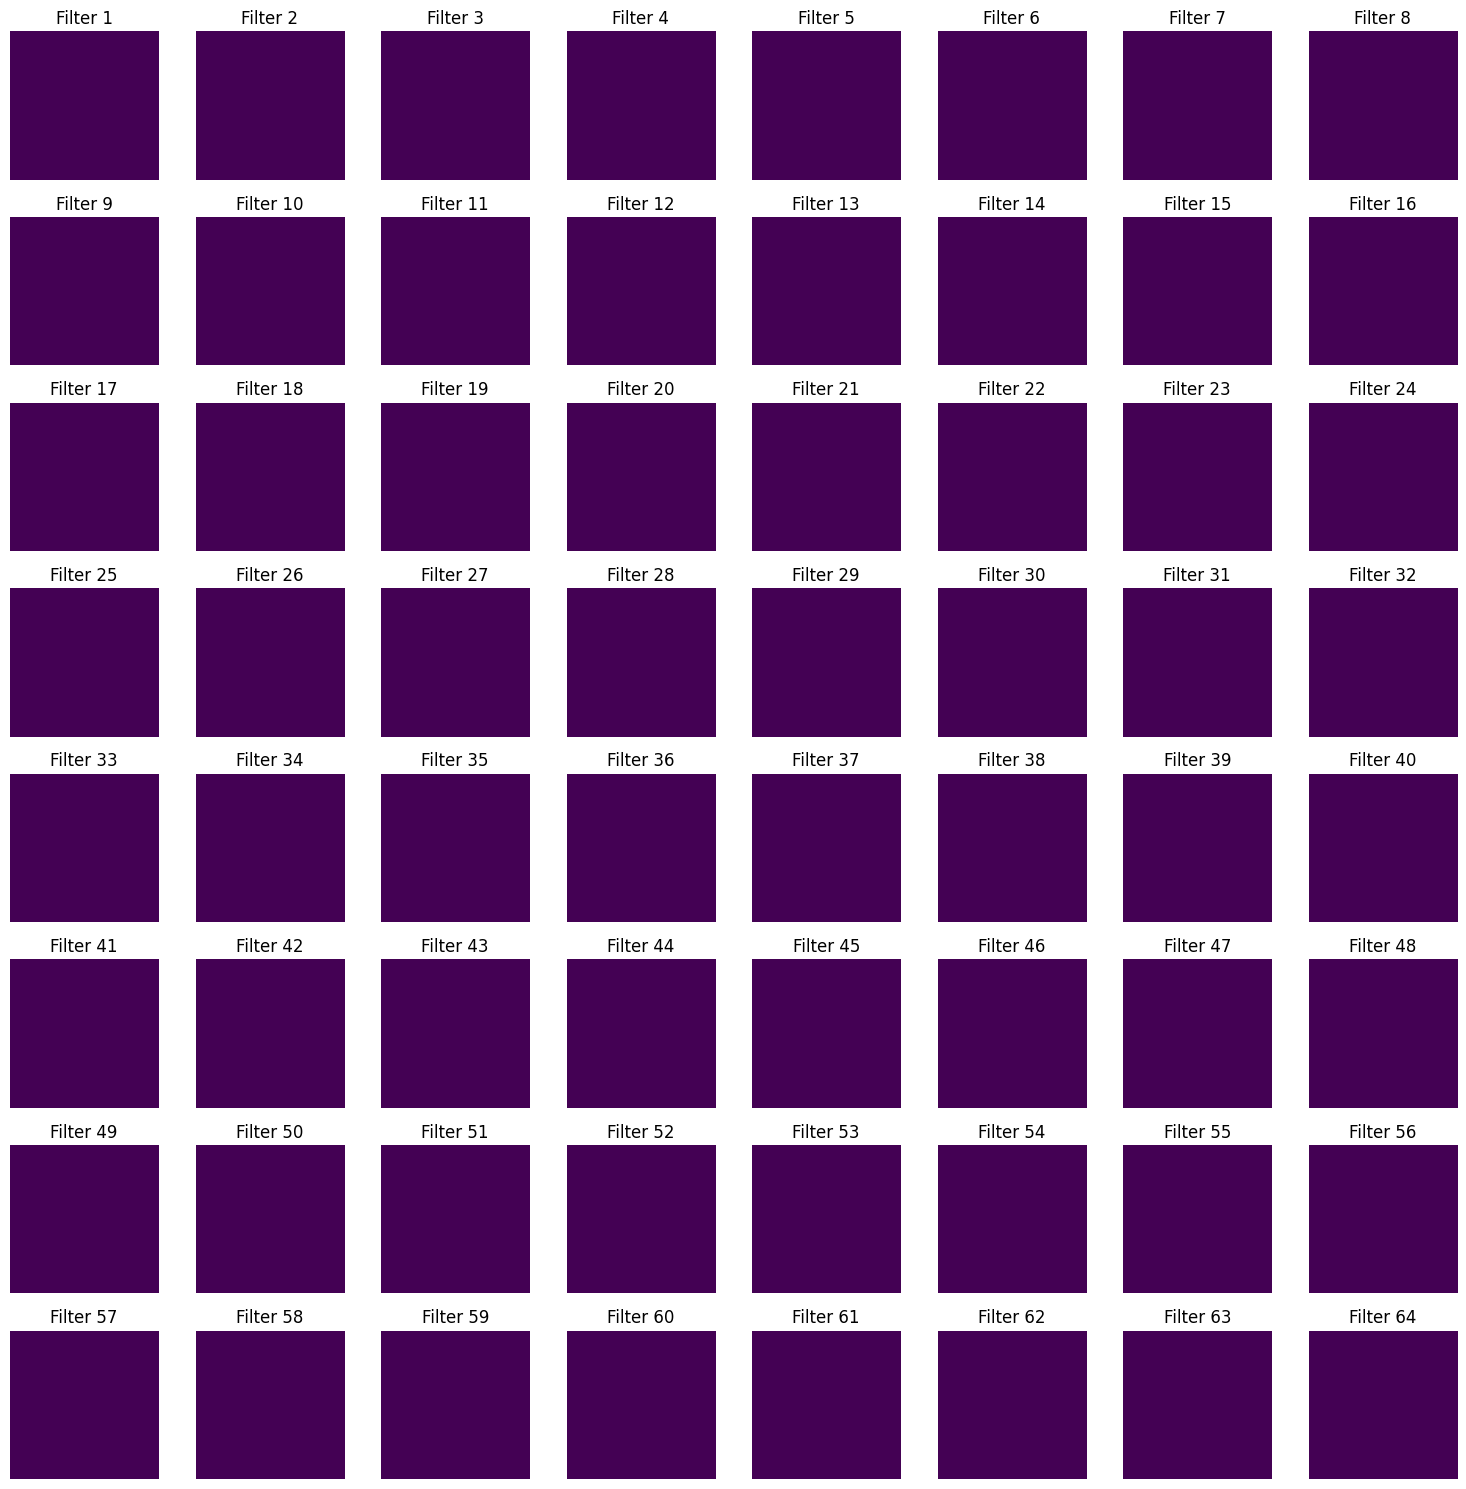

Visualizing filters for layer4.0.downsample.0


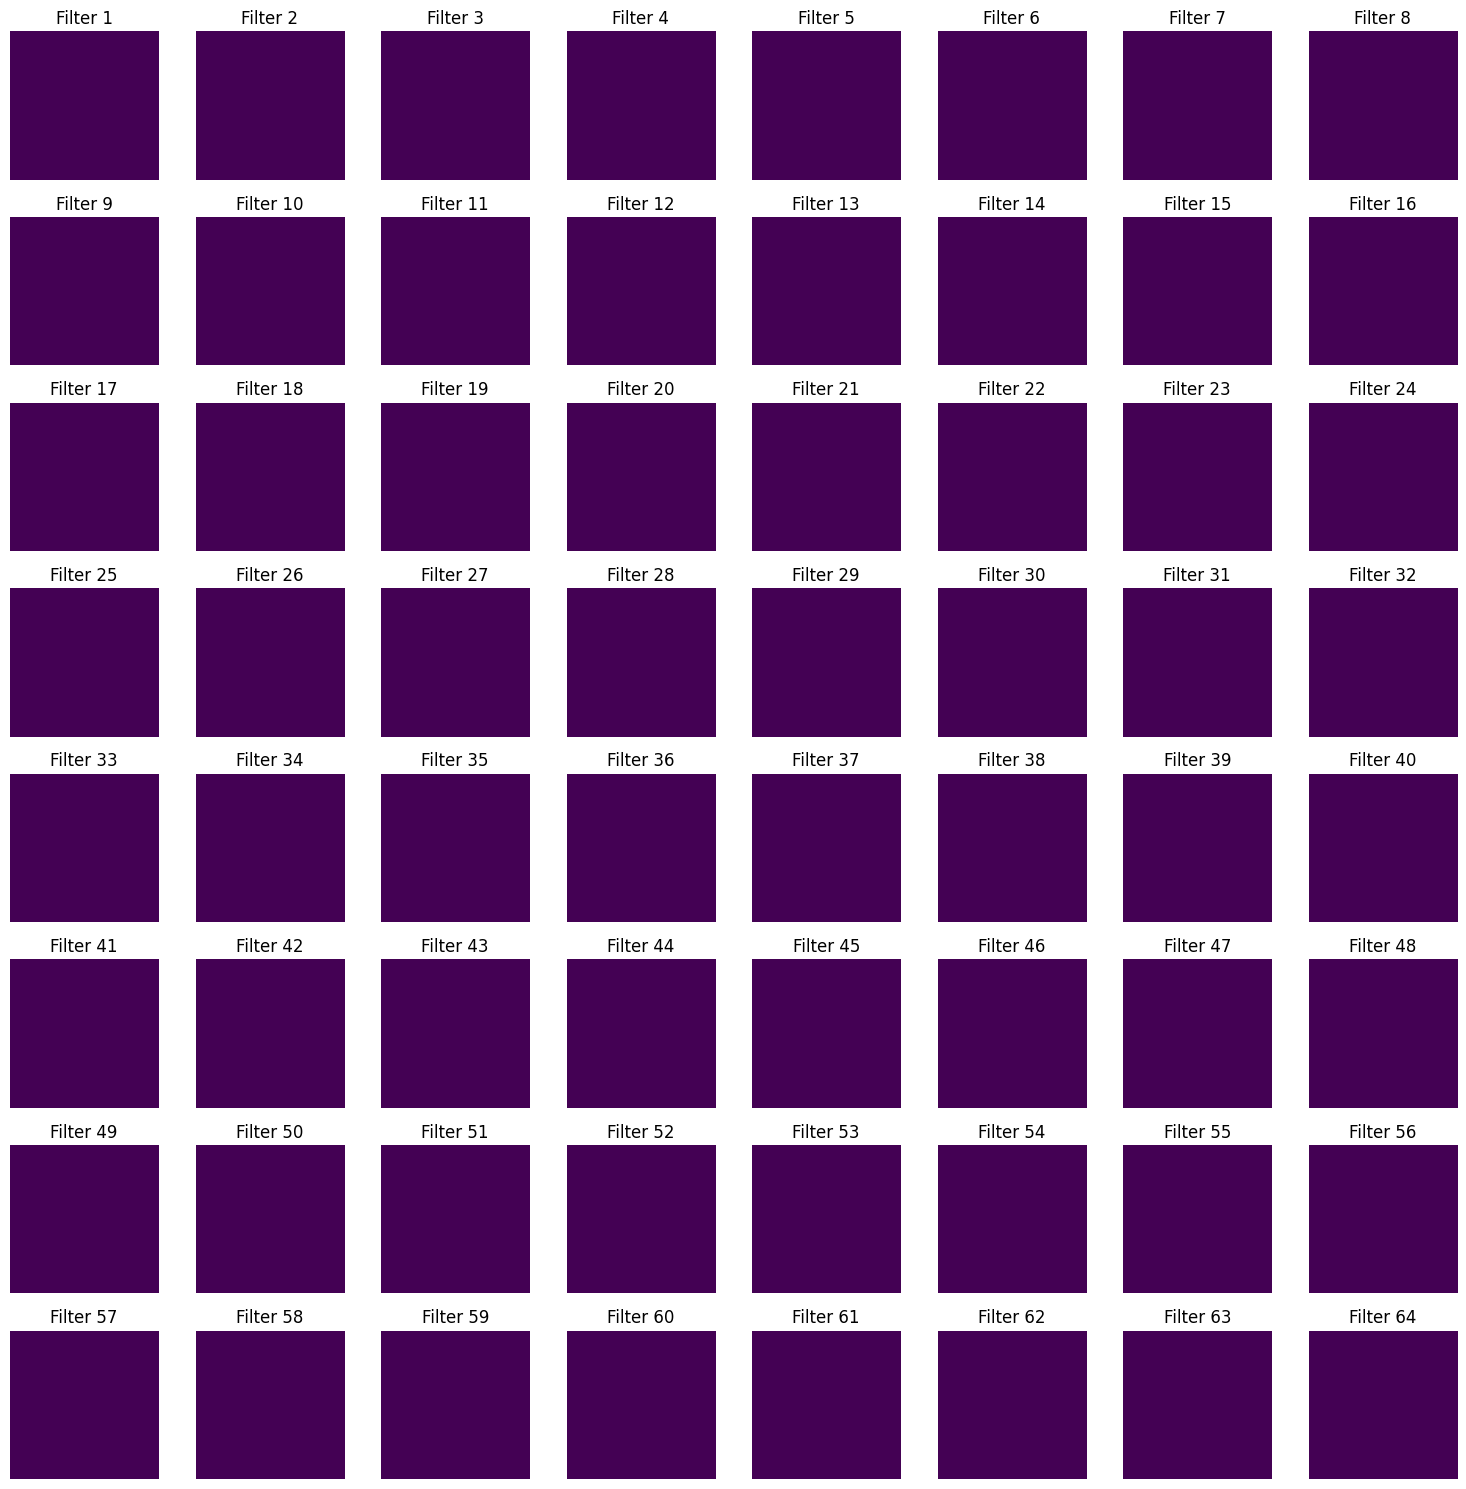

Visualizing filters for layer4.1.conv1


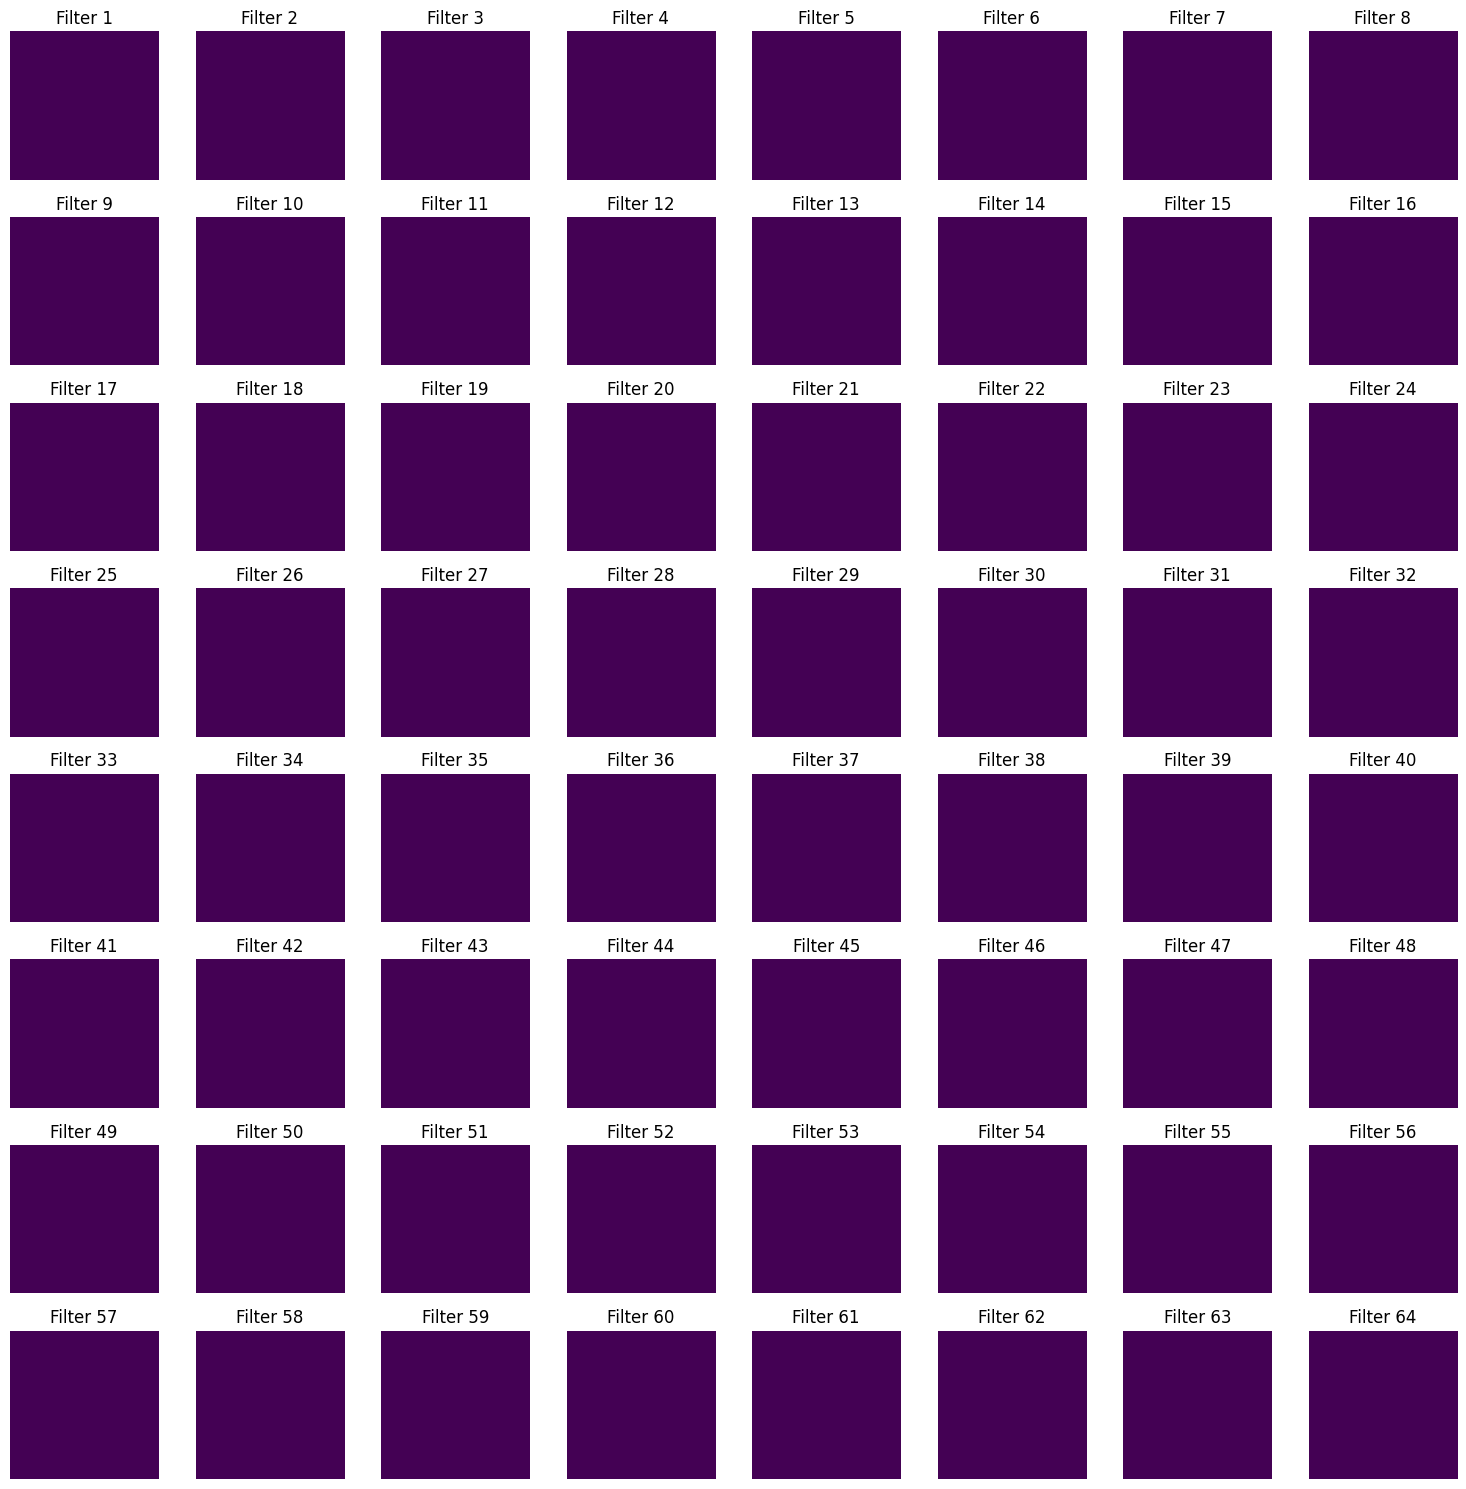

Visualizing filters for layer4.1.conv2


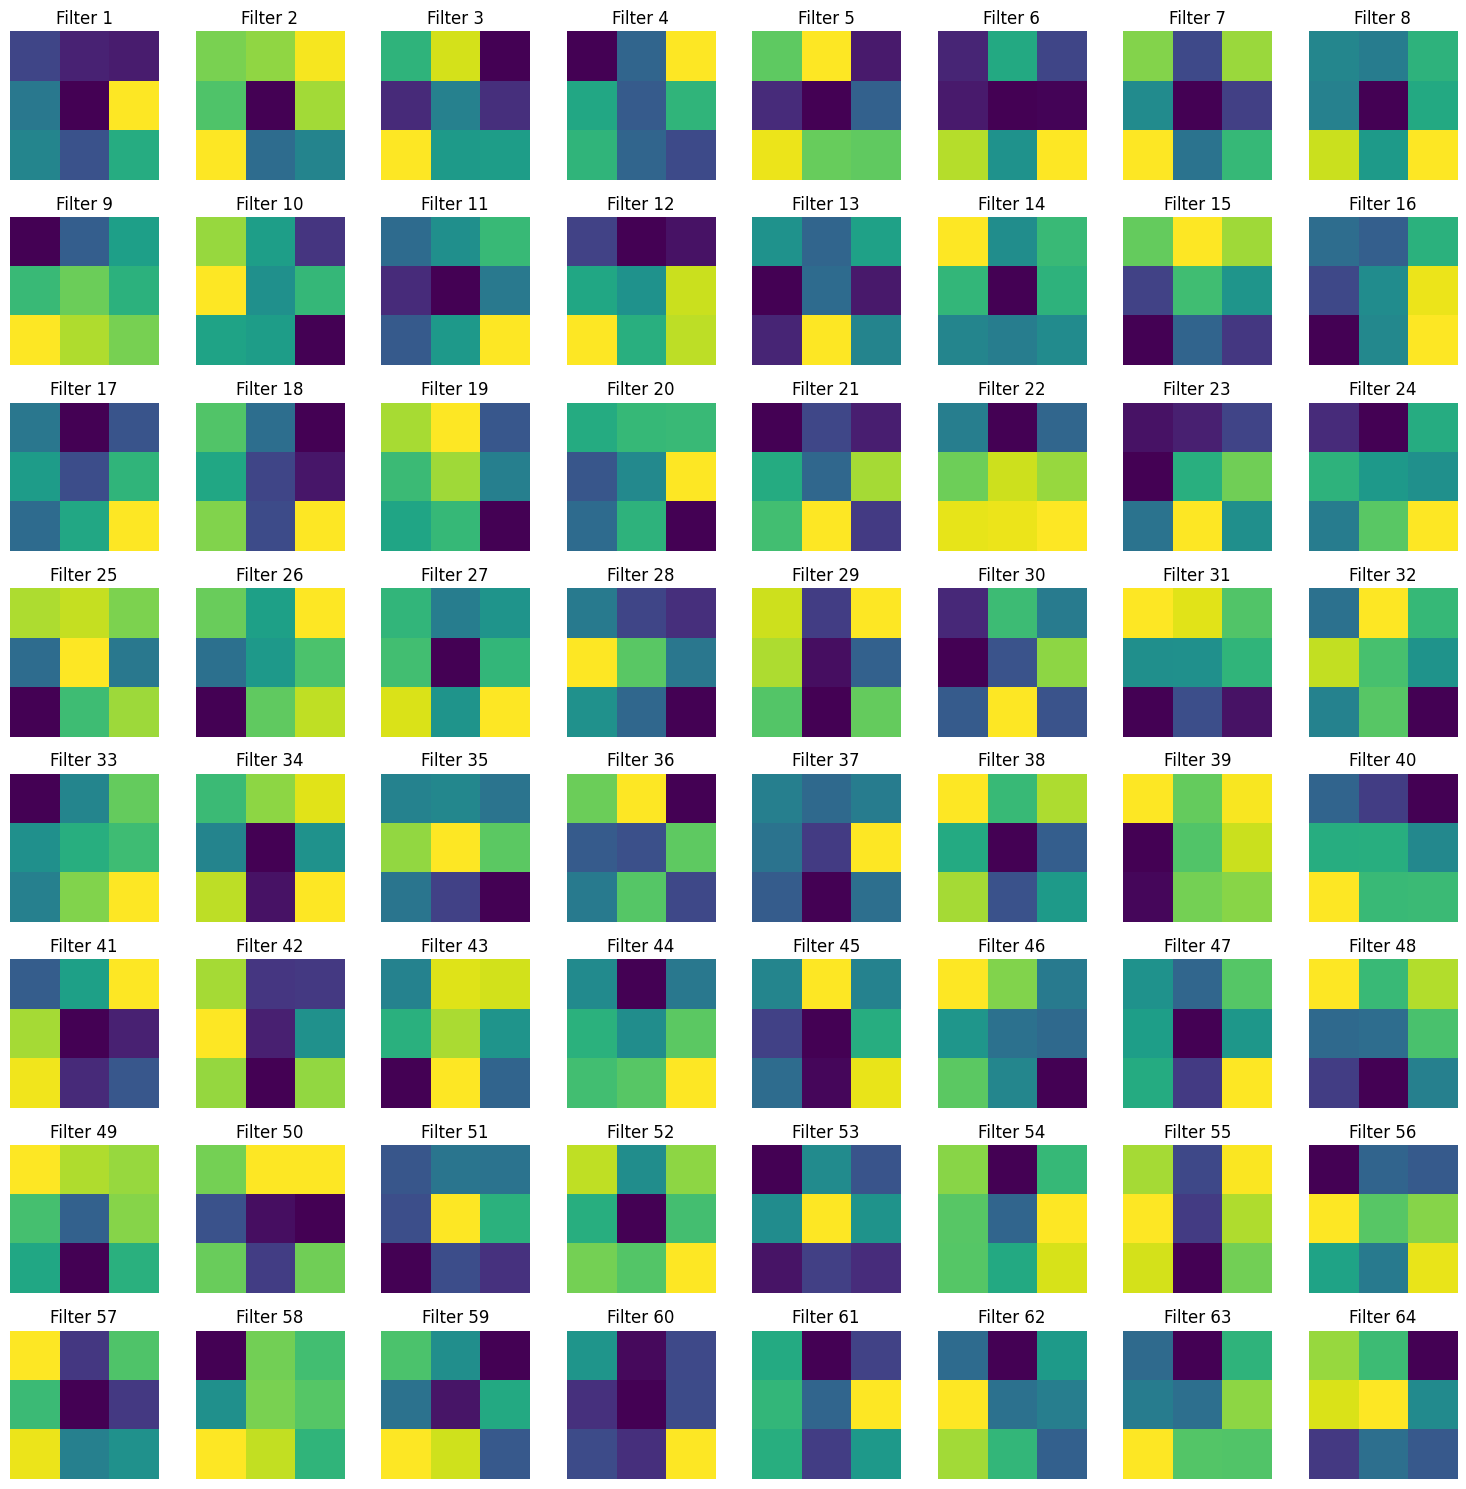

Visualizing filters for layer4.1.conv3


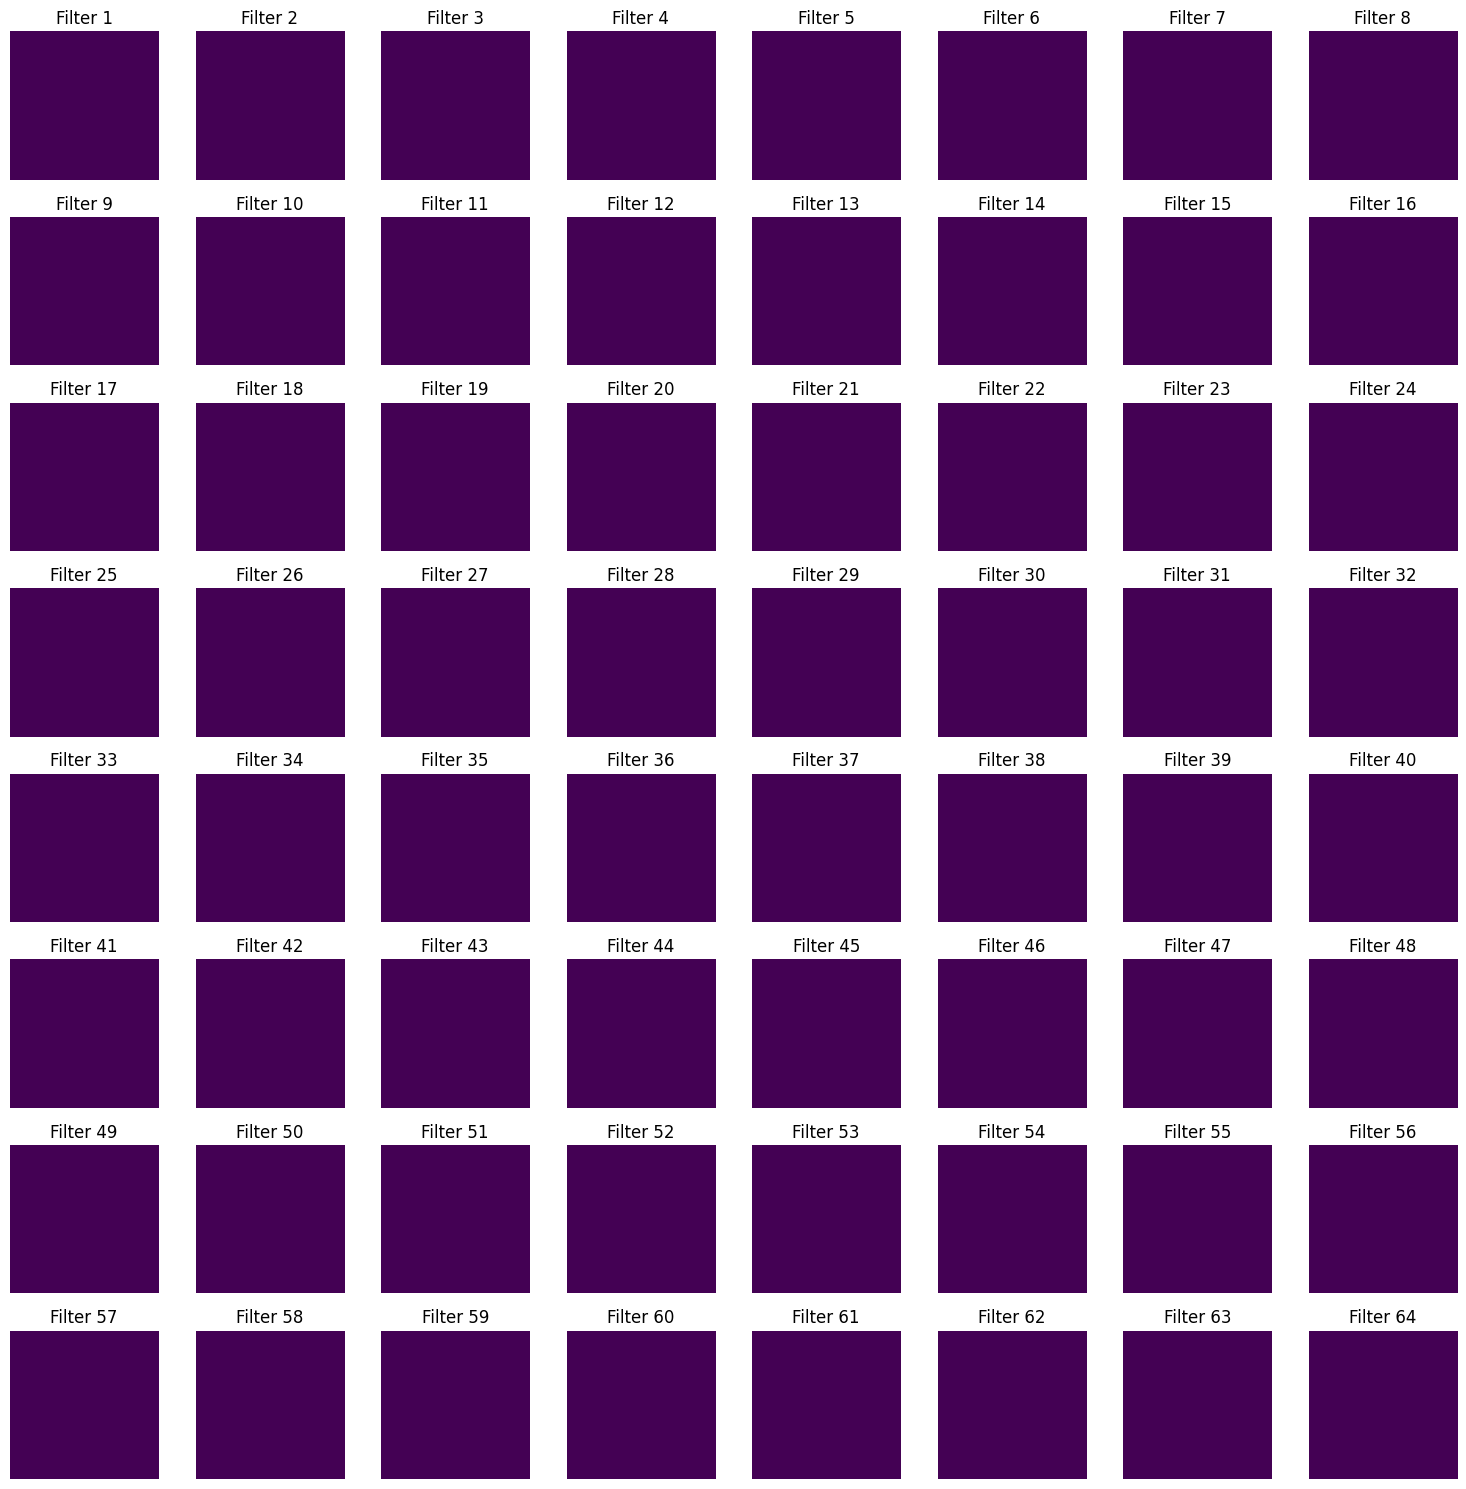

Visualizing filters for layer4.2.conv1


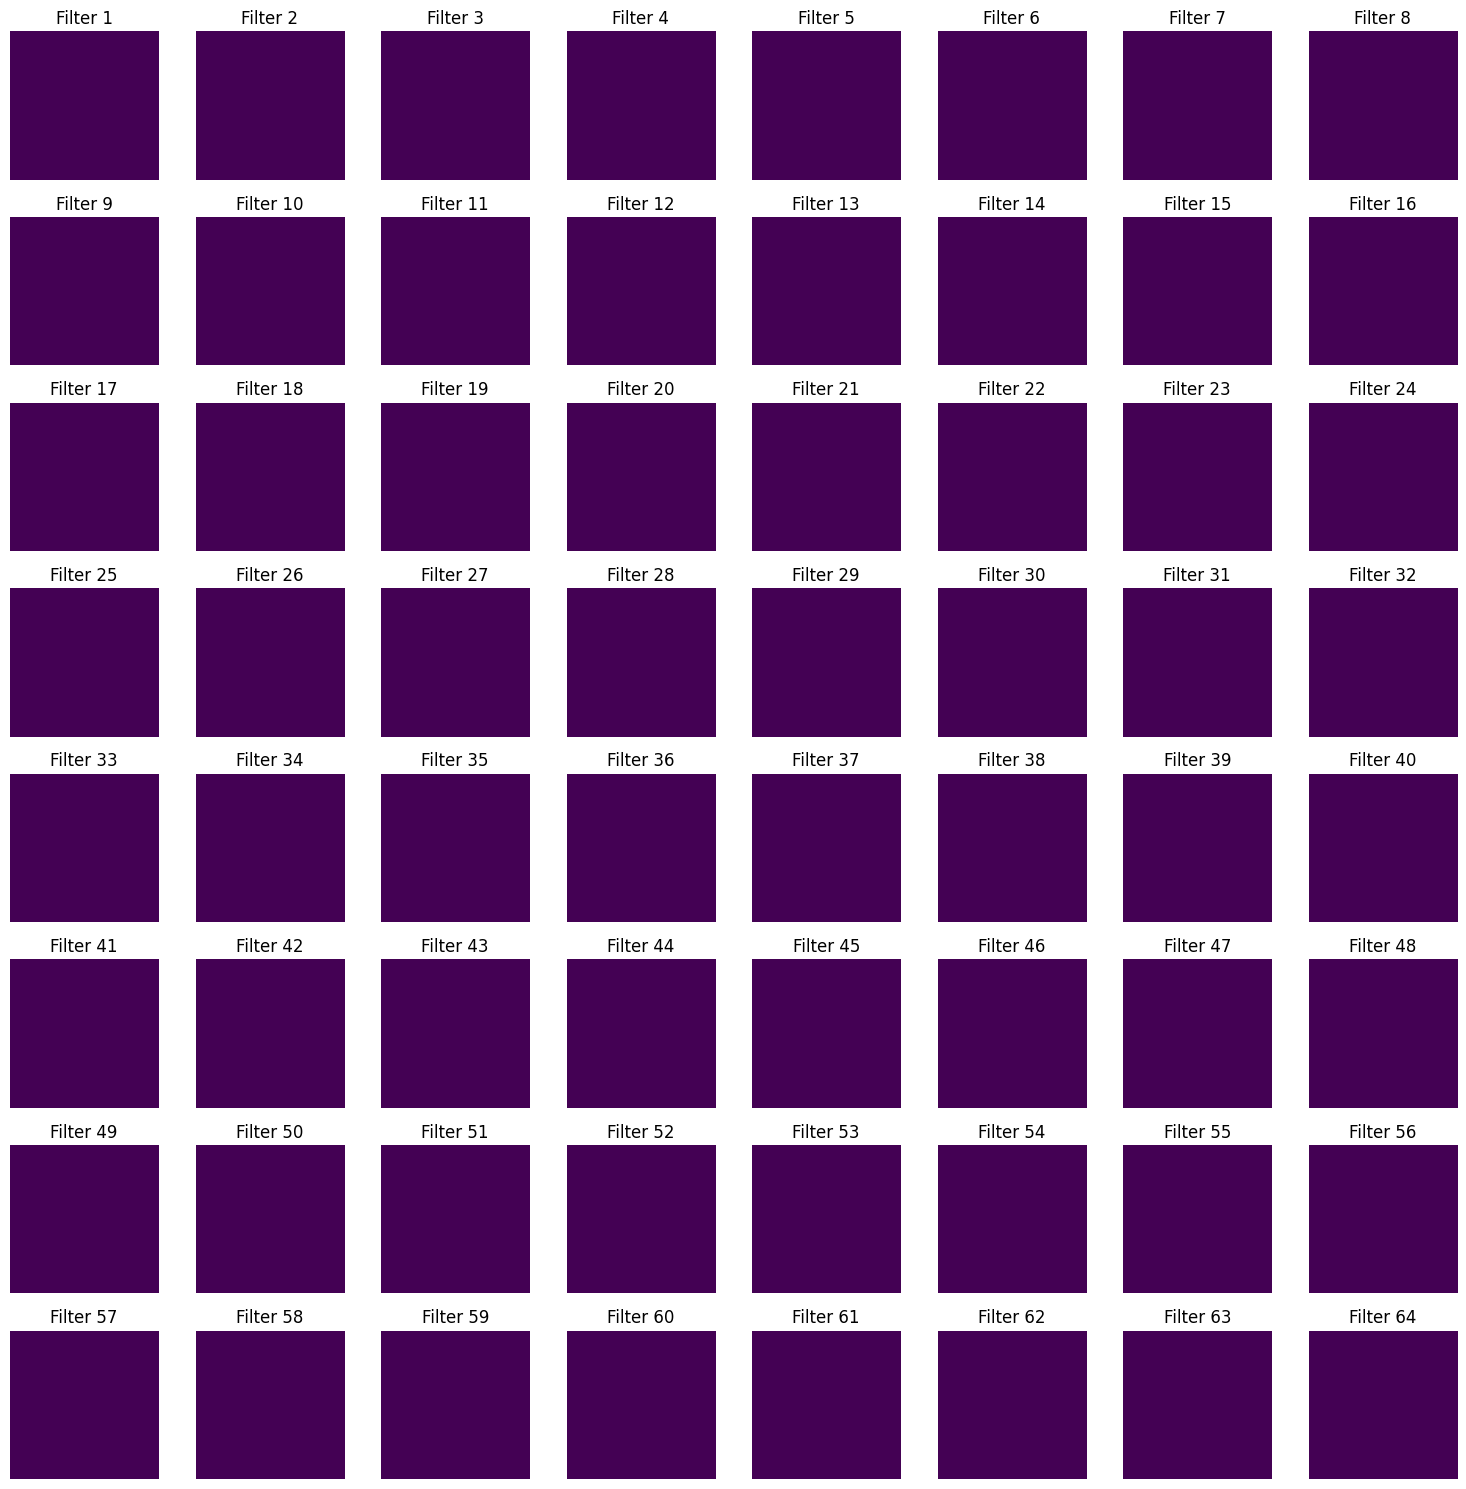

Visualizing filters for layer4.2.conv2


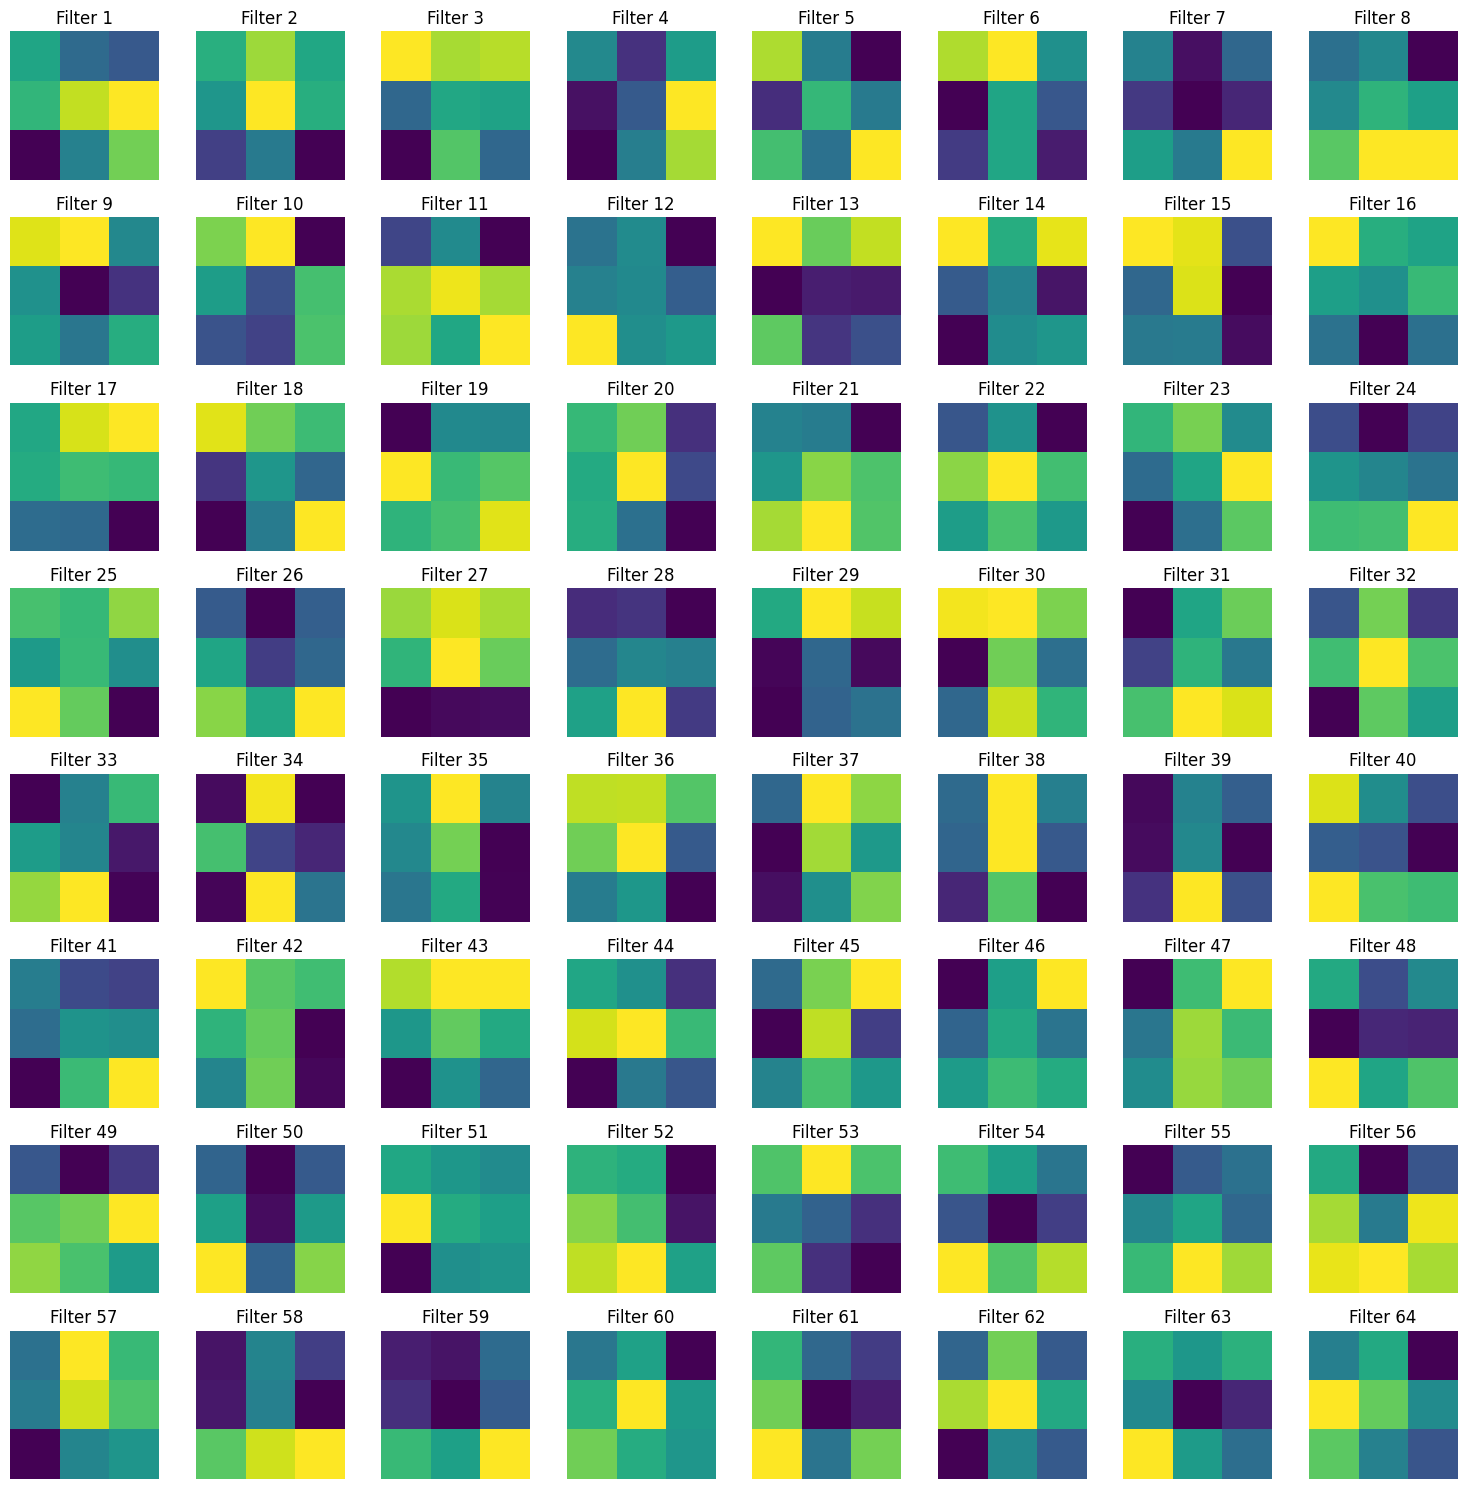

Visualizing filters for layer4.2.conv3


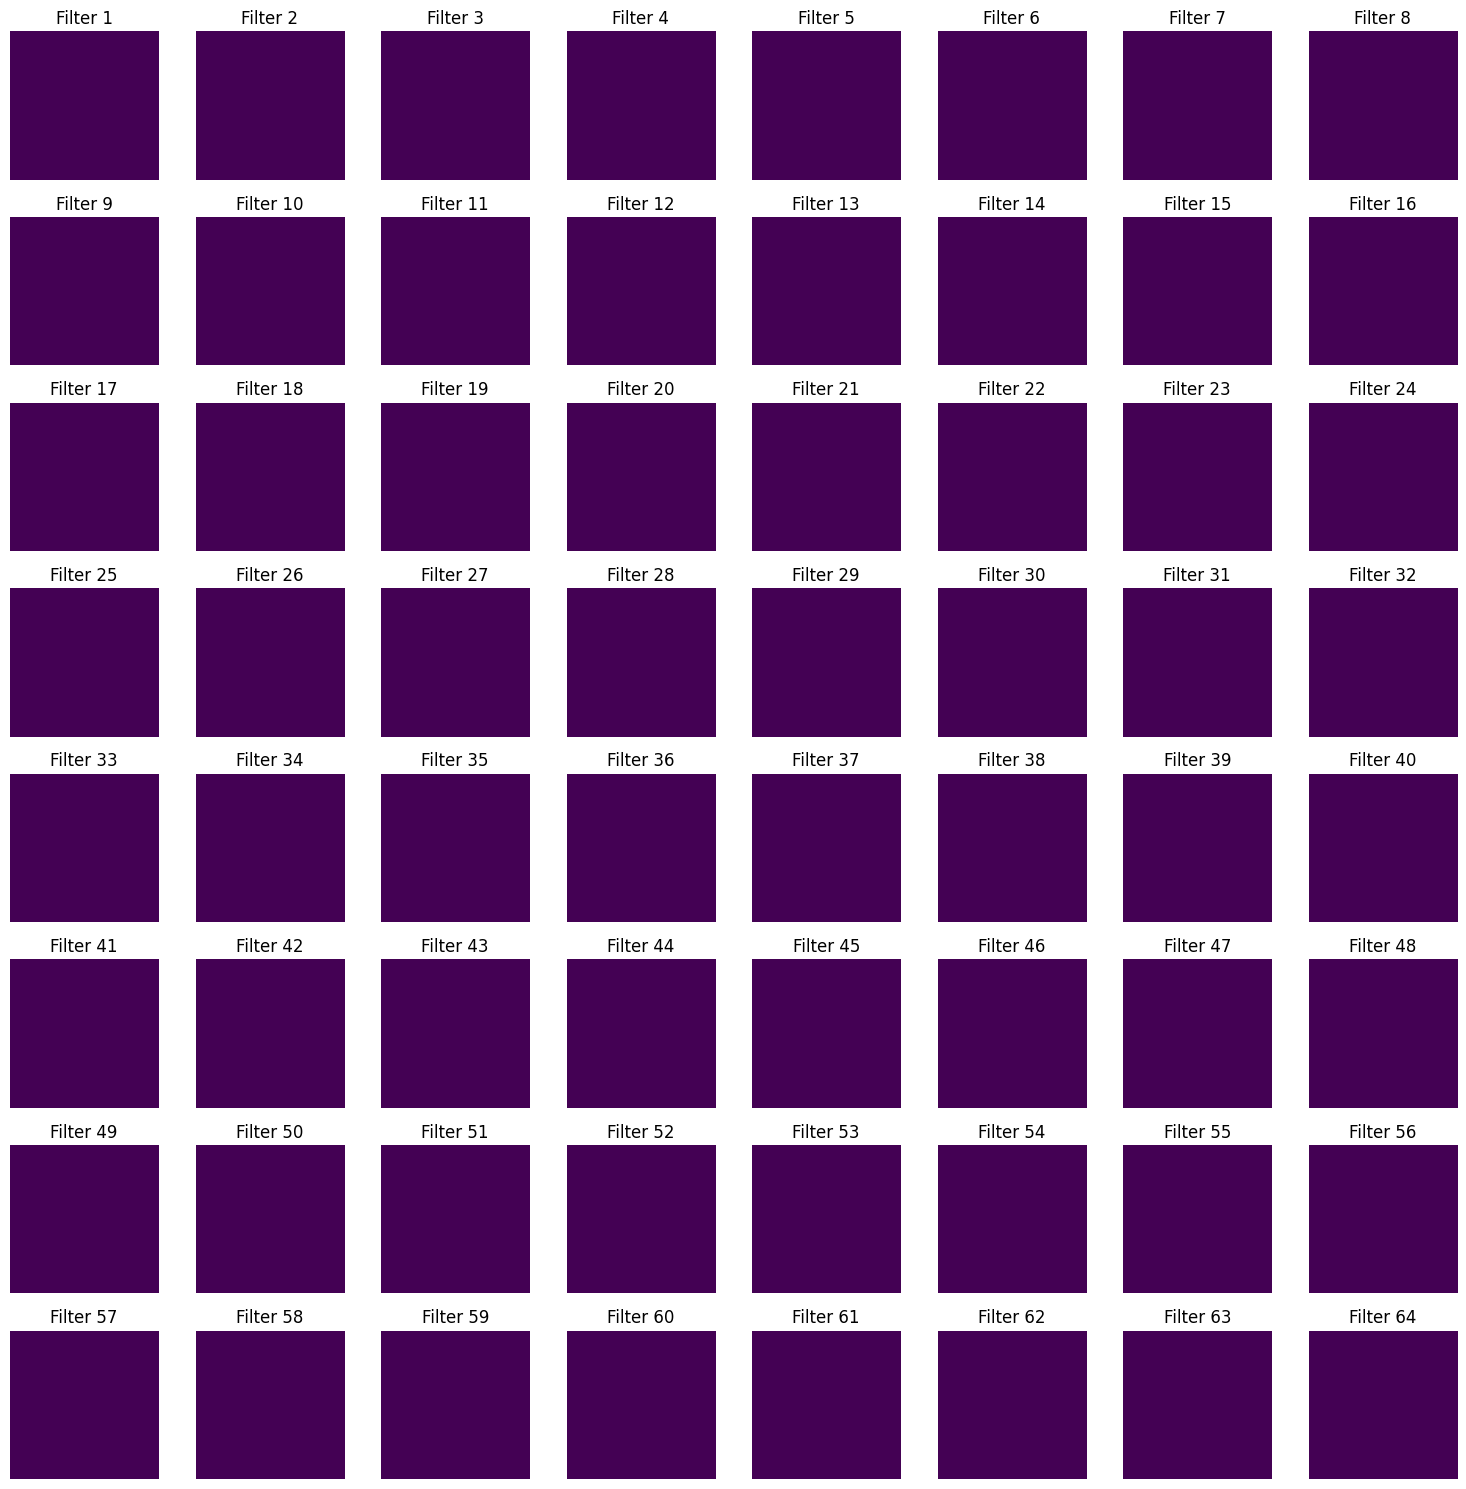

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"Visualizing filters for {name}")
        visualize_filters(module.weight.data.cpu(), num_filters_to_show=64)

Visualizing filters for layer: conv1


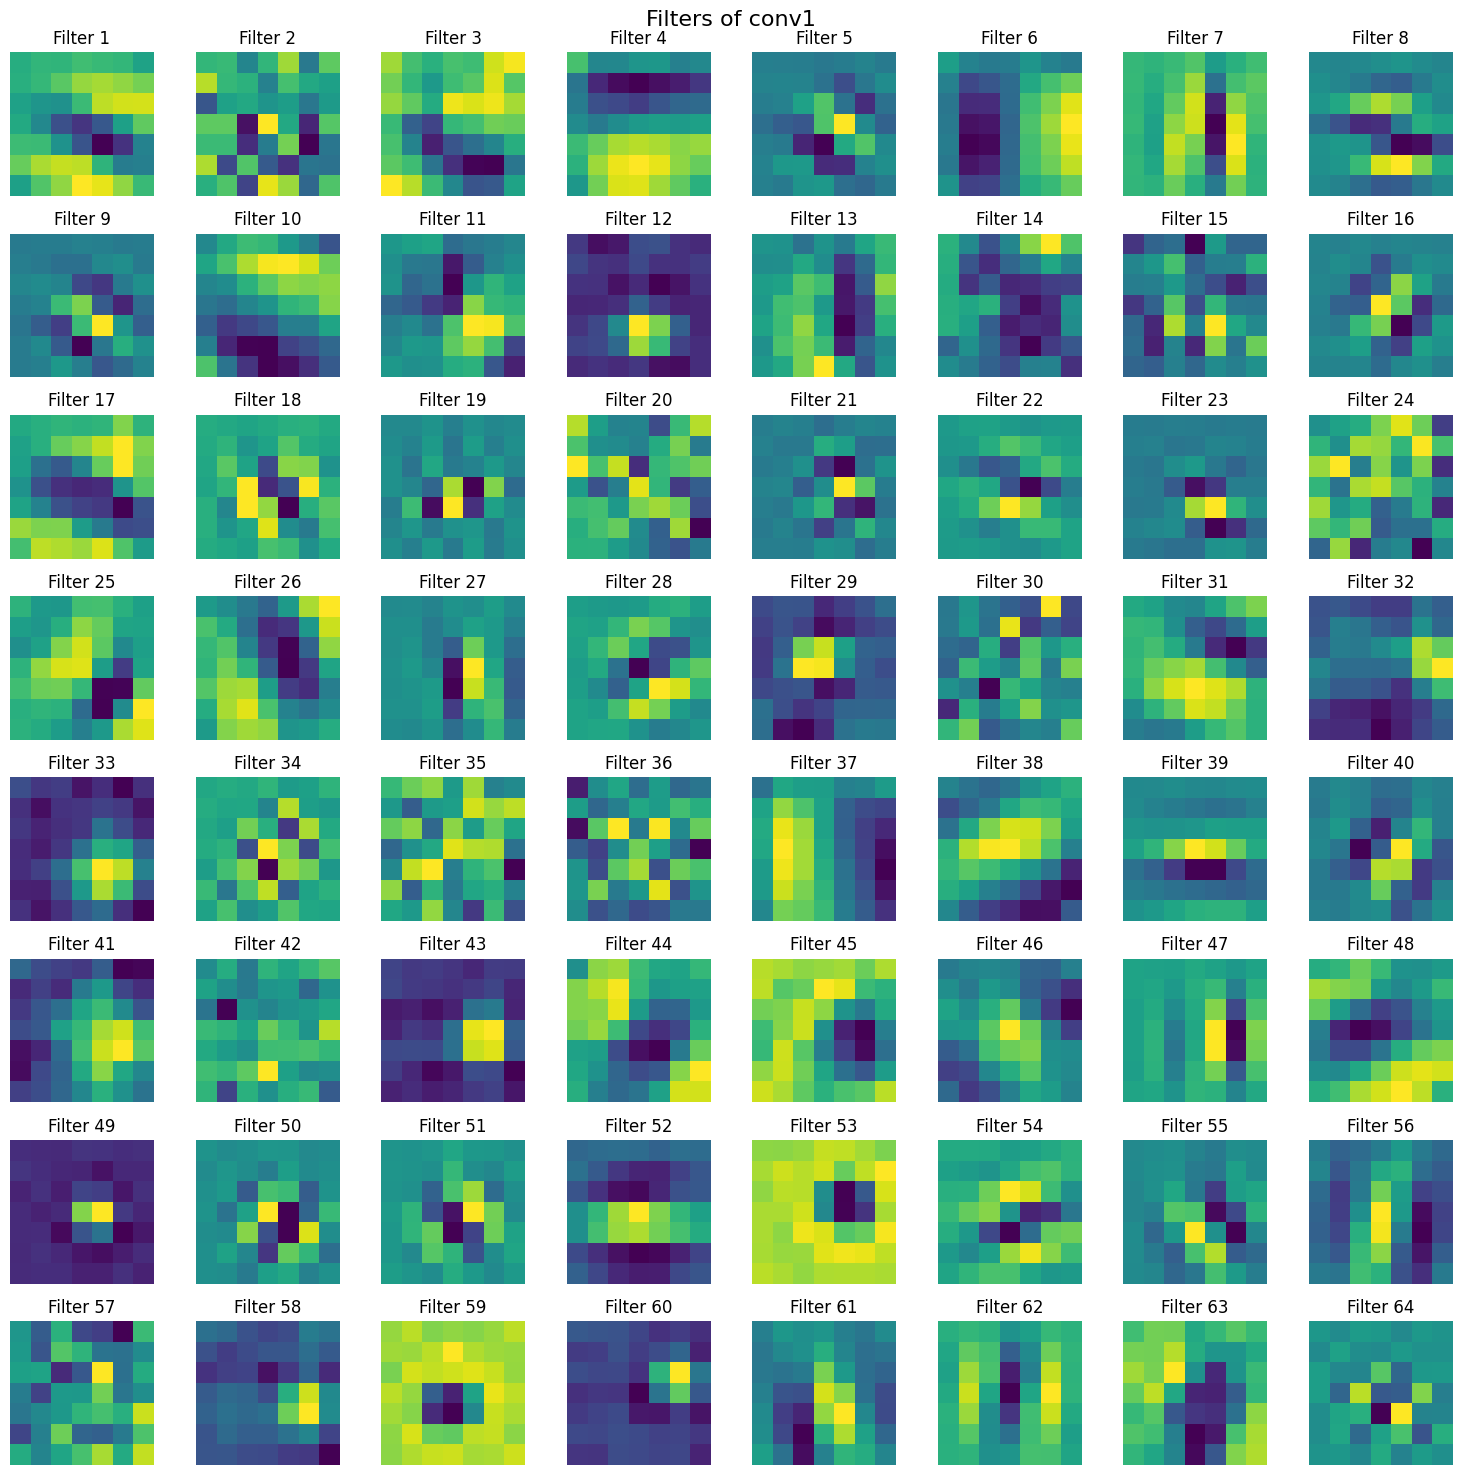

Visualizing filters for layer: layer1.0.conv1


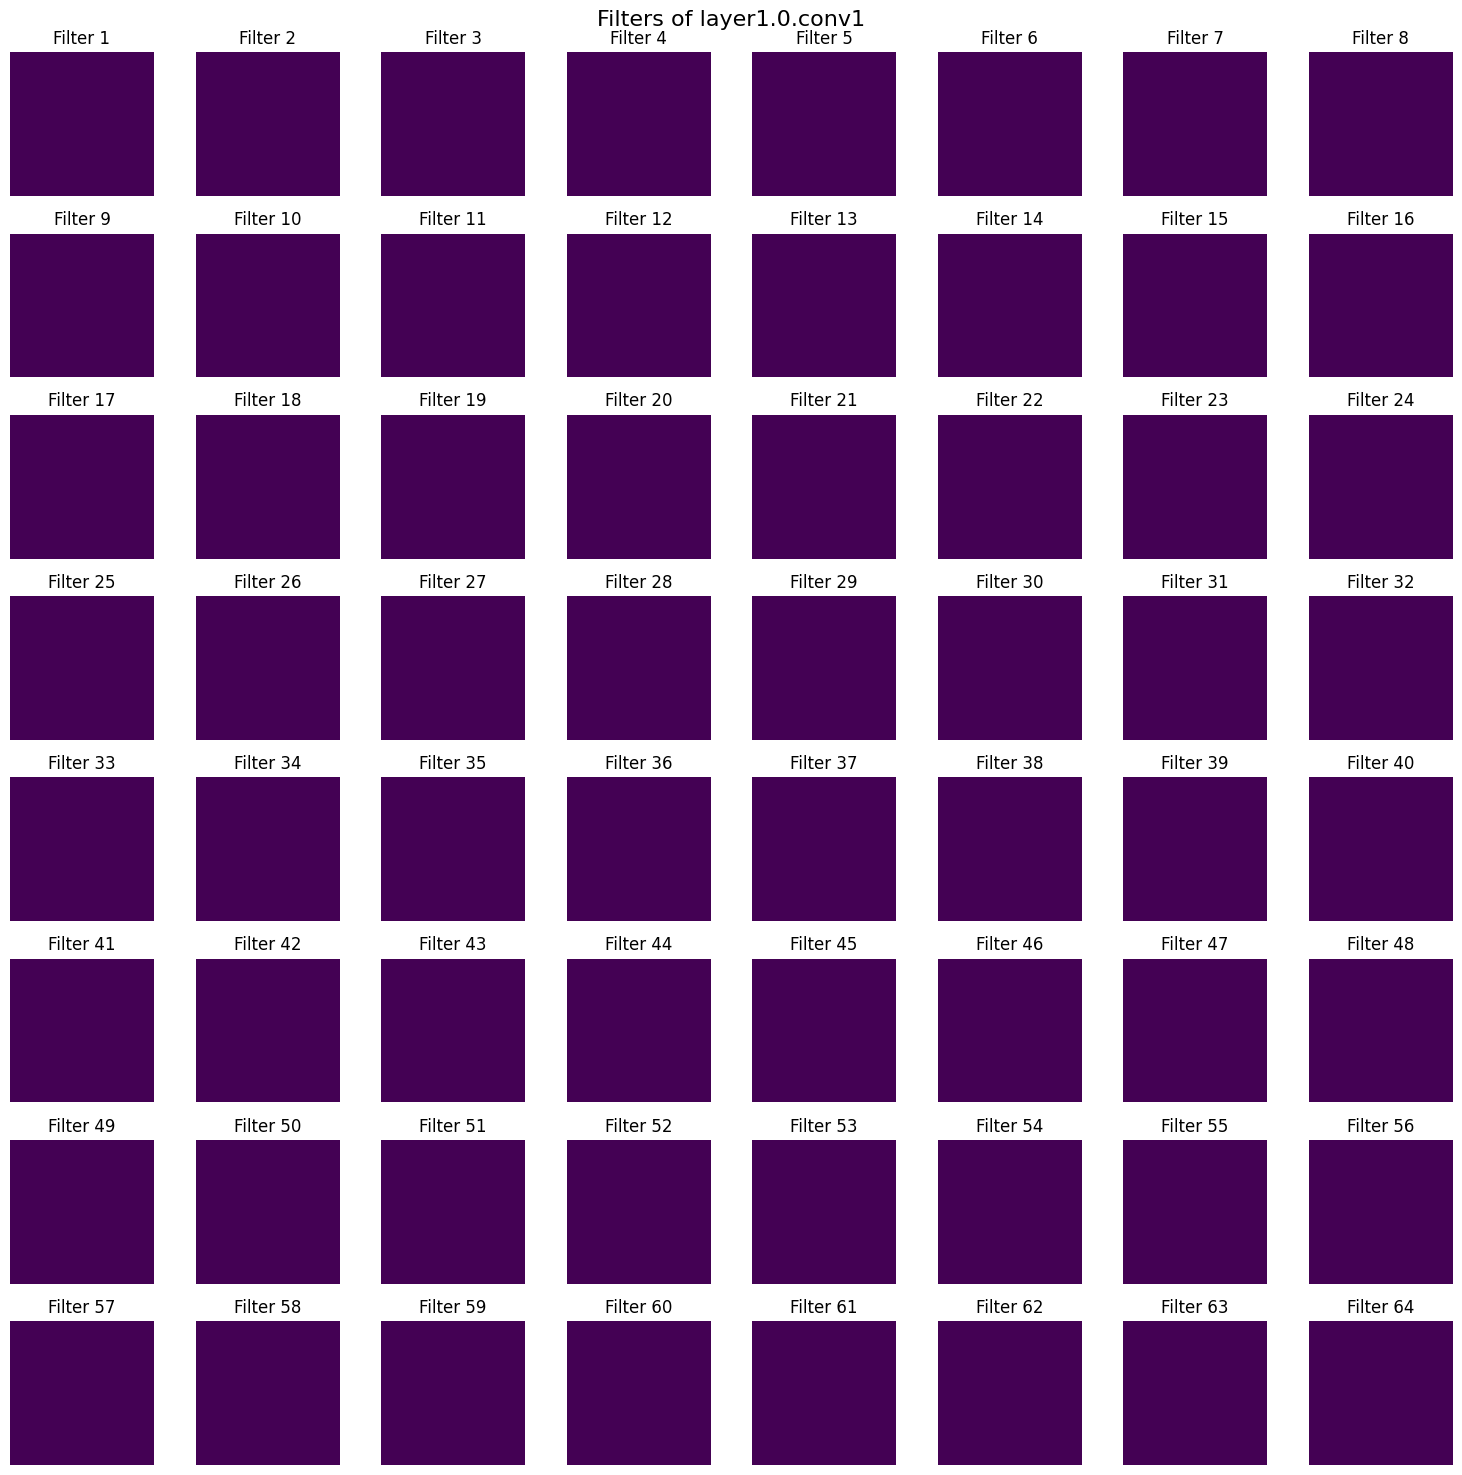

Visualizing filters for layer: layer1.0.conv2


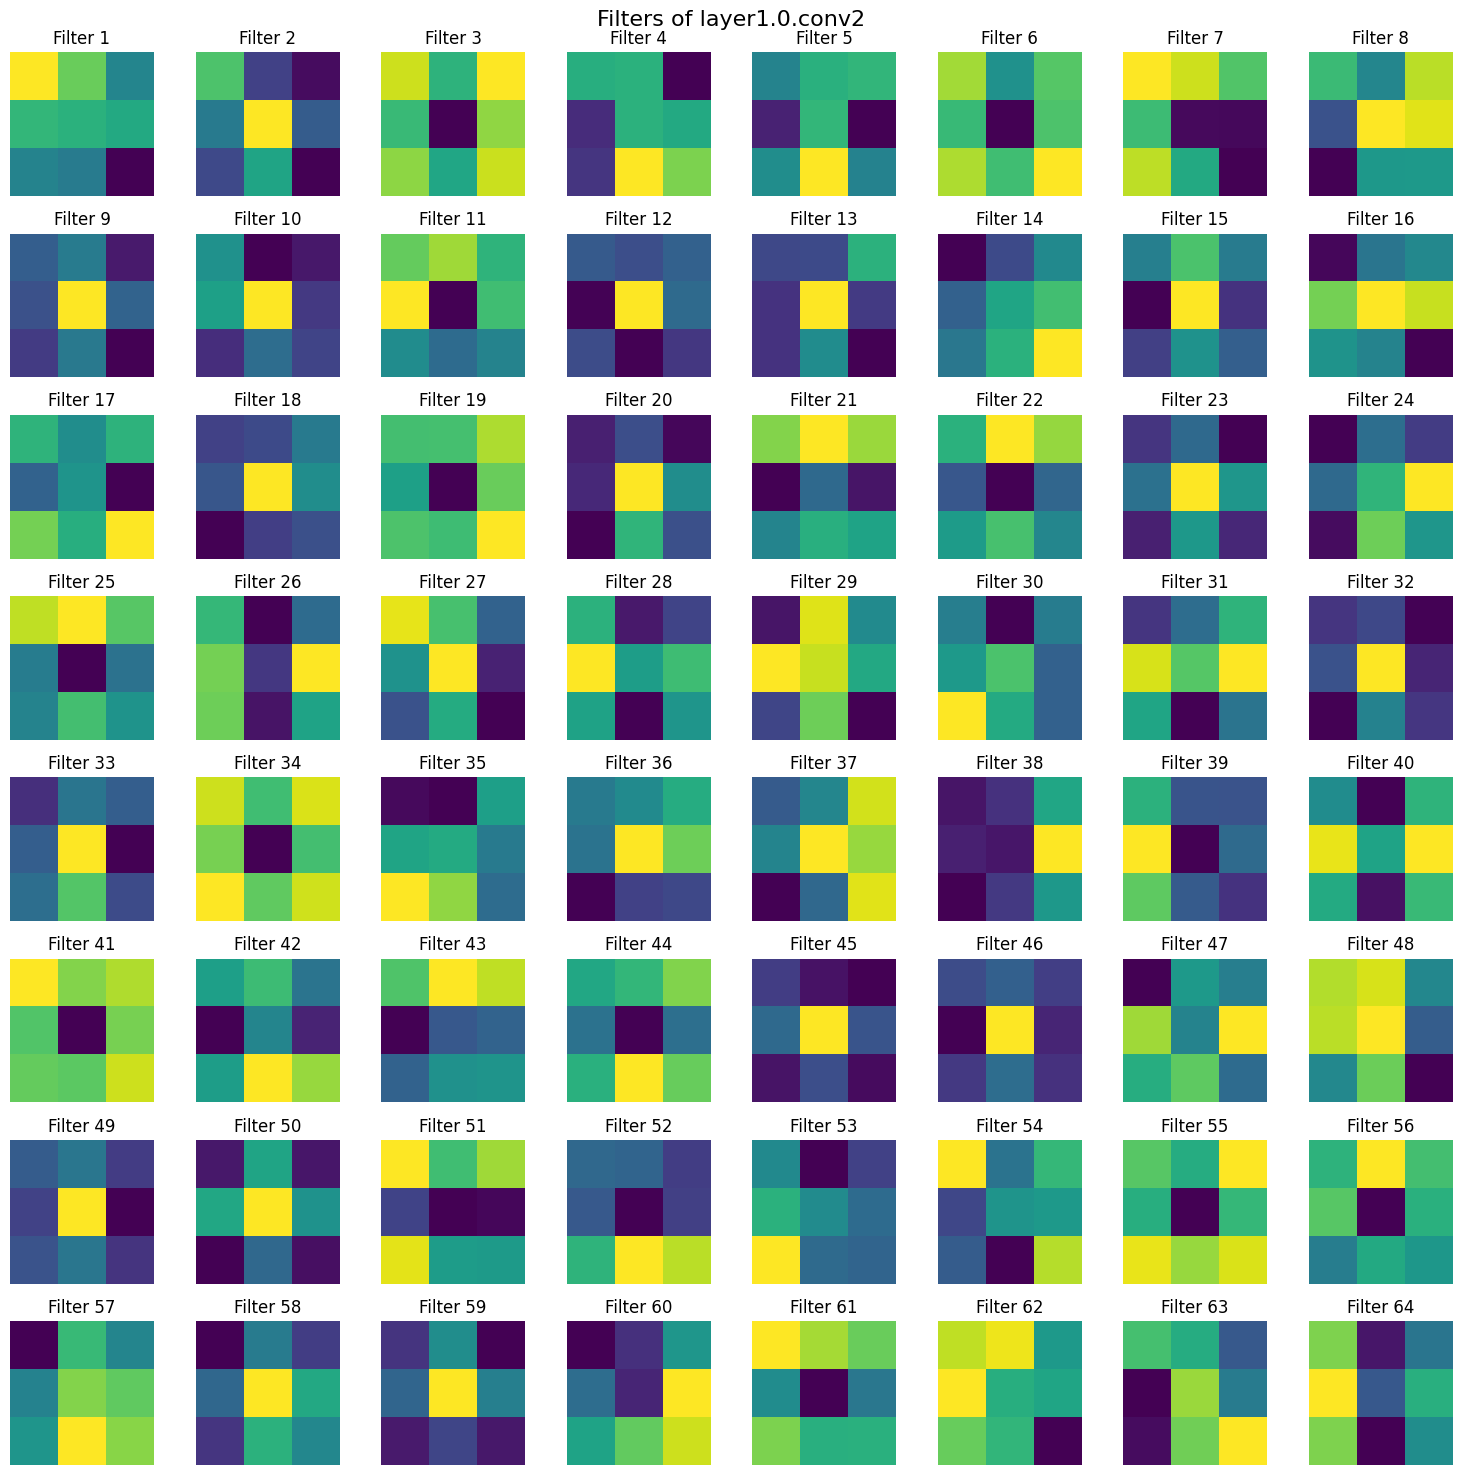

Visualizing filters for layer: layer1.0.conv3


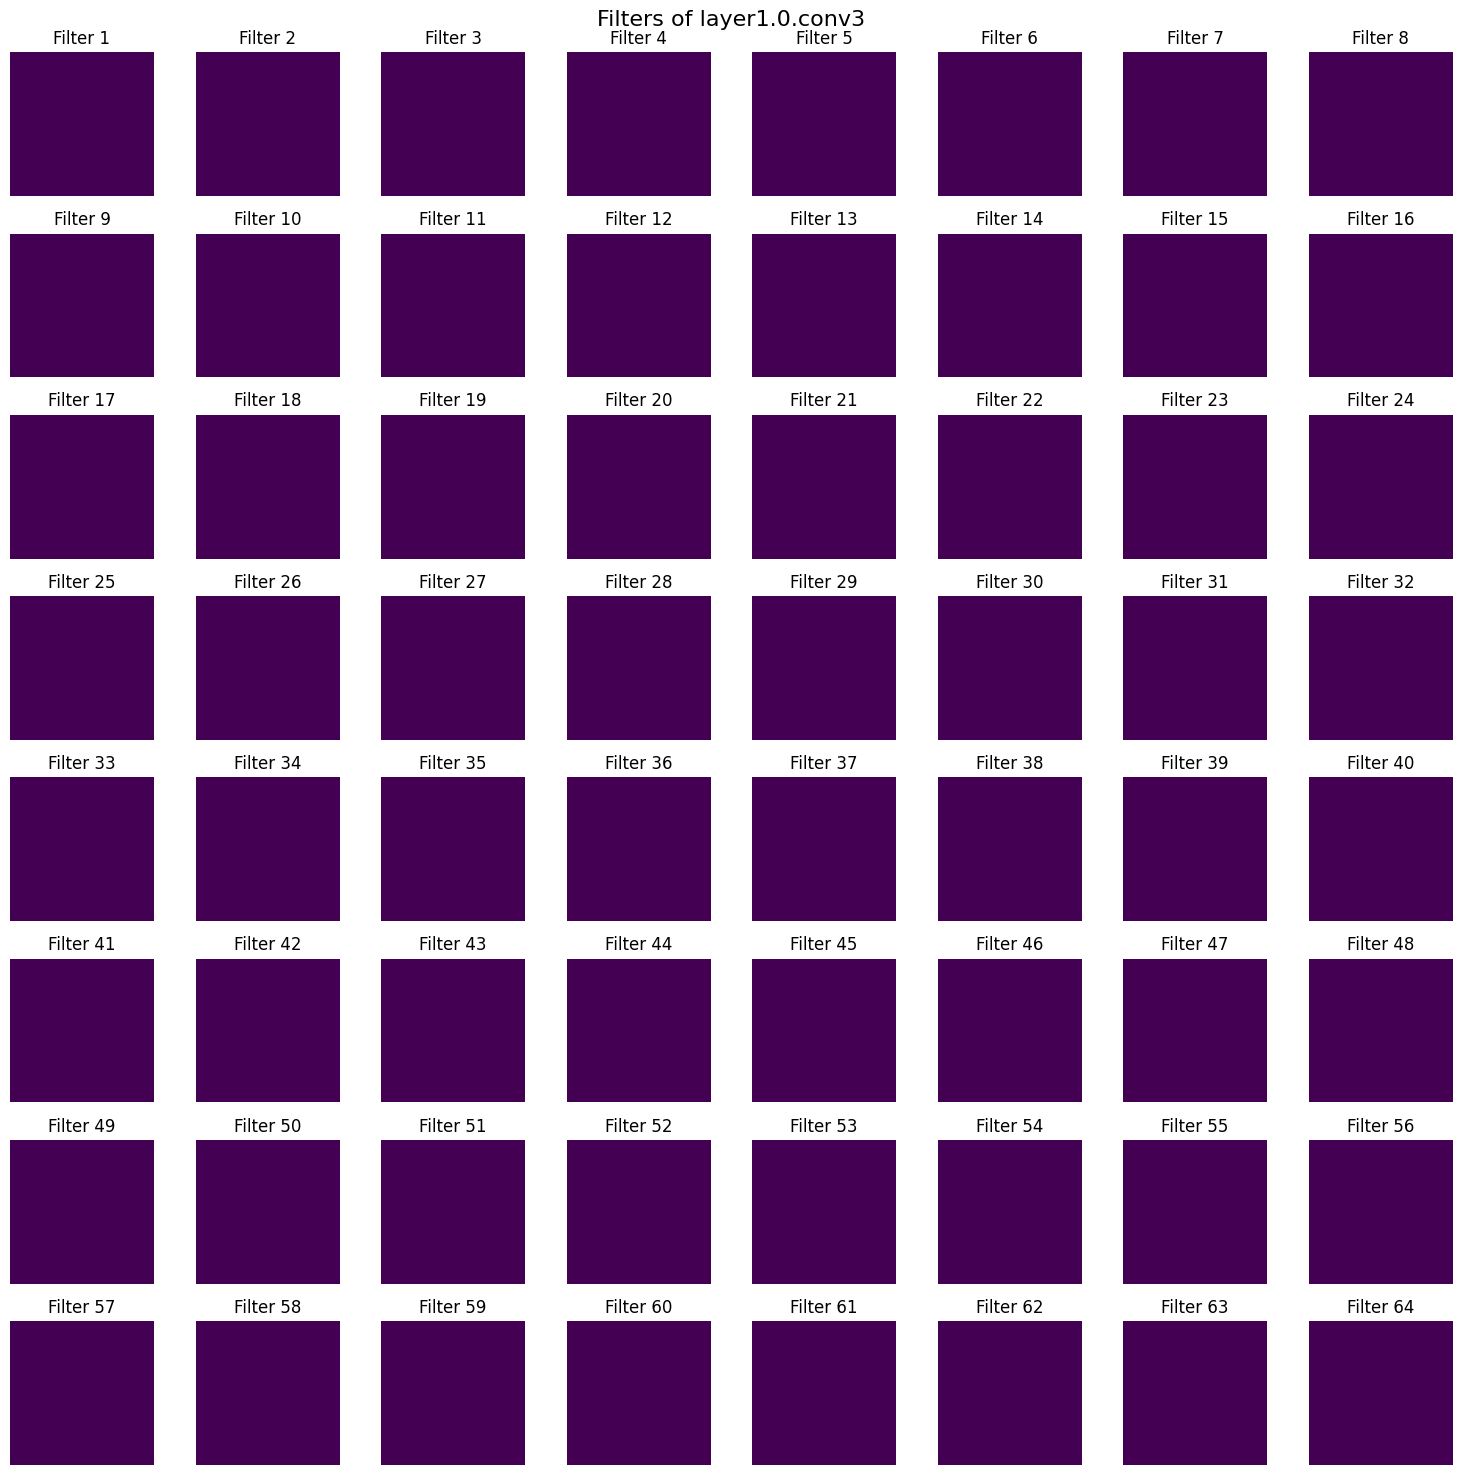

Visualizing filters for layer: layer1.0.downsample.0


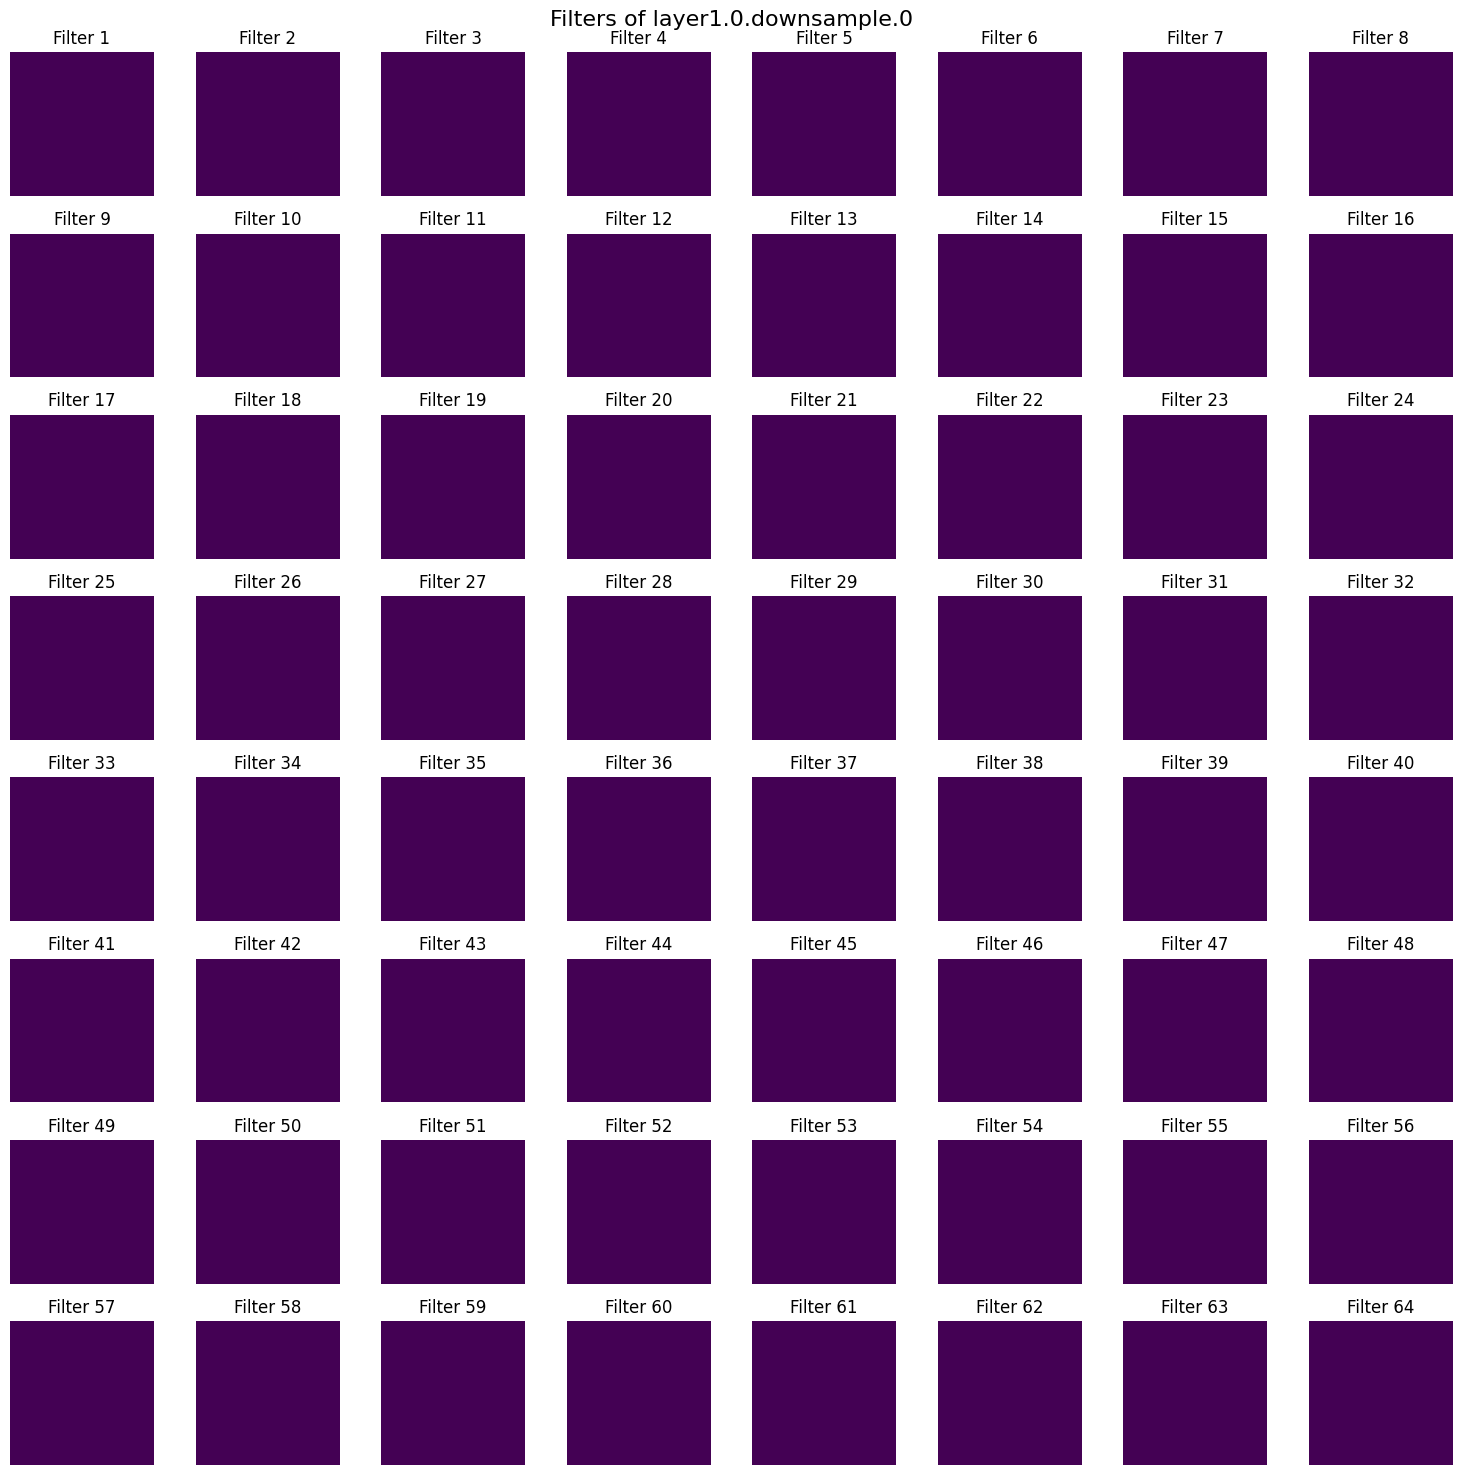

Visualizing filters for layer: layer1.1.conv1


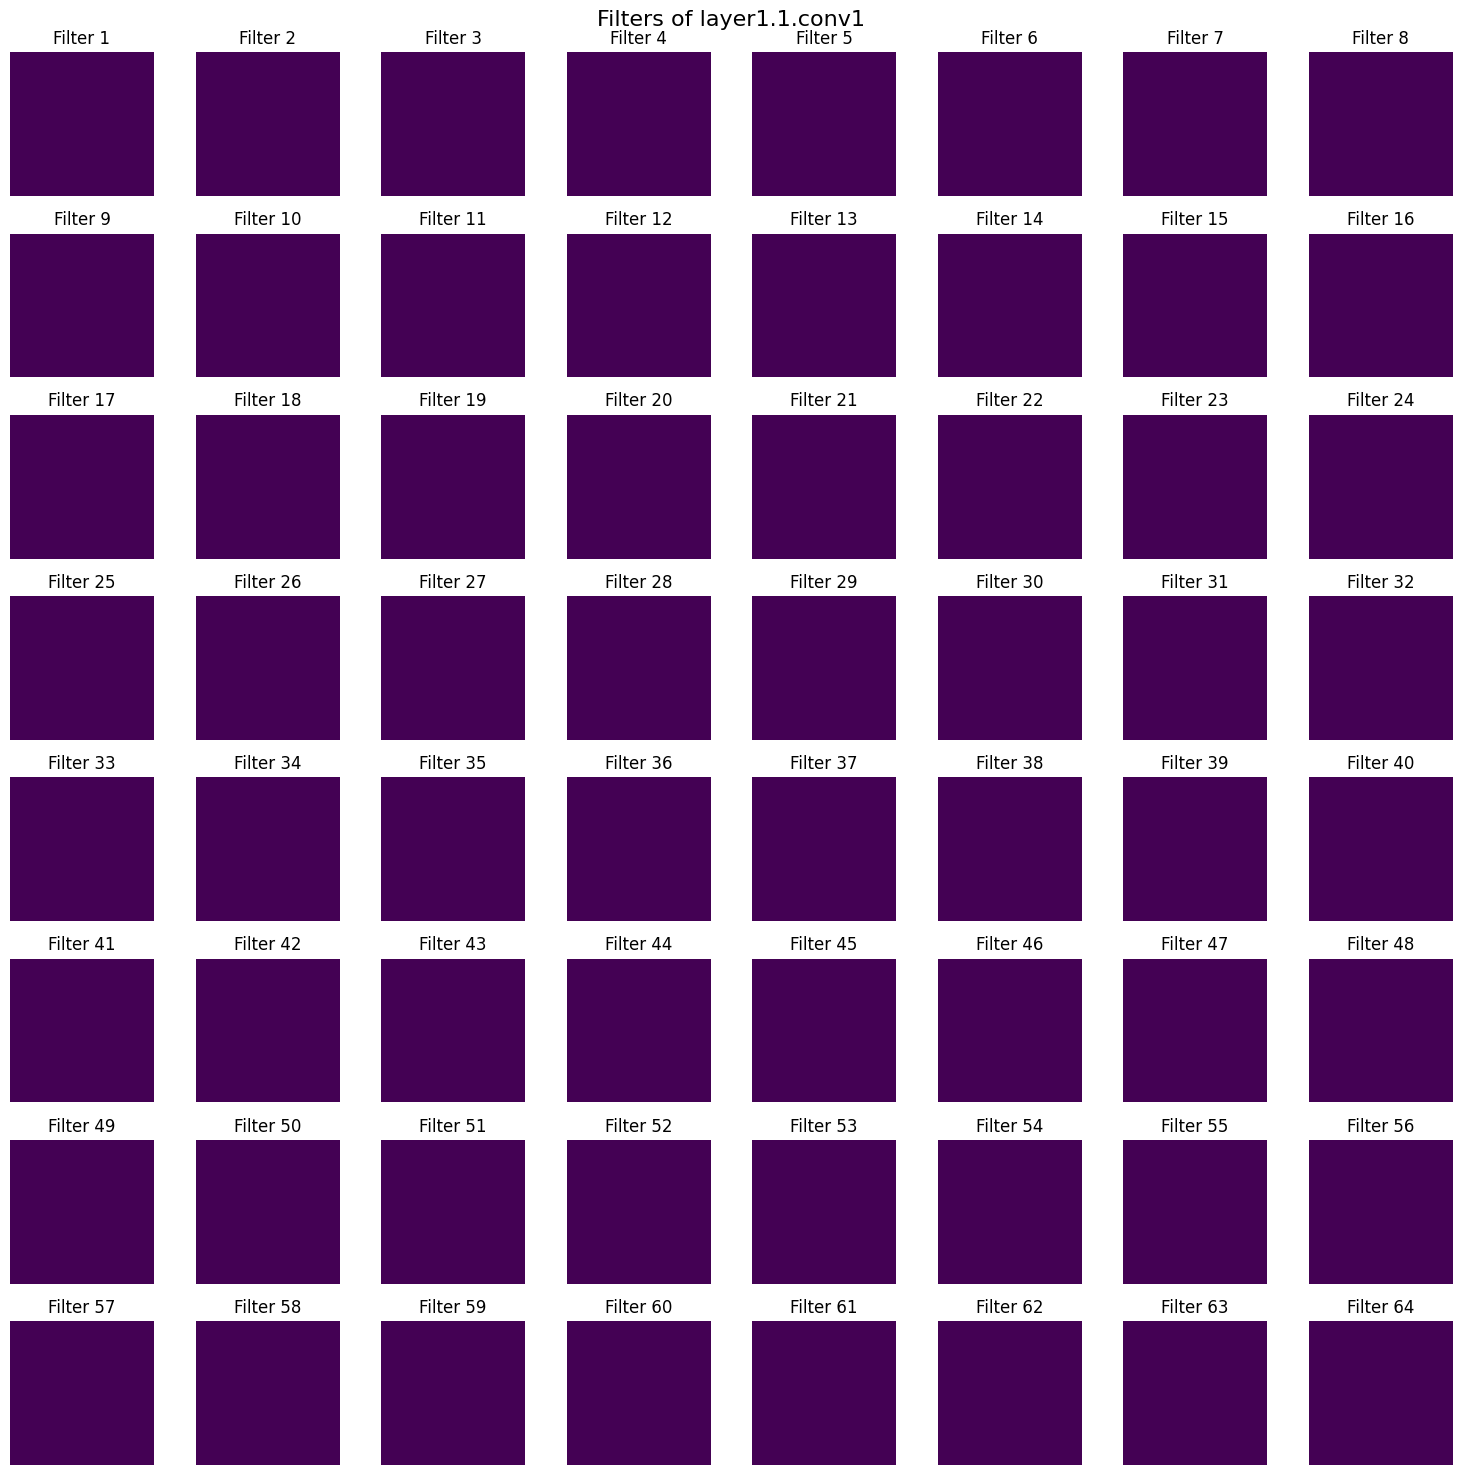

Visualizing filters for layer: layer1.1.conv2


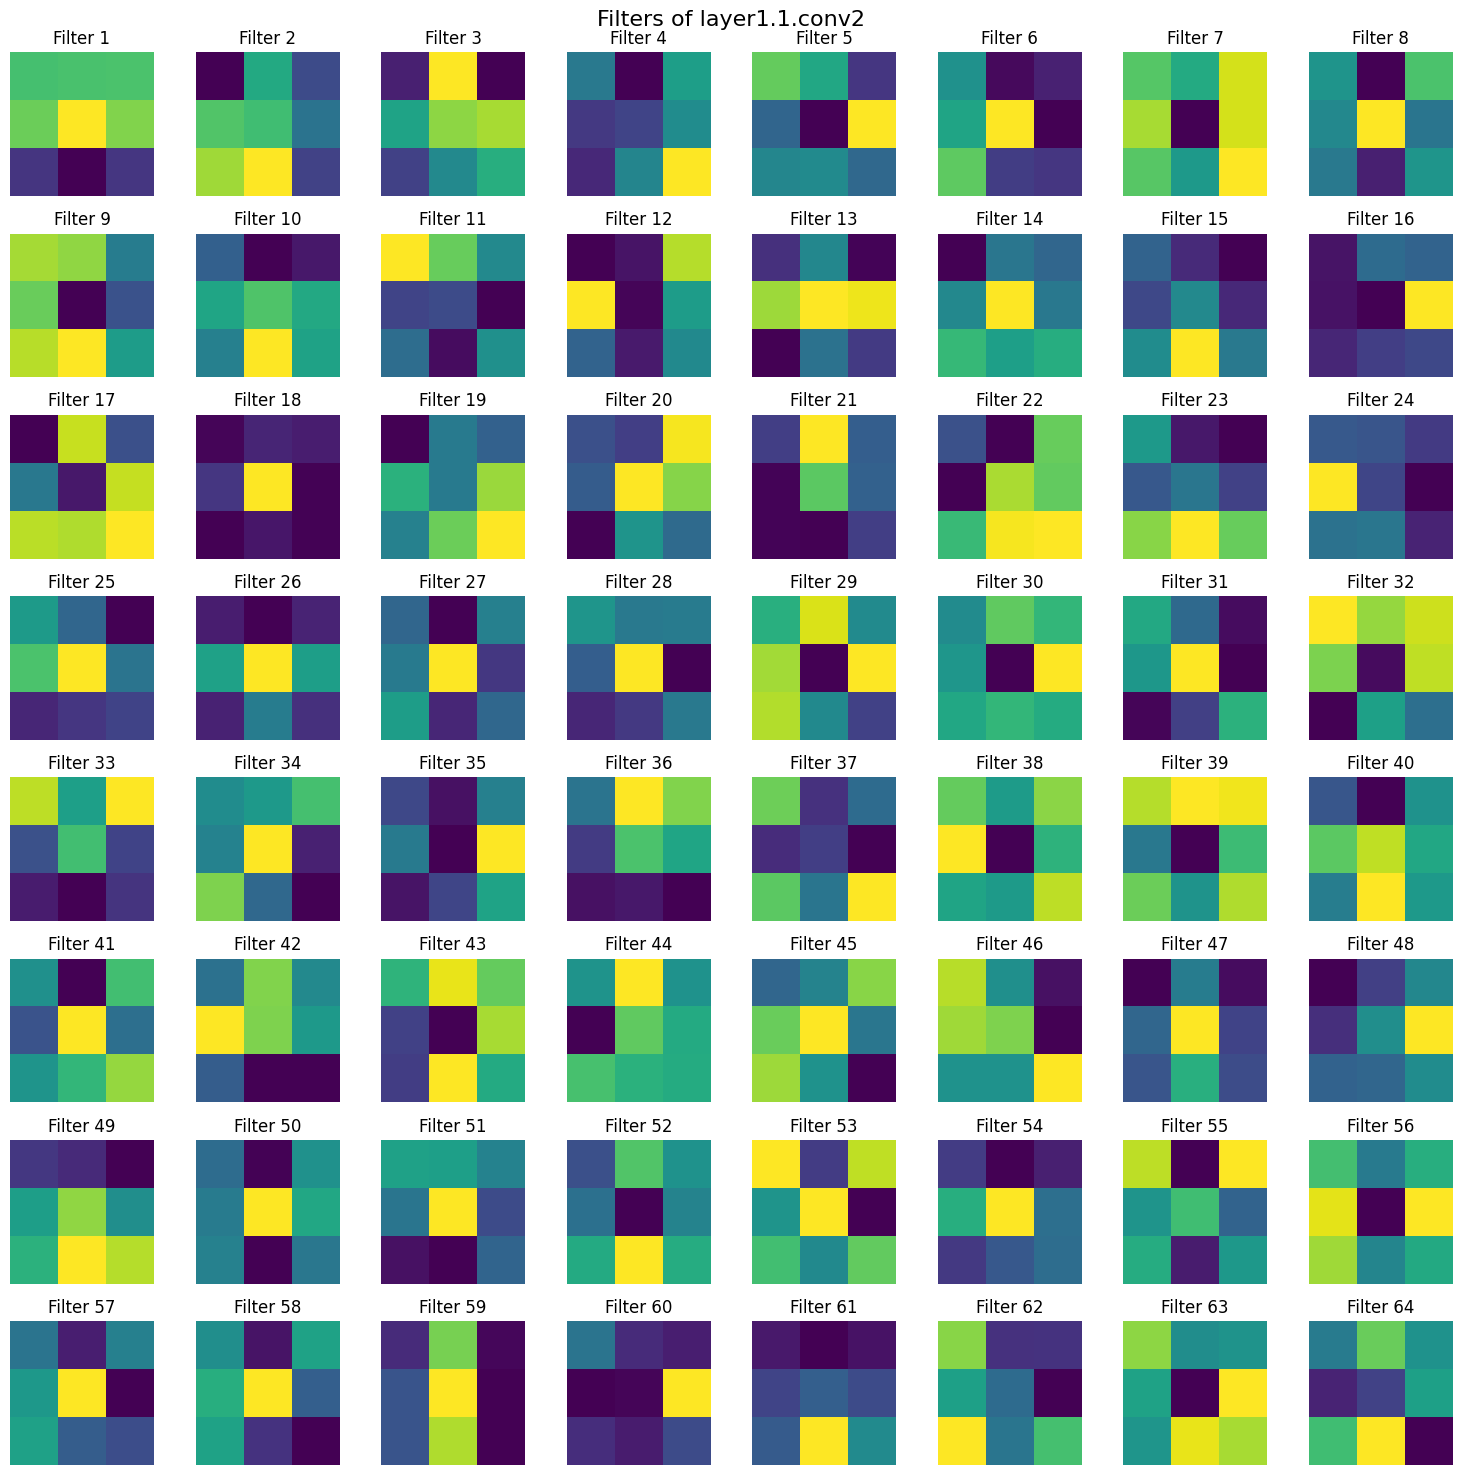

Visualizing filters for layer: layer1.1.conv3


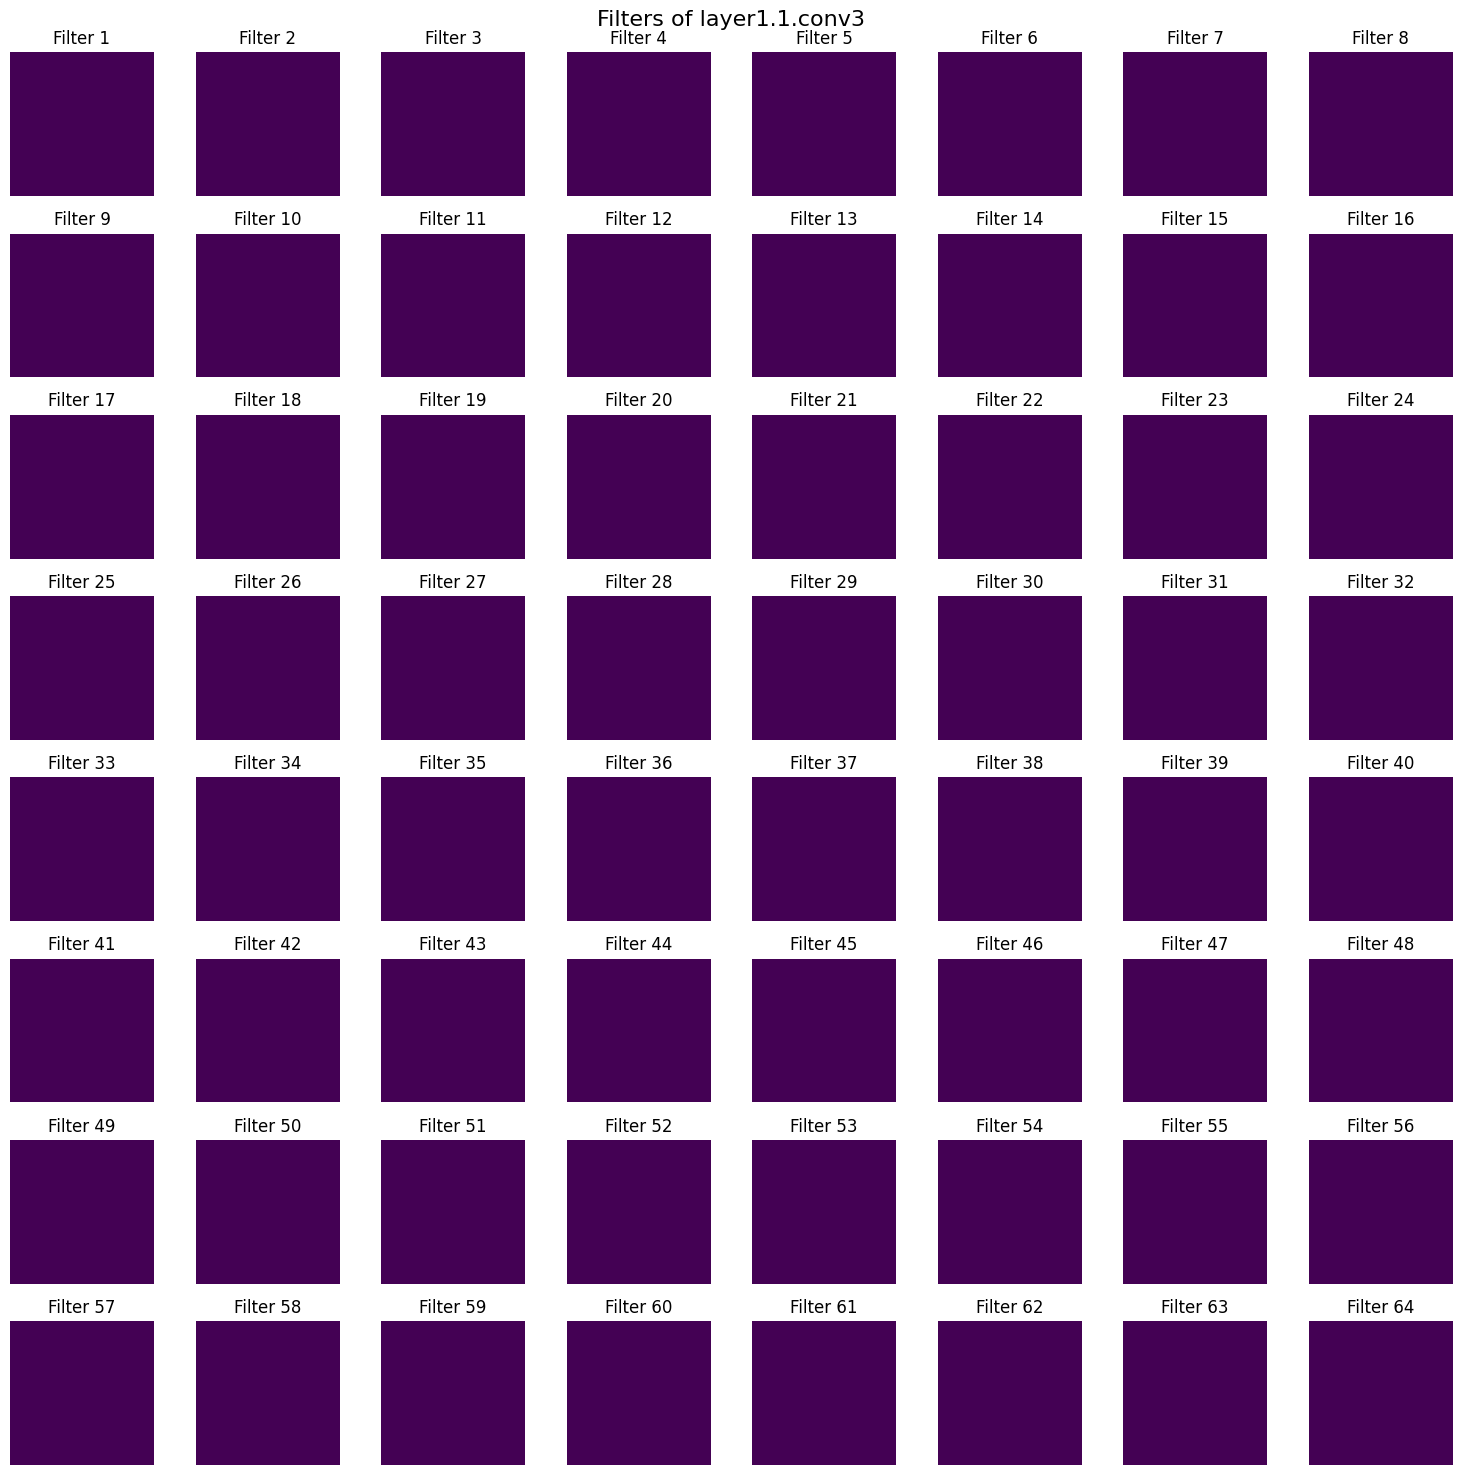

Visualizing filters for layer: layer1.2.conv1


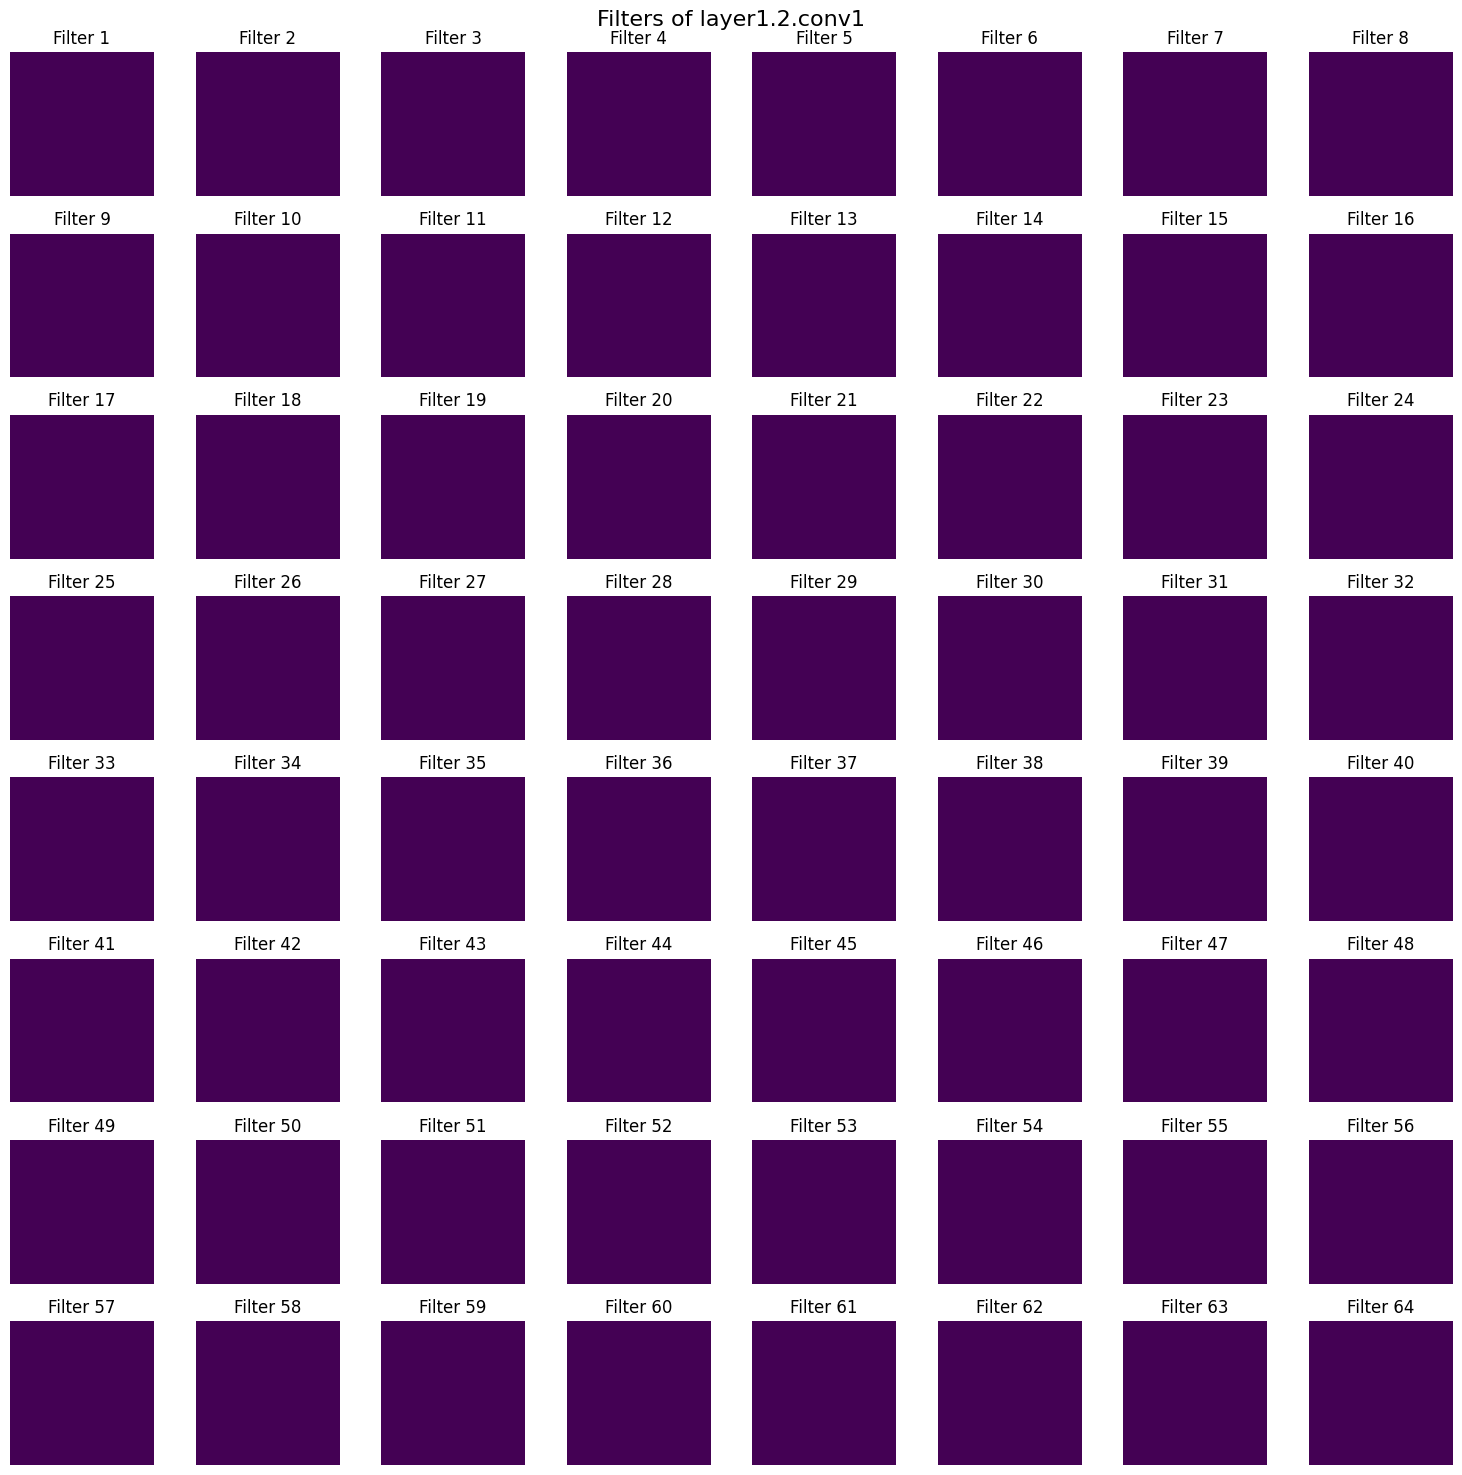

Visualizing filters for layer: layer1.2.conv2


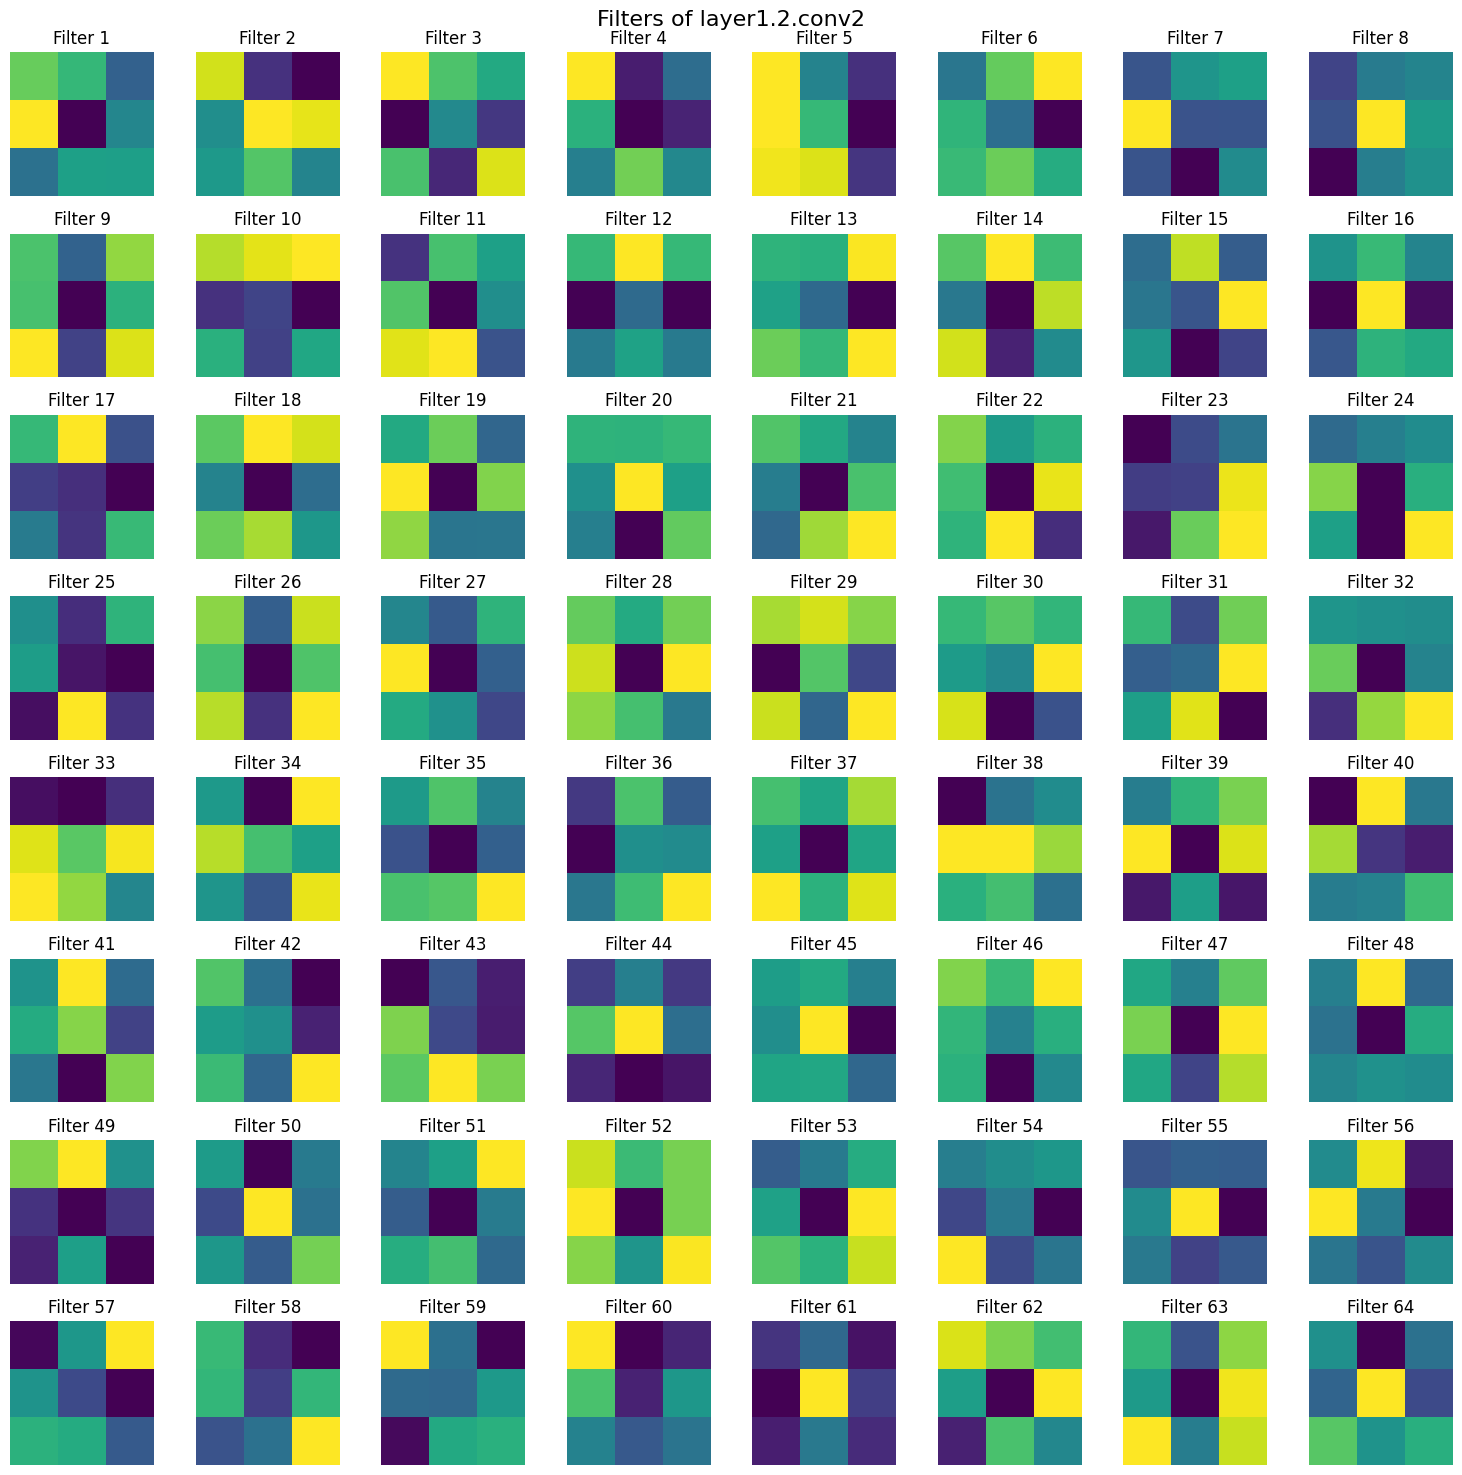

Visualizing filters for layer: layer1.2.conv3


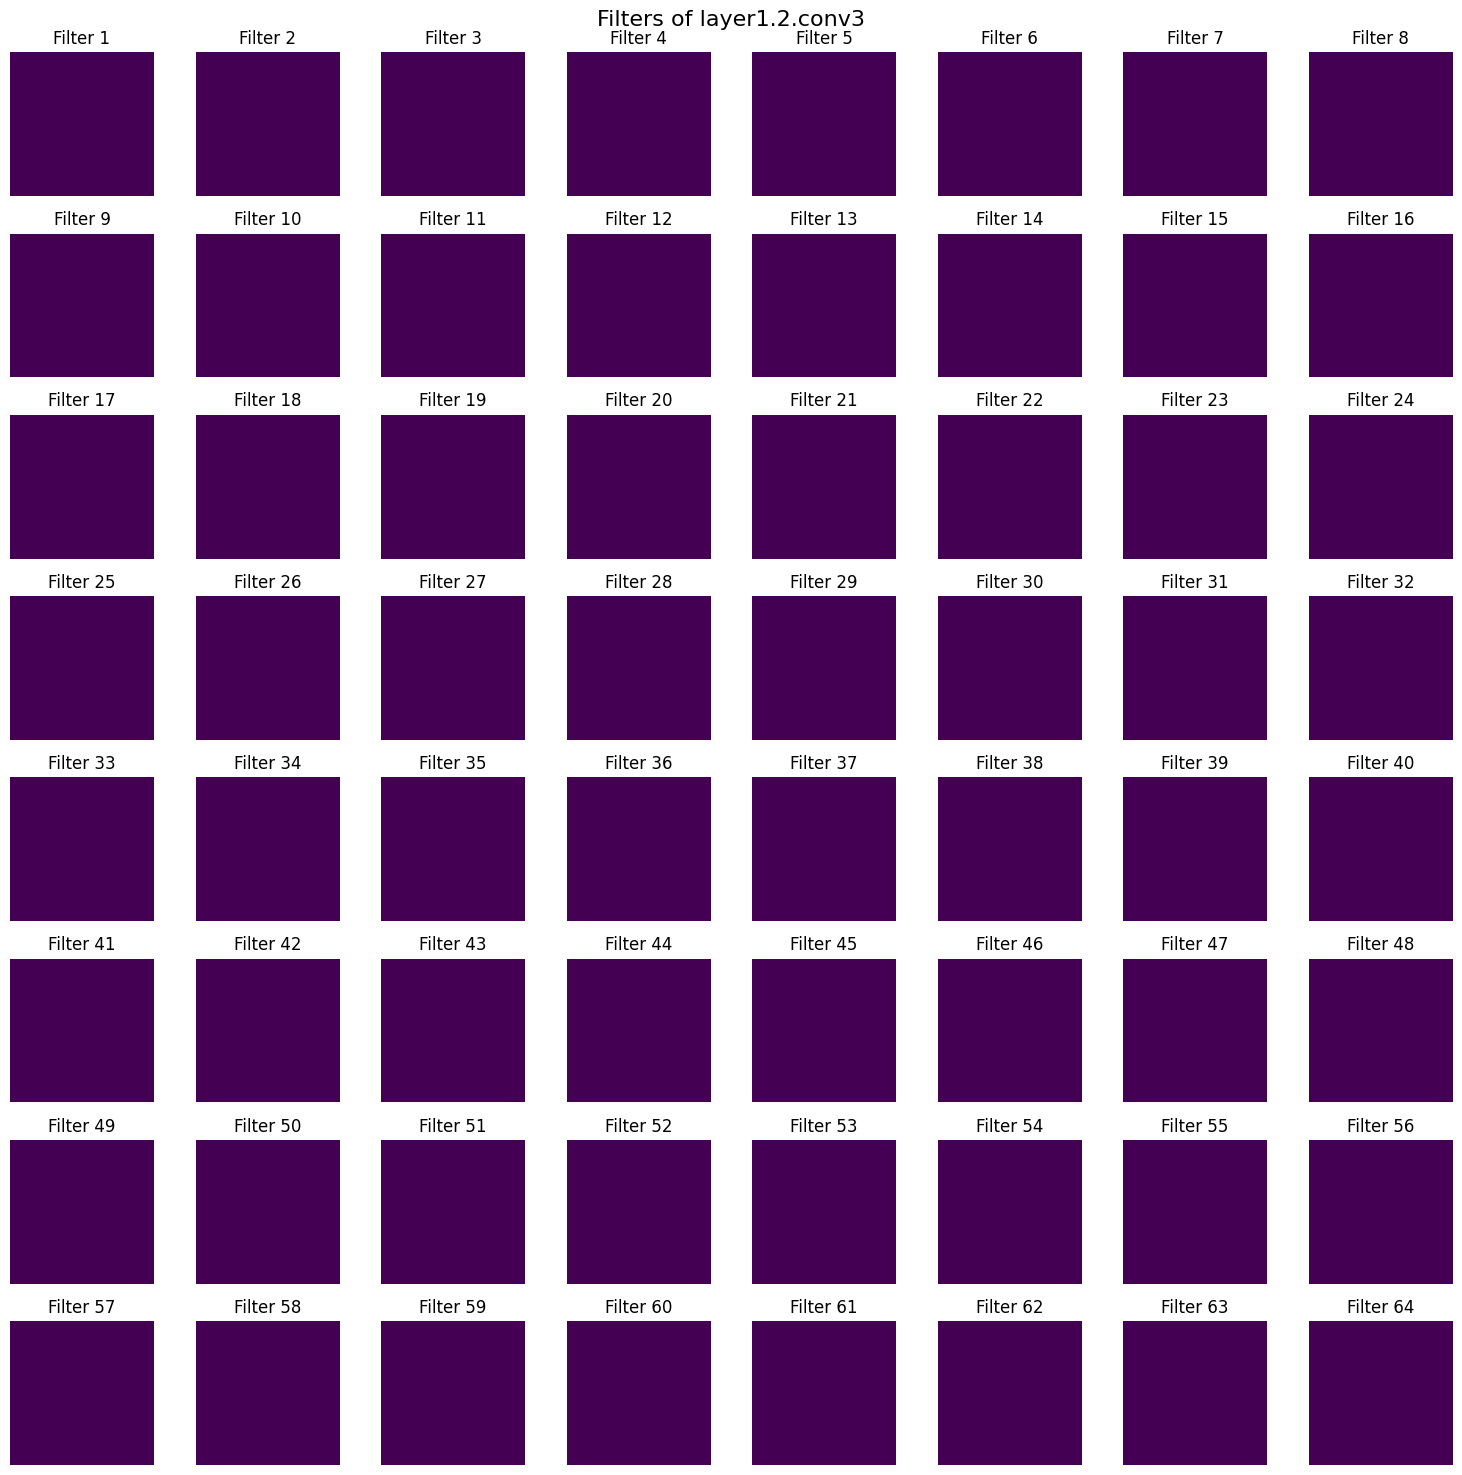

Visualizing filters for layer: layer2.0.conv1


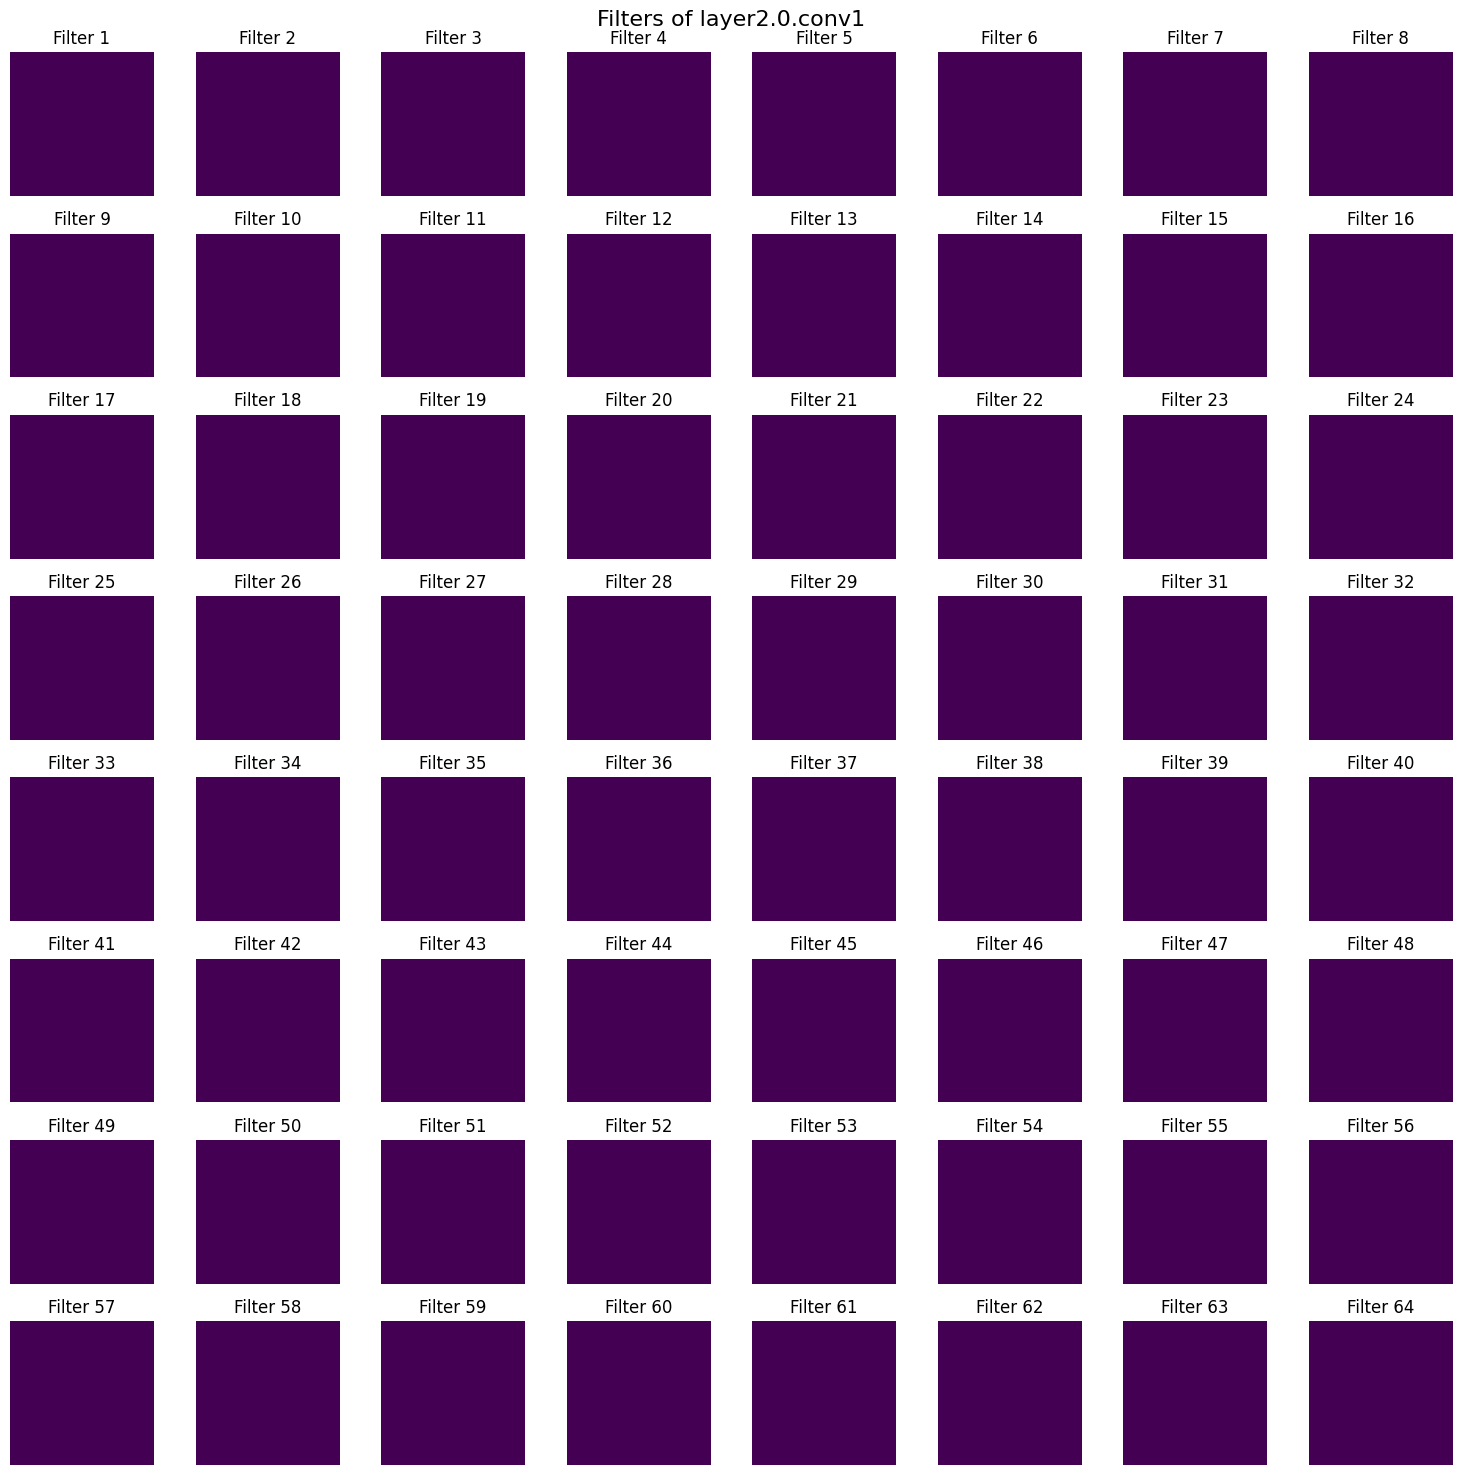

Visualizing filters for layer: layer2.0.conv2


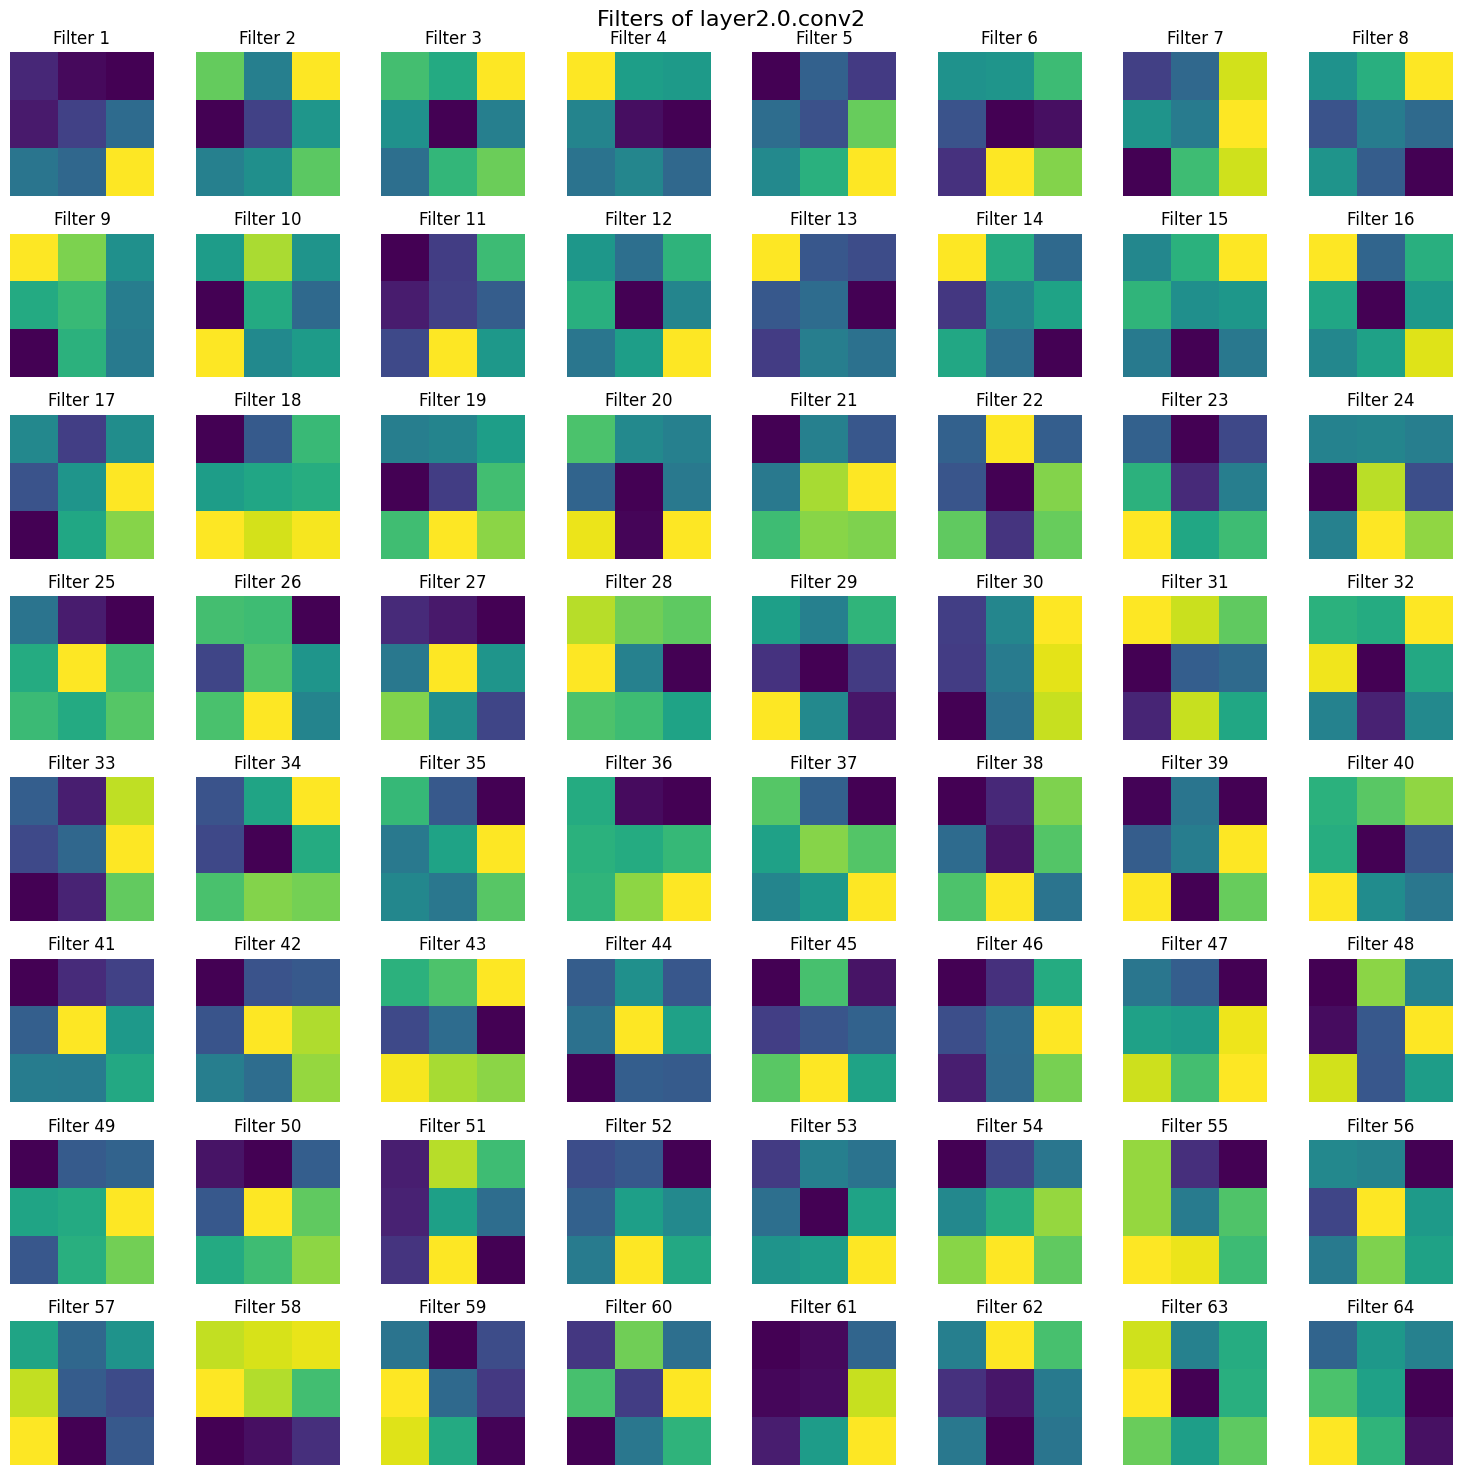

Visualizing filters for layer: layer2.0.conv3


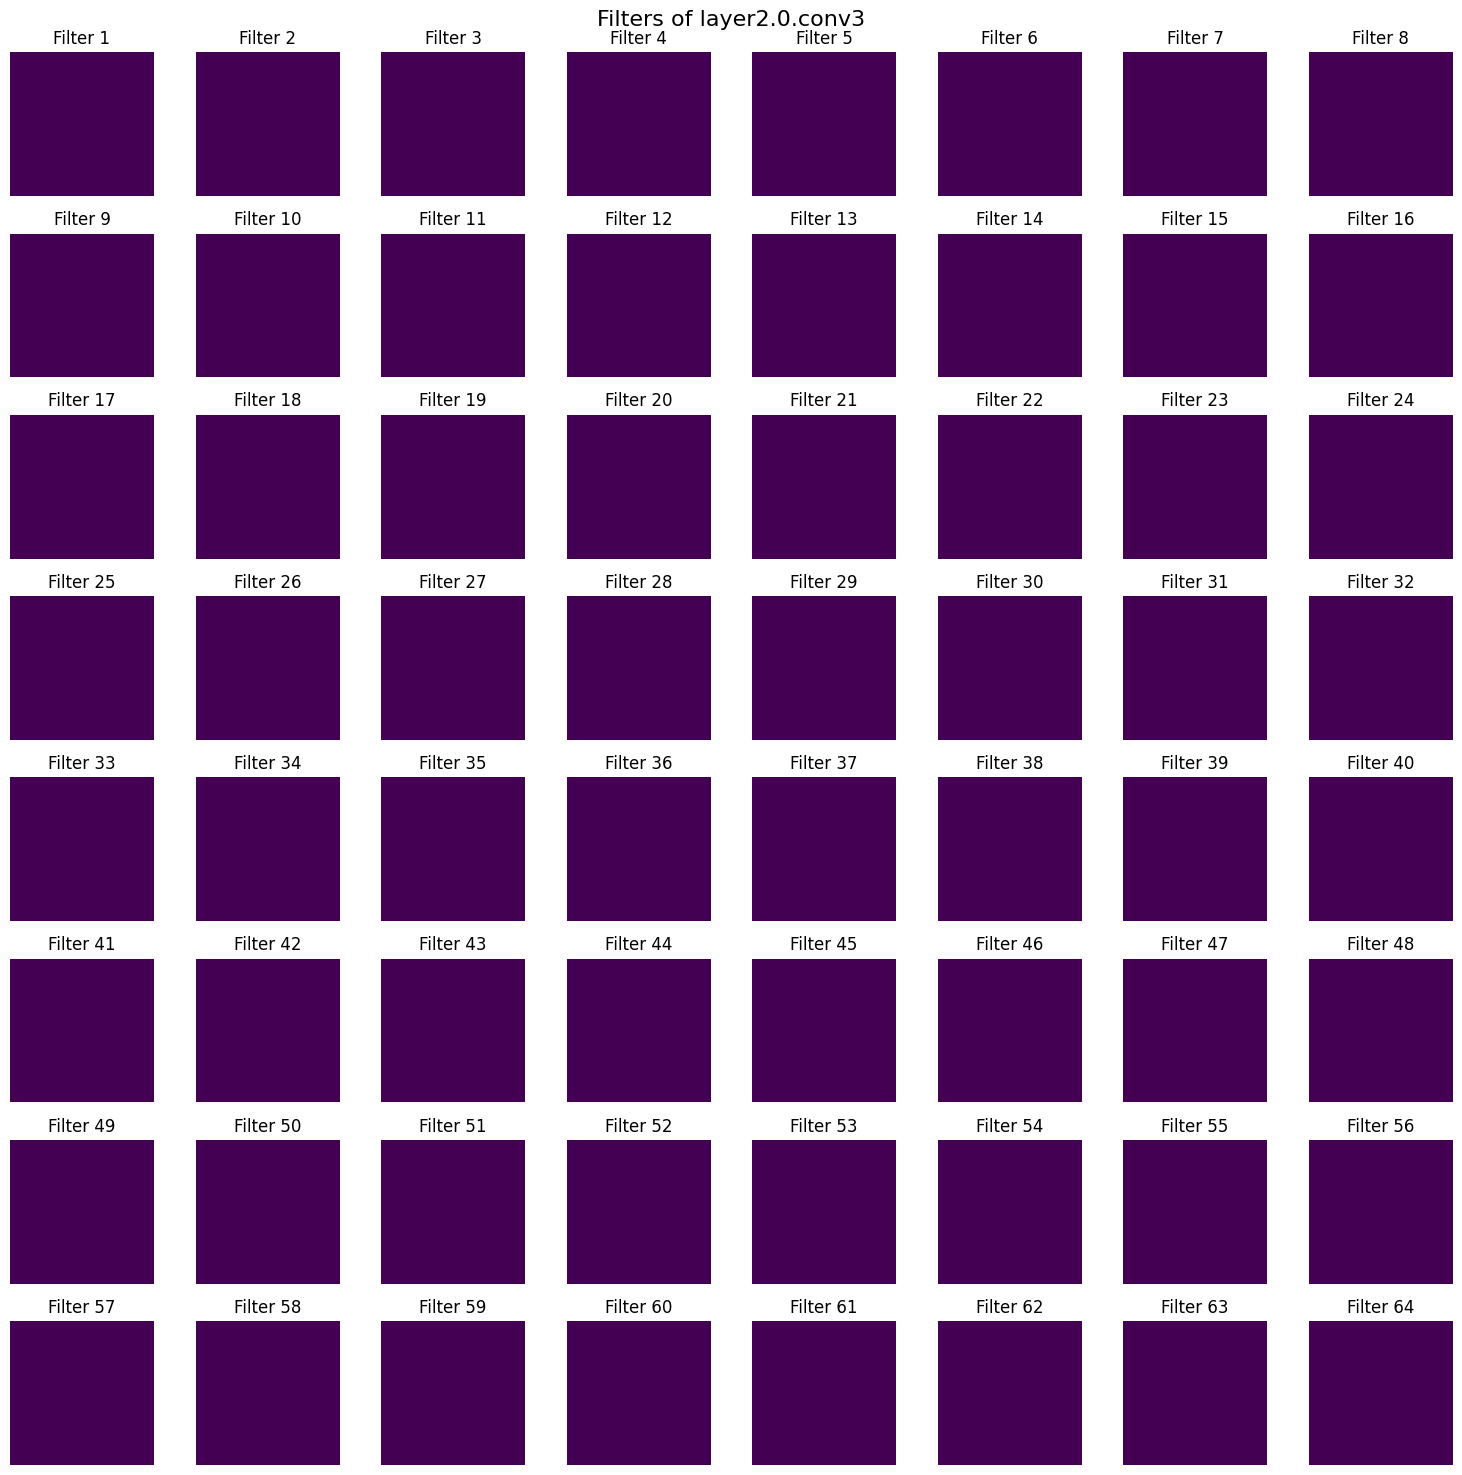

Visualizing filters for layer: layer2.0.downsample.0


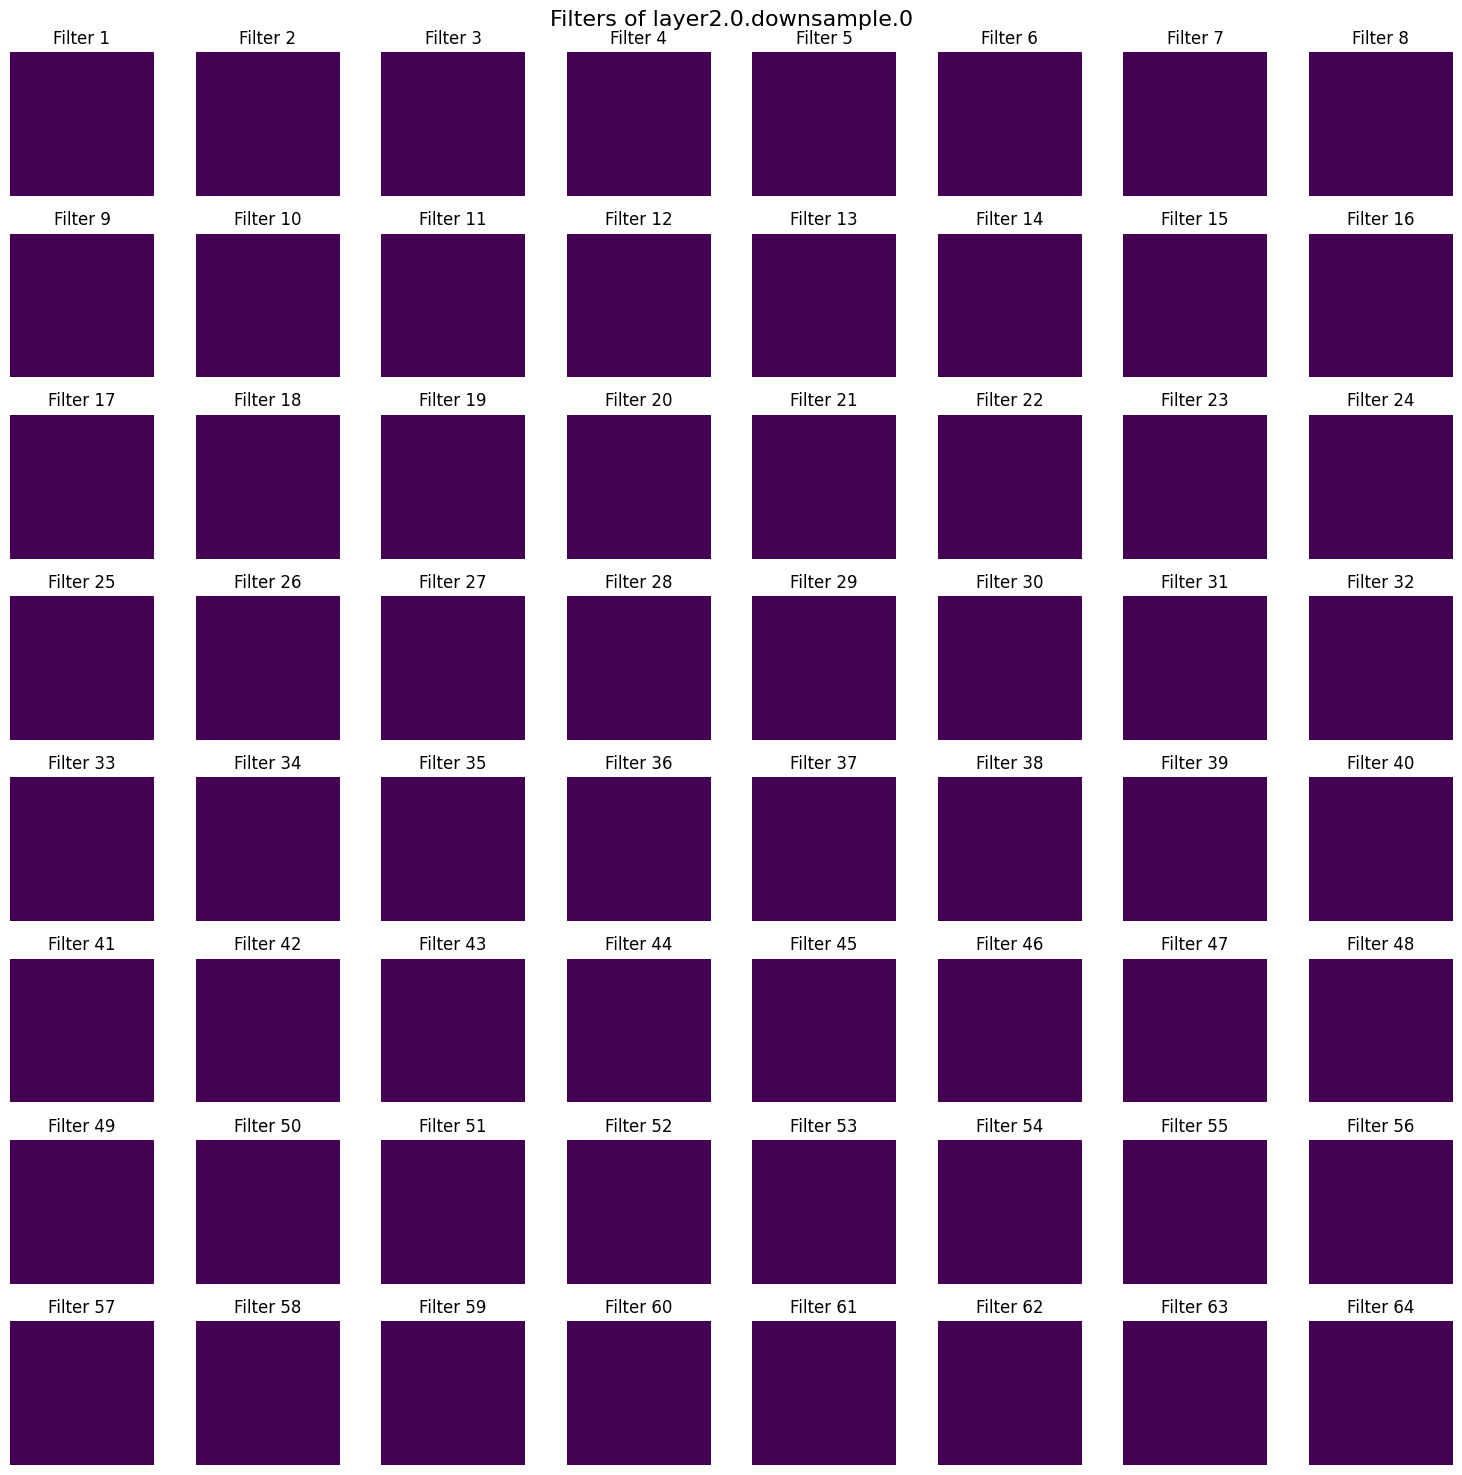

Visualizing filters for layer: layer2.1.conv1


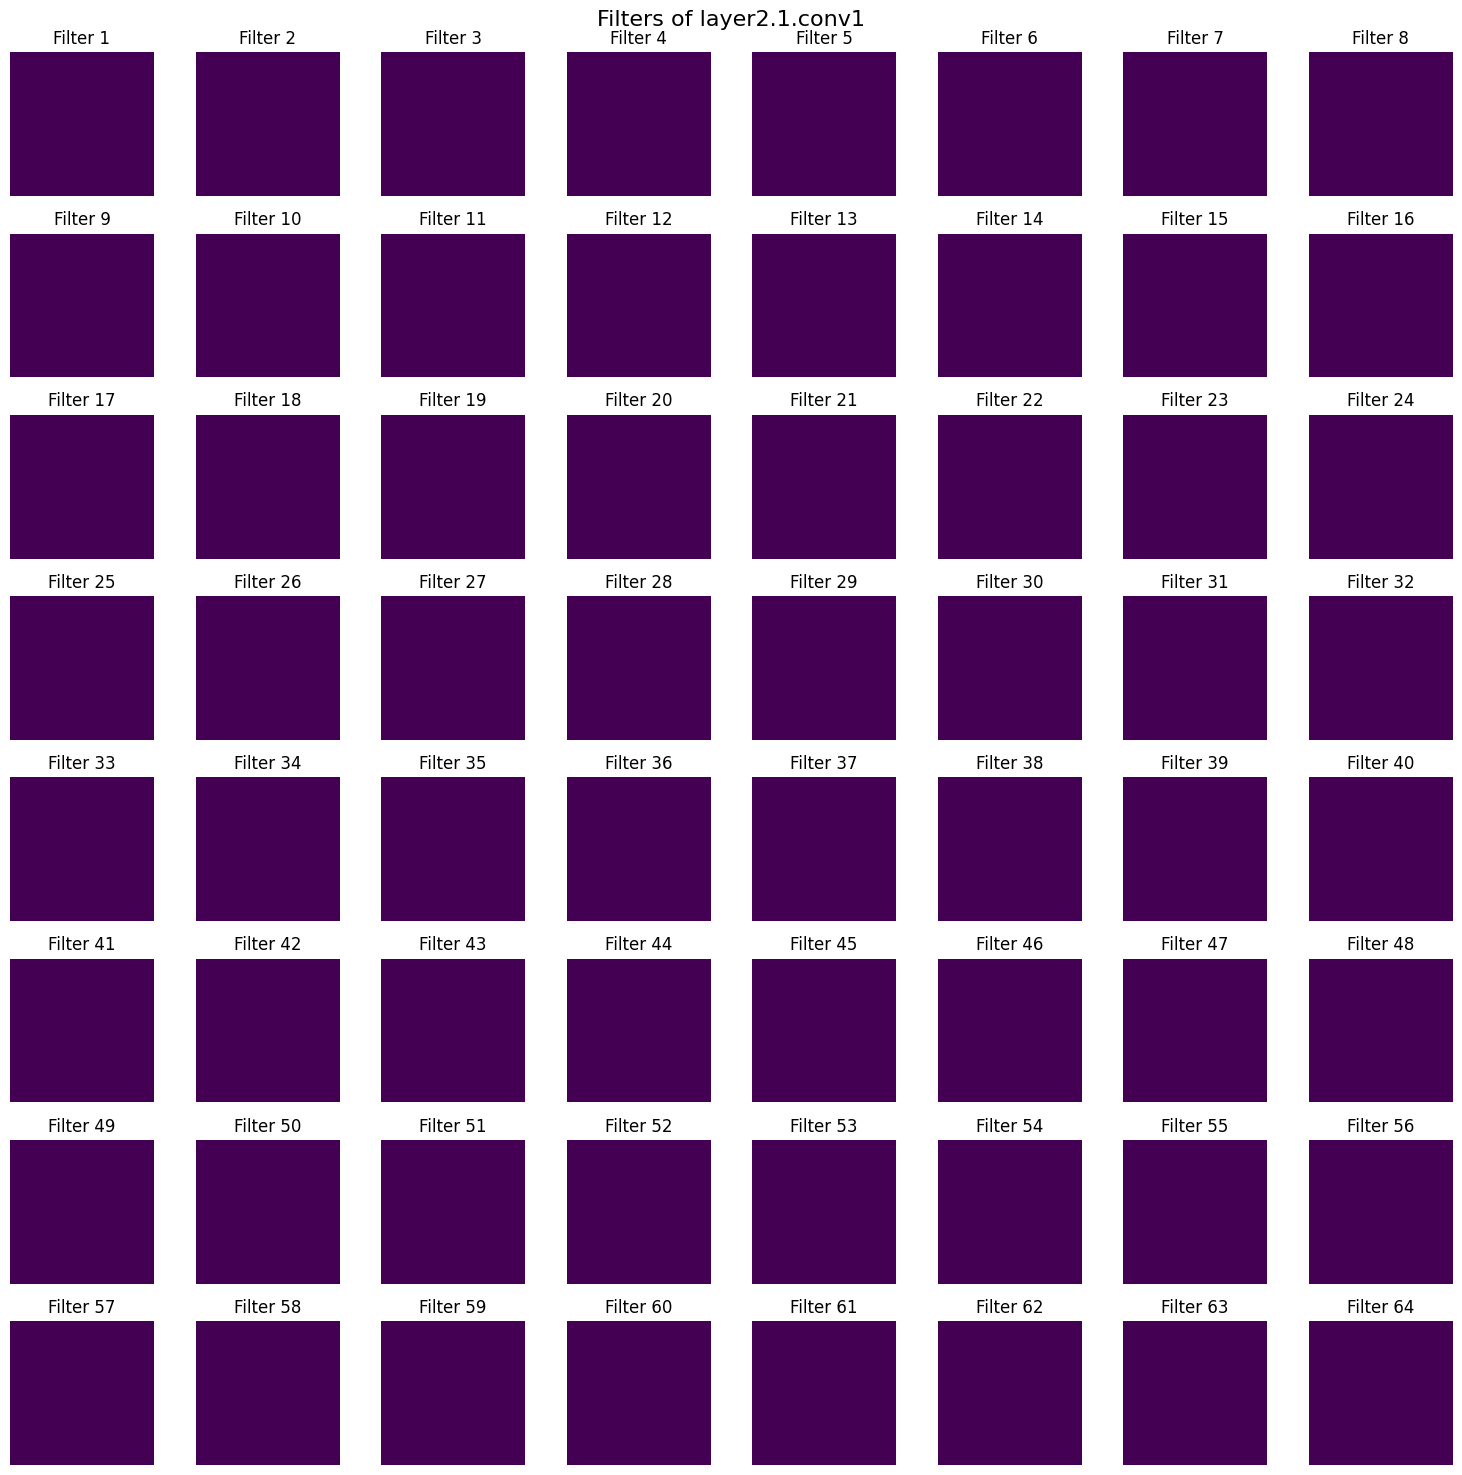

Visualizing filters for layer: layer2.1.conv2


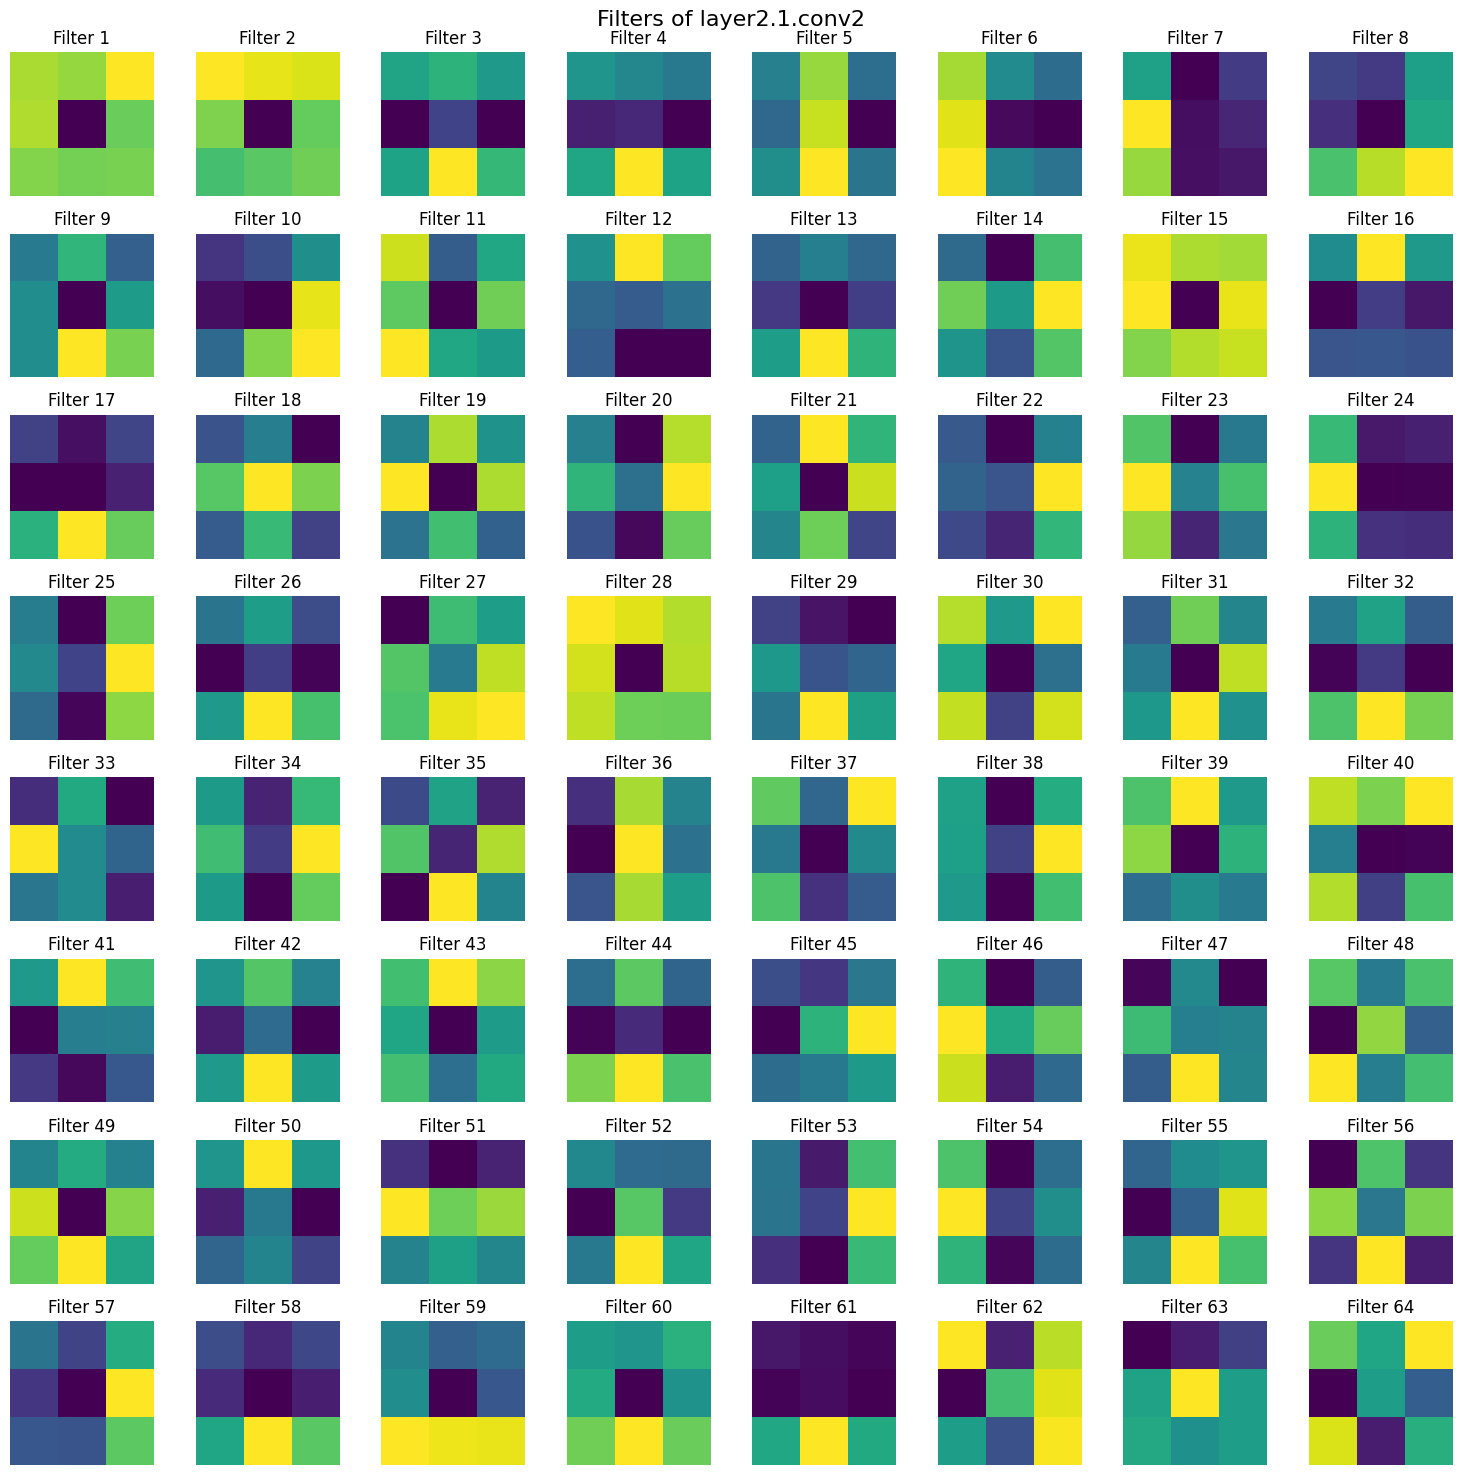

Visualizing filters for layer: layer2.1.conv3


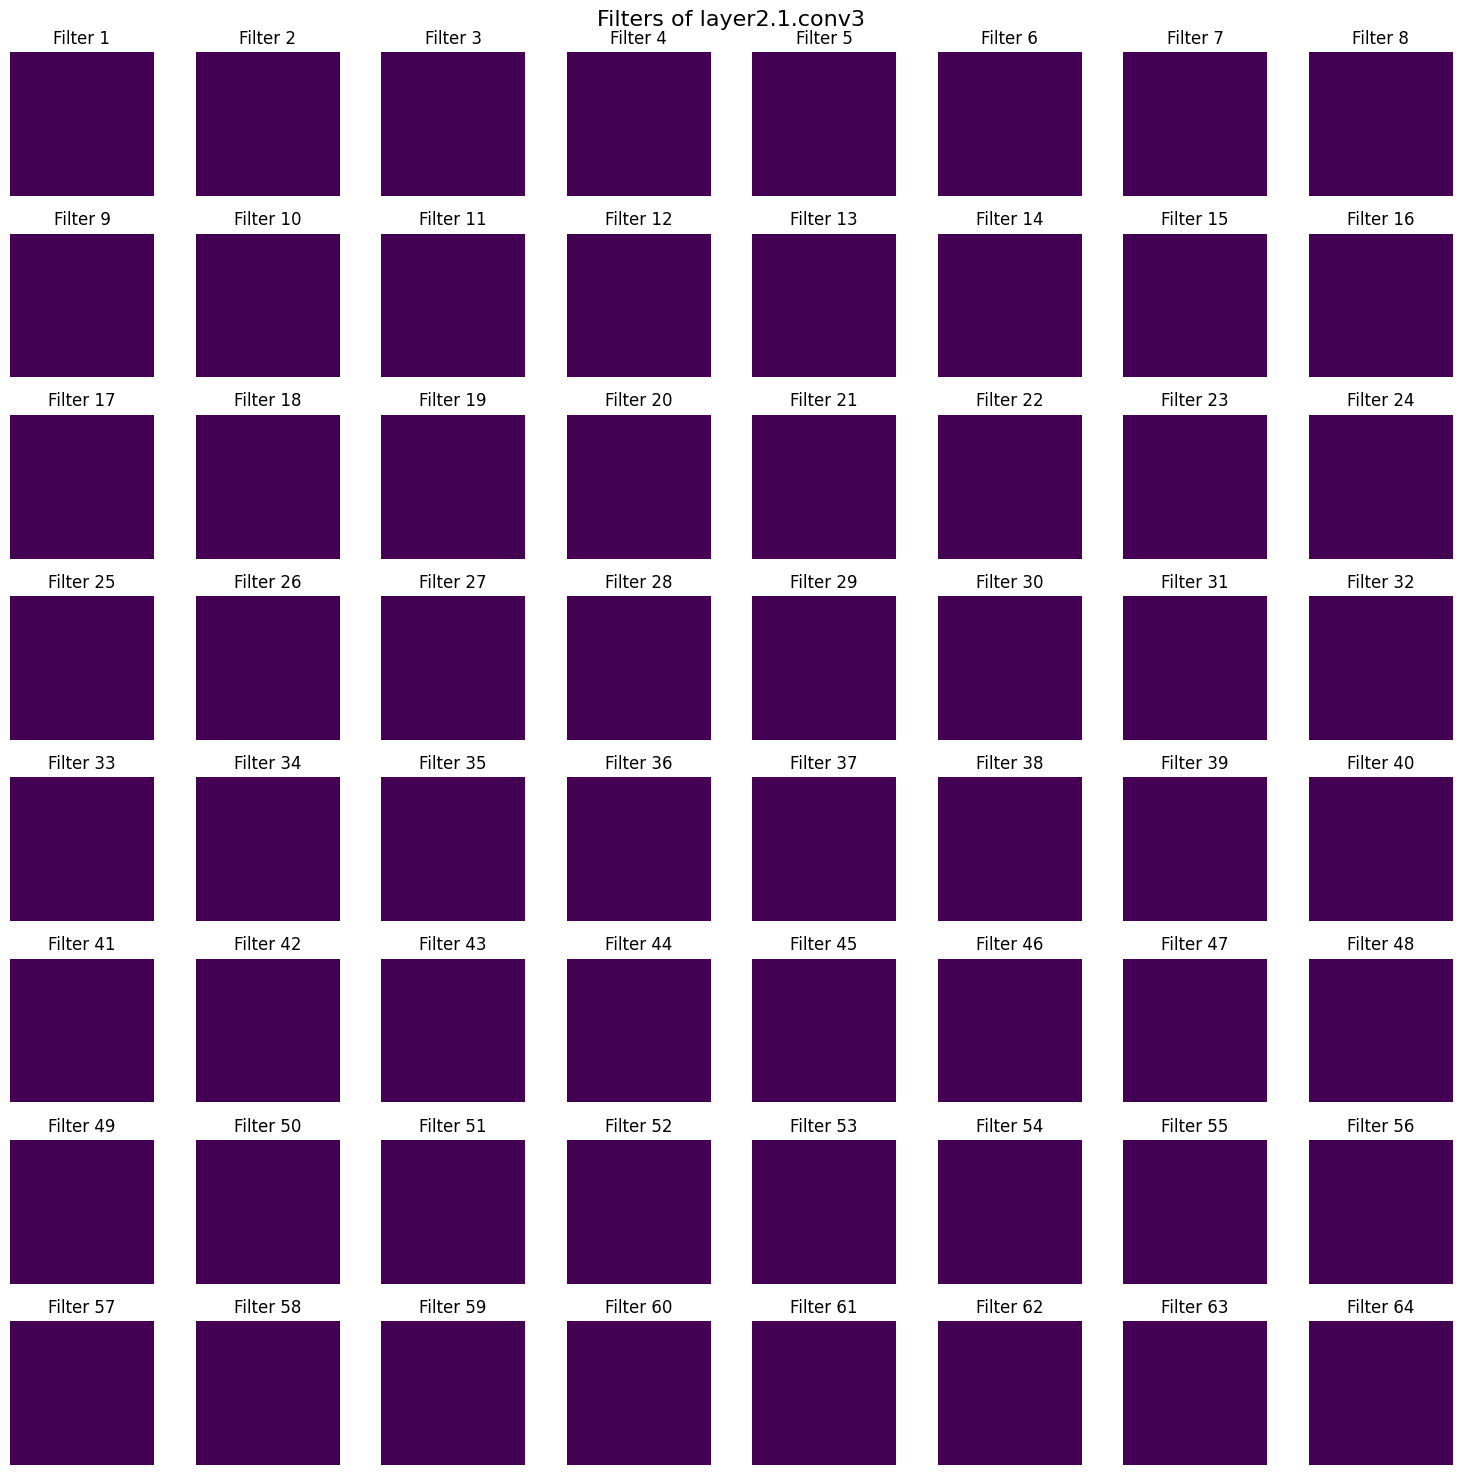

Visualizing filters for layer: layer2.2.conv1


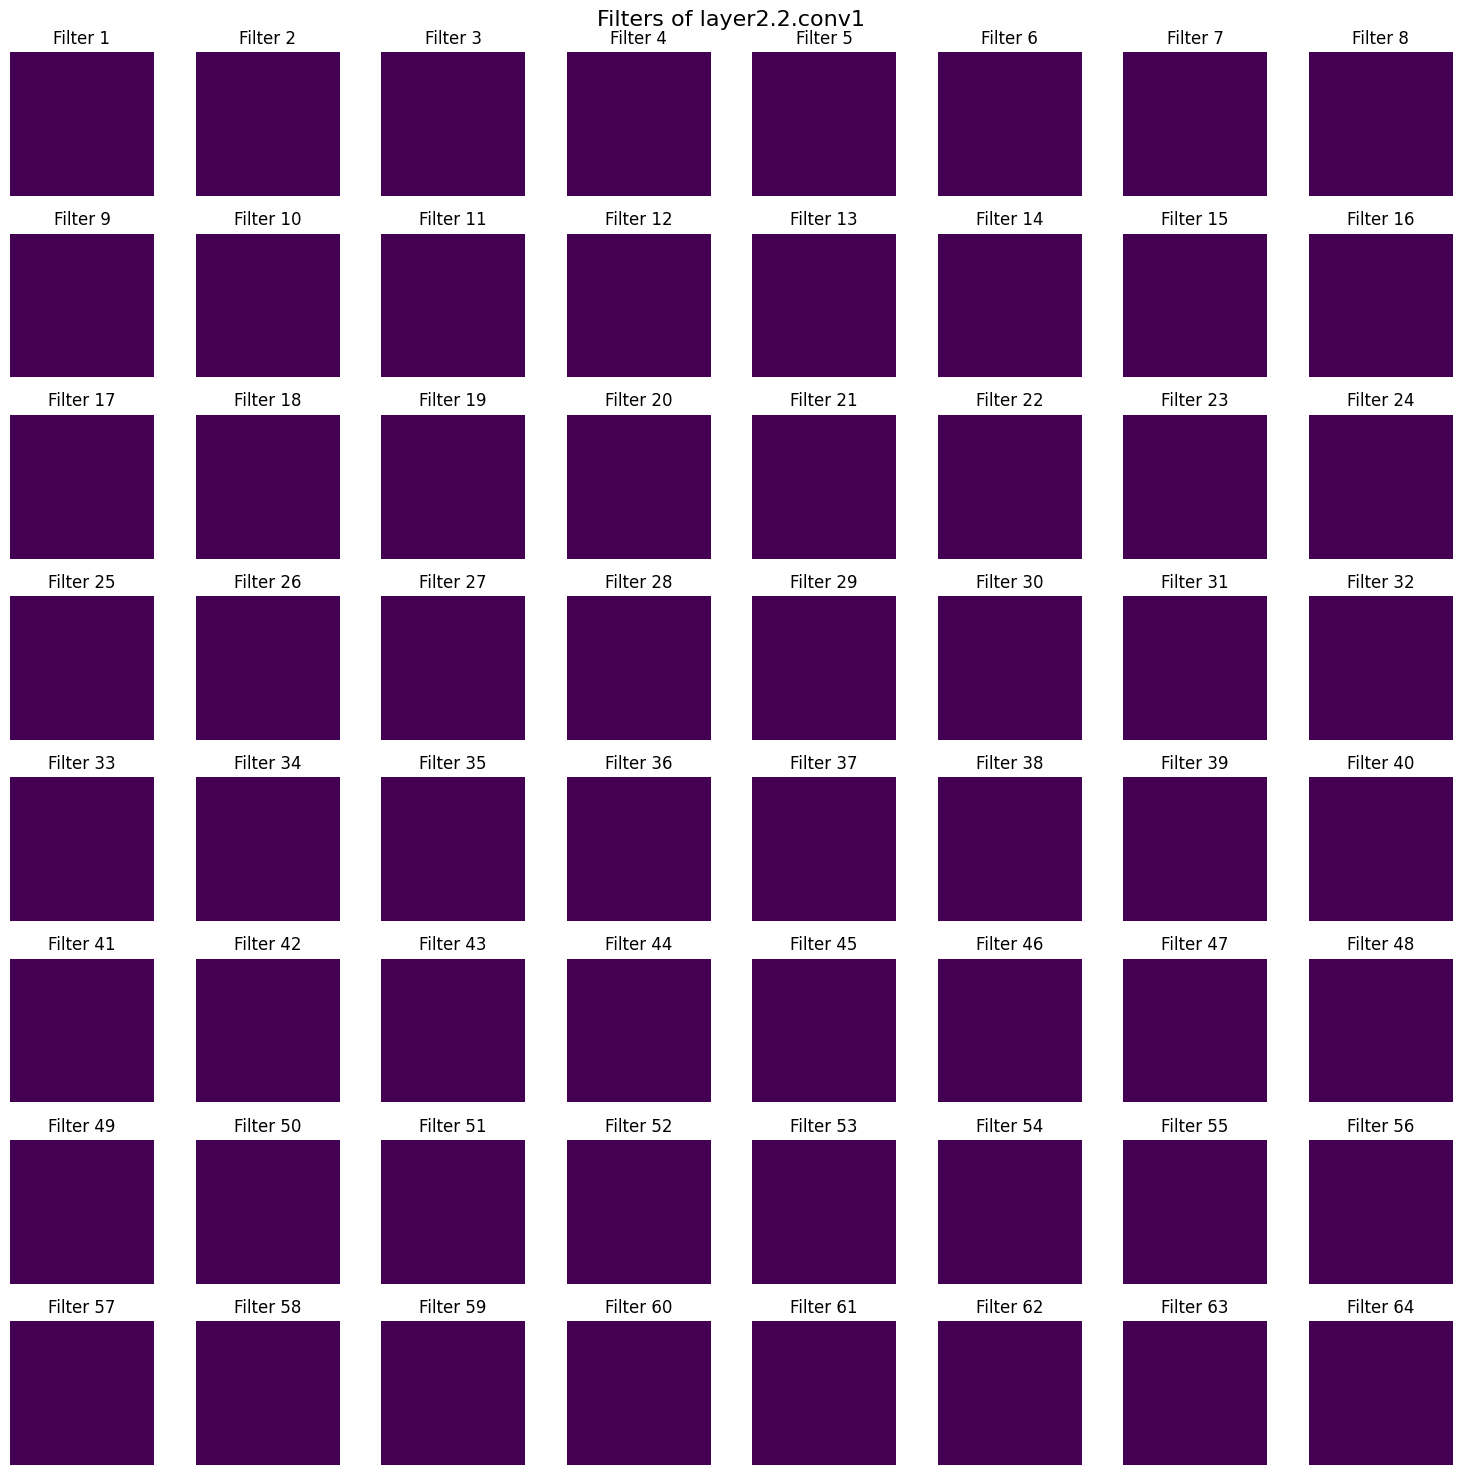

Visualizing filters for layer: layer2.2.conv2


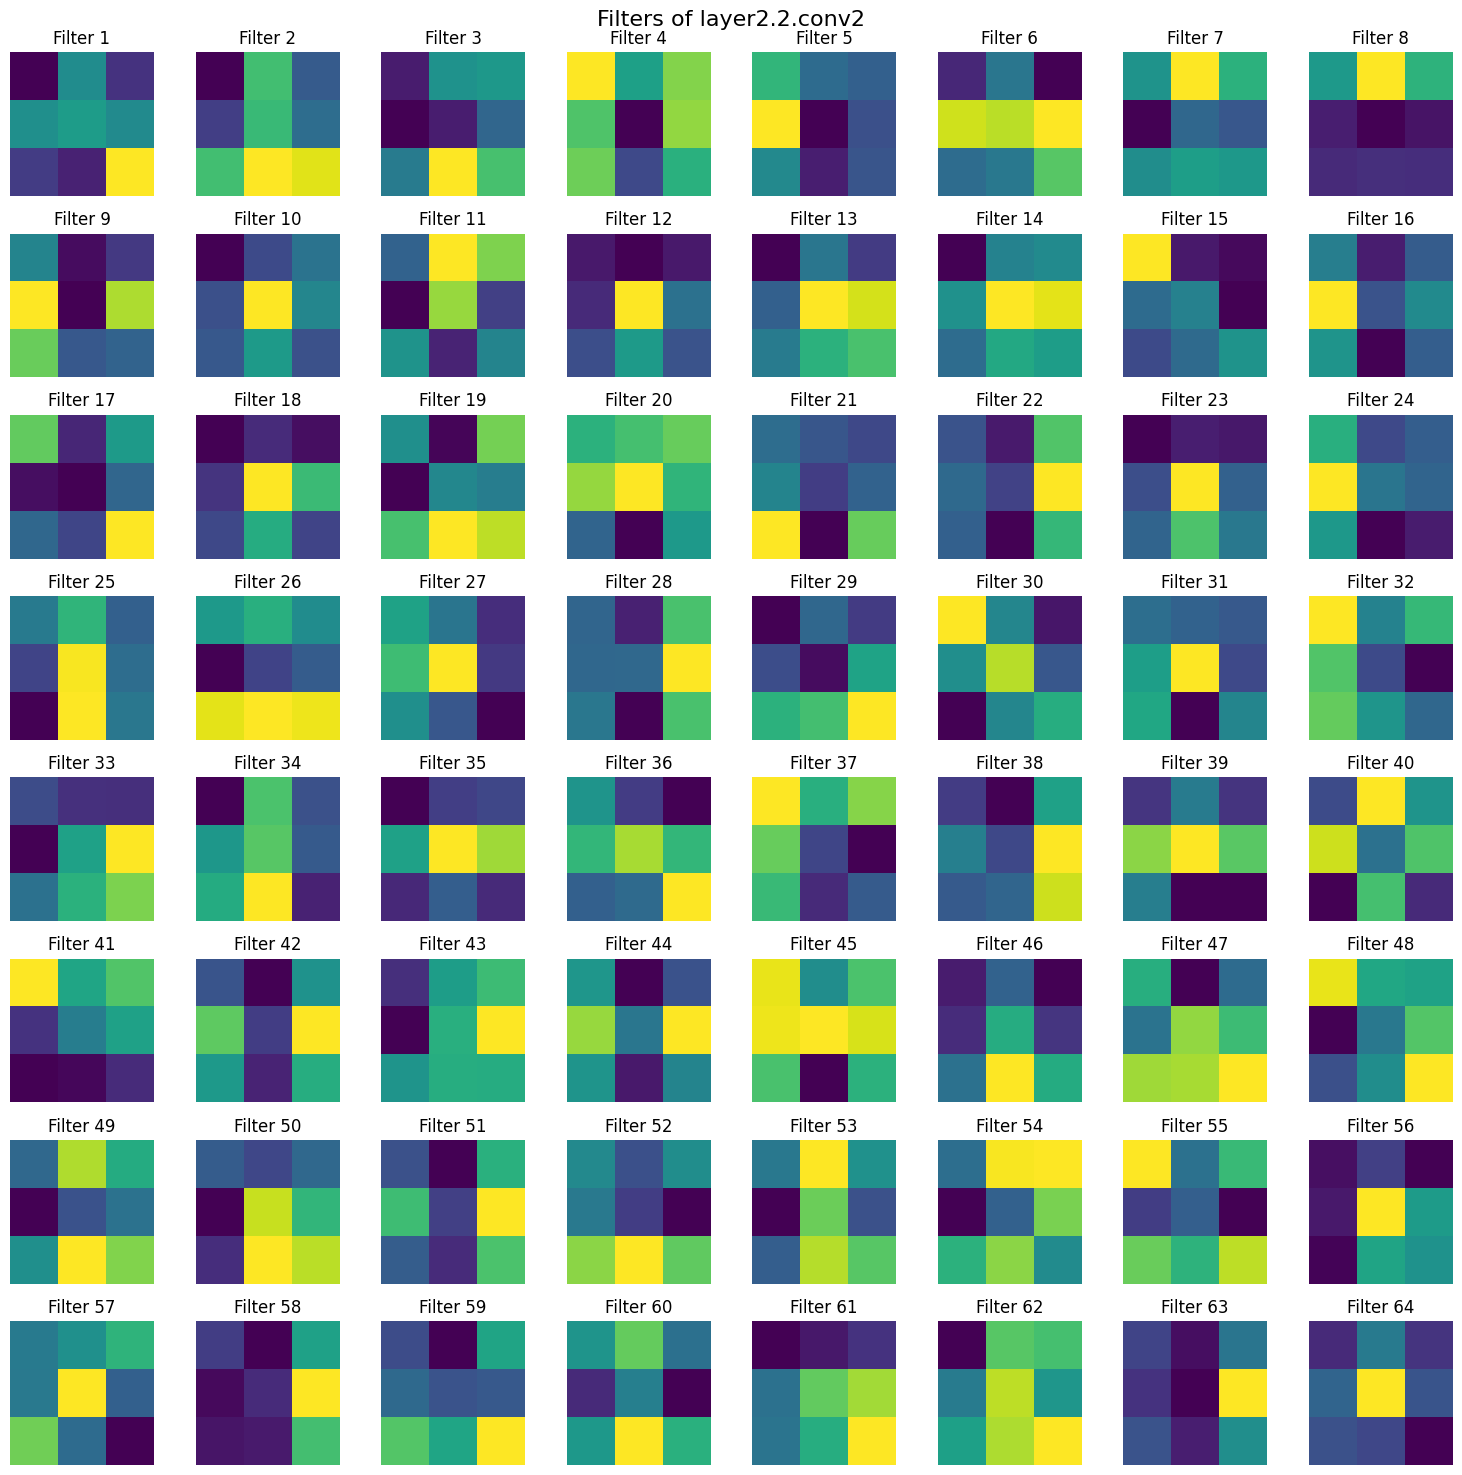

Visualizing filters for layer: layer2.2.conv3


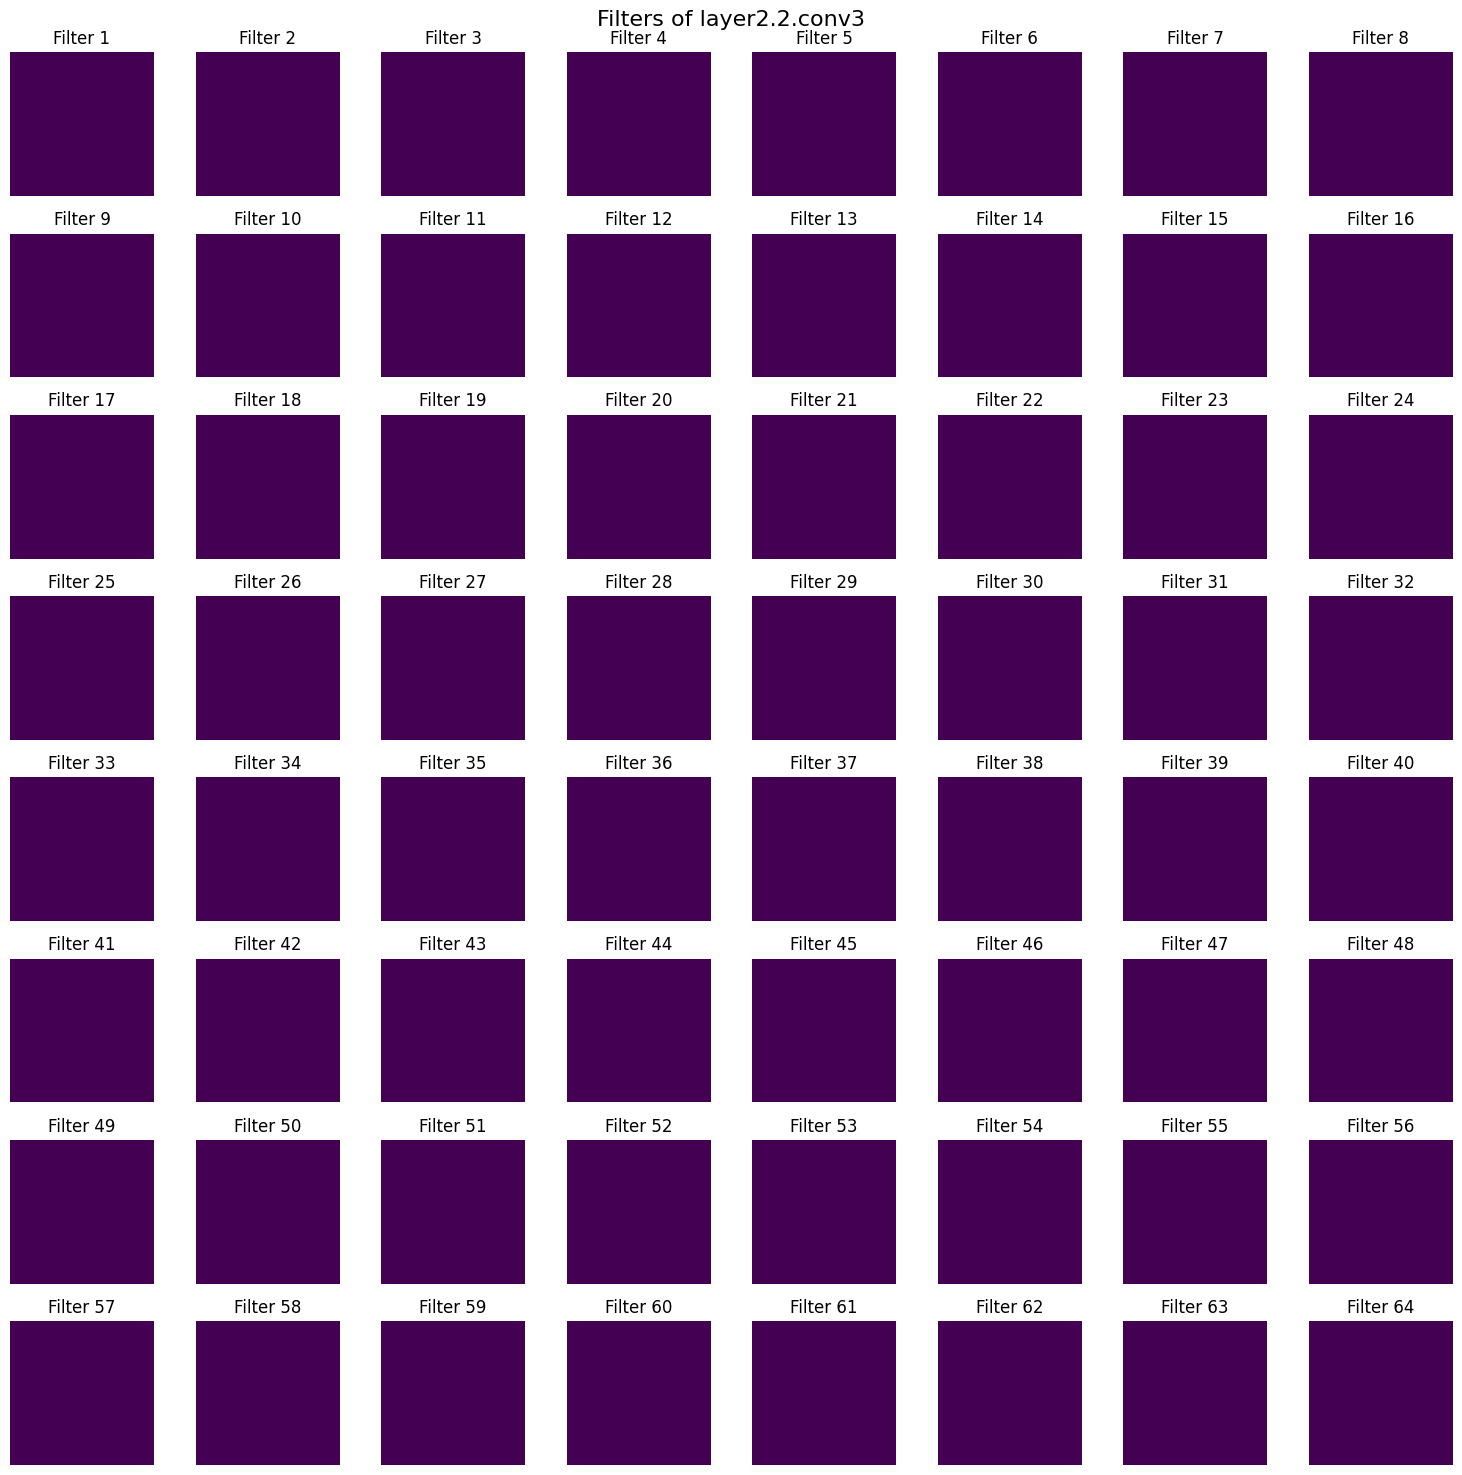

Visualizing filters for layer: layer2.3.conv1


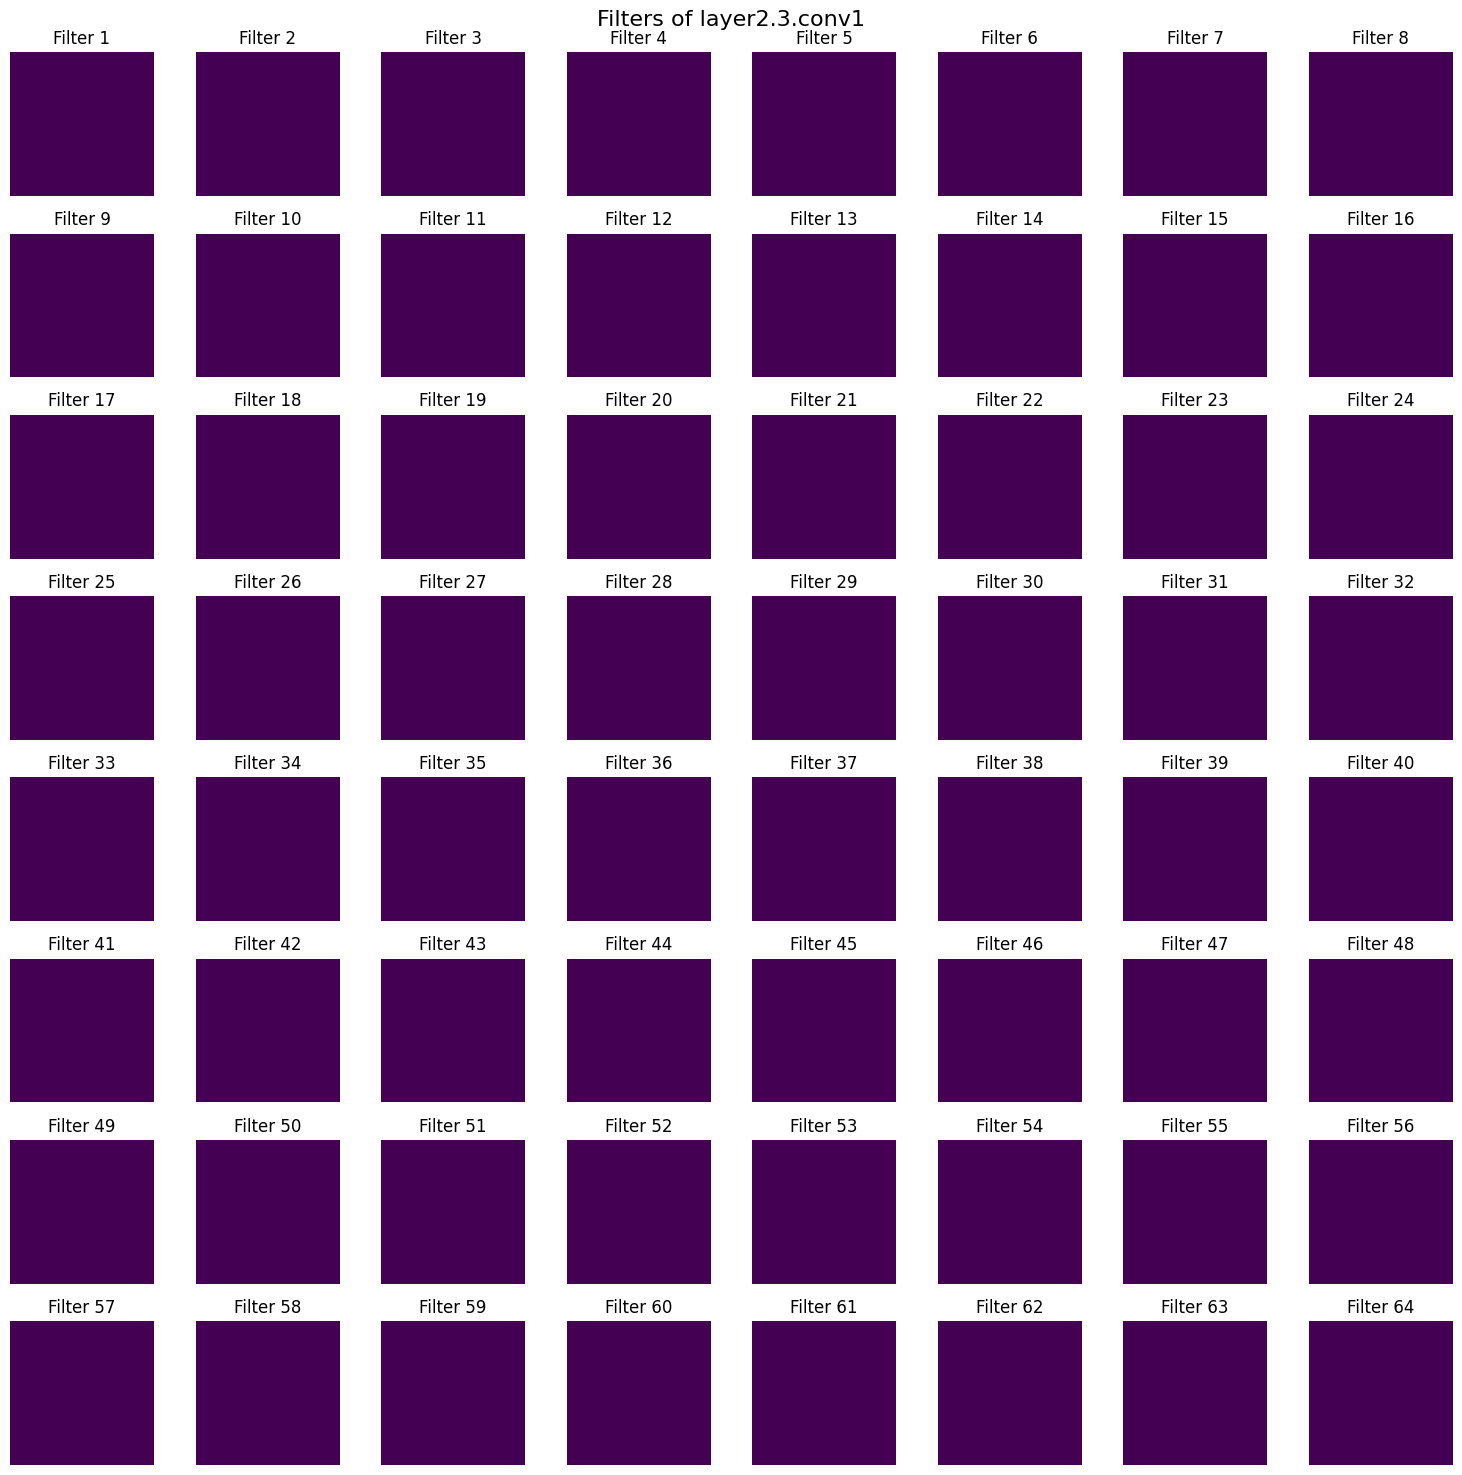

Visualizing filters for layer: layer2.3.conv2


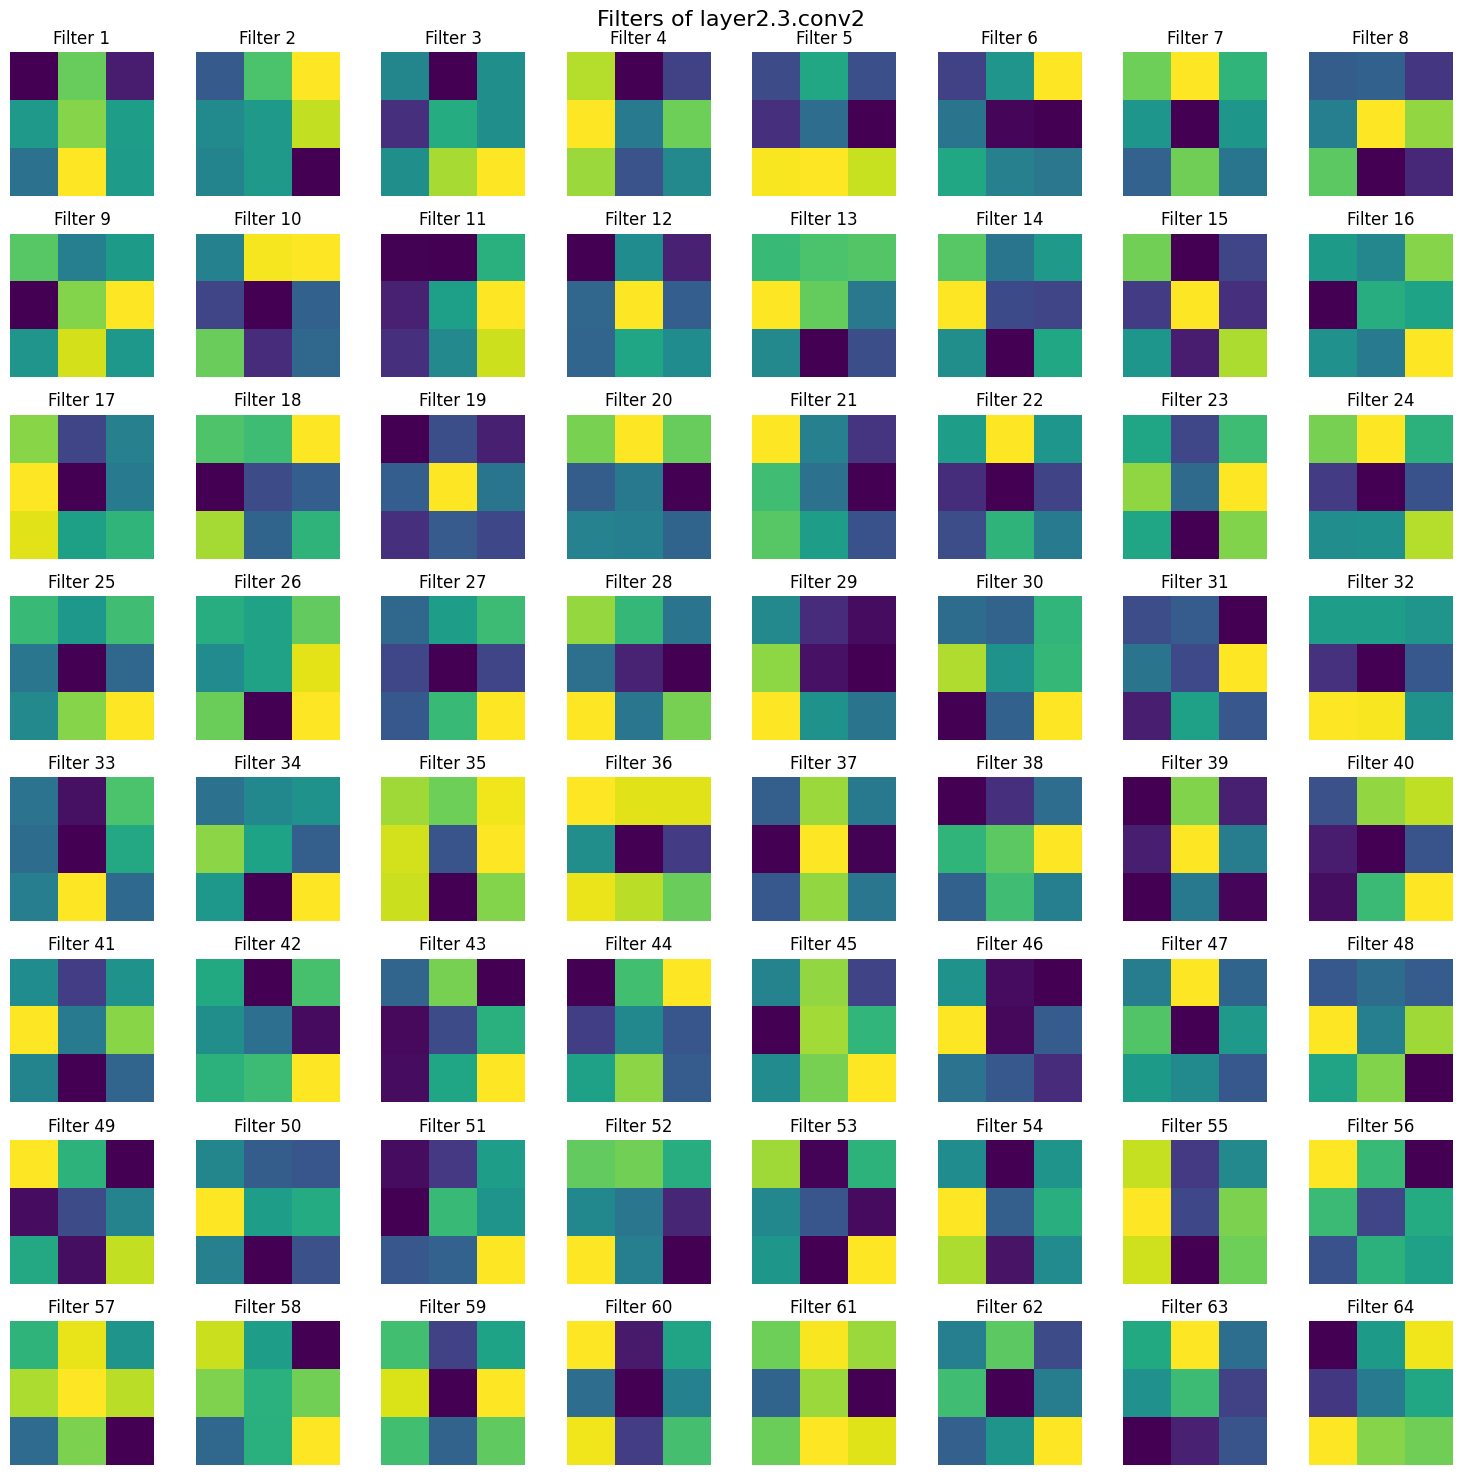

Visualizing filters for layer: layer2.3.conv3


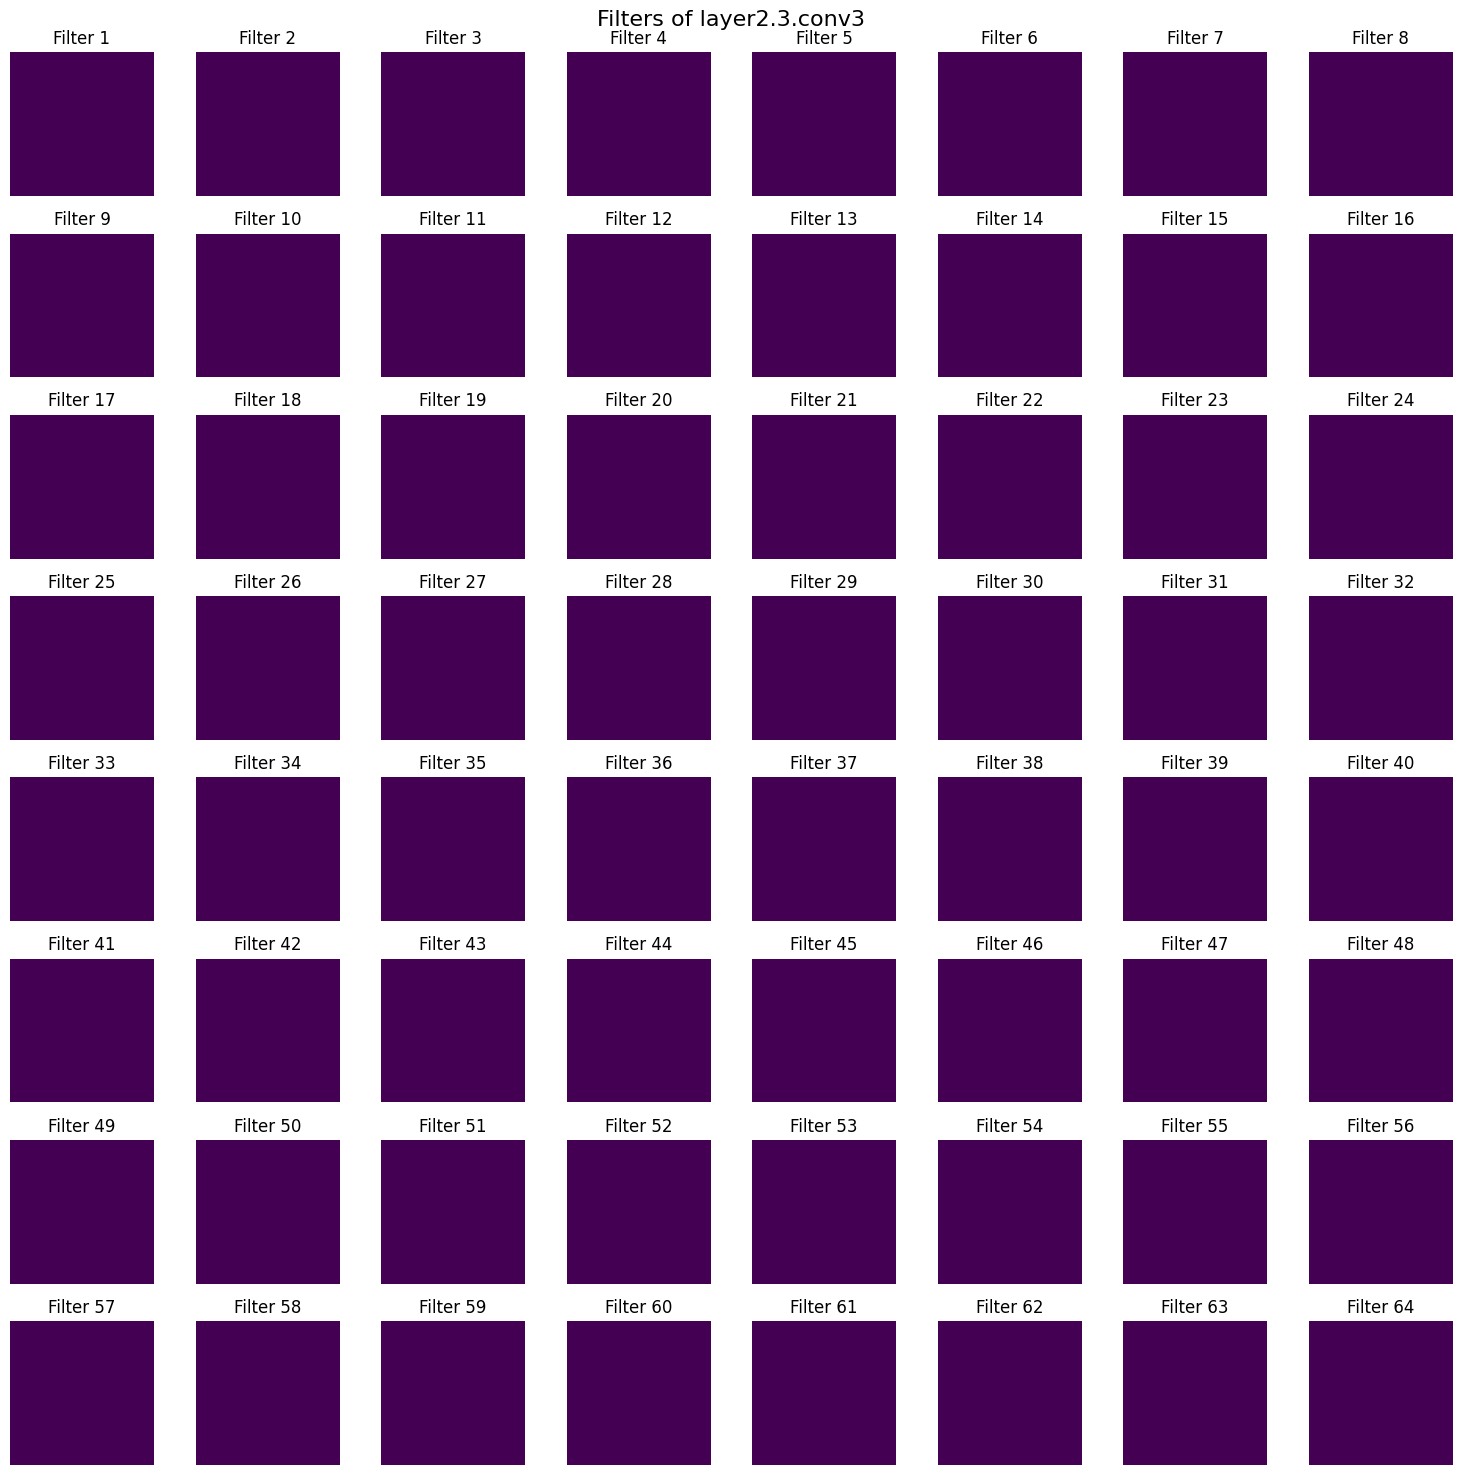

Visualizing filters for layer: layer3.0.conv1


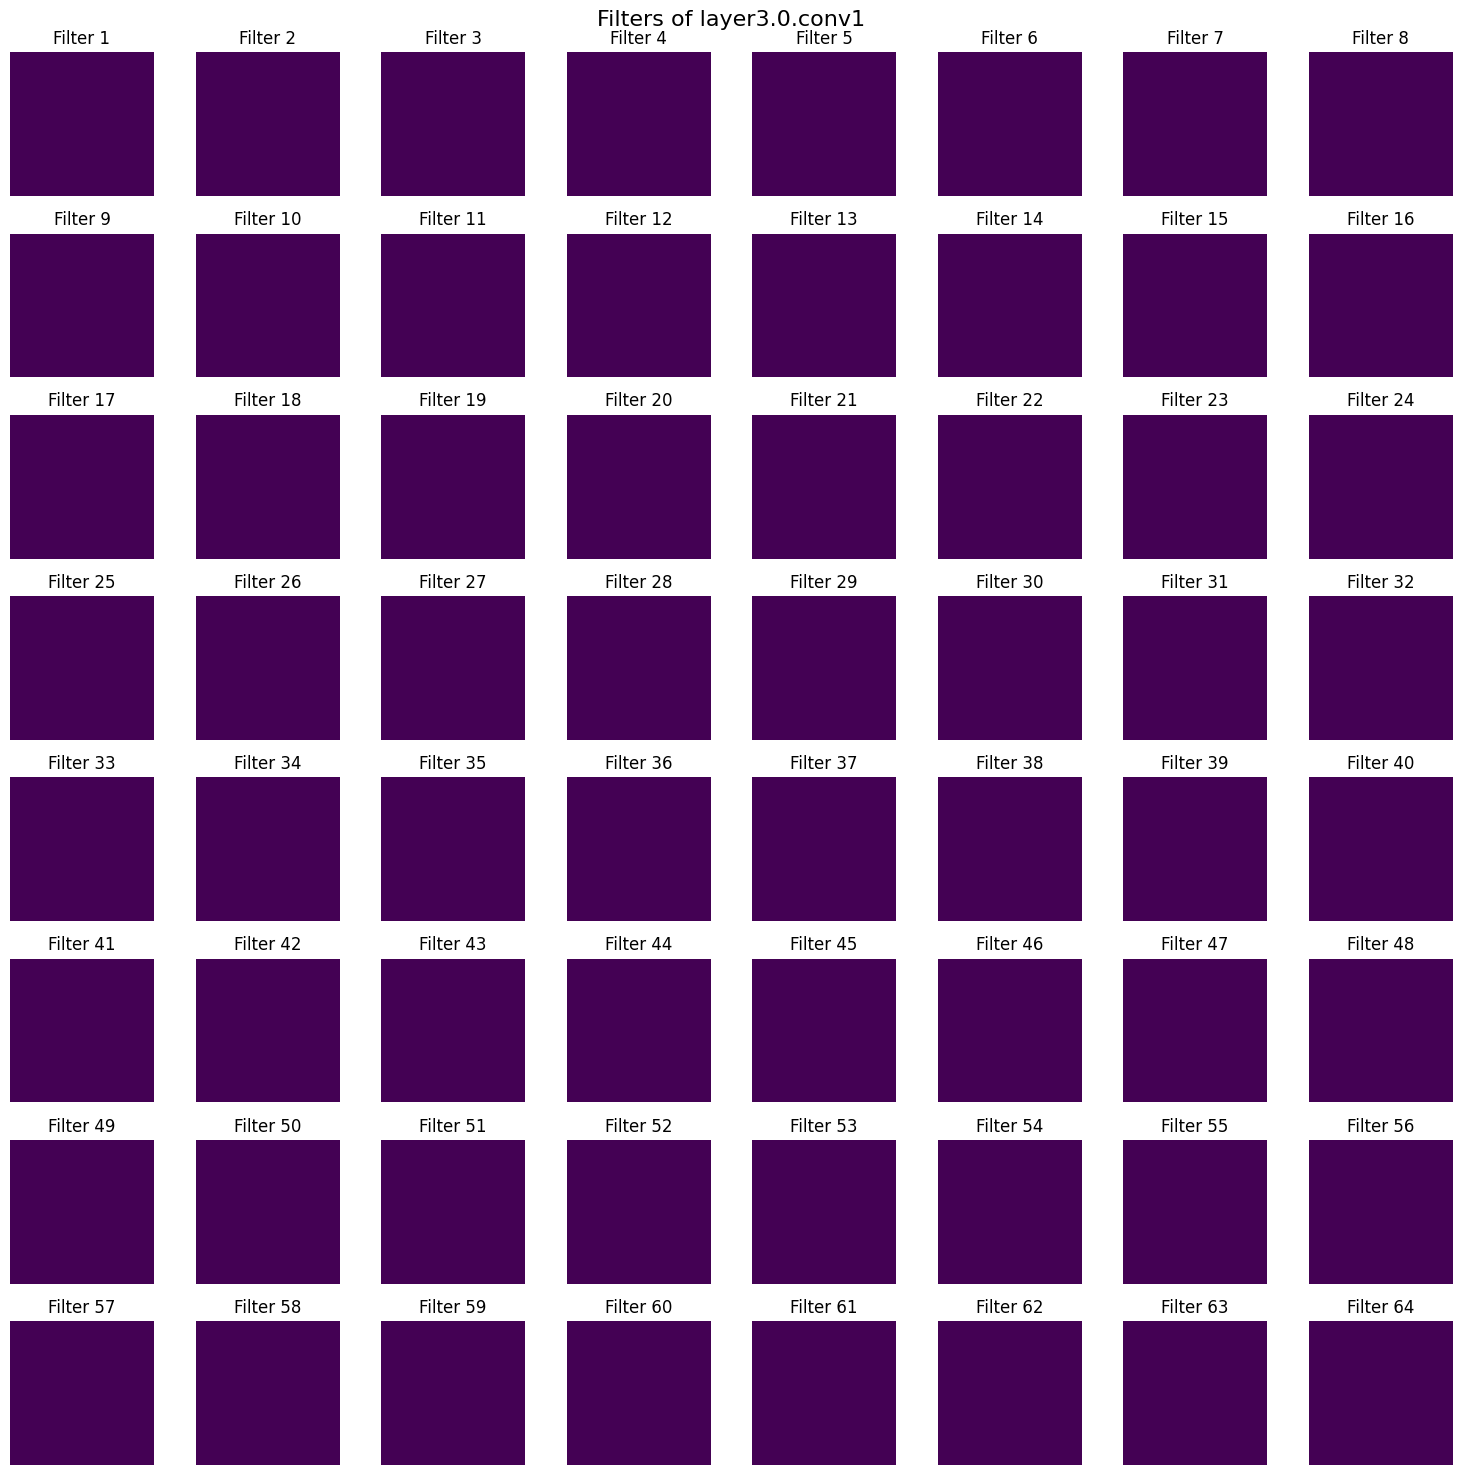

Visualizing filters for layer: layer3.0.conv2


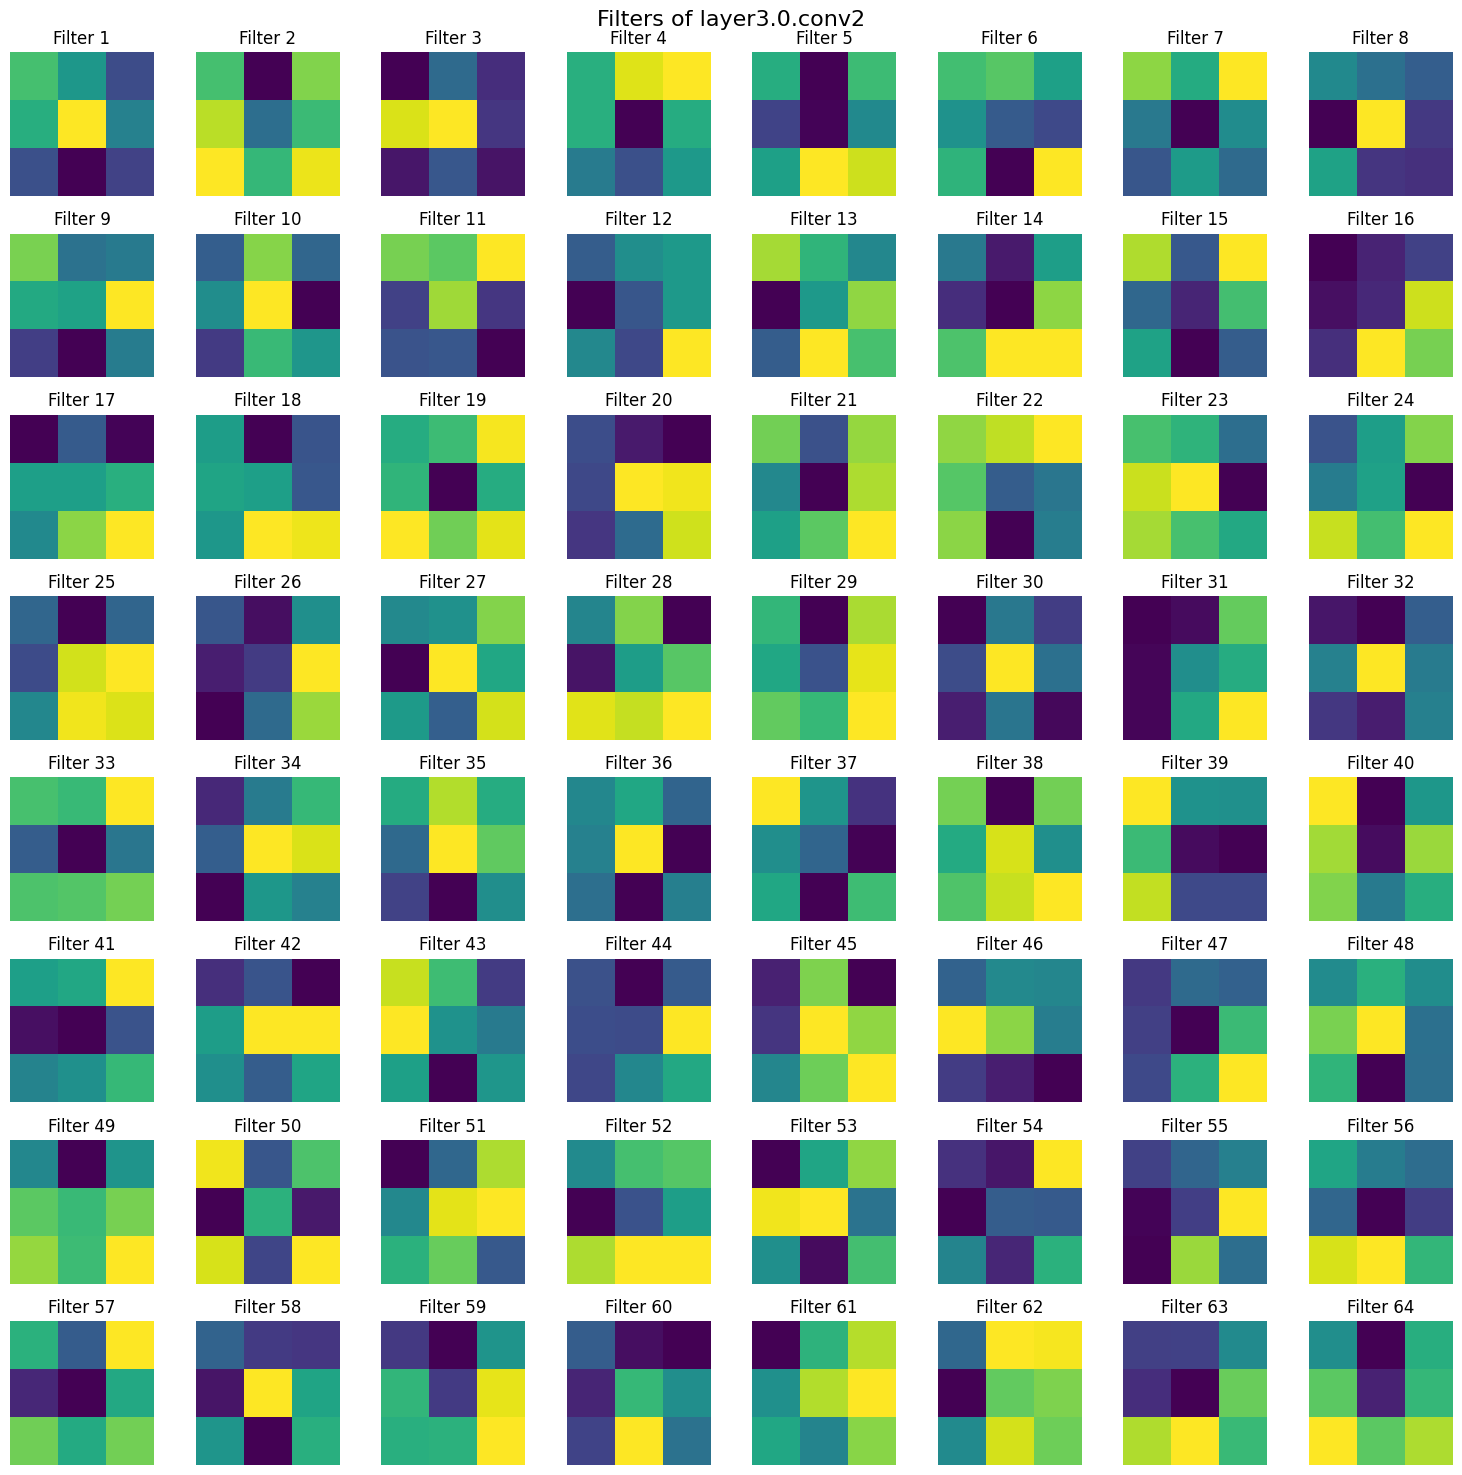

Visualizing filters for layer: layer3.0.conv3


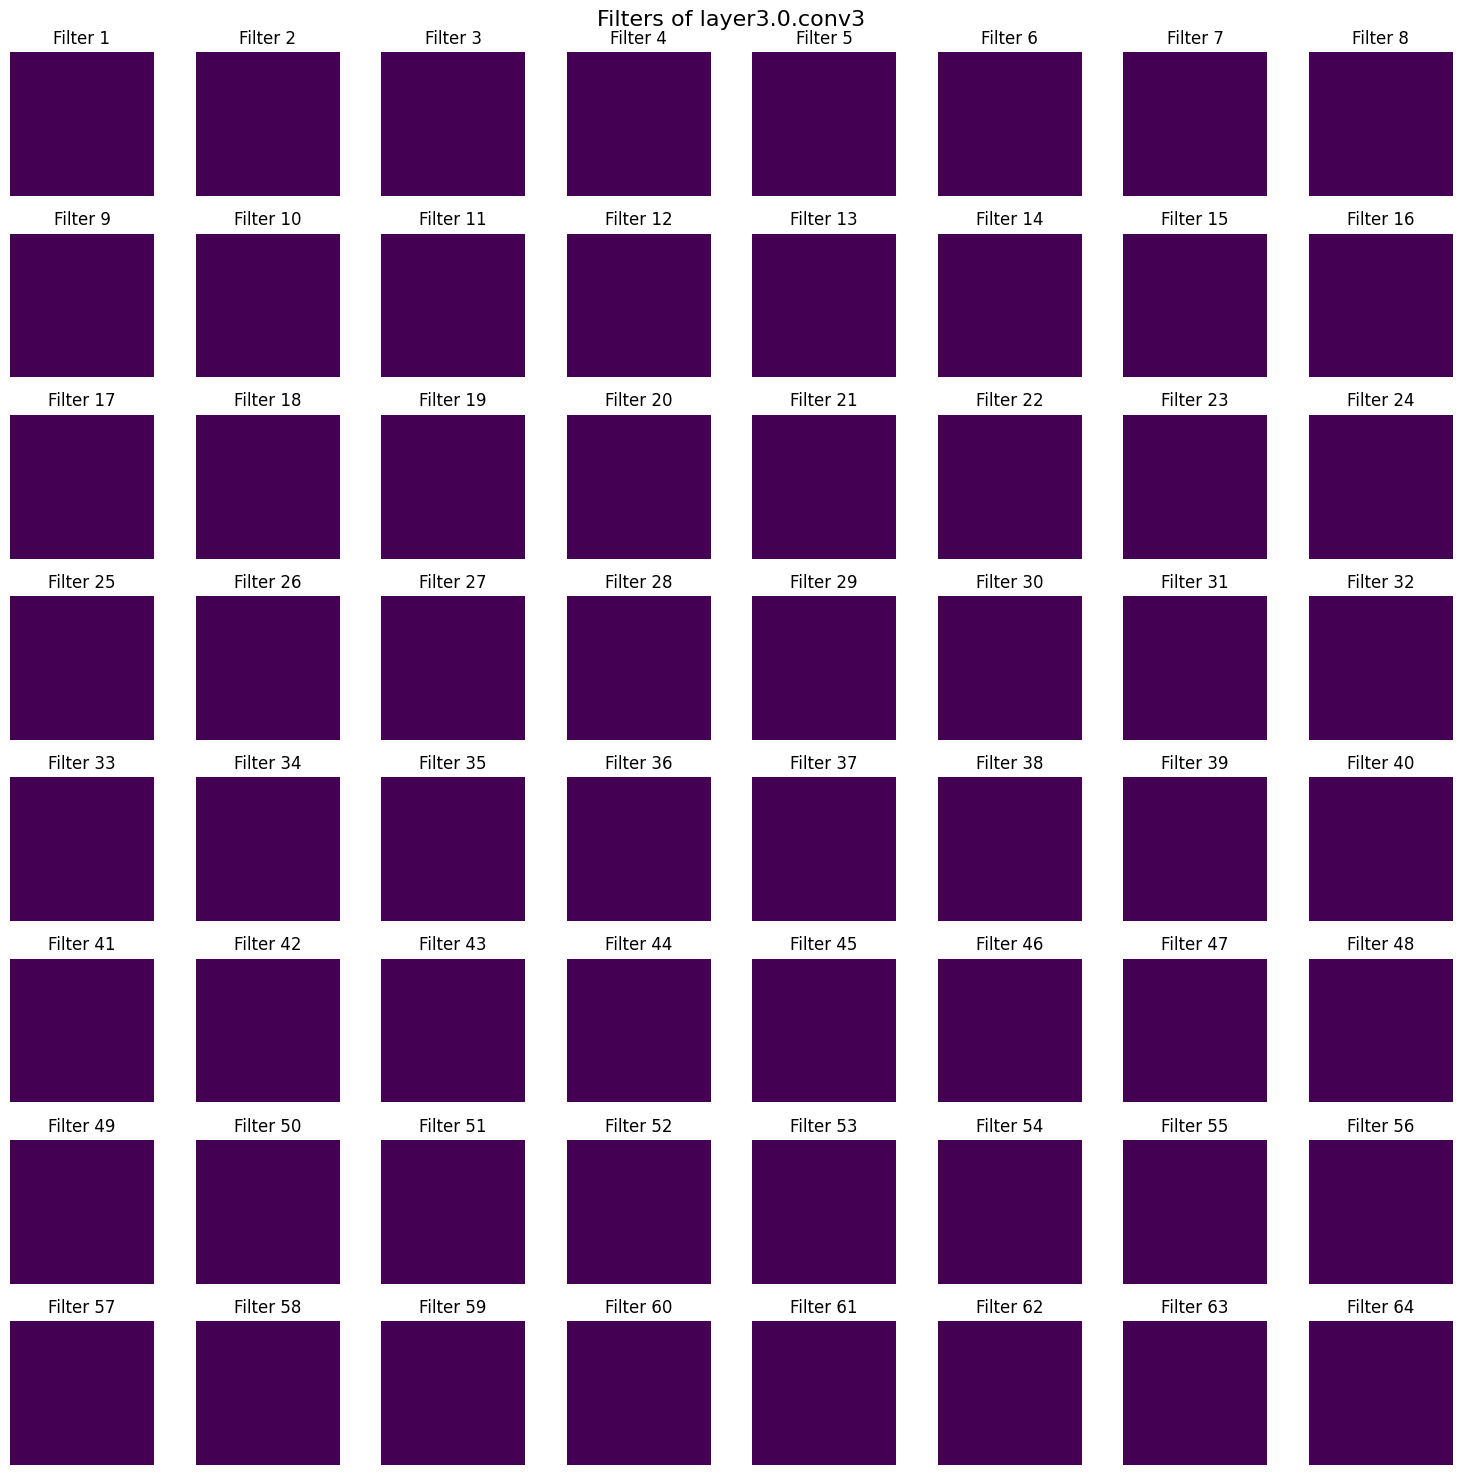

Visualizing filters for layer: layer3.0.downsample.0


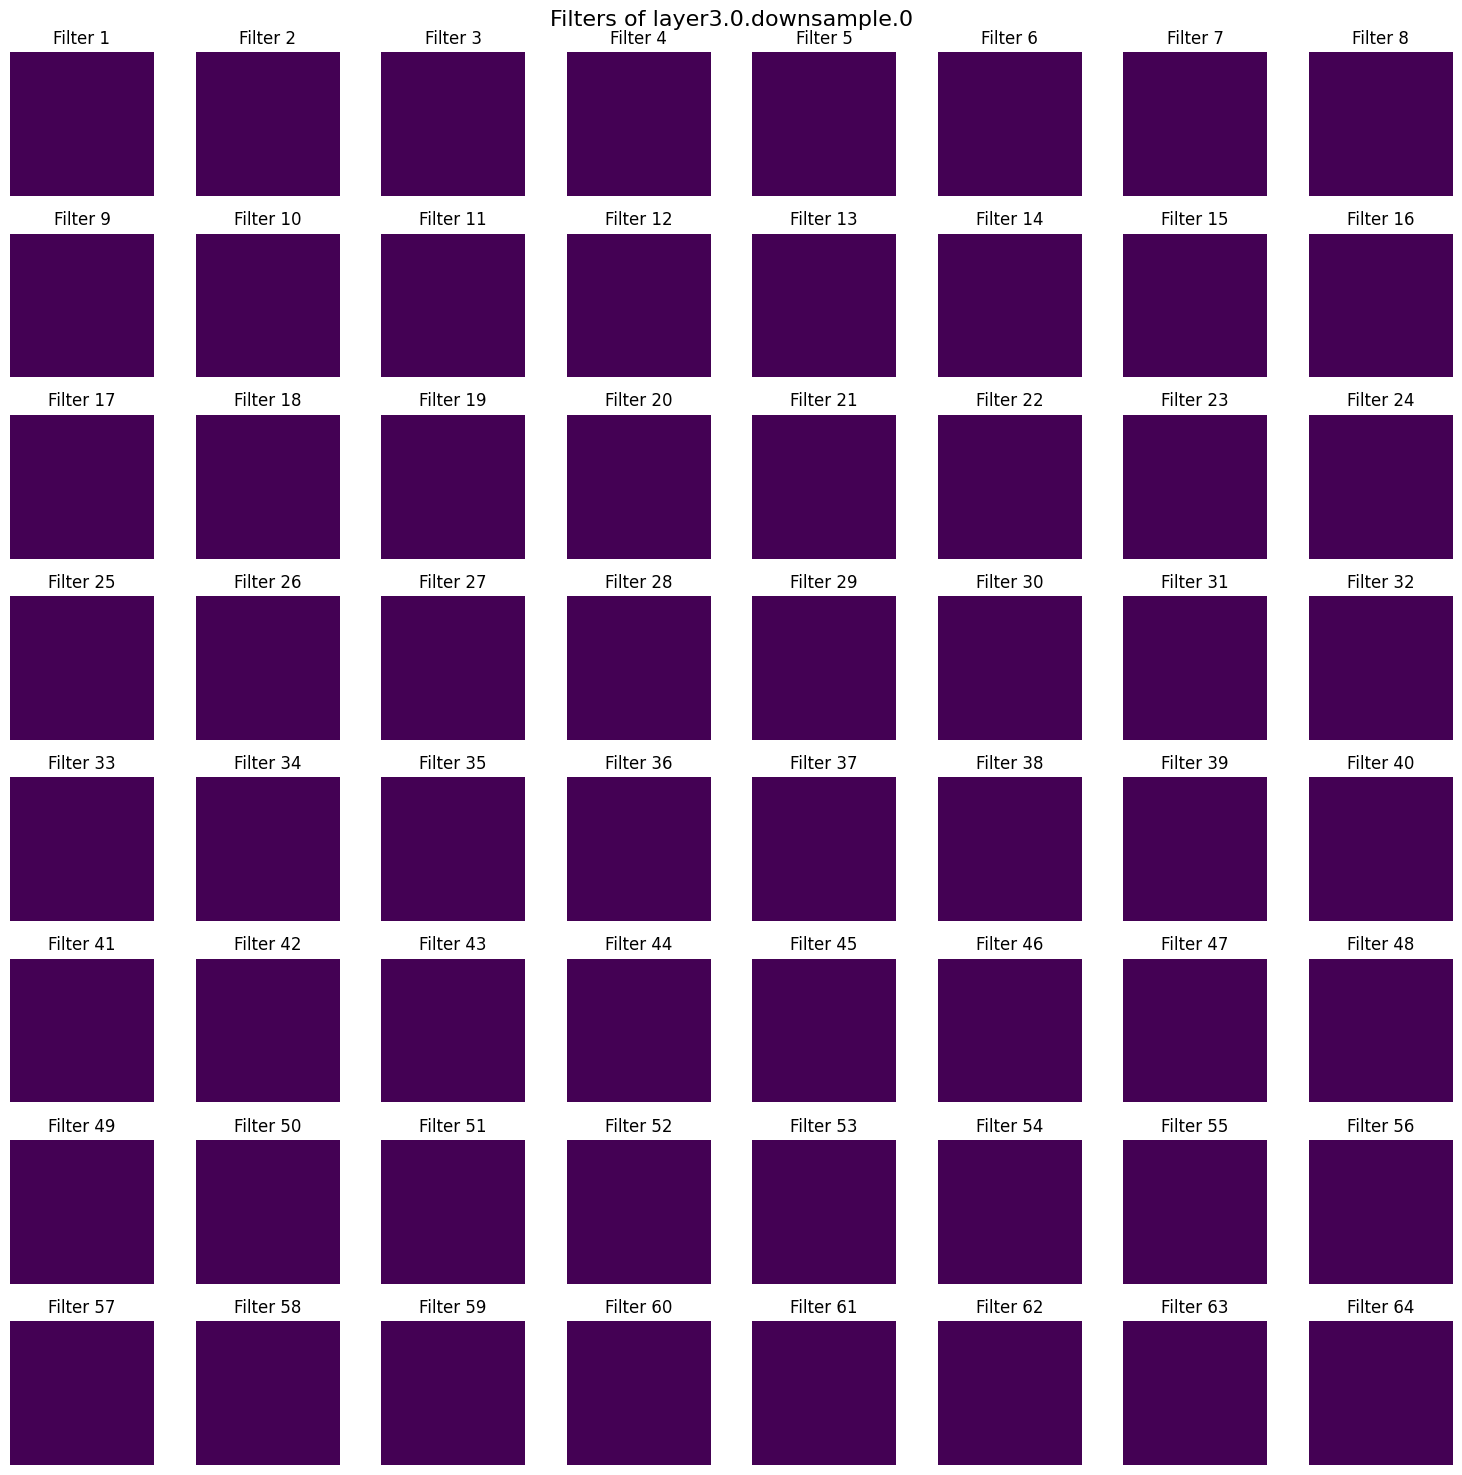

Visualizing filters for layer: layer3.1.conv1


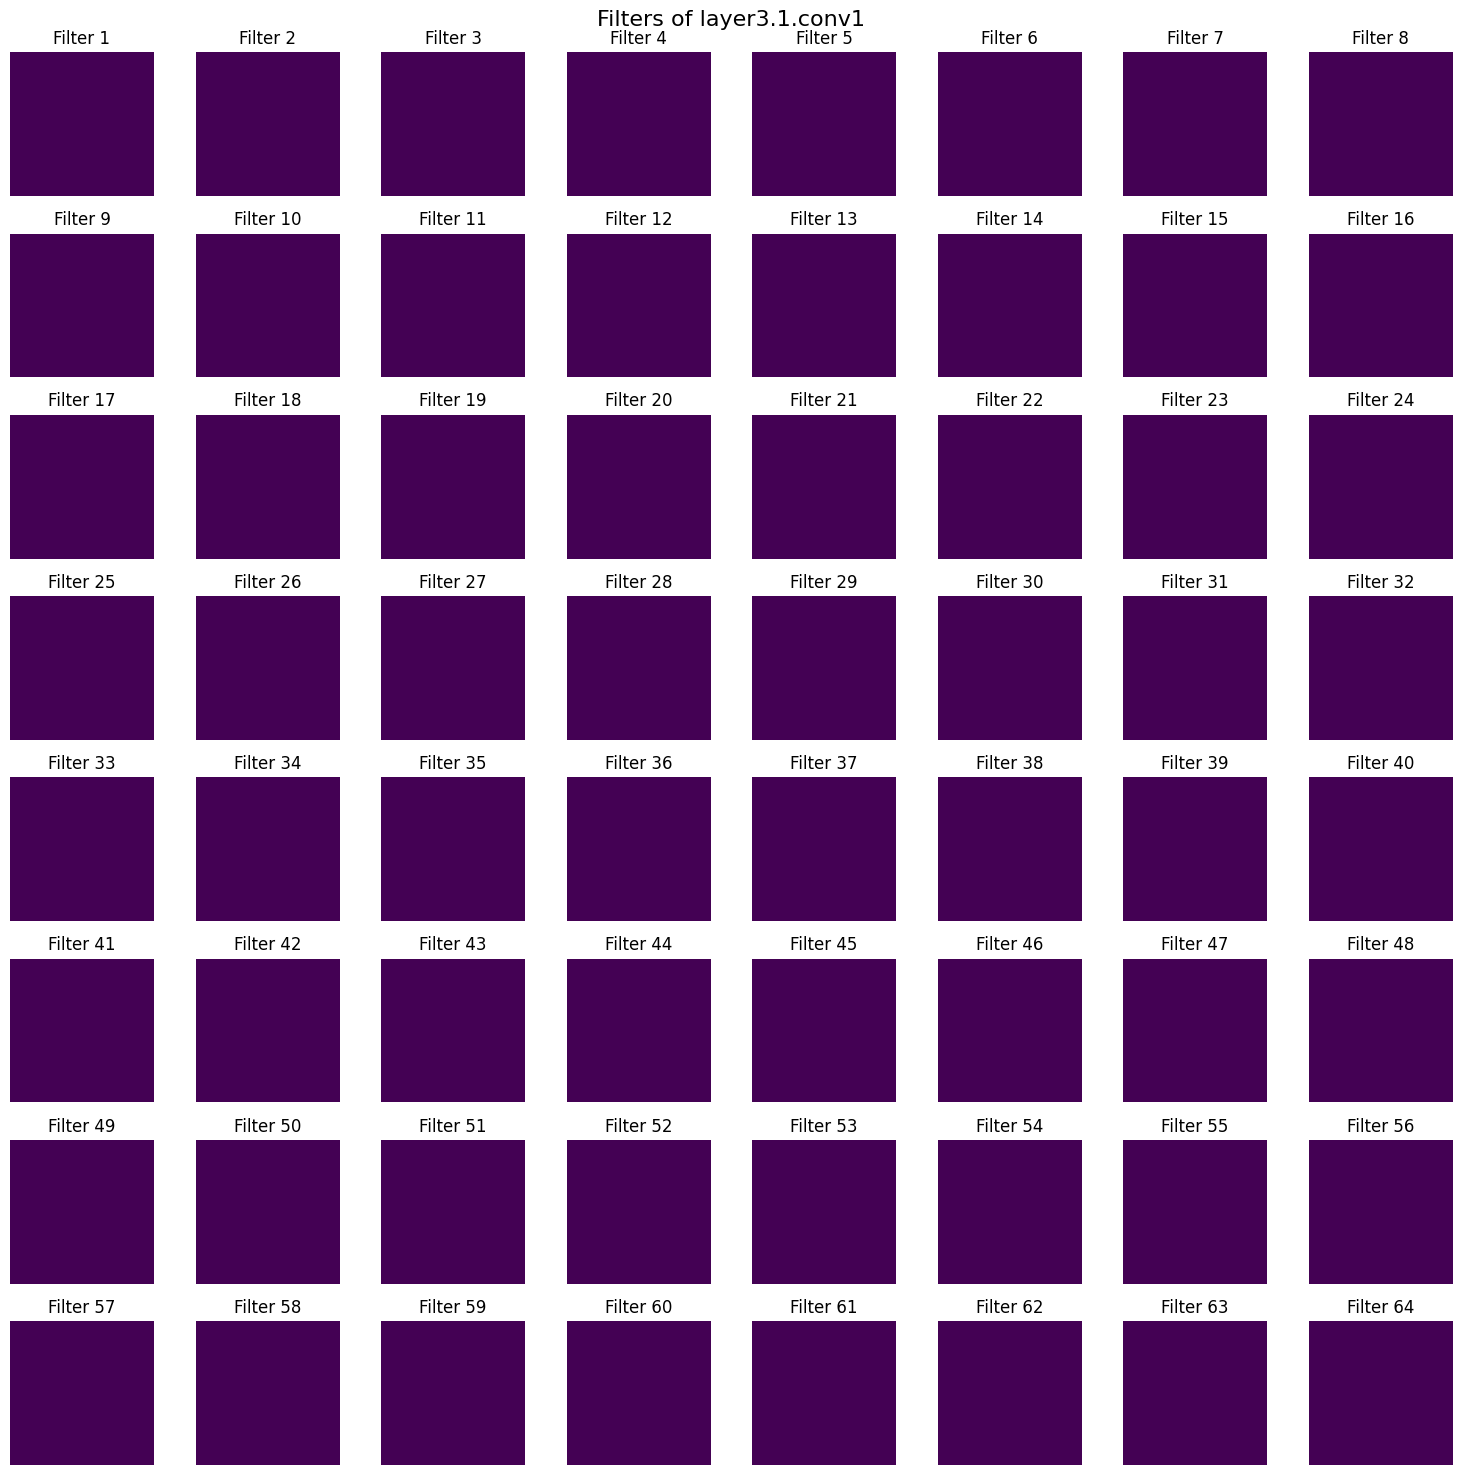

Visualizing filters for layer: layer3.1.conv2


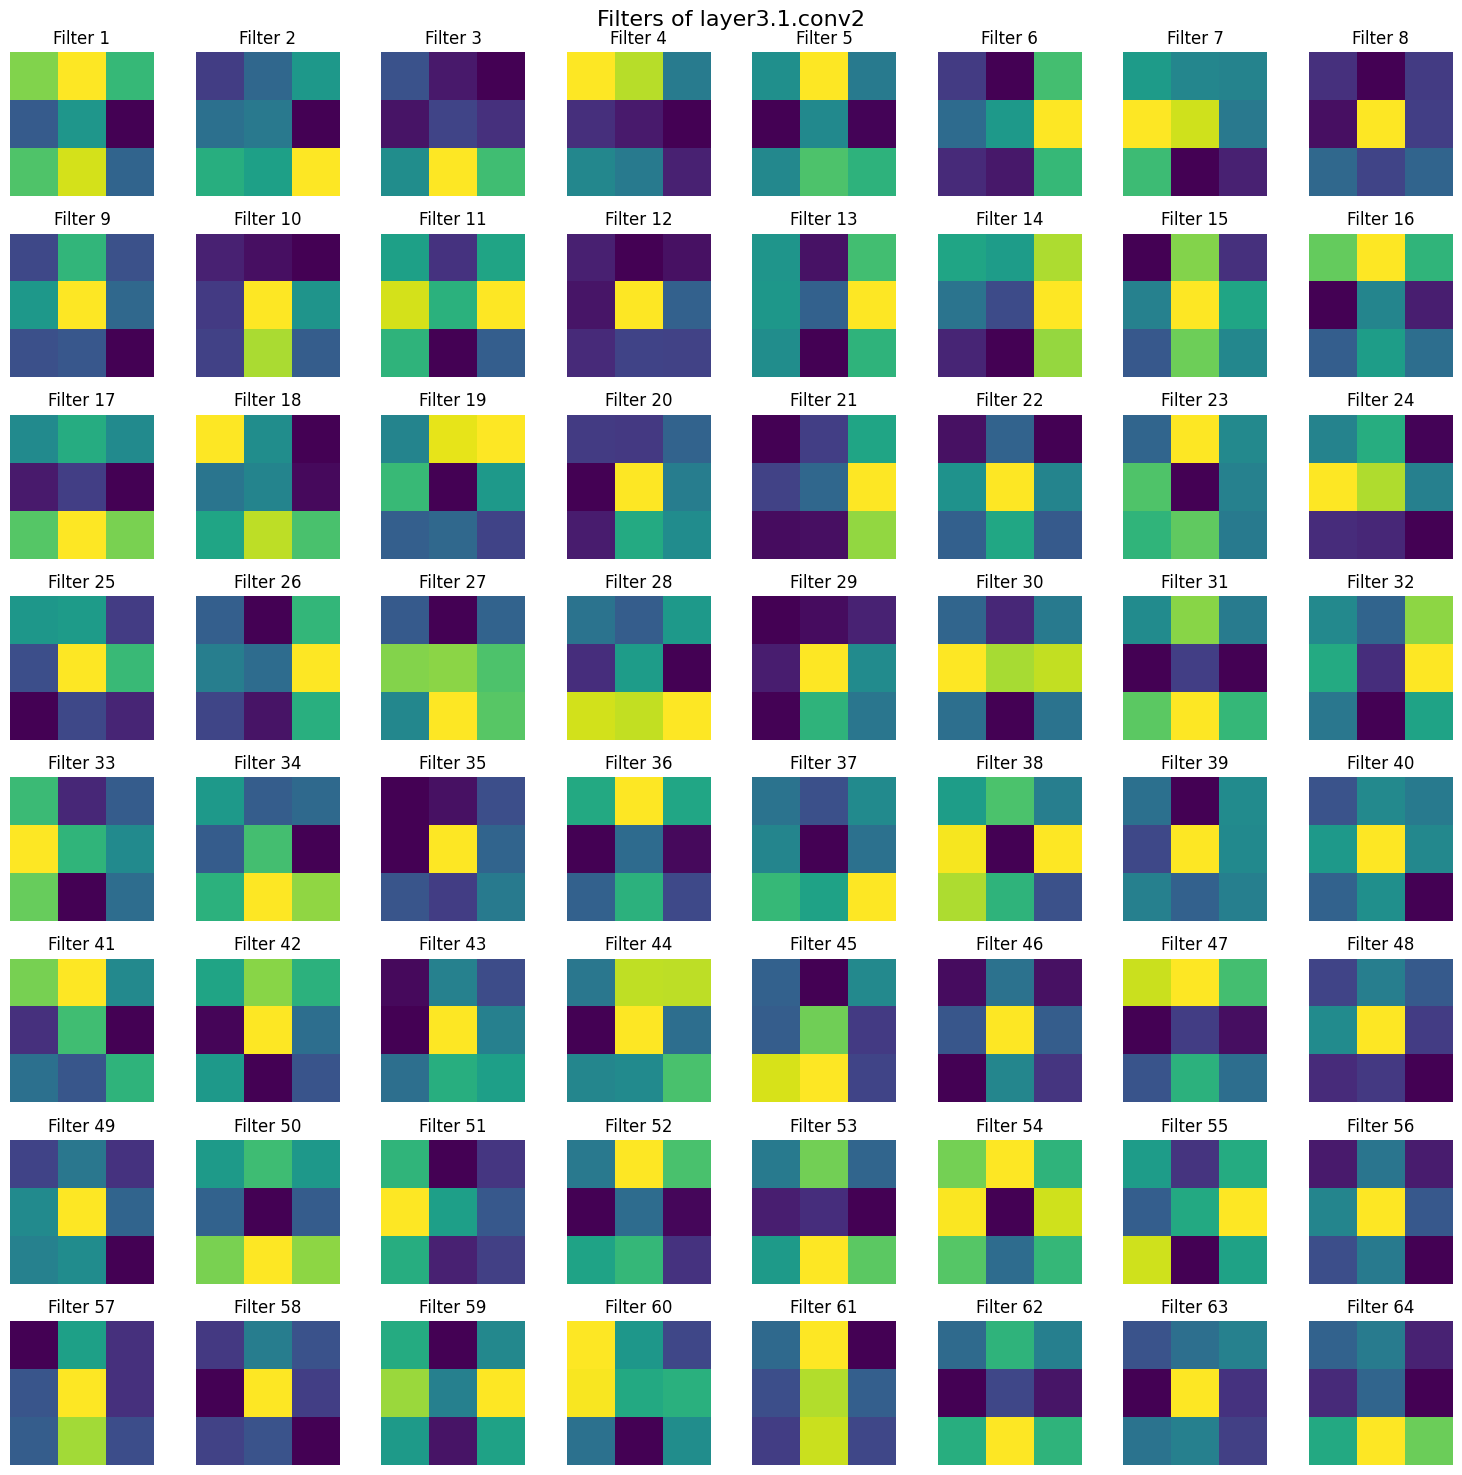

Visualizing filters for layer: layer3.1.conv3


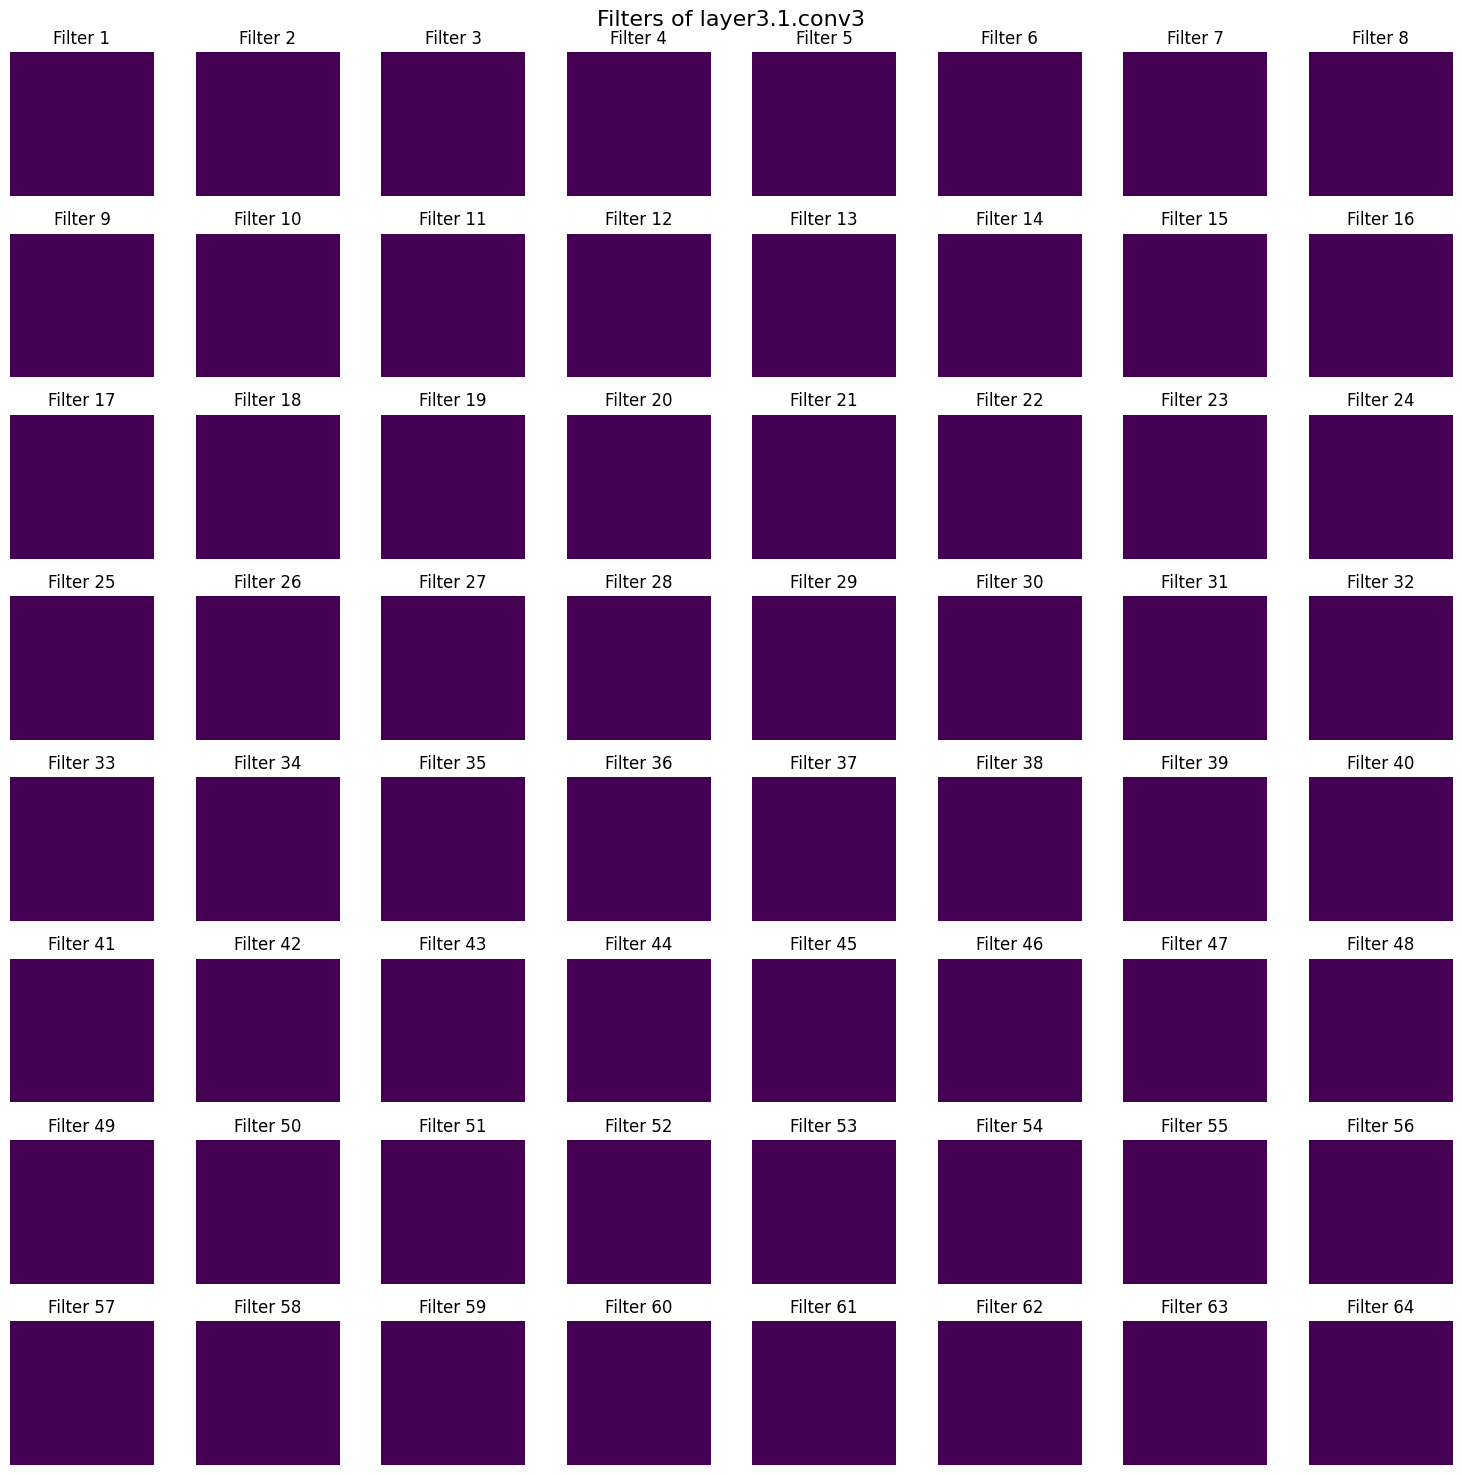

Visualizing filters for layer: layer3.2.conv1


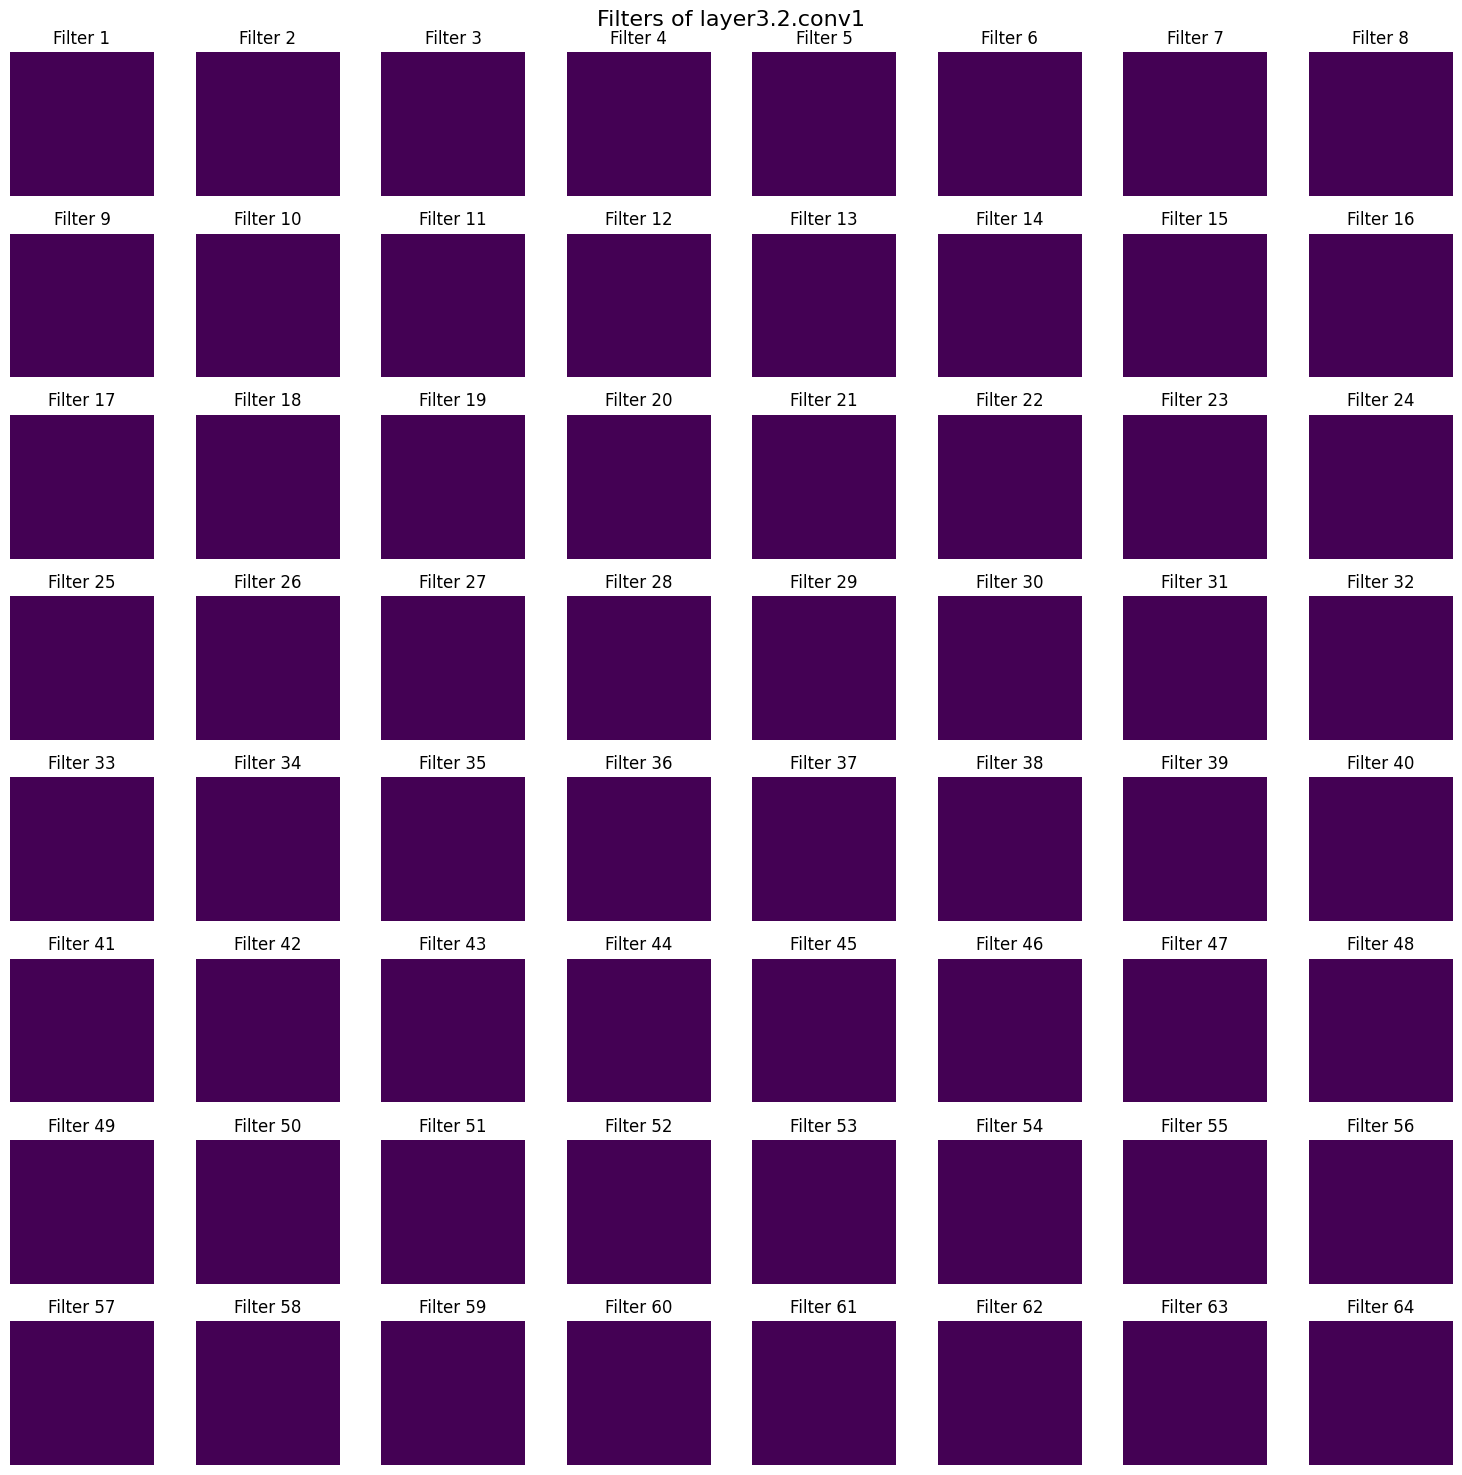

Visualizing filters for layer: layer3.2.conv2


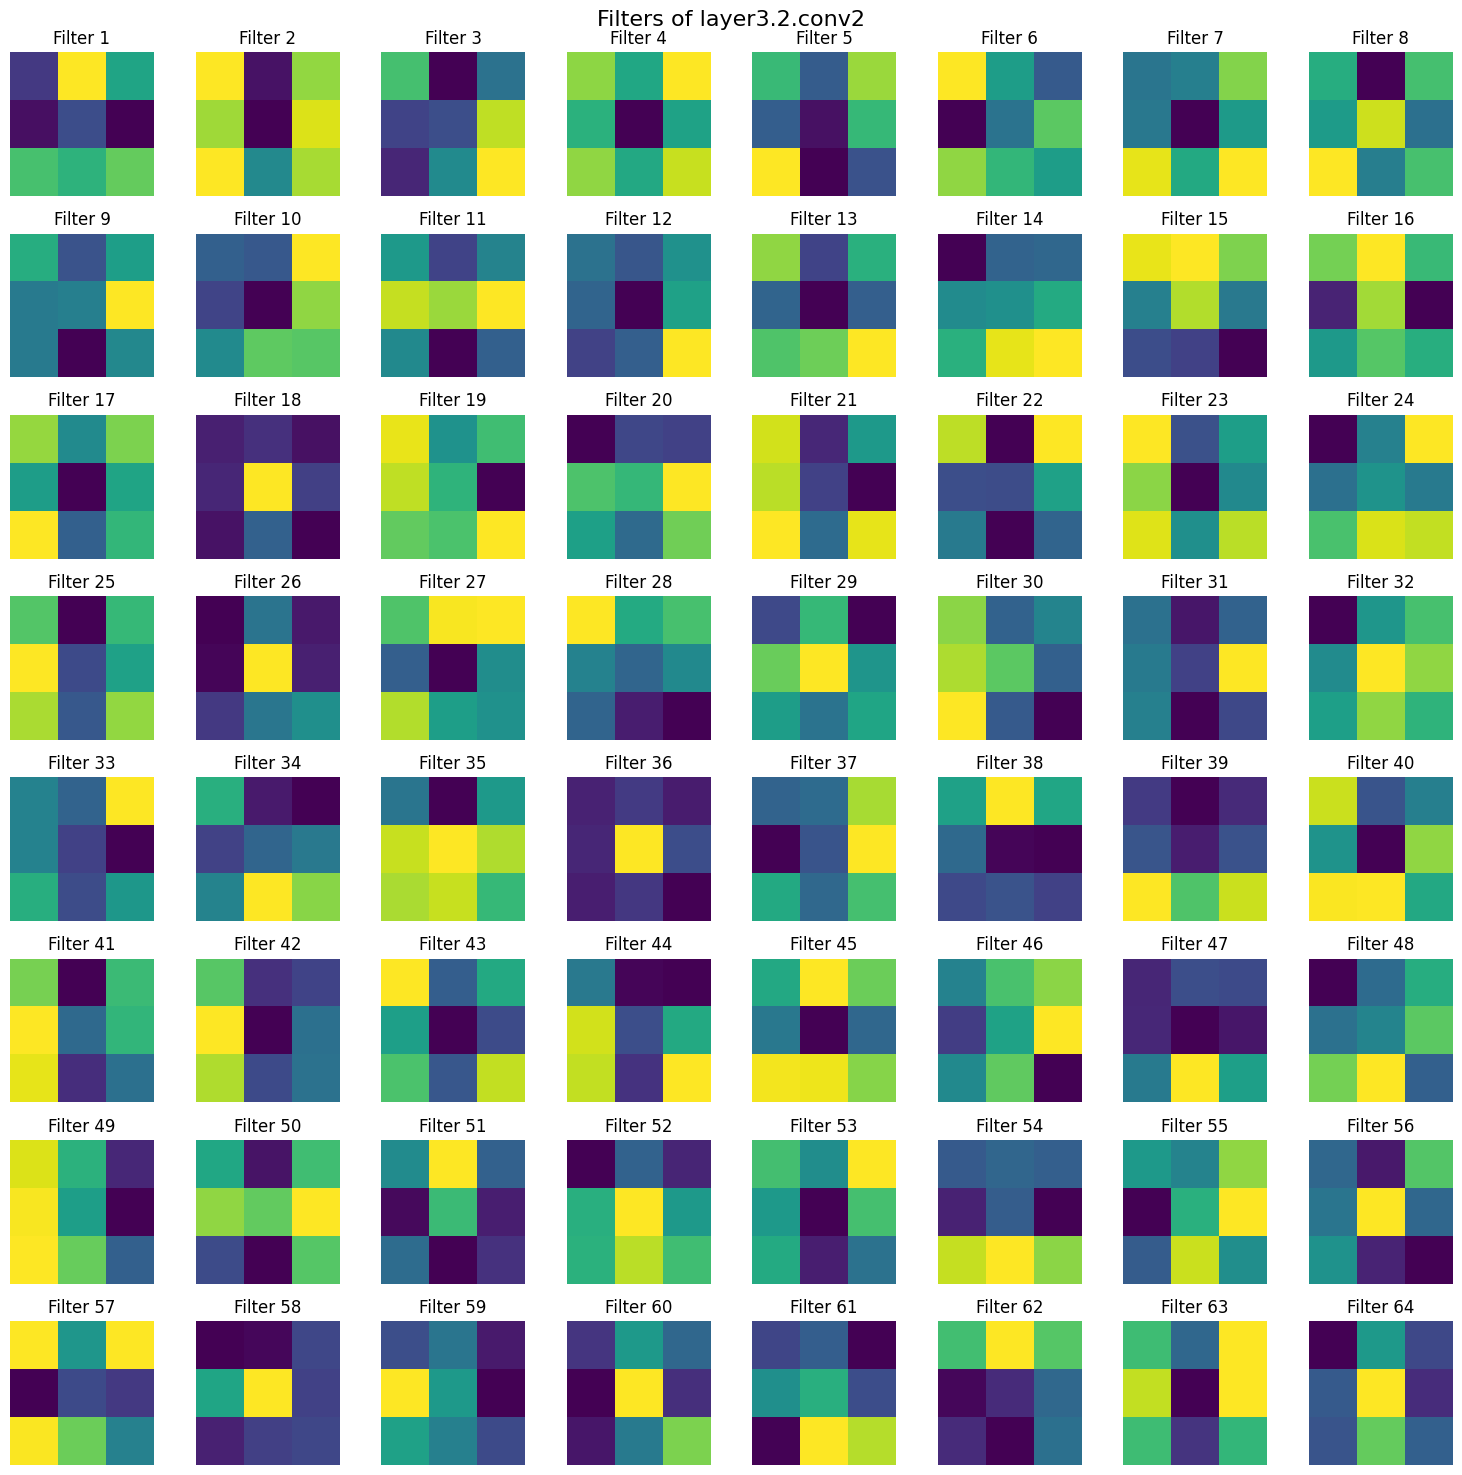

Visualizing filters for layer: layer3.2.conv3


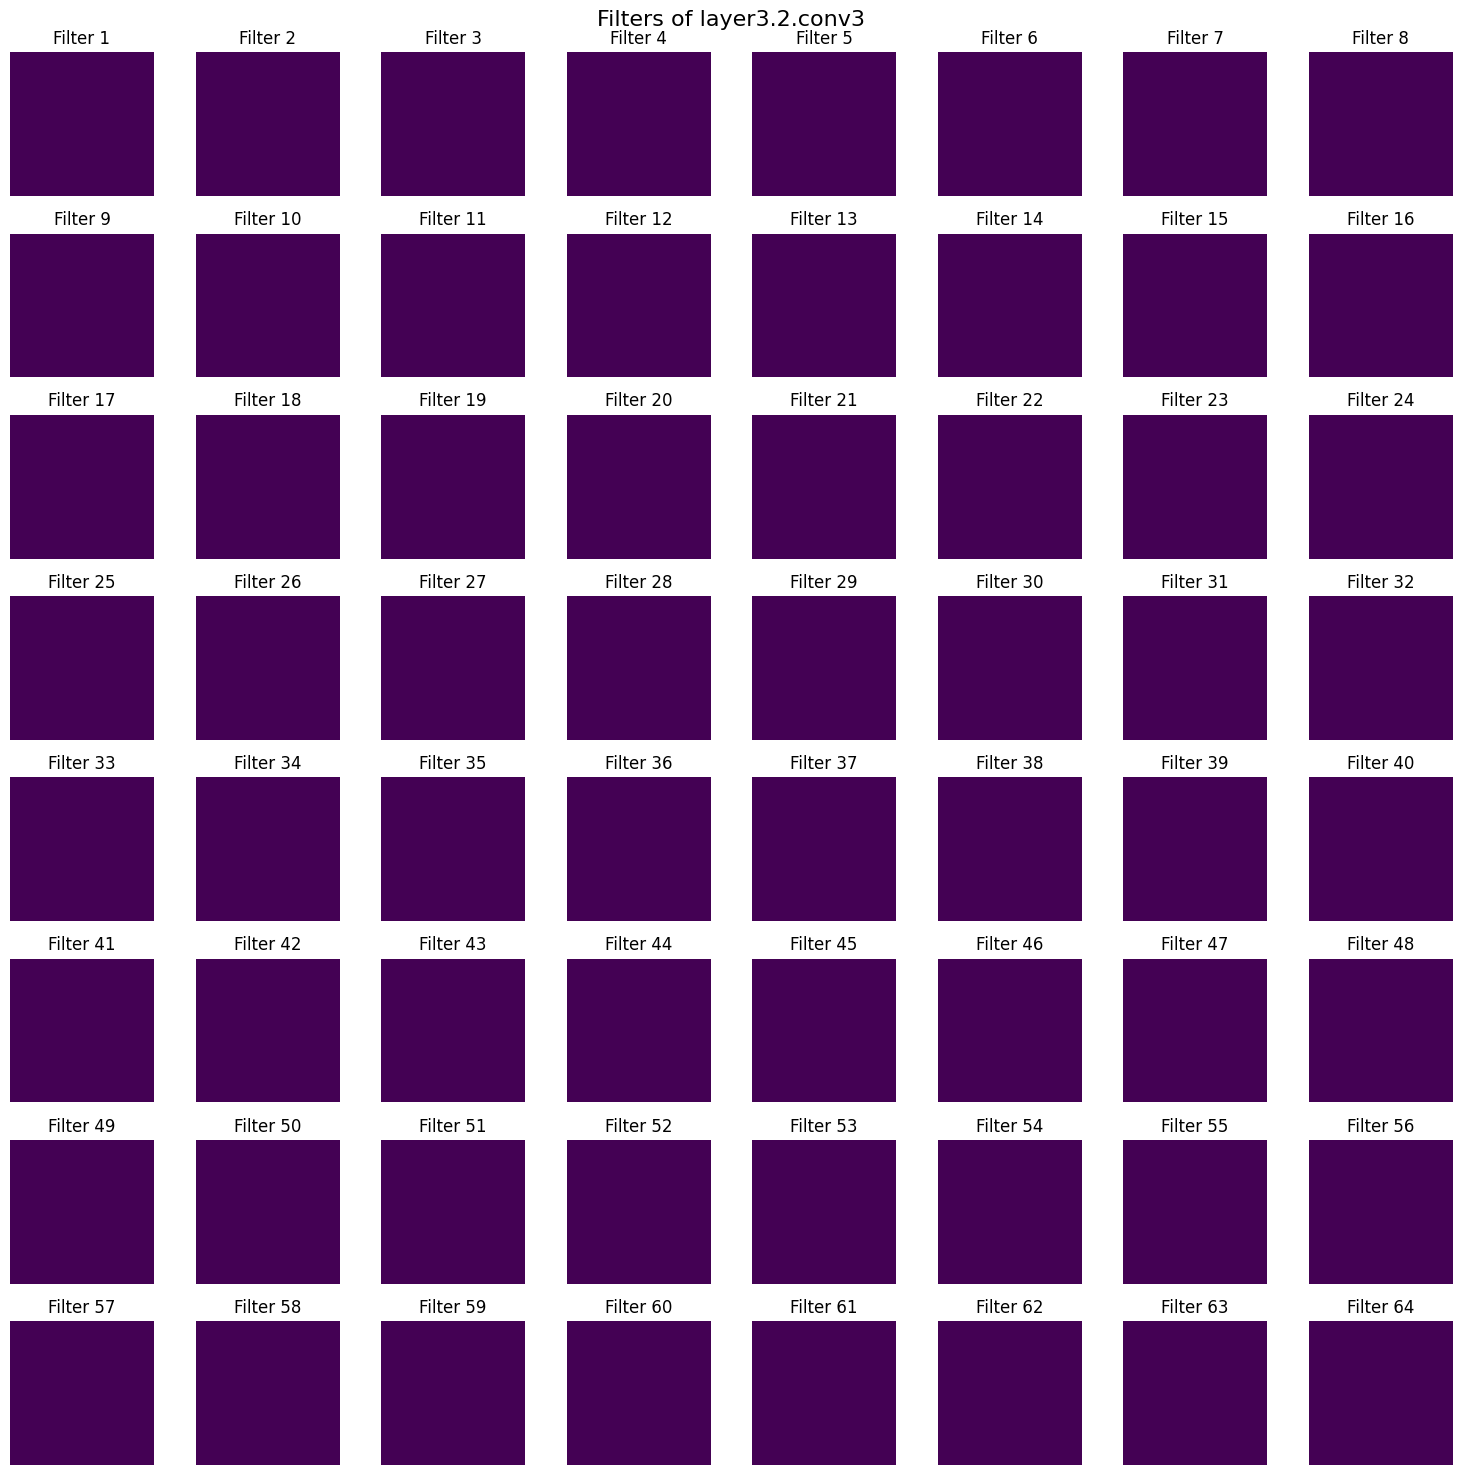

Visualizing filters for layer: layer3.3.conv1


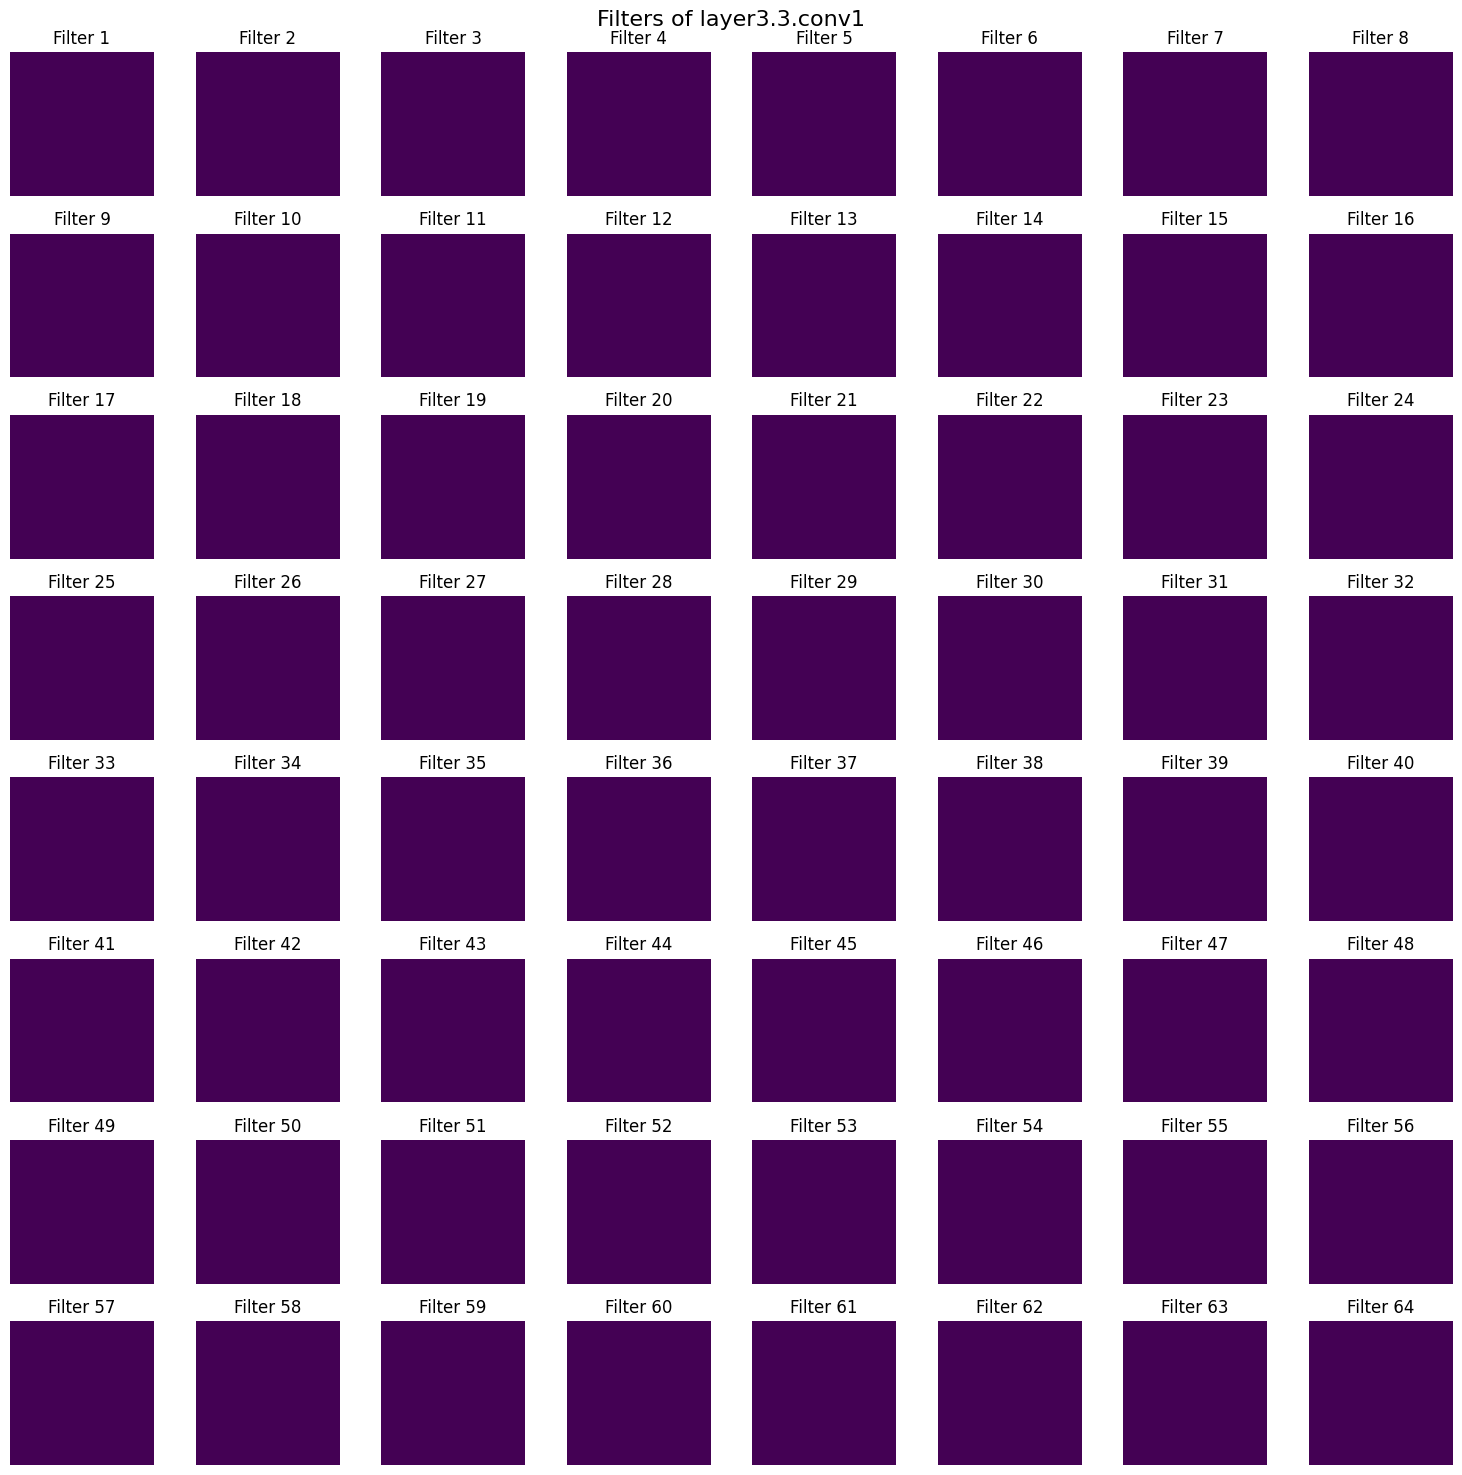

Visualizing filters for layer: layer3.3.conv2


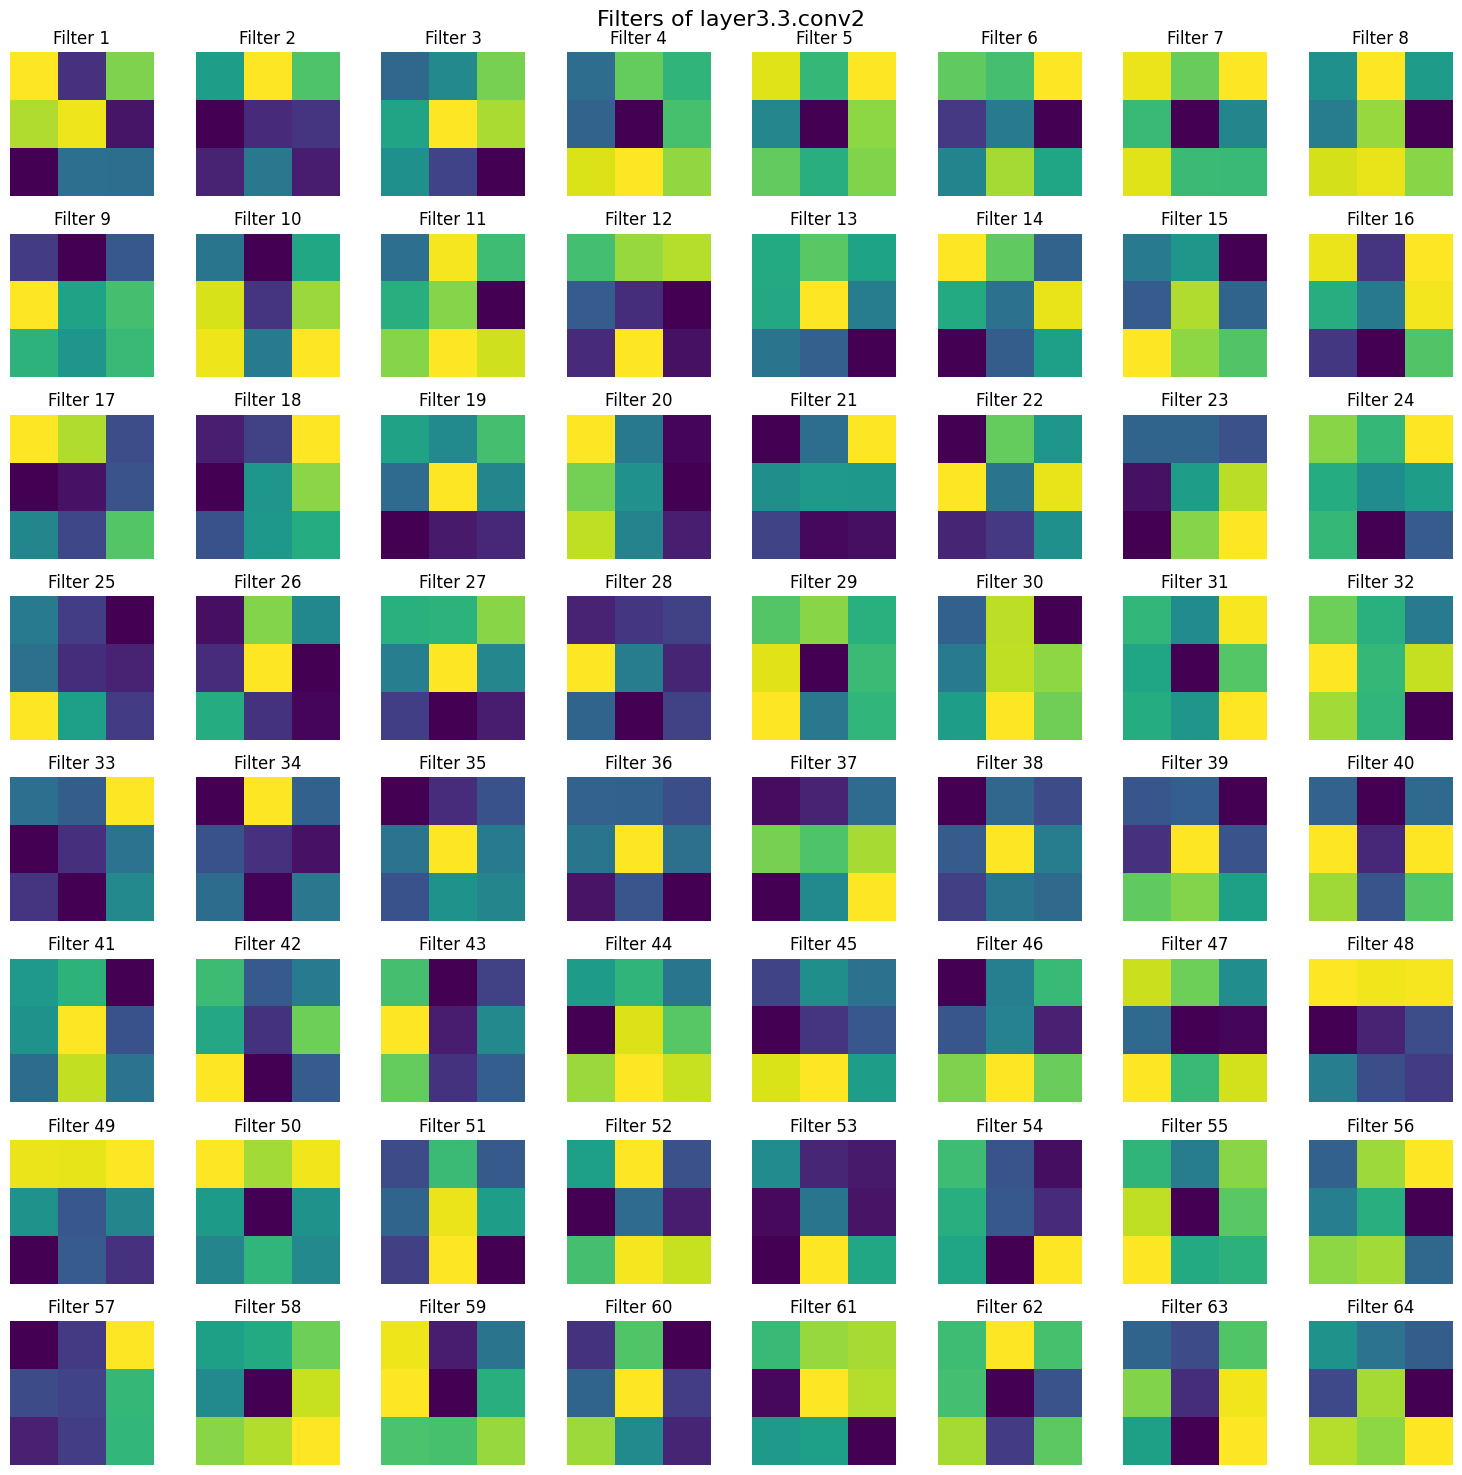

Visualizing filters for layer: layer3.3.conv3


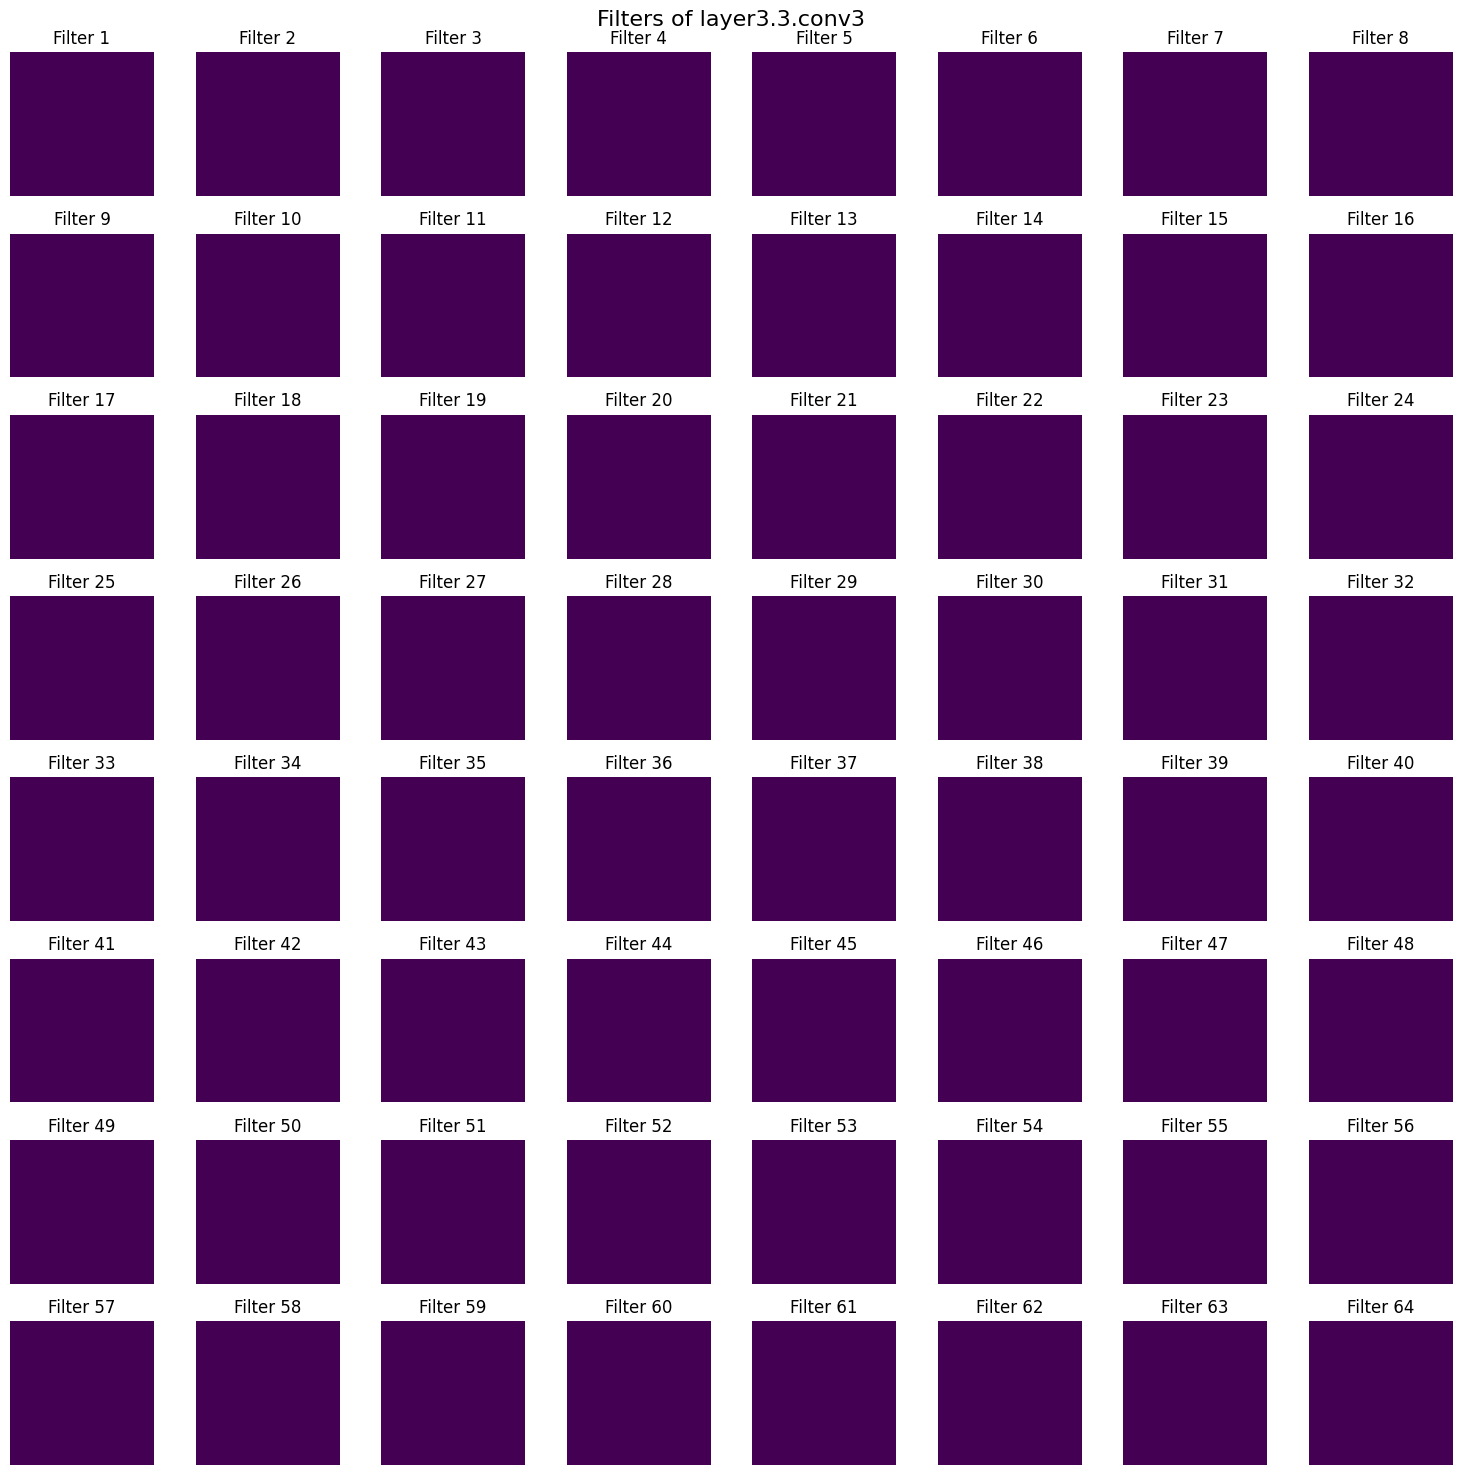

Visualizing filters for layer: layer3.4.conv1


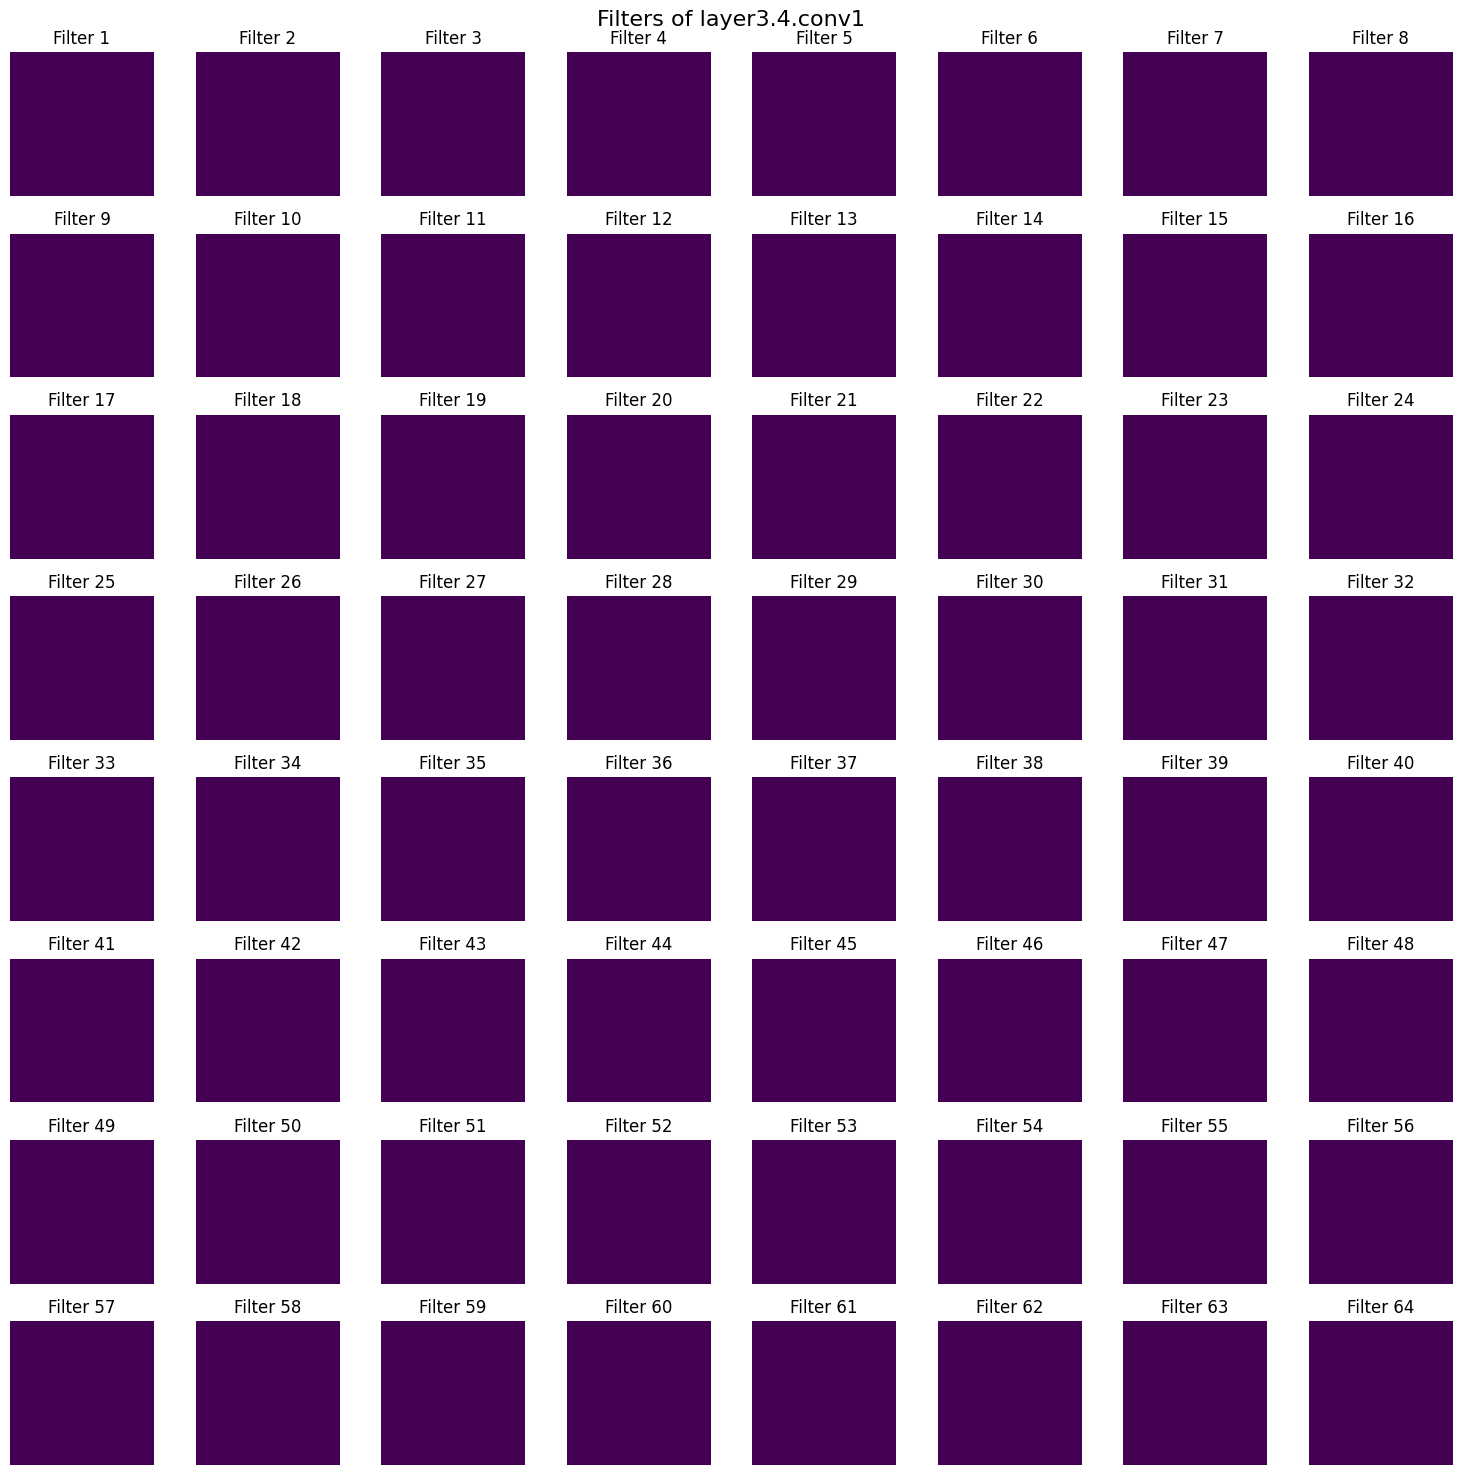

Visualizing filters for layer: layer3.4.conv2


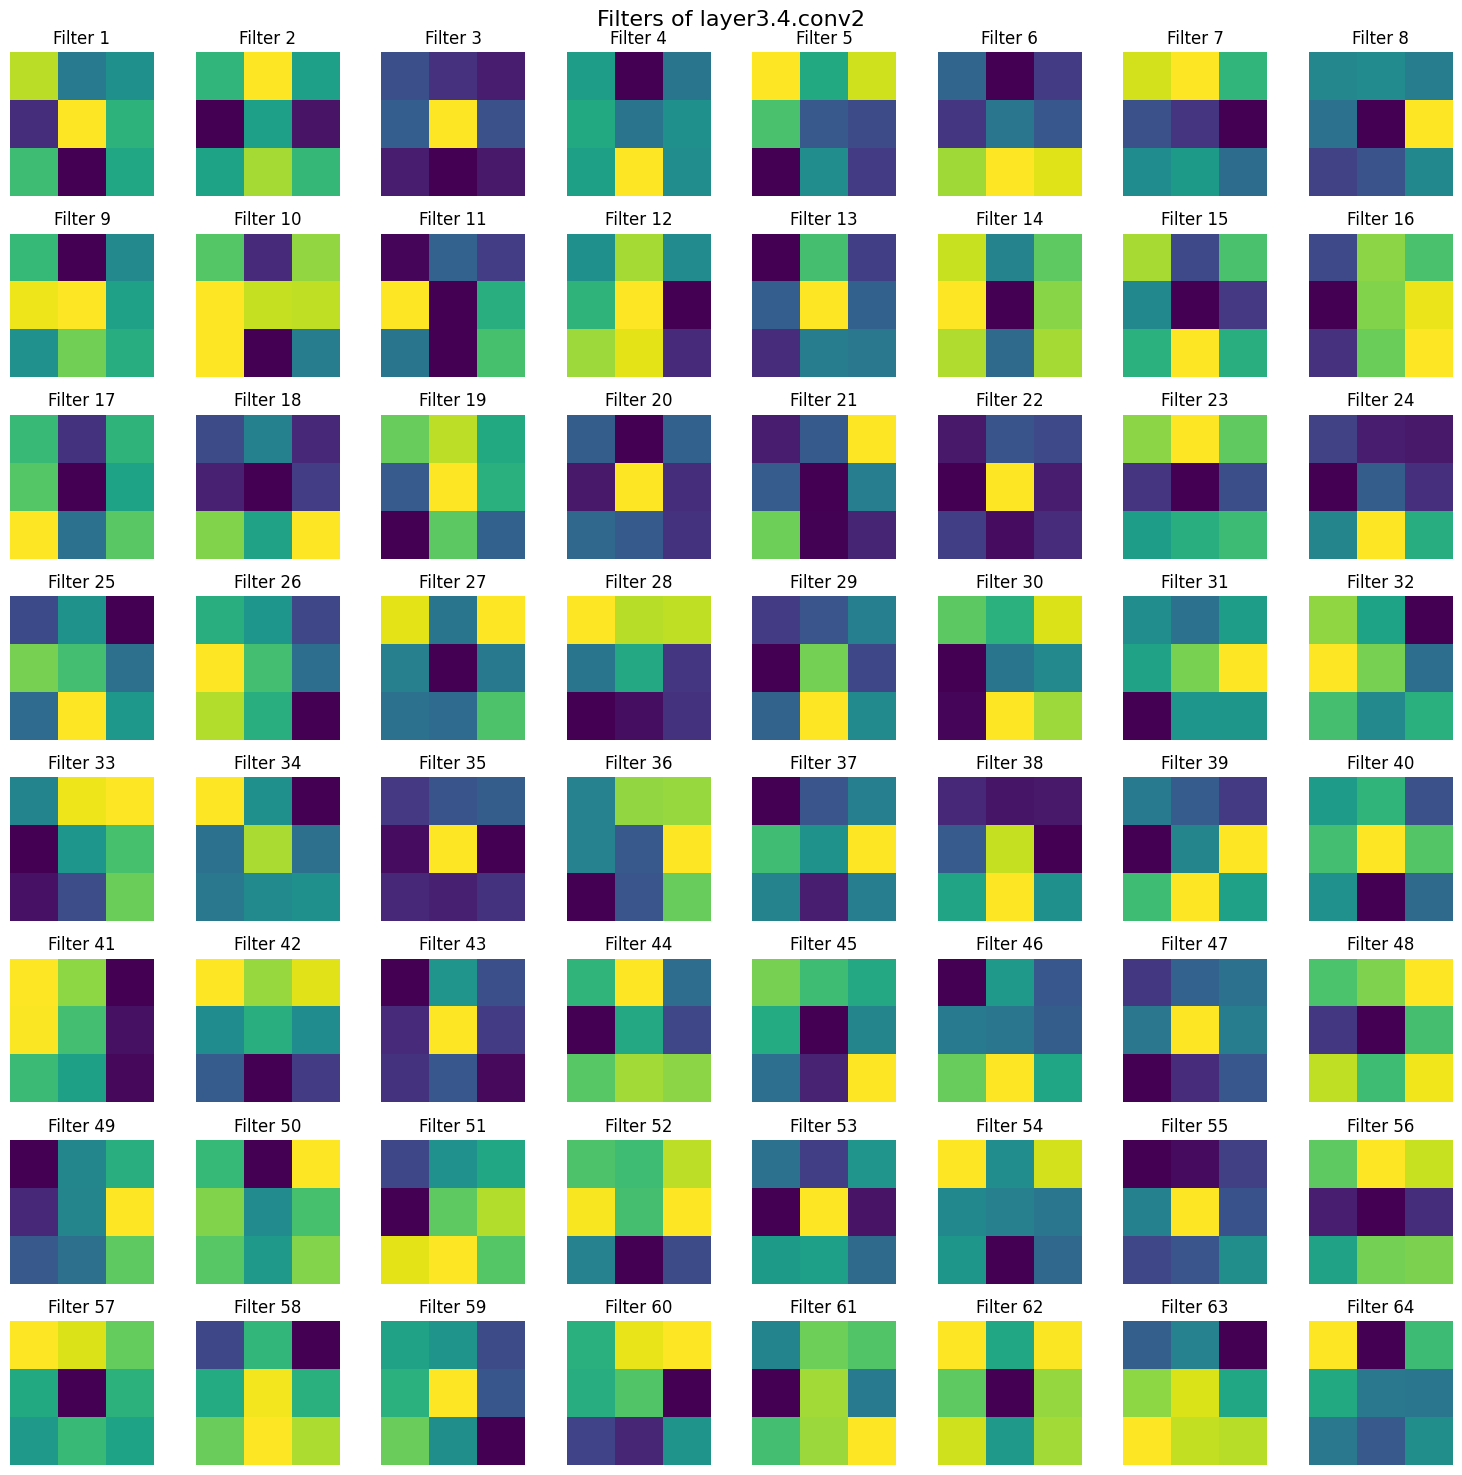

Visualizing filters for layer: layer3.4.conv3


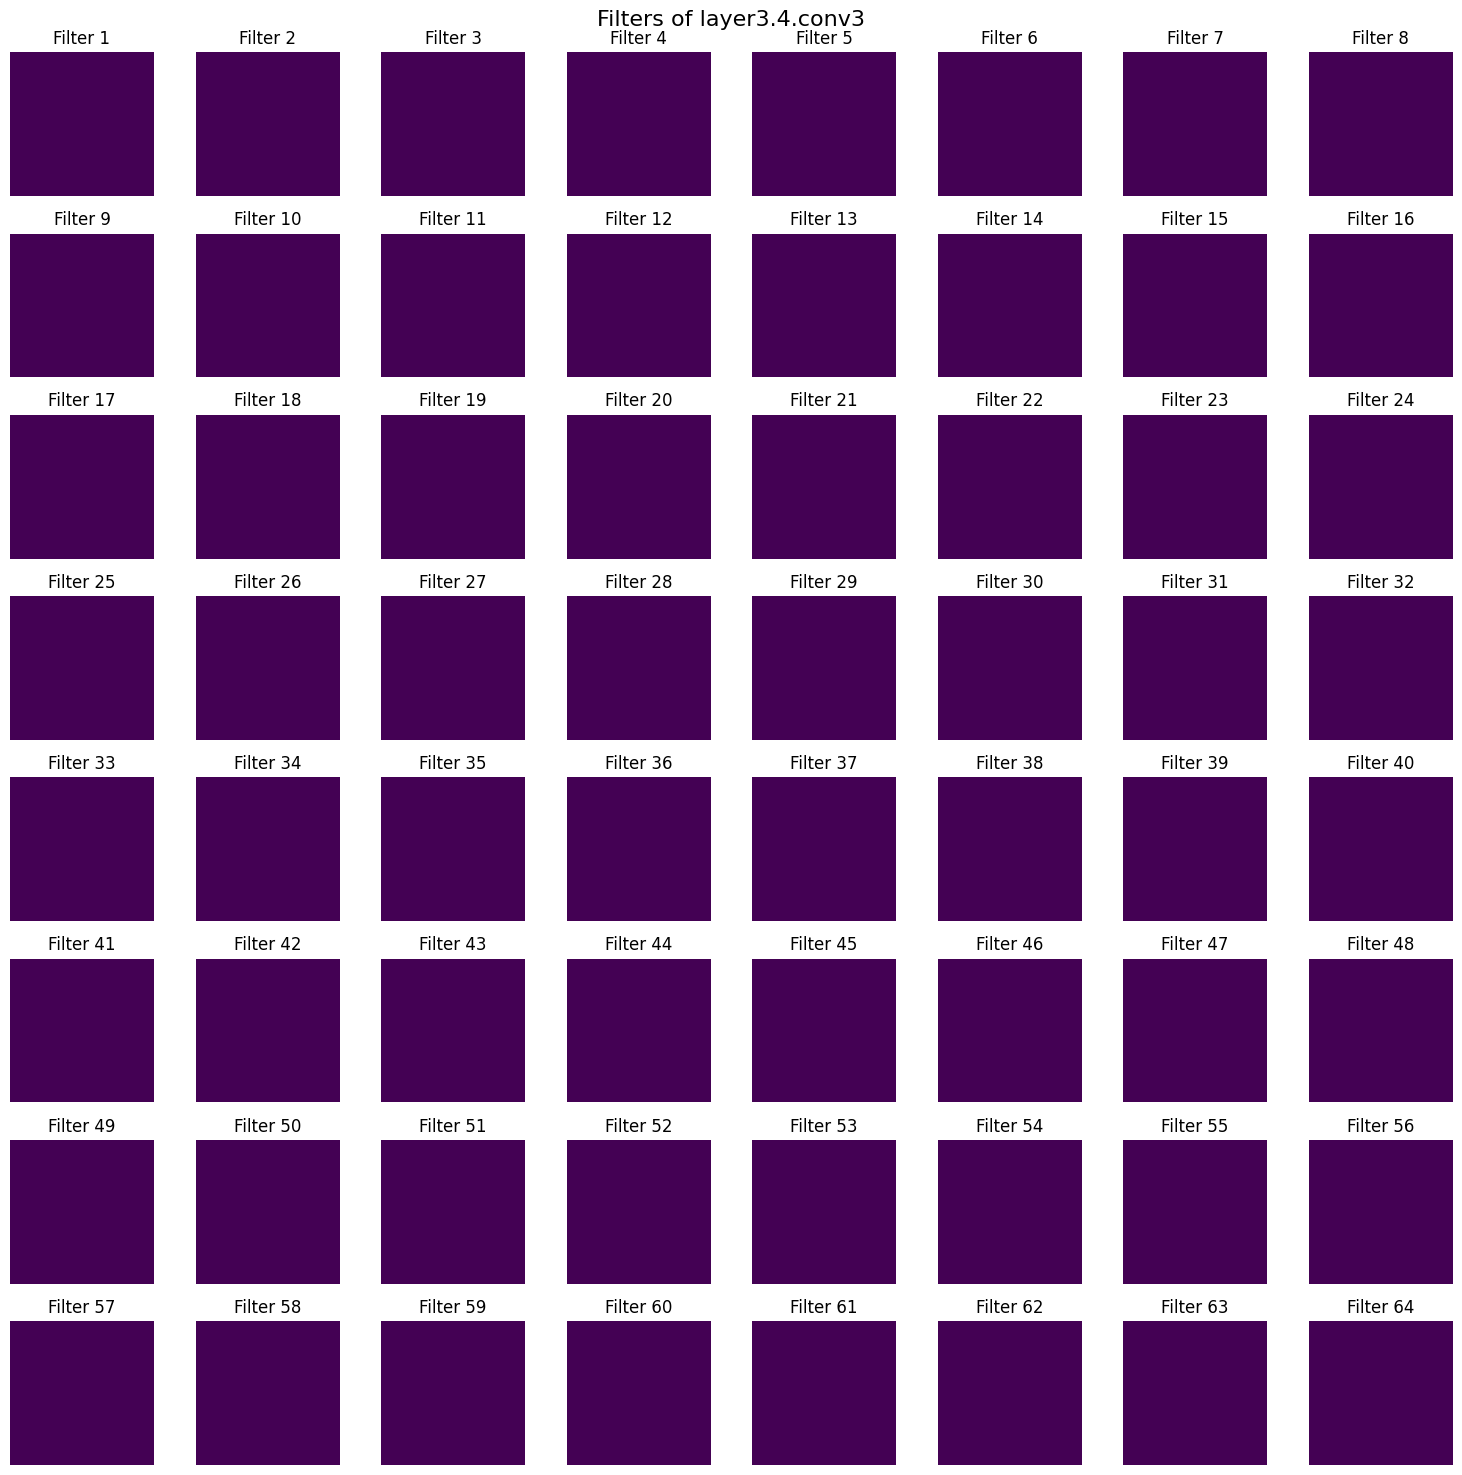

Visualizing filters for layer: layer3.5.conv1


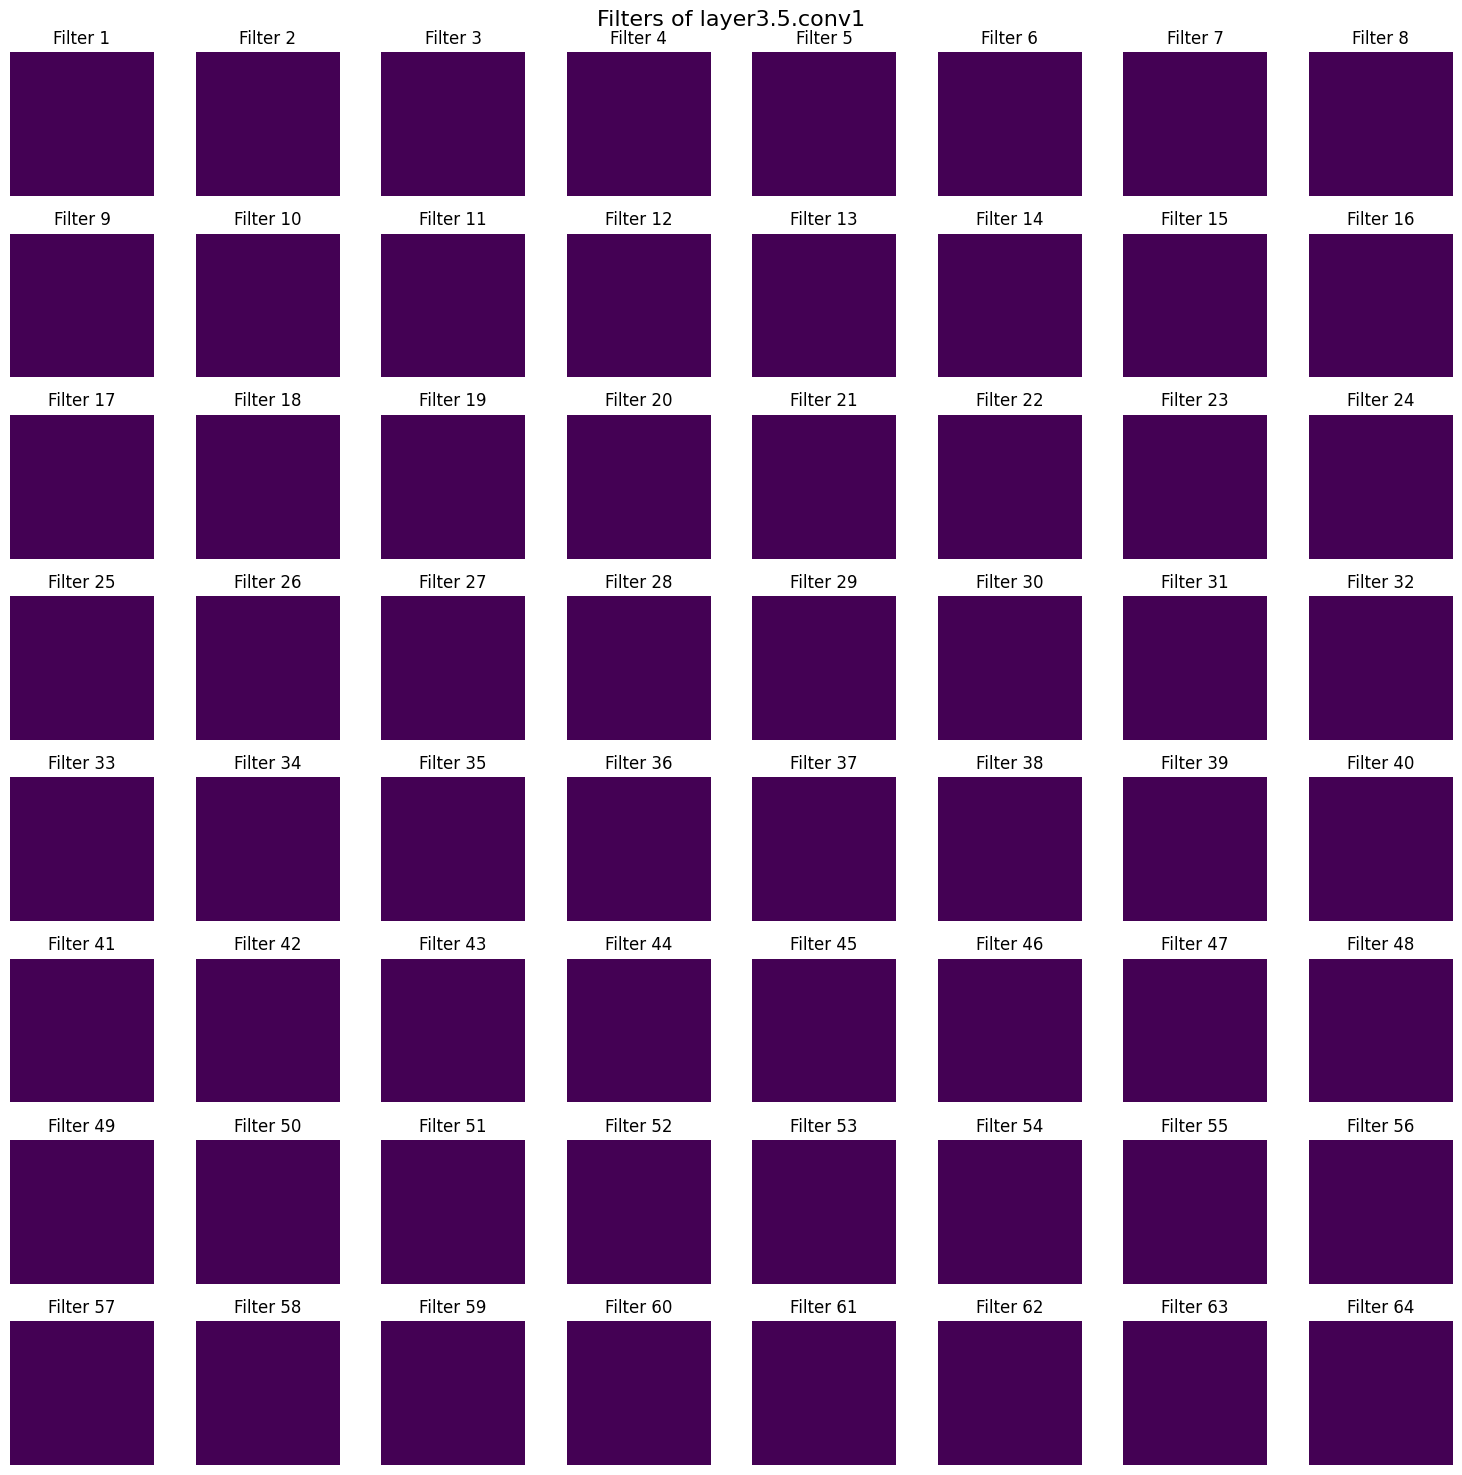

Visualizing filters for layer: layer3.5.conv2


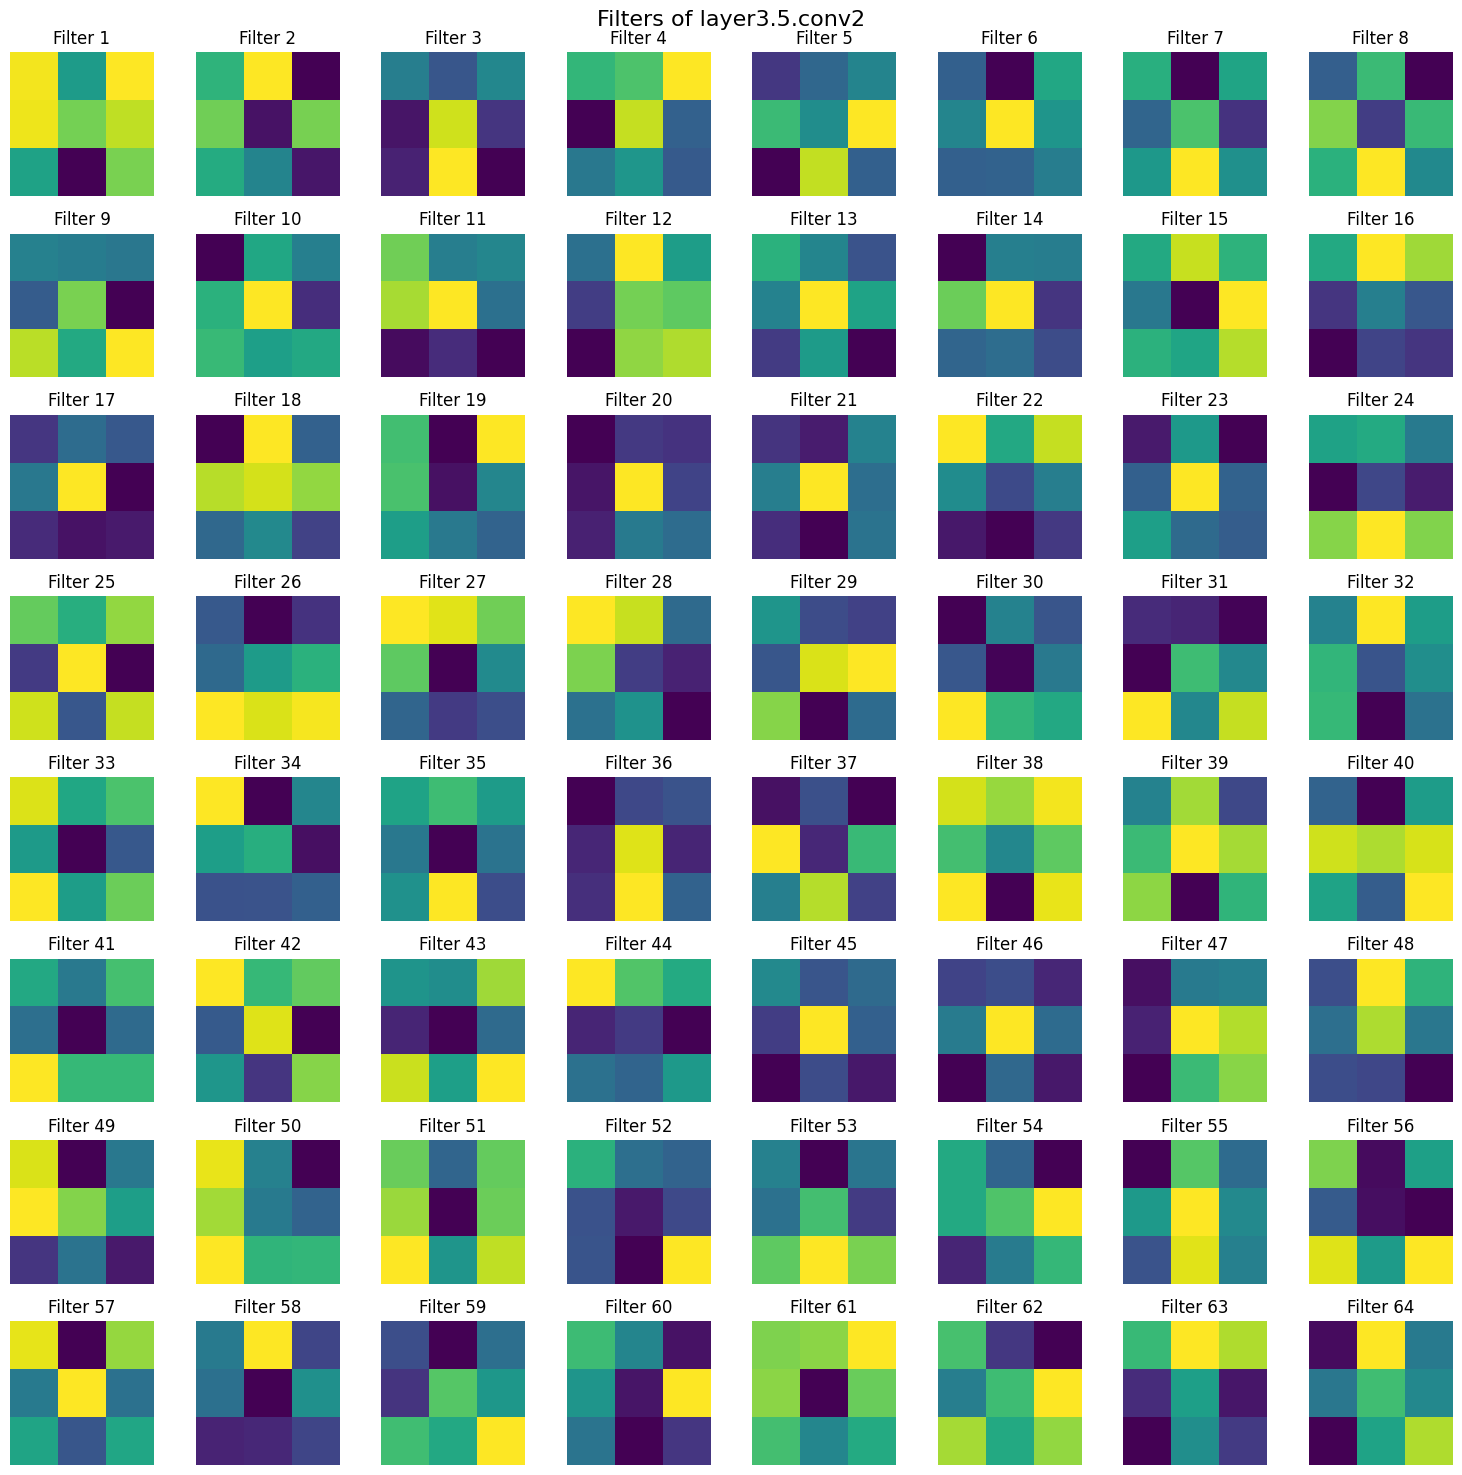

Visualizing filters for layer: layer3.5.conv3


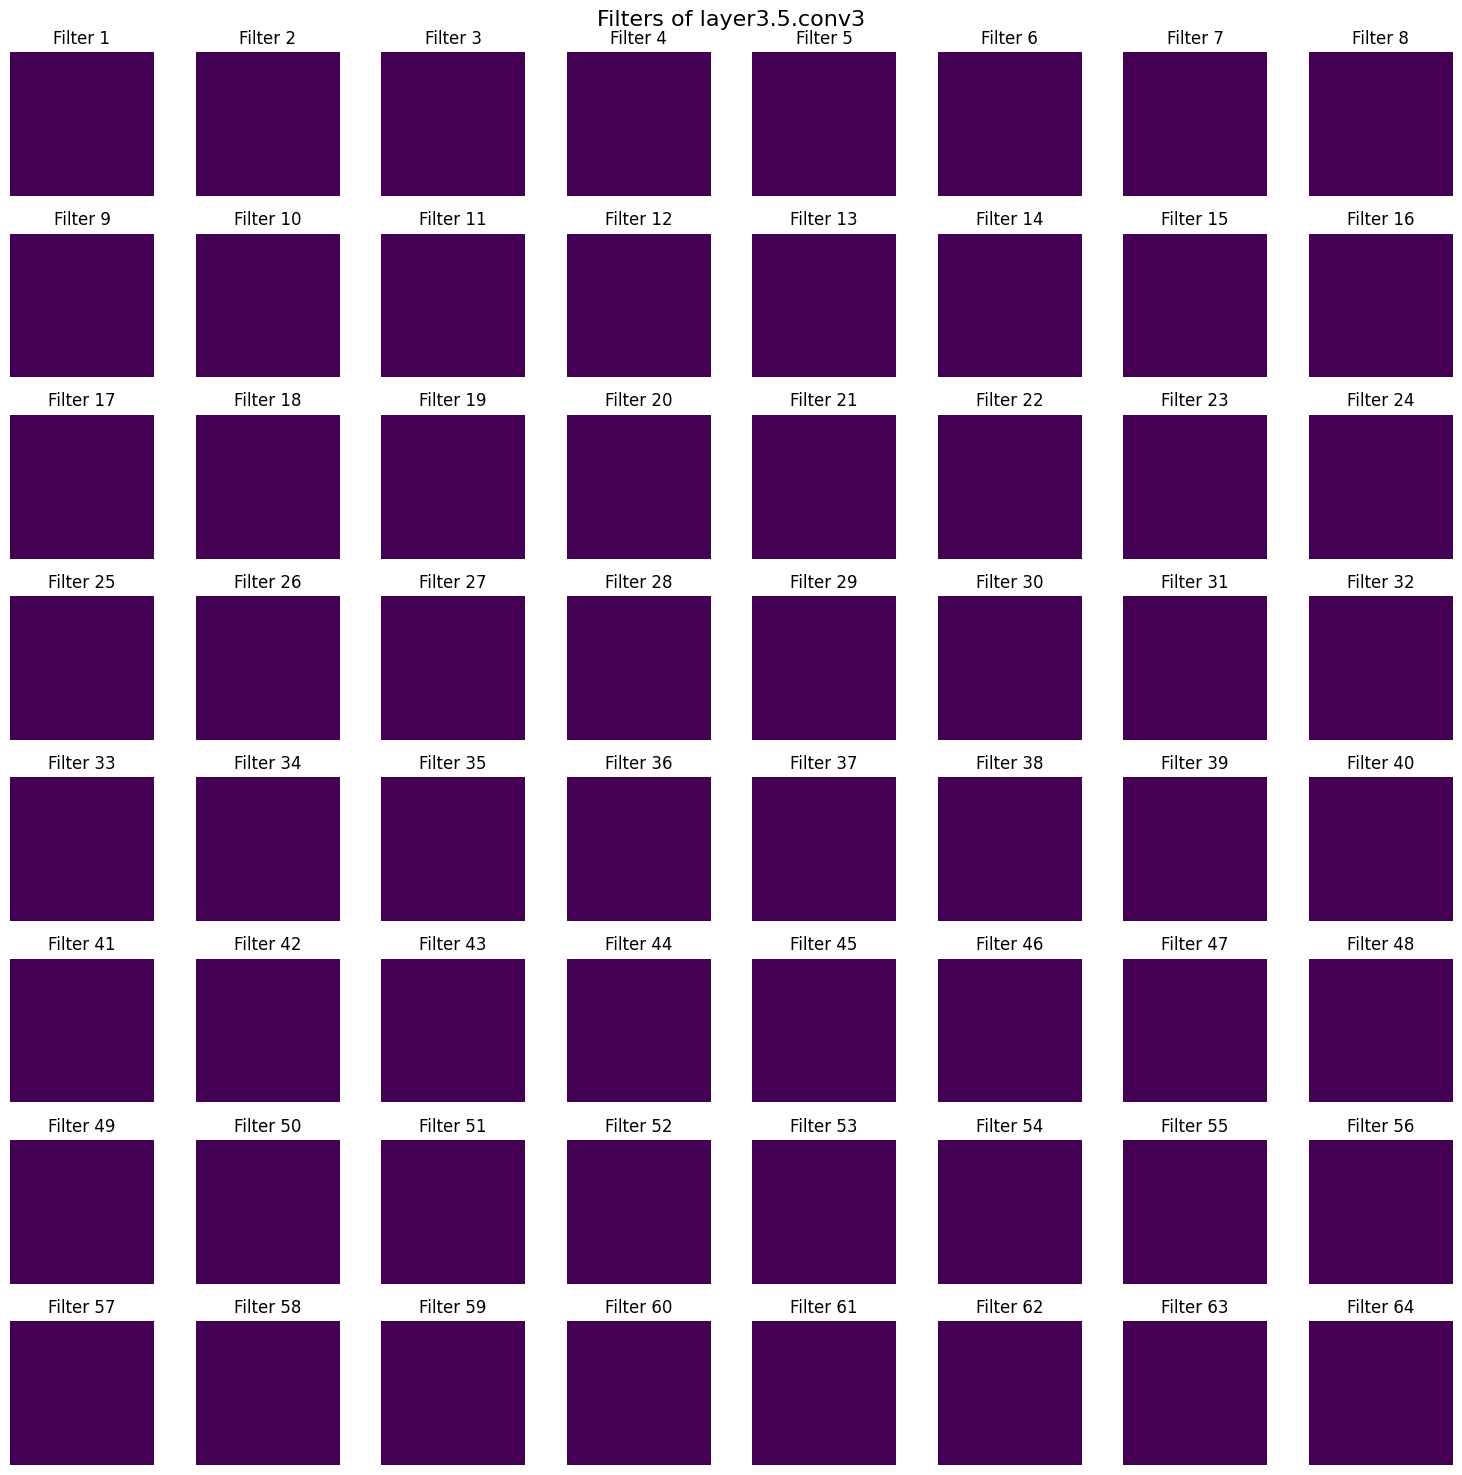

Visualizing filters for layer: layer4.0.conv1


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [24]:
# 定義 filter 可視化函數
def visualize_filters(layer_weights, layer_name, num_filters_to_show=64):
    filters = layer_weights.cpu().numpy()  # 將權重轉為 numpy
    num_filters = min(filters.shape[0], num_filters_to_show)
    num_columns = 8
    num_rows = (num_filters + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_filters):
        # 卷積核可能是 [out_channels, in_channels, kernel_height, kernel_width]
        kernel = filters[i].mean(axis=0)  # 將 RGB 通道平均化
        axes[i].imshow(kernel, cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"Filter {i+1}")

    for i in range(num_filters, len(axes)):
        axes[i].axis("off")

    plt.suptitle(f"Filters of {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 定義 feature map 可視化函數
def visualize_feature_maps(feature_maps, layer_name, num_maps_to_show=64):
    feature_maps = feature_maps.detach().cpu().numpy()  # 將 feature map 轉為 numpy
    num_maps = min(feature_maps.shape[0], num_maps_to_show)
    num_columns = 8
    num_rows = (num_maps + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_maps):
        axes[i].imshow(feature_maps[i], cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"Map {i+1}")

    for i in range(num_maps, len(axes)):
        axes[i].axis("off")

    plt.suptitle(f"Feature Maps of {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 掛載 Hook 函數以獲取中間層的輸出
feature_maps = {}

def hook_fn(module, input, output):
    feature_maps[module] = output

# 遍歷模型的卷積層，掛載 Hook
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        module.register_forward_hook(hook_fn)

# 可視化每一層的 filter 權重
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"Visualizing filters for layer: {name}")
        visualize_filters(module.weight, layer_name=name)

# 使用數據通過模型以生成 feature map
print("Generating feature maps...")
for inputs, _ in dataloader:
    inputs = inputs.to(device)
    with torch.no_grad():
        model(inputs)  # 前向傳播以收集中間層輸出
    break  # 只處理一張圖片

# 可視化每一層的 feature map
for module, activations in feature_maps.items():
    print(f"Visualizing feature maps for layer: {module}")
    visualize_feature_maps(activations[0], layer_name=str(module))